In [1]:
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn
import os
import sys
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
import torch.optim as optim
from sklearn.metrics import accuracy_score
%matplotlib inline

In [2]:
X_train_path = r"C:\Users\Michael\Documents\ALY 6020\group_project\final\train.npy"
y_train_path = r"C:\Users\Michael\Documents\ALY 6020\group_project\final\train_labels.npy"

X_val_path = r"C:\Users\Michael\Documents\ALY 6020\group_project\final\dev.npy"
y_val_path = r"C:\Users\Michael\Documents\ALY 6020\group_project\final\dev_labels.npy"

In [3]:
cuda = torch.cuda.is_available()
num_workers = 0 if cuda else 0
print("Cuda = " +str(cuda)+" with num_workders = "+str(num_workers))

Cuda = True with num_workders = 0


In [49]:
# Define dataset
class WJSdataset(Dataset):
    def __init__(self, X_path, y_path,k):
        self.X = np.load(X_path,allow_pickle=True)
        self.X = np.concatenate(self.X,axis = 0)
        self.X = np.pad(self.X, pad_width = ((k,k),(0,0)), mode = 'constant')

        self.y = np.load(y_path,allow_pickle=True)
        self.y = np.concatenate(self.y,axis = None)
        
        #for i in range(self.X.shape[0]):
        #    self.X[i] = np.pad(self.X[i], pad_width =  ((k, k), (0, 0)),
        #                    mode = 'constant')
        #self.X = np.concatenate(self.X,axis = 0).
        #    for j in range(self.X[i].shape[0]):
        #        x = np.concatenate(X_temp[j:j+2*k+1],axis = None)
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        
        x = self.X[index:index+2*context+1].flatten()
        y = self.y[index]
        x = torch.from_numpy(x).float()
        y = torch.from_numpy(np.array(y)).long()
        
        return x, y

In [95]:
context = 20

In [96]:
train = WJSdataset(X_train_path,y_train_path,context)
val = WJSdataset(X_val_path,y_val_path,context)

In [52]:
y = np.load(y_train_path,allow_pickle=True)
with np.printoptions(threshold=np.inf):
    print(y[155])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0. 20. 20. 20. 20. 20.  9.  9.  9.  9. 58. 58. 58. 58.
 58. 58. 58. 67. 67. 67. 67. 67. 67. 67. 37. 37. 37. 37. 46. 46. 46. 35.
 35. 35. 40. 40. 40. 40. 40. 40. 40. 40. 43. 43. 43. 43. 43. 43. 43. 43.
 43. 43. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 45. 45.
 45. 45. 45. 45. 45. 45. 45. 45. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58.
 64. 64. 64. 64. 44. 44. 44. 44. 44. 44. 44. 44. 44. 44. 44. 44. 44. 61.
 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 61.
 61. 61. 61. 43. 43. 43. 43. 43. 43. 43. 43. 43. 43. 43. 43. 43. 43. 43.
 43. 43.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 23. 23. 23. 23. 23. 23. 23. 25. 25. 25. 25. 55. 55. 55. 55. 55. 55. 67.
 67. 67. 67. 67. 67. 67.  8.  8.  8.  8. 69. 69. 69. 69. 69. 69. 69. 69.
 69. 46. 46. 46. 46. 46. 46. 49. 49. 49. 49. 49. 49

In [53]:
X_Viz = np.load(X_train_path, allow_pickle=True)

(40, 1184)


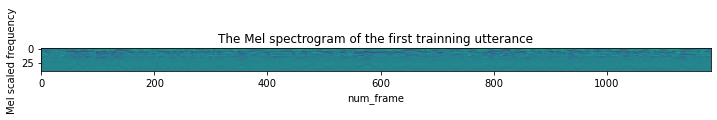

In [54]:
plt.figure(figsize=(12,40))
plt.xlabel('num_frame')
plt.ylabel('Mel scaled frequency')
plt.title('The Mel spectrogram of the first trainning utterance')
plt.imshow(X_Viz[0].T)
print(X_Viz[0].T.shape)
del X_Viz

In [ ]:
"""import librosa
import librosa.display
import IPython.display as ipd

test_audio = librosa.feature.inverse.mel_to_audio(X_val[1500],window = 'hamming',\
                                                  sr=8000,n_fft=512)
X_val[155].shape[0]
ipd.Audio(test_audio,rate = 8000)"""

In [99]:
len(train)

18482968

In [97]:
train_loader_arg = dict(shuffle = True, 
                        batch_size = 4096,
                        pin_memory = True, drop_last = True)
train_loader = DataLoader(train,**train_loader_arg, num_workers = num_workers)

val_loader_arg = dict(shuffle = False, batch_size = 4096, pin_memory = True)
val_loader = DataLoader(val,**val_loader_arg, num_workers = num_workers)

In [80]:
class CreateModel(nn.Module):
    def __init__(self, num_node_list):
        super(CreateModel,self).__init__()
        layers = []
        self.num_node_list = num_node_list
        for i in range(len(num_node_list)-2):
            layers.append(nn.Linear(num_node_list[i],num_node_list[i+1]))
            layers.append(nn.Dropout(p = 0.3))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(num_node_list[i+1]))
        layers.append(nn.Linear(num_node_list[-2], num_node_list[-1]))
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)

In [81]:
def one_epoch(model, train_loader, criterion, optimizer):
    model.train()
    
    running_loss = 0.0
    total_prediction = 0.0
    correct_predictions = 0.0
    
    start_time = time.time()
    for idx, (data,target) in enumerate(train_loader):
        
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        
        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()
        #print(outputs.data)
        #print(outputs.data.shape)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        #print(target.size(0))
        #print(predicted.shape)
        total_prediction += target.shape[0]
        correct_predictions += (predicted == target).sum().item()
        #print(correct_predictions)
        print([idx],'Train Loss: ', loss)
    end_time = time.time()
    
    running_loss /= len(train_loader)
    print('Training Loss: ', running_loss, 'Time: ', end_time - start_time, 's')
    
    acc = (correct_predictions/total_prediction)*100.0
    print("Training Accuaracy: ", acc, '%')
    return running_loss, acc
    

In [82]:
def val_model(model, val_loader, criterion):
    with torch.no_grad():
        model.eval()
        running_loss = 0.0
        total_prediction = 0.0
        correct_predictions = 0.0
        
        for idx, (data,target) in enumerate(val_loader):
        
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)
            loss = criterion(outputs, target).detach()
            print([idx],'Valid Loss: ', loss)
            running_loss += loss.item()
            #print(outputs.data)
            _, predicted = torch.max(outputs.data,1)
            total_prediction += target.size(0)
            #print(target.size(0))
            correct_predictions += (predicted == target).sum().item()
            #print(correct_predictions)
        
        running_loss /= len(val_loader)
        print('Testing Loss: ', running_loss)

        acc = (correct_predictions/total_prediction)*100.0
        print("Testing Accuaracy: ", acc, '%')
        return running_loss, acc
        

In [83]:
def training_plot(a, b):
    plt.figure(1)
    plt.plot(a,'b',label = "train")
    plt.plot(b,'g', label = "test")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.title('Training/Test Loss')
    plt.legend()
    plt.show()

In [84]:
def training_plot_acc(a, b):
    plt.figure(1)
    plt.plot(a,'b',label = "train")
    plt.plot(b,'g', label = "test")
    plt.xlabel("epochs")
    plt.ylabel("Accuracy")
    plt.title('Training/Test Accuracy')
    plt.legend()
    plt.show()

In [85]:
print('context: ',context)
model = CreateModel([40*(2*context+1),2048,2048,1024,512,256,71])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=2e-3)
device = torch.device("cuda")
model.to(device)
print(model)

context:  25
CreateModel(
  (net): Sequential(
    (0): Linear(in_features=2040, out_features=2048, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): ReLU()
    (3): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=2048, out_features=2048, bias=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): ReLU()
    (7): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=2048, out_features=1024, bias=True)
    (9): Dropout(p=0.3, inplace=False)
    (10): ReLU()
    (11): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=1024, out_features=512, bias=True)
    (13): Dropout(p=0.3, inplace=False)
    (14): ReLU()
    (15): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): Linear(in_features=512, out_features=256, bias=True)
    (17): Dropout(p=0.3, inplace=False)
    (1

In [86]:
Path = r'C:\Users\Michael\Documents\ALY 6020\group_project\final'
print(Path)

C:\Users\Michael\Documents\ALY 6020\group_project\final


Epoch Number:  0
[0] Train Loss:  tensor(4.4351, device='cuda:0', grad_fn=<NllLossBackward>)
[1] Train Loss:  tensor(4.0518, device='cuda:0', grad_fn=<NllLossBackward>)
[2] Train Loss:  tensor(3.6510, device='cuda:0', grad_fn=<NllLossBackward>)
[3] Train Loss:  tensor(3.3554, device='cuda:0', grad_fn=<NllLossBackward>)
[4] Train Loss:  tensor(3.1982, device='cuda:0', grad_fn=<NllLossBackward>)
[5] Train Loss:  tensor(3.0103, device='cuda:0', grad_fn=<NllLossBackward>)
[6] Train Loss:  tensor(2.9034, device='cuda:0', grad_fn=<NllLossBackward>)
[7] Train Loss:  tensor(2.8219, device='cuda:0', grad_fn=<NllLossBackward>)
[8] Train Loss:  tensor(2.7585, device='cuda:0', grad_fn=<NllLossBackward>)
[9] Train Loss:  tensor(2.6745, device='cuda:0', grad_fn=<NllLossBackward>)
[10] Train Loss:  tensor(2.6288, device='cuda:0', grad_fn=<NllLossBackward>)
[11] Train Loss:  tensor(2.5719, device='cuda:0', grad_fn=<NllLossBackward>)
[12] Train Loss:  tensor(2.5456, device='cuda:0', grad_fn=<NllLossBac

[107] Train Loss:  tensor(1.7429, device='cuda:0', grad_fn=<NllLossBackward>)
[108] Train Loss:  tensor(1.6925, device='cuda:0', grad_fn=<NllLossBackward>)
[109] Train Loss:  tensor(1.7425, device='cuda:0', grad_fn=<NllLossBackward>)
[110] Train Loss:  tensor(1.7282, device='cuda:0', grad_fn=<NllLossBackward>)
[111] Train Loss:  tensor(1.6987, device='cuda:0', grad_fn=<NllLossBackward>)
[112] Train Loss:  tensor(1.7378, device='cuda:0', grad_fn=<NllLossBackward>)
[113] Train Loss:  tensor(1.7161, device='cuda:0', grad_fn=<NllLossBackward>)
[114] Train Loss:  tensor(1.7120, device='cuda:0', grad_fn=<NllLossBackward>)
[115] Train Loss:  tensor(1.7215, device='cuda:0', grad_fn=<NllLossBackward>)
[116] Train Loss:  tensor(1.6492, device='cuda:0', grad_fn=<NllLossBackward>)
[117] Train Loss:  tensor(1.7108, device='cuda:0', grad_fn=<NllLossBackward>)
[118] Train Loss:  tensor(1.7459, device='cuda:0', grad_fn=<NllLossBackward>)
[119] Train Loss:  tensor(1.7209, device='cuda:0', grad_fn=<NllL

[213] Train Loss:  tensor(1.6007, device='cuda:0', grad_fn=<NllLossBackward>)
[214] Train Loss:  tensor(1.4760, device='cuda:0', grad_fn=<NllLossBackward>)
[215] Train Loss:  tensor(1.5429, device='cuda:0', grad_fn=<NllLossBackward>)
[216] Train Loss:  tensor(1.5105, device='cuda:0', grad_fn=<NllLossBackward>)
[217] Train Loss:  tensor(1.5388, device='cuda:0', grad_fn=<NllLossBackward>)
[218] Train Loss:  tensor(1.5689, device='cuda:0', grad_fn=<NllLossBackward>)
[219] Train Loss:  tensor(1.5590, device='cuda:0', grad_fn=<NllLossBackward>)
[220] Train Loss:  tensor(1.5523, device='cuda:0', grad_fn=<NllLossBackward>)
[221] Train Loss:  tensor(1.5048, device='cuda:0', grad_fn=<NllLossBackward>)
[222] Train Loss:  tensor(1.4954, device='cuda:0', grad_fn=<NllLossBackward>)
[223] Train Loss:  tensor(1.5295, device='cuda:0', grad_fn=<NllLossBackward>)
[224] Train Loss:  tensor(1.5442, device='cuda:0', grad_fn=<NllLossBackward>)
[225] Train Loss:  tensor(1.5746, device='cuda:0', grad_fn=<NllL

[319] Train Loss:  tensor(1.4836, device='cuda:0', grad_fn=<NllLossBackward>)
[320] Train Loss:  tensor(1.4038, device='cuda:0', grad_fn=<NllLossBackward>)
[321] Train Loss:  tensor(1.3925, device='cuda:0', grad_fn=<NllLossBackward>)
[322] Train Loss:  tensor(1.4936, device='cuda:0', grad_fn=<NllLossBackward>)
[323] Train Loss:  tensor(1.4708, device='cuda:0', grad_fn=<NllLossBackward>)
[324] Train Loss:  tensor(1.4279, device='cuda:0', grad_fn=<NllLossBackward>)
[325] Train Loss:  tensor(1.4367, device='cuda:0', grad_fn=<NllLossBackward>)
[326] Train Loss:  tensor(1.4701, device='cuda:0', grad_fn=<NllLossBackward>)
[327] Train Loss:  tensor(1.4088, device='cuda:0', grad_fn=<NllLossBackward>)
[328] Train Loss:  tensor(1.4452, device='cuda:0', grad_fn=<NllLossBackward>)
[329] Train Loss:  tensor(1.4293, device='cuda:0', grad_fn=<NllLossBackward>)
[330] Train Loss:  tensor(1.4346, device='cuda:0', grad_fn=<NllLossBackward>)
[331] Train Loss:  tensor(1.4340, device='cuda:0', grad_fn=<NllL

[425] Train Loss:  tensor(1.3447, device='cuda:0', grad_fn=<NllLossBackward>)
[426] Train Loss:  tensor(1.3822, device='cuda:0', grad_fn=<NllLossBackward>)
[427] Train Loss:  tensor(1.4006, device='cuda:0', grad_fn=<NllLossBackward>)
[428] Train Loss:  tensor(1.3384, device='cuda:0', grad_fn=<NllLossBackward>)
[429] Train Loss:  tensor(1.3596, device='cuda:0', grad_fn=<NllLossBackward>)
[430] Train Loss:  tensor(1.3774, device='cuda:0', grad_fn=<NllLossBackward>)
[431] Train Loss:  tensor(1.3667, device='cuda:0', grad_fn=<NllLossBackward>)
[432] Train Loss:  tensor(1.3604, device='cuda:0', grad_fn=<NllLossBackward>)
[433] Train Loss:  tensor(1.3827, device='cuda:0', grad_fn=<NllLossBackward>)
[434] Train Loss:  tensor(1.3851, device='cuda:0', grad_fn=<NllLossBackward>)
[435] Train Loss:  tensor(1.3560, device='cuda:0', grad_fn=<NllLossBackward>)
[436] Train Loss:  tensor(1.3802, device='cuda:0', grad_fn=<NllLossBackward>)
[437] Train Loss:  tensor(1.3524, device='cuda:0', grad_fn=<NllL

[531] Train Loss:  tensor(1.3063, device='cuda:0', grad_fn=<NllLossBackward>)
[532] Train Loss:  tensor(1.3207, device='cuda:0', grad_fn=<NllLossBackward>)
[533] Train Loss:  tensor(1.2920, device='cuda:0', grad_fn=<NllLossBackward>)
[534] Train Loss:  tensor(1.3099, device='cuda:0', grad_fn=<NllLossBackward>)
[535] Train Loss:  tensor(1.3249, device='cuda:0', grad_fn=<NllLossBackward>)
[536] Train Loss:  tensor(1.3252, device='cuda:0', grad_fn=<NllLossBackward>)
[537] Train Loss:  tensor(1.2832, device='cuda:0', grad_fn=<NllLossBackward>)
[538] Train Loss:  tensor(1.3449, device='cuda:0', grad_fn=<NllLossBackward>)
[539] Train Loss:  tensor(1.2811, device='cuda:0', grad_fn=<NllLossBackward>)
[540] Train Loss:  tensor(1.3423, device='cuda:0', grad_fn=<NllLossBackward>)
[541] Train Loss:  tensor(1.3231, device='cuda:0', grad_fn=<NllLossBackward>)
[542] Train Loss:  tensor(1.3467, device='cuda:0', grad_fn=<NllLossBackward>)
[543] Train Loss:  tensor(1.3151, device='cuda:0', grad_fn=<NllL

[637] Train Loss:  tensor(1.2471, device='cuda:0', grad_fn=<NllLossBackward>)
[638] Train Loss:  tensor(1.2748, device='cuda:0', grad_fn=<NllLossBackward>)
[639] Train Loss:  tensor(1.2500, device='cuda:0', grad_fn=<NllLossBackward>)
[640] Train Loss:  tensor(1.2788, device='cuda:0', grad_fn=<NllLossBackward>)
[641] Train Loss:  tensor(1.2674, device='cuda:0', grad_fn=<NllLossBackward>)
[642] Train Loss:  tensor(1.2792, device='cuda:0', grad_fn=<NllLossBackward>)
[643] Train Loss:  tensor(1.2757, device='cuda:0', grad_fn=<NllLossBackward>)
[644] Train Loss:  tensor(1.2744, device='cuda:0', grad_fn=<NllLossBackward>)
[645] Train Loss:  tensor(1.2417, device='cuda:0', grad_fn=<NllLossBackward>)
[646] Train Loss:  tensor(1.3076, device='cuda:0', grad_fn=<NllLossBackward>)
[647] Train Loss:  tensor(1.3058, device='cuda:0', grad_fn=<NllLossBackward>)
[648] Train Loss:  tensor(1.2823, device='cuda:0', grad_fn=<NllLossBackward>)
[649] Train Loss:  tensor(1.2489, device='cuda:0', grad_fn=<NllL

[743] Train Loss:  tensor(1.2670, device='cuda:0', grad_fn=<NllLossBackward>)
[744] Train Loss:  tensor(1.2398, device='cuda:0', grad_fn=<NllLossBackward>)
[745] Train Loss:  tensor(1.2487, device='cuda:0', grad_fn=<NllLossBackward>)
[746] Train Loss:  tensor(1.2624, device='cuda:0', grad_fn=<NllLossBackward>)
[747] Train Loss:  tensor(1.2293, device='cuda:0', grad_fn=<NllLossBackward>)
[748] Train Loss:  tensor(1.2039, device='cuda:0', grad_fn=<NllLossBackward>)
[749] Train Loss:  tensor(1.2465, device='cuda:0', grad_fn=<NllLossBackward>)
[750] Train Loss:  tensor(1.2460, device='cuda:0', grad_fn=<NllLossBackward>)
[751] Train Loss:  tensor(1.2547, device='cuda:0', grad_fn=<NllLossBackward>)
[752] Train Loss:  tensor(1.2157, device='cuda:0', grad_fn=<NllLossBackward>)
[753] Train Loss:  tensor(1.1940, device='cuda:0', grad_fn=<NllLossBackward>)
[754] Train Loss:  tensor(1.2322, device='cuda:0', grad_fn=<NllLossBackward>)
[755] Train Loss:  tensor(1.2205, device='cuda:0', grad_fn=<NllL

[849] Train Loss:  tensor(1.2291, device='cuda:0', grad_fn=<NllLossBackward>)
[850] Train Loss:  tensor(1.1963, device='cuda:0', grad_fn=<NllLossBackward>)
[851] Train Loss:  tensor(1.1957, device='cuda:0', grad_fn=<NllLossBackward>)
[852] Train Loss:  tensor(1.2198, device='cuda:0', grad_fn=<NllLossBackward>)
[853] Train Loss:  tensor(1.2232, device='cuda:0', grad_fn=<NllLossBackward>)
[854] Train Loss:  tensor(1.2097, device='cuda:0', grad_fn=<NllLossBackward>)
[855] Train Loss:  tensor(1.2246, device='cuda:0', grad_fn=<NllLossBackward>)
[856] Train Loss:  tensor(1.1797, device='cuda:0', grad_fn=<NllLossBackward>)
[857] Train Loss:  tensor(1.1970, device='cuda:0', grad_fn=<NllLossBackward>)
[858] Train Loss:  tensor(1.2036, device='cuda:0', grad_fn=<NllLossBackward>)
[859] Train Loss:  tensor(1.2094, device='cuda:0', grad_fn=<NllLossBackward>)
[860] Train Loss:  tensor(1.2072, device='cuda:0', grad_fn=<NllLossBackward>)
[861] Train Loss:  tensor(1.2101, device='cuda:0', grad_fn=<NllL

[955] Train Loss:  tensor(1.1791, device='cuda:0', grad_fn=<NllLossBackward>)
[956] Train Loss:  tensor(1.2146, device='cuda:0', grad_fn=<NllLossBackward>)
[957] Train Loss:  tensor(1.2217, device='cuda:0', grad_fn=<NllLossBackward>)
[958] Train Loss:  tensor(1.1832, device='cuda:0', grad_fn=<NllLossBackward>)
[959] Train Loss:  tensor(1.1843, device='cuda:0', grad_fn=<NllLossBackward>)
[960] Train Loss:  tensor(1.1860, device='cuda:0', grad_fn=<NllLossBackward>)
[961] Train Loss:  tensor(1.2042, device='cuda:0', grad_fn=<NllLossBackward>)
[962] Train Loss:  tensor(1.1955, device='cuda:0', grad_fn=<NllLossBackward>)
[963] Train Loss:  tensor(1.1627, device='cuda:0', grad_fn=<NllLossBackward>)
[964] Train Loss:  tensor(1.1957, device='cuda:0', grad_fn=<NllLossBackward>)
[965] Train Loss:  tensor(1.1857, device='cuda:0', grad_fn=<NllLossBackward>)
[966] Train Loss:  tensor(1.1946, device='cuda:0', grad_fn=<NllLossBackward>)
[967] Train Loss:  tensor(1.2195, device='cuda:0', grad_fn=<NllL

[1060] Train Loss:  tensor(1.1978, device='cuda:0', grad_fn=<NllLossBackward>)
[1061] Train Loss:  tensor(1.1605, device='cuda:0', grad_fn=<NllLossBackward>)
[1062] Train Loss:  tensor(1.1842, device='cuda:0', grad_fn=<NllLossBackward>)
[1063] Train Loss:  tensor(1.1751, device='cuda:0', grad_fn=<NllLossBackward>)
[1064] Train Loss:  tensor(1.1476, device='cuda:0', grad_fn=<NllLossBackward>)
[1065] Train Loss:  tensor(1.1854, device='cuda:0', grad_fn=<NllLossBackward>)
[1066] Train Loss:  tensor(1.1488, device='cuda:0', grad_fn=<NllLossBackward>)
[1067] Train Loss:  tensor(1.1902, device='cuda:0', grad_fn=<NllLossBackward>)
[1068] Train Loss:  tensor(1.1547, device='cuda:0', grad_fn=<NllLossBackward>)
[1069] Train Loss:  tensor(1.1343, device='cuda:0', grad_fn=<NllLossBackward>)
[1070] Train Loss:  tensor(1.1638, device='cuda:0', grad_fn=<NllLossBackward>)
[1071] Train Loss:  tensor(1.1666, device='cuda:0', grad_fn=<NllLossBackward>)
[1072] Train Loss:  tensor(1.1741, device='cuda:0', 

[1164] Train Loss:  tensor(1.1361, device='cuda:0', grad_fn=<NllLossBackward>)
[1165] Train Loss:  tensor(1.1780, device='cuda:0', grad_fn=<NllLossBackward>)
[1166] Train Loss:  tensor(1.1390, device='cuda:0', grad_fn=<NllLossBackward>)
[1167] Train Loss:  tensor(1.1582, device='cuda:0', grad_fn=<NllLossBackward>)
[1168] Train Loss:  tensor(1.1800, device='cuda:0', grad_fn=<NllLossBackward>)
[1169] Train Loss:  tensor(1.1578, device='cuda:0', grad_fn=<NllLossBackward>)
[1170] Train Loss:  tensor(1.1451, device='cuda:0', grad_fn=<NllLossBackward>)
[1171] Train Loss:  tensor(1.2046, device='cuda:0', grad_fn=<NllLossBackward>)
[1172] Train Loss:  tensor(1.1624, device='cuda:0', grad_fn=<NllLossBackward>)
[1173] Train Loss:  tensor(1.1728, device='cuda:0', grad_fn=<NllLossBackward>)
[1174] Train Loss:  tensor(1.1232, device='cuda:0', grad_fn=<NllLossBackward>)
[1175] Train Loss:  tensor(1.1469, device='cuda:0', grad_fn=<NllLossBackward>)
[1176] Train Loss:  tensor(1.1916, device='cuda:0', 

[1268] Train Loss:  tensor(1.0837, device='cuda:0', grad_fn=<NllLossBackward>)
[1269] Train Loss:  tensor(1.1174, device='cuda:0', grad_fn=<NllLossBackward>)
[1270] Train Loss:  tensor(1.1391, device='cuda:0', grad_fn=<NllLossBackward>)
[1271] Train Loss:  tensor(1.1205, device='cuda:0', grad_fn=<NllLossBackward>)
[1272] Train Loss:  tensor(1.1560, device='cuda:0', grad_fn=<NllLossBackward>)
[1273] Train Loss:  tensor(1.1637, device='cuda:0', grad_fn=<NllLossBackward>)
[1274] Train Loss:  tensor(1.1245, device='cuda:0', grad_fn=<NllLossBackward>)
[1275] Train Loss:  tensor(1.1399, device='cuda:0', grad_fn=<NllLossBackward>)
[1276] Train Loss:  tensor(1.1595, device='cuda:0', grad_fn=<NllLossBackward>)
[1277] Train Loss:  tensor(1.0701, device='cuda:0', grad_fn=<NllLossBackward>)
[1278] Train Loss:  tensor(1.1600, device='cuda:0', grad_fn=<NllLossBackward>)
[1279] Train Loss:  tensor(1.1299, device='cuda:0', grad_fn=<NllLossBackward>)
[1280] Train Loss:  tensor(1.1525, device='cuda:0', 

[1372] Train Loss:  tensor(1.1435, device='cuda:0', grad_fn=<NllLossBackward>)
[1373] Train Loss:  tensor(1.1186, device='cuda:0', grad_fn=<NllLossBackward>)
[1374] Train Loss:  tensor(1.1103, device='cuda:0', grad_fn=<NllLossBackward>)
[1375] Train Loss:  tensor(1.1297, device='cuda:0', grad_fn=<NllLossBackward>)
[1376] Train Loss:  tensor(1.1057, device='cuda:0', grad_fn=<NllLossBackward>)
[1377] Train Loss:  tensor(1.1322, device='cuda:0', grad_fn=<NllLossBackward>)
[1378] Train Loss:  tensor(1.1401, device='cuda:0', grad_fn=<NllLossBackward>)
[1379] Train Loss:  tensor(1.1447, device='cuda:0', grad_fn=<NllLossBackward>)
[1380] Train Loss:  tensor(1.1370, device='cuda:0', grad_fn=<NllLossBackward>)
[1381] Train Loss:  tensor(1.1246, device='cuda:0', grad_fn=<NllLossBackward>)
[1382] Train Loss:  tensor(1.1517, device='cuda:0', grad_fn=<NllLossBackward>)
[1383] Train Loss:  tensor(1.0987, device='cuda:0', grad_fn=<NllLossBackward>)
[1384] Train Loss:  tensor(1.1151, device='cuda:0', 

[1476] Train Loss:  tensor(1.1348, device='cuda:0', grad_fn=<NllLossBackward>)
[1477] Train Loss:  tensor(1.1368, device='cuda:0', grad_fn=<NllLossBackward>)
[1478] Train Loss:  tensor(1.1502, device='cuda:0', grad_fn=<NllLossBackward>)
[1479] Train Loss:  tensor(1.0915, device='cuda:0', grad_fn=<NllLossBackward>)
[1480] Train Loss:  tensor(1.1242, device='cuda:0', grad_fn=<NllLossBackward>)
[1481] Train Loss:  tensor(1.1131, device='cuda:0', grad_fn=<NllLossBackward>)
[1482] Train Loss:  tensor(1.1123, device='cuda:0', grad_fn=<NllLossBackward>)
[1483] Train Loss:  tensor(1.1046, device='cuda:0', grad_fn=<NllLossBackward>)
[1484] Train Loss:  tensor(1.1156, device='cuda:0', grad_fn=<NllLossBackward>)
[1485] Train Loss:  tensor(1.1299, device='cuda:0', grad_fn=<NllLossBackward>)
[1486] Train Loss:  tensor(1.1345, device='cuda:0', grad_fn=<NllLossBackward>)
[1487] Train Loss:  tensor(1.1309, device='cuda:0', grad_fn=<NllLossBackward>)
[1488] Train Loss:  tensor(1.1144, device='cuda:0', 

[1580] Train Loss:  tensor(1.1030, device='cuda:0', grad_fn=<NllLossBackward>)
[1581] Train Loss:  tensor(1.0862, device='cuda:0', grad_fn=<NllLossBackward>)
[1582] Train Loss:  tensor(1.0830, device='cuda:0', grad_fn=<NllLossBackward>)
[1583] Train Loss:  tensor(1.0809, device='cuda:0', grad_fn=<NllLossBackward>)
[1584] Train Loss:  tensor(1.1081, device='cuda:0', grad_fn=<NllLossBackward>)
[1585] Train Loss:  tensor(1.0838, device='cuda:0', grad_fn=<NllLossBackward>)
[1586] Train Loss:  tensor(1.0758, device='cuda:0', grad_fn=<NllLossBackward>)
[1587] Train Loss:  tensor(1.0860, device='cuda:0', grad_fn=<NllLossBackward>)
[1588] Train Loss:  tensor(1.0576, device='cuda:0', grad_fn=<NllLossBackward>)
[1589] Train Loss:  tensor(1.1197, device='cuda:0', grad_fn=<NllLossBackward>)
[1590] Train Loss:  tensor(1.1041, device='cuda:0', grad_fn=<NllLossBackward>)
[1591] Train Loss:  tensor(1.1116, device='cuda:0', grad_fn=<NllLossBackward>)
[1592] Train Loss:  tensor(1.1045, device='cuda:0', 

[1684] Train Loss:  tensor(1.0954, device='cuda:0', grad_fn=<NllLossBackward>)
[1685] Train Loss:  tensor(1.0783, device='cuda:0', grad_fn=<NllLossBackward>)
[1686] Train Loss:  tensor(1.0802, device='cuda:0', grad_fn=<NllLossBackward>)
[1687] Train Loss:  tensor(1.1014, device='cuda:0', grad_fn=<NllLossBackward>)
[1688] Train Loss:  tensor(1.1217, device='cuda:0', grad_fn=<NllLossBackward>)
[1689] Train Loss:  tensor(1.1020, device='cuda:0', grad_fn=<NllLossBackward>)
[1690] Train Loss:  tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward>)
[1691] Train Loss:  tensor(1.0957, device='cuda:0', grad_fn=<NllLossBackward>)
[1692] Train Loss:  tensor(1.1581, device='cuda:0', grad_fn=<NllLossBackward>)
[1693] Train Loss:  tensor(1.1170, device='cuda:0', grad_fn=<NllLossBackward>)
[1694] Train Loss:  tensor(1.1161, device='cuda:0', grad_fn=<NllLossBackward>)
[1695] Train Loss:  tensor(1.0794, device='cuda:0', grad_fn=<NllLossBackward>)
[1696] Train Loss:  tensor(1.0683, device='cuda:0', 

[1788] Train Loss:  tensor(1.1002, device='cuda:0', grad_fn=<NllLossBackward>)
[1789] Train Loss:  tensor(1.0671, device='cuda:0', grad_fn=<NllLossBackward>)
[1790] Train Loss:  tensor(1.0668, device='cuda:0', grad_fn=<NllLossBackward>)
[1791] Train Loss:  tensor(1.1355, device='cuda:0', grad_fn=<NllLossBackward>)
[1792] Train Loss:  tensor(1.0731, device='cuda:0', grad_fn=<NllLossBackward>)
[1793] Train Loss:  tensor(1.0526, device='cuda:0', grad_fn=<NllLossBackward>)
[1794] Train Loss:  tensor(1.0870, device='cuda:0', grad_fn=<NllLossBackward>)
[1795] Train Loss:  tensor(1.0808, device='cuda:0', grad_fn=<NllLossBackward>)
[1796] Train Loss:  tensor(1.0424, device='cuda:0', grad_fn=<NllLossBackward>)
[1797] Train Loss:  tensor(1.0752, device='cuda:0', grad_fn=<NllLossBackward>)
[1798] Train Loss:  tensor(1.0959, device='cuda:0', grad_fn=<NllLossBackward>)
[1799] Train Loss:  tensor(1.0481, device='cuda:0', grad_fn=<NllLossBackward>)
[1800] Train Loss:  tensor(1.0797, device='cuda:0', 

[1892] Train Loss:  tensor(1.0800, device='cuda:0', grad_fn=<NllLossBackward>)
[1893] Train Loss:  tensor(1.0905, device='cuda:0', grad_fn=<NllLossBackward>)
[1894] Train Loss:  tensor(1.0662, device='cuda:0', grad_fn=<NllLossBackward>)
[1895] Train Loss:  tensor(1.0656, device='cuda:0', grad_fn=<NllLossBackward>)
[1896] Train Loss:  tensor(1.1000, device='cuda:0', grad_fn=<NllLossBackward>)
[1897] Train Loss:  tensor(1.0934, device='cuda:0', grad_fn=<NllLossBackward>)
[1898] Train Loss:  tensor(1.0916, device='cuda:0', grad_fn=<NllLossBackward>)
[1899] Train Loss:  tensor(1.0936, device='cuda:0', grad_fn=<NllLossBackward>)
[1900] Train Loss:  tensor(1.0830, device='cuda:0', grad_fn=<NllLossBackward>)
[1901] Train Loss:  tensor(1.0684, device='cuda:0', grad_fn=<NllLossBackward>)
[1902] Train Loss:  tensor(1.0891, device='cuda:0', grad_fn=<NllLossBackward>)
[1903] Train Loss:  tensor(1.1175, device='cuda:0', grad_fn=<NllLossBackward>)
[1904] Train Loss:  tensor(1.0844, device='cuda:0', 

[1996] Train Loss:  tensor(1.0793, device='cuda:0', grad_fn=<NllLossBackward>)
[1997] Train Loss:  tensor(1.0617, device='cuda:0', grad_fn=<NllLossBackward>)
[1998] Train Loss:  tensor(1.0530, device='cuda:0', grad_fn=<NllLossBackward>)
[1999] Train Loss:  tensor(1.0940, device='cuda:0', grad_fn=<NllLossBackward>)
[2000] Train Loss:  tensor(1.0585, device='cuda:0', grad_fn=<NllLossBackward>)
[2001] Train Loss:  tensor(1.0932, device='cuda:0', grad_fn=<NllLossBackward>)
[2002] Train Loss:  tensor(1.0551, device='cuda:0', grad_fn=<NllLossBackward>)
[2003] Train Loss:  tensor(1.0926, device='cuda:0', grad_fn=<NllLossBackward>)
[2004] Train Loss:  tensor(1.0612, device='cuda:0', grad_fn=<NllLossBackward>)
[2005] Train Loss:  tensor(1.0520, device='cuda:0', grad_fn=<NllLossBackward>)
[2006] Train Loss:  tensor(1.0805, device='cuda:0', grad_fn=<NllLossBackward>)
[2007] Train Loss:  tensor(1.0647, device='cuda:0', grad_fn=<NllLossBackward>)
[2008] Train Loss:  tensor(1.0537, device='cuda:0', 

[2100] Train Loss:  tensor(1.0654, device='cuda:0', grad_fn=<NllLossBackward>)
[2101] Train Loss:  tensor(1.0544, device='cuda:0', grad_fn=<NllLossBackward>)
[2102] Train Loss:  tensor(1.0444, device='cuda:0', grad_fn=<NllLossBackward>)
[2103] Train Loss:  tensor(1.0554, device='cuda:0', grad_fn=<NllLossBackward>)
[2104] Train Loss:  tensor(1.0878, device='cuda:0', grad_fn=<NllLossBackward>)
[2105] Train Loss:  tensor(1.0261, device='cuda:0', grad_fn=<NllLossBackward>)
[2106] Train Loss:  tensor(1.0551, device='cuda:0', grad_fn=<NllLossBackward>)
[2107] Train Loss:  tensor(1.0626, device='cuda:0', grad_fn=<NllLossBackward>)
[2108] Train Loss:  tensor(1.0525, device='cuda:0', grad_fn=<NllLossBackward>)
[2109] Train Loss:  tensor(1.0857, device='cuda:0', grad_fn=<NllLossBackward>)
[2110] Train Loss:  tensor(1.0436, device='cuda:0', grad_fn=<NllLossBackward>)
[2111] Train Loss:  tensor(1.0840, device='cuda:0', grad_fn=<NllLossBackward>)
[2112] Train Loss:  tensor(1.0658, device='cuda:0', 

[2204] Train Loss:  tensor(1.0696, device='cuda:0', grad_fn=<NllLossBackward>)
[2205] Train Loss:  tensor(1.0634, device='cuda:0', grad_fn=<NllLossBackward>)
[2206] Train Loss:  tensor(1.0661, device='cuda:0', grad_fn=<NllLossBackward>)
[2207] Train Loss:  tensor(1.0654, device='cuda:0', grad_fn=<NllLossBackward>)
[2208] Train Loss:  tensor(1.0683, device='cuda:0', grad_fn=<NllLossBackward>)
[2209] Train Loss:  tensor(1.0780, device='cuda:0', grad_fn=<NllLossBackward>)
[2210] Train Loss:  tensor(1.0612, device='cuda:0', grad_fn=<NllLossBackward>)
[2211] Train Loss:  tensor(1.0520, device='cuda:0', grad_fn=<NllLossBackward>)
[2212] Train Loss:  tensor(1.0468, device='cuda:0', grad_fn=<NllLossBackward>)
[2213] Train Loss:  tensor(1.0339, device='cuda:0', grad_fn=<NllLossBackward>)
[2214] Train Loss:  tensor(1.0739, device='cuda:0', grad_fn=<NllLossBackward>)
[2215] Train Loss:  tensor(1.0248, device='cuda:0', grad_fn=<NllLossBackward>)
[2216] Train Loss:  tensor(1.0253, device='cuda:0', 

[2308] Train Loss:  tensor(1.0581, device='cuda:0', grad_fn=<NllLossBackward>)
[2309] Train Loss:  tensor(1.0781, device='cuda:0', grad_fn=<NllLossBackward>)
[2310] Train Loss:  tensor(1.0566, device='cuda:0', grad_fn=<NllLossBackward>)
[2311] Train Loss:  tensor(1.0371, device='cuda:0', grad_fn=<NllLossBackward>)
[2312] Train Loss:  tensor(1.0635, device='cuda:0', grad_fn=<NllLossBackward>)
[2313] Train Loss:  tensor(1.0456, device='cuda:0', grad_fn=<NllLossBackward>)
[2314] Train Loss:  tensor(1.0269, device='cuda:0', grad_fn=<NllLossBackward>)
[2315] Train Loss:  tensor(1.0341, device='cuda:0', grad_fn=<NllLossBackward>)
[2316] Train Loss:  tensor(1.0586, device='cuda:0', grad_fn=<NllLossBackward>)
[2317] Train Loss:  tensor(1.0161, device='cuda:0', grad_fn=<NllLossBackward>)
[2318] Train Loss:  tensor(1.0398, device='cuda:0', grad_fn=<NllLossBackward>)
[2319] Train Loss:  tensor(1.0129, device='cuda:0', grad_fn=<NllLossBackward>)
[2320] Train Loss:  tensor(1.0129, device='cuda:0', 

[2412] Train Loss:  tensor(1.0337, device='cuda:0', grad_fn=<NllLossBackward>)
[2413] Train Loss:  tensor(1.0410, device='cuda:0', grad_fn=<NllLossBackward>)
[2414] Train Loss:  tensor(1.0010, device='cuda:0', grad_fn=<NllLossBackward>)
[2415] Train Loss:  tensor(1.0022, device='cuda:0', grad_fn=<NllLossBackward>)
[2416] Train Loss:  tensor(1.0161, device='cuda:0', grad_fn=<NllLossBackward>)
[2417] Train Loss:  tensor(1.0160, device='cuda:0', grad_fn=<NllLossBackward>)
[2418] Train Loss:  tensor(1.0067, device='cuda:0', grad_fn=<NllLossBackward>)
[2419] Train Loss:  tensor(1.0283, device='cuda:0', grad_fn=<NllLossBackward>)
[2420] Train Loss:  tensor(1.0497, device='cuda:0', grad_fn=<NllLossBackward>)
[2421] Train Loss:  tensor(0.9925, device='cuda:0', grad_fn=<NllLossBackward>)
[2422] Train Loss:  tensor(1.0337, device='cuda:0', grad_fn=<NllLossBackward>)
[2423] Train Loss:  tensor(1.0655, device='cuda:0', grad_fn=<NllLossBackward>)
[2424] Train Loss:  tensor(1.0343, device='cuda:0', 

[2516] Train Loss:  tensor(1.0372, device='cuda:0', grad_fn=<NllLossBackward>)
[2517] Train Loss:  tensor(1.0505, device='cuda:0', grad_fn=<NllLossBackward>)
[2518] Train Loss:  tensor(1.0510, device='cuda:0', grad_fn=<NllLossBackward>)
[2519] Train Loss:  tensor(1.0164, device='cuda:0', grad_fn=<NllLossBackward>)
[2520] Train Loss:  tensor(1.0524, device='cuda:0', grad_fn=<NllLossBackward>)
[2521] Train Loss:  tensor(1.0207, device='cuda:0', grad_fn=<NllLossBackward>)
[2522] Train Loss:  tensor(0.9978, device='cuda:0', grad_fn=<NllLossBackward>)
[2523] Train Loss:  tensor(1.0815, device='cuda:0', grad_fn=<NllLossBackward>)
[2524] Train Loss:  tensor(1.0078, device='cuda:0', grad_fn=<NllLossBackward>)
[2525] Train Loss:  tensor(1.0195, device='cuda:0', grad_fn=<NllLossBackward>)
[2526] Train Loss:  tensor(1.0096, device='cuda:0', grad_fn=<NllLossBackward>)
[2527] Train Loss:  tensor(1.0308, device='cuda:0', grad_fn=<NllLossBackward>)
[2528] Train Loss:  tensor(1.0233, device='cuda:0', 

[2620] Train Loss:  tensor(1.0311, device='cuda:0', grad_fn=<NllLossBackward>)
[2621] Train Loss:  tensor(1.0154, device='cuda:0', grad_fn=<NllLossBackward>)
[2622] Train Loss:  tensor(1.0382, device='cuda:0', grad_fn=<NllLossBackward>)
[2623] Train Loss:  tensor(1.0613, device='cuda:0', grad_fn=<NllLossBackward>)
[2624] Train Loss:  tensor(1.0444, device='cuda:0', grad_fn=<NllLossBackward>)
[2625] Train Loss:  tensor(1.0378, device='cuda:0', grad_fn=<NllLossBackward>)
[2626] Train Loss:  tensor(1.0196, device='cuda:0', grad_fn=<NllLossBackward>)
[2627] Train Loss:  tensor(1.0006, device='cuda:0', grad_fn=<NllLossBackward>)
[2628] Train Loss:  tensor(0.9978, device='cuda:0', grad_fn=<NllLossBackward>)
[2629] Train Loss:  tensor(1.0287, device='cuda:0', grad_fn=<NllLossBackward>)
[2630] Train Loss:  tensor(0.9993, device='cuda:0', grad_fn=<NllLossBackward>)
[2631] Train Loss:  tensor(1.0182, device='cuda:0', grad_fn=<NllLossBackward>)
[2632] Train Loss:  tensor(1.0029, device='cuda:0', 

[2724] Train Loss:  tensor(1.0119, device='cuda:0', grad_fn=<NllLossBackward>)
[2725] Train Loss:  tensor(1.0005, device='cuda:0', grad_fn=<NllLossBackward>)
[2726] Train Loss:  tensor(1.0272, device='cuda:0', grad_fn=<NllLossBackward>)
[2727] Train Loss:  tensor(1.0403, device='cuda:0', grad_fn=<NllLossBackward>)
[2728] Train Loss:  tensor(1.0369, device='cuda:0', grad_fn=<NllLossBackward>)
[2729] Train Loss:  tensor(1.0454, device='cuda:0', grad_fn=<NllLossBackward>)
[2730] Train Loss:  tensor(1.0228, device='cuda:0', grad_fn=<NllLossBackward>)
[2731] Train Loss:  tensor(0.9885, device='cuda:0', grad_fn=<NllLossBackward>)
[2732] Train Loss:  tensor(1.0505, device='cuda:0', grad_fn=<NllLossBackward>)
[2733] Train Loss:  tensor(1.0194, device='cuda:0', grad_fn=<NllLossBackward>)
[2734] Train Loss:  tensor(1.0772, device='cuda:0', grad_fn=<NllLossBackward>)
[2735] Train Loss:  tensor(1.0473, device='cuda:0', grad_fn=<NllLossBackward>)
[2736] Train Loss:  tensor(1.0377, device='cuda:0', 

[2828] Train Loss:  tensor(0.9873, device='cuda:0', grad_fn=<NllLossBackward>)
[2829] Train Loss:  tensor(1.0288, device='cuda:0', grad_fn=<NllLossBackward>)
[2830] Train Loss:  tensor(0.9867, device='cuda:0', grad_fn=<NllLossBackward>)
[2831] Train Loss:  tensor(1.0076, device='cuda:0', grad_fn=<NllLossBackward>)
[2832] Train Loss:  tensor(1.0087, device='cuda:0', grad_fn=<NllLossBackward>)
[2833] Train Loss:  tensor(1.0026, device='cuda:0', grad_fn=<NllLossBackward>)
[2834] Train Loss:  tensor(1.0193, device='cuda:0', grad_fn=<NllLossBackward>)
[2835] Train Loss:  tensor(1.0235, device='cuda:0', grad_fn=<NllLossBackward>)
[2836] Train Loss:  tensor(1.0004, device='cuda:0', grad_fn=<NllLossBackward>)
[2837] Train Loss:  tensor(1.0084, device='cuda:0', grad_fn=<NllLossBackward>)
[2838] Train Loss:  tensor(1.0016, device='cuda:0', grad_fn=<NllLossBackward>)
[2839] Train Loss:  tensor(0.9731, device='cuda:0', grad_fn=<NllLossBackward>)
[2840] Train Loss:  tensor(0.9981, device='cuda:0', 

[2932] Train Loss:  tensor(1.0127, device='cuda:0', grad_fn=<NllLossBackward>)
[2933] Train Loss:  tensor(1.0013, device='cuda:0', grad_fn=<NllLossBackward>)
[2934] Train Loss:  tensor(1.0342, device='cuda:0', grad_fn=<NllLossBackward>)
[2935] Train Loss:  tensor(1.0096, device='cuda:0', grad_fn=<NllLossBackward>)
[2936] Train Loss:  tensor(1.0357, device='cuda:0', grad_fn=<NllLossBackward>)
[2937] Train Loss:  tensor(1.0145, device='cuda:0', grad_fn=<NllLossBackward>)
[2938] Train Loss:  tensor(1.0118, device='cuda:0', grad_fn=<NllLossBackward>)
[2939] Train Loss:  tensor(1.0258, device='cuda:0', grad_fn=<NllLossBackward>)
[2940] Train Loss:  tensor(1.0334, device='cuda:0', grad_fn=<NllLossBackward>)
[2941] Train Loss:  tensor(1.0174, device='cuda:0', grad_fn=<NllLossBackward>)
[2942] Train Loss:  tensor(1.0334, device='cuda:0', grad_fn=<NllLossBackward>)
[2943] Train Loss:  tensor(0.9837, device='cuda:0', grad_fn=<NllLossBackward>)
[2944] Train Loss:  tensor(1.0079, device='cuda:0', 

[3036] Train Loss:  tensor(1.0155, device='cuda:0', grad_fn=<NllLossBackward>)
[3037] Train Loss:  tensor(0.9886, device='cuda:0', grad_fn=<NllLossBackward>)
[3038] Train Loss:  tensor(1.0132, device='cuda:0', grad_fn=<NllLossBackward>)
[3039] Train Loss:  tensor(0.9686, device='cuda:0', grad_fn=<NllLossBackward>)
[3040] Train Loss:  tensor(0.9885, device='cuda:0', grad_fn=<NllLossBackward>)
[3041] Train Loss:  tensor(0.9638, device='cuda:0', grad_fn=<NllLossBackward>)
[3042] Train Loss:  tensor(0.9955, device='cuda:0', grad_fn=<NllLossBackward>)
[3043] Train Loss:  tensor(1.0405, device='cuda:0', grad_fn=<NllLossBackward>)
[3044] Train Loss:  tensor(1.0318, device='cuda:0', grad_fn=<NllLossBackward>)
[3045] Train Loss:  tensor(1.0368, device='cuda:0', grad_fn=<NllLossBackward>)
[3046] Train Loss:  tensor(0.9875, device='cuda:0', grad_fn=<NllLossBackward>)
[3047] Train Loss:  tensor(0.9601, device='cuda:0', grad_fn=<NllLossBackward>)
[3048] Train Loss:  tensor(0.9966, device='cuda:0', 

[3140] Train Loss:  tensor(1.0071, device='cuda:0', grad_fn=<NllLossBackward>)
[3141] Train Loss:  tensor(0.9744, device='cuda:0', grad_fn=<NllLossBackward>)
[3142] Train Loss:  tensor(1.0047, device='cuda:0', grad_fn=<NllLossBackward>)
[3143] Train Loss:  tensor(1.0124, device='cuda:0', grad_fn=<NllLossBackward>)
[3144] Train Loss:  tensor(0.9744, device='cuda:0', grad_fn=<NllLossBackward>)
[3145] Train Loss:  tensor(0.9986, device='cuda:0', grad_fn=<NllLossBackward>)
[3146] Train Loss:  tensor(1.0201, device='cuda:0', grad_fn=<NllLossBackward>)
[3147] Train Loss:  tensor(0.9440, device='cuda:0', grad_fn=<NllLossBackward>)
[3148] Train Loss:  tensor(0.9780, device='cuda:0', grad_fn=<NllLossBackward>)
[3149] Train Loss:  tensor(1.0393, device='cuda:0', grad_fn=<NllLossBackward>)
[3150] Train Loss:  tensor(0.9845, device='cuda:0', grad_fn=<NllLossBackward>)
[3151] Train Loss:  tensor(0.9397, device='cuda:0', grad_fn=<NllLossBackward>)
[3152] Train Loss:  tensor(0.9976, device='cuda:0', 

[3244] Train Loss:  tensor(0.9545, device='cuda:0', grad_fn=<NllLossBackward>)
[3245] Train Loss:  tensor(0.9861, device='cuda:0', grad_fn=<NllLossBackward>)
[3246] Train Loss:  tensor(0.9828, device='cuda:0', grad_fn=<NllLossBackward>)
[3247] Train Loss:  tensor(0.9688, device='cuda:0', grad_fn=<NllLossBackward>)
[3248] Train Loss:  tensor(1.0067, device='cuda:0', grad_fn=<NllLossBackward>)
[3249] Train Loss:  tensor(0.9937, device='cuda:0', grad_fn=<NllLossBackward>)
[3250] Train Loss:  tensor(0.9925, device='cuda:0', grad_fn=<NllLossBackward>)
[3251] Train Loss:  tensor(0.9588, device='cuda:0', grad_fn=<NllLossBackward>)
[3252] Train Loss:  tensor(0.9953, device='cuda:0', grad_fn=<NllLossBackward>)
[3253] Train Loss:  tensor(0.9716, device='cuda:0', grad_fn=<NllLossBackward>)
[3254] Train Loss:  tensor(0.9754, device='cuda:0', grad_fn=<NllLossBackward>)
[3255] Train Loss:  tensor(1.0161, device='cuda:0', grad_fn=<NllLossBackward>)
[3256] Train Loss:  tensor(0.9860, device='cuda:0', 

[3348] Train Loss:  tensor(0.9675, device='cuda:0', grad_fn=<NllLossBackward>)
[3349] Train Loss:  tensor(1.0030, device='cuda:0', grad_fn=<NllLossBackward>)
[3350] Train Loss:  tensor(0.9882, device='cuda:0', grad_fn=<NllLossBackward>)
[3351] Train Loss:  tensor(1.0132, device='cuda:0', grad_fn=<NllLossBackward>)
[3352] Train Loss:  tensor(0.9752, device='cuda:0', grad_fn=<NllLossBackward>)
[3353] Train Loss:  tensor(0.9655, device='cuda:0', grad_fn=<NllLossBackward>)
[3354] Train Loss:  tensor(1.0063, device='cuda:0', grad_fn=<NllLossBackward>)
[3355] Train Loss:  tensor(0.9821, device='cuda:0', grad_fn=<NllLossBackward>)
[3356] Train Loss:  tensor(0.9902, device='cuda:0', grad_fn=<NllLossBackward>)
[3357] Train Loss:  tensor(0.9973, device='cuda:0', grad_fn=<NllLossBackward>)
[3358] Train Loss:  tensor(1.0622, device='cuda:0', grad_fn=<NllLossBackward>)
[3359] Train Loss:  tensor(0.9810, device='cuda:0', grad_fn=<NllLossBackward>)
[3360] Train Loss:  tensor(0.9736, device='cuda:0', 

[3452] Train Loss:  tensor(1.0059, device='cuda:0', grad_fn=<NllLossBackward>)
[3453] Train Loss:  tensor(0.9601, device='cuda:0', grad_fn=<NllLossBackward>)
[3454] Train Loss:  tensor(1.0201, device='cuda:0', grad_fn=<NllLossBackward>)
[3455] Train Loss:  tensor(0.9838, device='cuda:0', grad_fn=<NllLossBackward>)
[3456] Train Loss:  tensor(0.9897, device='cuda:0', grad_fn=<NllLossBackward>)
[3457] Train Loss:  tensor(0.9585, device='cuda:0', grad_fn=<NllLossBackward>)
[3458] Train Loss:  tensor(0.9812, device='cuda:0', grad_fn=<NllLossBackward>)
[3459] Train Loss:  tensor(1.0286, device='cuda:0', grad_fn=<NllLossBackward>)
[3460] Train Loss:  tensor(0.9780, device='cuda:0', grad_fn=<NllLossBackward>)
[3461] Train Loss:  tensor(0.9536, device='cuda:0', grad_fn=<NllLossBackward>)
[3462] Train Loss:  tensor(0.9979, device='cuda:0', grad_fn=<NllLossBackward>)
[3463] Train Loss:  tensor(0.9465, device='cuda:0', grad_fn=<NllLossBackward>)
[3464] Train Loss:  tensor(1.0051, device='cuda:0', 

[3556] Train Loss:  tensor(0.9293, device='cuda:0', grad_fn=<NllLossBackward>)
[3557] Train Loss:  tensor(0.9809, device='cuda:0', grad_fn=<NllLossBackward>)
[3558] Train Loss:  tensor(0.9593, device='cuda:0', grad_fn=<NllLossBackward>)
[3559] Train Loss:  tensor(1.0005, device='cuda:0', grad_fn=<NllLossBackward>)
[3560] Train Loss:  tensor(0.9694, device='cuda:0', grad_fn=<NllLossBackward>)
[3561] Train Loss:  tensor(1.0434, device='cuda:0', grad_fn=<NllLossBackward>)
[3562] Train Loss:  tensor(0.9419, device='cuda:0', grad_fn=<NllLossBackward>)
[3563] Train Loss:  tensor(0.9668, device='cuda:0', grad_fn=<NllLossBackward>)
[3564] Train Loss:  tensor(0.9505, device='cuda:0', grad_fn=<NllLossBackward>)
[3565] Train Loss:  tensor(0.9554, device='cuda:0', grad_fn=<NllLossBackward>)
[3566] Train Loss:  tensor(0.9946, device='cuda:0', grad_fn=<NllLossBackward>)
[3567] Train Loss:  tensor(0.9699, device='cuda:0', grad_fn=<NllLossBackward>)
[3568] Train Loss:  tensor(0.9765, device='cuda:0', 

[3660] Train Loss:  tensor(0.9779, device='cuda:0', grad_fn=<NllLossBackward>)
[3661] Train Loss:  tensor(0.9510, device='cuda:0', grad_fn=<NllLossBackward>)
[3662] Train Loss:  tensor(0.9966, device='cuda:0', grad_fn=<NllLossBackward>)
[3663] Train Loss:  tensor(0.9839, device='cuda:0', grad_fn=<NllLossBackward>)
[3664] Train Loss:  tensor(0.9713, device='cuda:0', grad_fn=<NllLossBackward>)
[3665] Train Loss:  tensor(0.9419, device='cuda:0', grad_fn=<NllLossBackward>)
[3666] Train Loss:  tensor(0.9845, device='cuda:0', grad_fn=<NllLossBackward>)
[3667] Train Loss:  tensor(0.9849, device='cuda:0', grad_fn=<NllLossBackward>)
[3668] Train Loss:  tensor(0.9483, device='cuda:0', grad_fn=<NllLossBackward>)
[3669] Train Loss:  tensor(0.9632, device='cuda:0', grad_fn=<NllLossBackward>)
[3670] Train Loss:  tensor(0.9361, device='cuda:0', grad_fn=<NllLossBackward>)
[3671] Train Loss:  tensor(0.9755, device='cuda:0', grad_fn=<NllLossBackward>)
[3672] Train Loss:  tensor(1.0079, device='cuda:0', 

[3764] Train Loss:  tensor(0.9767, device='cuda:0', grad_fn=<NllLossBackward>)
[3765] Train Loss:  tensor(0.9739, device='cuda:0', grad_fn=<NllLossBackward>)
[3766] Train Loss:  tensor(0.9584, device='cuda:0', grad_fn=<NllLossBackward>)
[3767] Train Loss:  tensor(0.9761, device='cuda:0', grad_fn=<NllLossBackward>)
[3768] Train Loss:  tensor(0.9966, device='cuda:0', grad_fn=<NllLossBackward>)
[3769] Train Loss:  tensor(0.9842, device='cuda:0', grad_fn=<NllLossBackward>)
[3770] Train Loss:  tensor(0.9638, device='cuda:0', grad_fn=<NllLossBackward>)
[3771] Train Loss:  tensor(0.9265, device='cuda:0', grad_fn=<NllLossBackward>)
[3772] Train Loss:  tensor(0.9385, device='cuda:0', grad_fn=<NllLossBackward>)
[3773] Train Loss:  tensor(0.9517, device='cuda:0', grad_fn=<NllLossBackward>)
[3774] Train Loss:  tensor(0.9595, device='cuda:0', grad_fn=<NllLossBackward>)
[3775] Train Loss:  tensor(0.9593, device='cuda:0', grad_fn=<NllLossBackward>)
[3776] Train Loss:  tensor(0.9668, device='cuda:0', 

[3868] Train Loss:  tensor(0.9765, device='cuda:0', grad_fn=<NllLossBackward>)
[3869] Train Loss:  tensor(0.9552, device='cuda:0', grad_fn=<NllLossBackward>)
[3870] Train Loss:  tensor(0.9874, device='cuda:0', grad_fn=<NllLossBackward>)
[3871] Train Loss:  tensor(0.9846, device='cuda:0', grad_fn=<NllLossBackward>)
[3872] Train Loss:  tensor(0.9744, device='cuda:0', grad_fn=<NllLossBackward>)
[3873] Train Loss:  tensor(0.9608, device='cuda:0', grad_fn=<NllLossBackward>)
[3874] Train Loss:  tensor(1.0024, device='cuda:0', grad_fn=<NllLossBackward>)
[3875] Train Loss:  tensor(0.9690, device='cuda:0', grad_fn=<NllLossBackward>)
[3876] Train Loss:  tensor(0.9896, device='cuda:0', grad_fn=<NllLossBackward>)
[3877] Train Loss:  tensor(0.9666, device='cuda:0', grad_fn=<NllLossBackward>)
[3878] Train Loss:  tensor(0.9520, device='cuda:0', grad_fn=<NllLossBackward>)
[3879] Train Loss:  tensor(0.9619, device='cuda:0', grad_fn=<NllLossBackward>)
[3880] Train Loss:  tensor(0.9403, device='cuda:0', 

[3972] Train Loss:  tensor(0.9724, device='cuda:0', grad_fn=<NllLossBackward>)
[3973] Train Loss:  tensor(0.9728, device='cuda:0', grad_fn=<NllLossBackward>)
[3974] Train Loss:  tensor(0.9602, device='cuda:0', grad_fn=<NllLossBackward>)
[3975] Train Loss:  tensor(1.0125, device='cuda:0', grad_fn=<NllLossBackward>)
[3976] Train Loss:  tensor(0.9699, device='cuda:0', grad_fn=<NllLossBackward>)
[3977] Train Loss:  tensor(1.0053, device='cuda:0', grad_fn=<NllLossBackward>)
[3978] Train Loss:  tensor(0.9428, device='cuda:0', grad_fn=<NllLossBackward>)
[3979] Train Loss:  tensor(0.9685, device='cuda:0', grad_fn=<NllLossBackward>)
[3980] Train Loss:  tensor(0.9717, device='cuda:0', grad_fn=<NllLossBackward>)
[3981] Train Loss:  tensor(0.9361, device='cuda:0', grad_fn=<NllLossBackward>)
[3982] Train Loss:  tensor(0.9238, device='cuda:0', grad_fn=<NllLossBackward>)
[3983] Train Loss:  tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward>)
[3984] Train Loss:  tensor(0.9377, device='cuda:0', 

[4076] Train Loss:  tensor(0.9676, device='cuda:0', grad_fn=<NllLossBackward>)
[4077] Train Loss:  tensor(0.9479, device='cuda:0', grad_fn=<NllLossBackward>)
[4078] Train Loss:  tensor(0.9911, device='cuda:0', grad_fn=<NllLossBackward>)
[4079] Train Loss:  tensor(0.9869, device='cuda:0', grad_fn=<NllLossBackward>)
[4080] Train Loss:  tensor(0.9313, device='cuda:0', grad_fn=<NllLossBackward>)
[4081] Train Loss:  tensor(0.9370, device='cuda:0', grad_fn=<NllLossBackward>)
[4082] Train Loss:  tensor(0.9669, device='cuda:0', grad_fn=<NllLossBackward>)
[4083] Train Loss:  tensor(0.9327, device='cuda:0', grad_fn=<NllLossBackward>)
[4084] Train Loss:  tensor(0.9500, device='cuda:0', grad_fn=<NllLossBackward>)
[4085] Train Loss:  tensor(0.9871, device='cuda:0', grad_fn=<NllLossBackward>)
[4086] Train Loss:  tensor(0.9774, device='cuda:0', grad_fn=<NllLossBackward>)
[4087] Train Loss:  tensor(0.9693, device='cuda:0', grad_fn=<NllLossBackward>)
[4088] Train Loss:  tensor(0.9819, device='cuda:0', 

[4180] Train Loss:  tensor(0.9682, device='cuda:0', grad_fn=<NllLossBackward>)
[4181] Train Loss:  tensor(0.9421, device='cuda:0', grad_fn=<NllLossBackward>)
[4182] Train Loss:  tensor(0.9435, device='cuda:0', grad_fn=<NllLossBackward>)
[4183] Train Loss:  tensor(0.9318, device='cuda:0', grad_fn=<NllLossBackward>)
[4184] Train Loss:  tensor(0.9491, device='cuda:0', grad_fn=<NllLossBackward>)
[4185] Train Loss:  tensor(0.9465, device='cuda:0', grad_fn=<NllLossBackward>)
[4186] Train Loss:  tensor(0.9968, device='cuda:0', grad_fn=<NllLossBackward>)
[4187] Train Loss:  tensor(0.9331, device='cuda:0', grad_fn=<NllLossBackward>)
[4188] Train Loss:  tensor(0.9302, device='cuda:0', grad_fn=<NllLossBackward>)
[4189] Train Loss:  tensor(1.0050, device='cuda:0', grad_fn=<NllLossBackward>)
[4190] Train Loss:  tensor(0.9613, device='cuda:0', grad_fn=<NllLossBackward>)
[4191] Train Loss:  tensor(0.9948, device='cuda:0', grad_fn=<NllLossBackward>)
[4192] Train Loss:  tensor(0.9401, device='cuda:0', 

[4284] Train Loss:  tensor(0.9678, device='cuda:0', grad_fn=<NllLossBackward>)
[4285] Train Loss:  tensor(0.9442, device='cuda:0', grad_fn=<NllLossBackward>)
[4286] Train Loss:  tensor(0.9547, device='cuda:0', grad_fn=<NllLossBackward>)
[4287] Train Loss:  tensor(0.9320, device='cuda:0', grad_fn=<NllLossBackward>)
[4288] Train Loss:  tensor(0.9535, device='cuda:0', grad_fn=<NllLossBackward>)
[4289] Train Loss:  tensor(1.0137, device='cuda:0', grad_fn=<NllLossBackward>)
[4290] Train Loss:  tensor(0.9644, device='cuda:0', grad_fn=<NllLossBackward>)
[4291] Train Loss:  tensor(0.9380, device='cuda:0', grad_fn=<NllLossBackward>)
[4292] Train Loss:  tensor(0.9401, device='cuda:0', grad_fn=<NllLossBackward>)
[4293] Train Loss:  tensor(0.9645, device='cuda:0', grad_fn=<NllLossBackward>)
[4294] Train Loss:  tensor(0.9783, device='cuda:0', grad_fn=<NllLossBackward>)
[4295] Train Loss:  tensor(0.9577, device='cuda:0', grad_fn=<NllLossBackward>)
[4296] Train Loss:  tensor(0.9810, device='cuda:0', 

[4388] Train Loss:  tensor(0.9342, device='cuda:0', grad_fn=<NllLossBackward>)
[4389] Train Loss:  tensor(0.9348, device='cuda:0', grad_fn=<NllLossBackward>)
[4390] Train Loss:  tensor(0.9414, device='cuda:0', grad_fn=<NllLossBackward>)
[4391] Train Loss:  tensor(0.9681, device='cuda:0', grad_fn=<NllLossBackward>)
[4392] Train Loss:  tensor(0.9647, device='cuda:0', grad_fn=<NllLossBackward>)
[4393] Train Loss:  tensor(0.9697, device='cuda:0', grad_fn=<NllLossBackward>)
[4394] Train Loss:  tensor(0.9763, device='cuda:0', grad_fn=<NllLossBackward>)
[4395] Train Loss:  tensor(0.9415, device='cuda:0', grad_fn=<NllLossBackward>)
[4396] Train Loss:  tensor(0.9649, device='cuda:0', grad_fn=<NllLossBackward>)
[4397] Train Loss:  tensor(0.9528, device='cuda:0', grad_fn=<NllLossBackward>)
[4398] Train Loss:  tensor(0.9374, device='cuda:0', grad_fn=<NllLossBackward>)
[4399] Train Loss:  tensor(0.9342, device='cuda:0', grad_fn=<NllLossBackward>)
[4400] Train Loss:  tensor(0.9893, device='cuda:0', 

[4492] Train Loss:  tensor(0.9392, device='cuda:0', grad_fn=<NllLossBackward>)
[4493] Train Loss:  tensor(0.9484, device='cuda:0', grad_fn=<NllLossBackward>)
[4494] Train Loss:  tensor(0.9466, device='cuda:0', grad_fn=<NllLossBackward>)
[4495] Train Loss:  tensor(0.9429, device='cuda:0', grad_fn=<NllLossBackward>)
[4496] Train Loss:  tensor(0.9463, device='cuda:0', grad_fn=<NllLossBackward>)
[4497] Train Loss:  tensor(0.9128, device='cuda:0', grad_fn=<NllLossBackward>)
[4498] Train Loss:  tensor(0.9118, device='cuda:0', grad_fn=<NllLossBackward>)
[4499] Train Loss:  tensor(0.9949, device='cuda:0', grad_fn=<NllLossBackward>)
[4500] Train Loss:  tensor(0.9480, device='cuda:0', grad_fn=<NllLossBackward>)
[4501] Train Loss:  tensor(0.9562, device='cuda:0', grad_fn=<NllLossBackward>)
[4502] Train Loss:  tensor(0.9549, device='cuda:0', grad_fn=<NllLossBackward>)
[4503] Train Loss:  tensor(0.9692, device='cuda:0', grad_fn=<NllLossBackward>)
[4504] Train Loss:  tensor(0.9514, device='cuda:0', 

[130] Valid Loss:  tensor(1.0077, device='cuda:0')
[131] Valid Loss:  tensor(0.8584, device='cuda:0')
[132] Valid Loss:  tensor(0.8772, device='cuda:0')
[133] Valid Loss:  tensor(0.8979, device='cuda:0')
[134] Valid Loss:  tensor(0.8280, device='cuda:0')
[135] Valid Loss:  tensor(0.7709, device='cuda:0')
[136] Valid Loss:  tensor(0.8185, device='cuda:0')
[137] Valid Loss:  tensor(1.0986, device='cuda:0')
[138] Valid Loss:  tensor(0.9958, device='cuda:0')
[139] Valid Loss:  tensor(1.1810, device='cuda:0')
[140] Valid Loss:  tensor(0.9296, device='cuda:0')
[141] Valid Loss:  tensor(0.8029, device='cuda:0')
[142] Valid Loss:  tensor(1.1441, device='cuda:0')
[143] Valid Loss:  tensor(0.7919, device='cuda:0')
[144] Valid Loss:  tensor(0.9166, device='cuda:0')
[145] Valid Loss:  tensor(1.0932, device='cuda:0')
[146] Valid Loss:  tensor(0.8645, device='cuda:0')
[147] Valid Loss:  tensor(0.9467, device='cuda:0')
[148] Valid Loss:  tensor(0.8763, device='cuda:0')
[149] Valid Loss:  tensor(0.902

[291] Valid Loss:  tensor(0.8619, device='cuda:0')
[292] Valid Loss:  tensor(0.9990, device='cuda:0')
[293] Valid Loss:  tensor(0.8285, device='cuda:0')
[294] Valid Loss:  tensor(0.9748, device='cuda:0')
[295] Valid Loss:  tensor(0.7673, device='cuda:0')
[296] Valid Loss:  tensor(0.8995, device='cuda:0')
[297] Valid Loss:  tensor(0.9039, device='cuda:0')
[298] Valid Loss:  tensor(0.7961, device='cuda:0')
[299] Valid Loss:  tensor(0.9261, device='cuda:0')
[300] Valid Loss:  tensor(1.0742, device='cuda:0')
[301] Valid Loss:  tensor(0.7391, device='cuda:0')
[302] Valid Loss:  tensor(0.7176, device='cuda:0')
[303] Valid Loss:  tensor(0.8790, device='cuda:0')
[304] Valid Loss:  tensor(0.8163, device='cuda:0')
[305] Valid Loss:  tensor(0.8851, device='cuda:0')
[306] Valid Loss:  tensor(0.9357, device='cuda:0')
[307] Valid Loss:  tensor(0.7638, device='cuda:0')
[308] Valid Loss:  tensor(0.8122, device='cuda:0')
[309] Valid Loss:  tensor(0.8376, device='cuda:0')
[310] Valid Loss:  tensor(0.869

[46] Train Loss:  tensor(0.9085, device='cuda:0', grad_fn=<NllLossBackward>)
[47] Train Loss:  tensor(0.9076, device='cuda:0', grad_fn=<NllLossBackward>)
[48] Train Loss:  tensor(0.9111, device='cuda:0', grad_fn=<NllLossBackward>)
[49] Train Loss:  tensor(0.9179, device='cuda:0', grad_fn=<NllLossBackward>)
[50] Train Loss:  tensor(0.9341, device='cuda:0', grad_fn=<NllLossBackward>)
[51] Train Loss:  tensor(0.9532, device='cuda:0', grad_fn=<NllLossBackward>)
[52] Train Loss:  tensor(0.9534, device='cuda:0', grad_fn=<NllLossBackward>)
[53] Train Loss:  tensor(0.9595, device='cuda:0', grad_fn=<NllLossBackward>)
[54] Train Loss:  tensor(0.9464, device='cuda:0', grad_fn=<NllLossBackward>)
[55] Train Loss:  tensor(0.9601, device='cuda:0', grad_fn=<NllLossBackward>)
[56] Train Loss:  tensor(0.9201, device='cuda:0', grad_fn=<NllLossBackward>)
[57] Train Loss:  tensor(0.9334, device='cuda:0', grad_fn=<NllLossBackward>)
[58] Train Loss:  tensor(0.9393, device='cuda:0', grad_fn=<NllLossBackward>)

[152] Train Loss:  tensor(0.8896, device='cuda:0', grad_fn=<NllLossBackward>)
[153] Train Loss:  tensor(0.9520, device='cuda:0', grad_fn=<NllLossBackward>)
[154] Train Loss:  tensor(0.9653, device='cuda:0', grad_fn=<NllLossBackward>)
[155] Train Loss:  tensor(0.8830, device='cuda:0', grad_fn=<NllLossBackward>)
[156] Train Loss:  tensor(0.9063, device='cuda:0', grad_fn=<NllLossBackward>)
[157] Train Loss:  tensor(0.8958, device='cuda:0', grad_fn=<NllLossBackward>)
[158] Train Loss:  tensor(0.9528, device='cuda:0', grad_fn=<NllLossBackward>)
[159] Train Loss:  tensor(0.9730, device='cuda:0', grad_fn=<NllLossBackward>)
[160] Train Loss:  tensor(0.9462, device='cuda:0', grad_fn=<NllLossBackward>)
[161] Train Loss:  tensor(0.9095, device='cuda:0', grad_fn=<NllLossBackward>)
[162] Train Loss:  tensor(0.9628, device='cuda:0', grad_fn=<NllLossBackward>)
[163] Train Loss:  tensor(0.9117, device='cuda:0', grad_fn=<NllLossBackward>)
[164] Train Loss:  tensor(0.9248, device='cuda:0', grad_fn=<NllL

[258] Train Loss:  tensor(0.9448, device='cuda:0', grad_fn=<NllLossBackward>)
[259] Train Loss:  tensor(0.9399, device='cuda:0', grad_fn=<NllLossBackward>)
[260] Train Loss:  tensor(0.8993, device='cuda:0', grad_fn=<NllLossBackward>)
[261] Train Loss:  tensor(0.9237, device='cuda:0', grad_fn=<NllLossBackward>)
[262] Train Loss:  tensor(0.9288, device='cuda:0', grad_fn=<NllLossBackward>)
[263] Train Loss:  tensor(0.9052, device='cuda:0', grad_fn=<NllLossBackward>)
[264] Train Loss:  tensor(0.9247, device='cuda:0', grad_fn=<NllLossBackward>)
[265] Train Loss:  tensor(0.9169, device='cuda:0', grad_fn=<NllLossBackward>)
[266] Train Loss:  tensor(0.9154, device='cuda:0', grad_fn=<NllLossBackward>)
[267] Train Loss:  tensor(0.9613, device='cuda:0', grad_fn=<NllLossBackward>)
[268] Train Loss:  tensor(0.9377, device='cuda:0', grad_fn=<NllLossBackward>)
[269] Train Loss:  tensor(0.9035, device='cuda:0', grad_fn=<NllLossBackward>)
[270] Train Loss:  tensor(0.9477, device='cuda:0', grad_fn=<NllL

[364] Train Loss:  tensor(0.8811, device='cuda:0', grad_fn=<NllLossBackward>)
[365] Train Loss:  tensor(0.9066, device='cuda:0', grad_fn=<NllLossBackward>)
[366] Train Loss:  tensor(0.9367, device='cuda:0', grad_fn=<NllLossBackward>)
[367] Train Loss:  tensor(0.9093, device='cuda:0', grad_fn=<NllLossBackward>)
[368] Train Loss:  tensor(0.9545, device='cuda:0', grad_fn=<NllLossBackward>)
[369] Train Loss:  tensor(0.9340, device='cuda:0', grad_fn=<NllLossBackward>)
[370] Train Loss:  tensor(0.9493, device='cuda:0', grad_fn=<NllLossBackward>)
[371] Train Loss:  tensor(0.9364, device='cuda:0', grad_fn=<NllLossBackward>)
[372] Train Loss:  tensor(0.9308, device='cuda:0', grad_fn=<NllLossBackward>)
[373] Train Loss:  tensor(0.9448, device='cuda:0', grad_fn=<NllLossBackward>)
[374] Train Loss:  tensor(0.8824, device='cuda:0', grad_fn=<NllLossBackward>)
[375] Train Loss:  tensor(0.9584, device='cuda:0', grad_fn=<NllLossBackward>)
[376] Train Loss:  tensor(0.9220, device='cuda:0', grad_fn=<NllL

[470] Train Loss:  tensor(0.9483, device='cuda:0', grad_fn=<NllLossBackward>)
[471] Train Loss:  tensor(0.9126, device='cuda:0', grad_fn=<NllLossBackward>)
[472] Train Loss:  tensor(0.9386, device='cuda:0', grad_fn=<NllLossBackward>)
[473] Train Loss:  tensor(0.9316, device='cuda:0', grad_fn=<NllLossBackward>)
[474] Train Loss:  tensor(0.9159, device='cuda:0', grad_fn=<NllLossBackward>)
[475] Train Loss:  tensor(0.9712, device='cuda:0', grad_fn=<NllLossBackward>)
[476] Train Loss:  tensor(0.9284, device='cuda:0', grad_fn=<NllLossBackward>)
[477] Train Loss:  tensor(0.9167, device='cuda:0', grad_fn=<NllLossBackward>)
[478] Train Loss:  tensor(0.9173, device='cuda:0', grad_fn=<NllLossBackward>)
[479] Train Loss:  tensor(0.9285, device='cuda:0', grad_fn=<NllLossBackward>)
[480] Train Loss:  tensor(0.9723, device='cuda:0', grad_fn=<NllLossBackward>)
[481] Train Loss:  tensor(0.9072, device='cuda:0', grad_fn=<NllLossBackward>)
[482] Train Loss:  tensor(0.9278, device='cuda:0', grad_fn=<NllL

[576] Train Loss:  tensor(0.9190, device='cuda:0', grad_fn=<NllLossBackward>)
[577] Train Loss:  tensor(0.9318, device='cuda:0', grad_fn=<NllLossBackward>)
[578] Train Loss:  tensor(0.9352, device='cuda:0', grad_fn=<NllLossBackward>)
[579] Train Loss:  tensor(0.9265, device='cuda:0', grad_fn=<NllLossBackward>)
[580] Train Loss:  tensor(0.9479, device='cuda:0', grad_fn=<NllLossBackward>)
[581] Train Loss:  tensor(0.8900, device='cuda:0', grad_fn=<NllLossBackward>)
[582] Train Loss:  tensor(0.9051, device='cuda:0', grad_fn=<NllLossBackward>)
[583] Train Loss:  tensor(0.9276, device='cuda:0', grad_fn=<NllLossBackward>)
[584] Train Loss:  tensor(0.9382, device='cuda:0', grad_fn=<NllLossBackward>)
[585] Train Loss:  tensor(0.9222, device='cuda:0', grad_fn=<NllLossBackward>)
[586] Train Loss:  tensor(0.9235, device='cuda:0', grad_fn=<NllLossBackward>)
[587] Train Loss:  tensor(0.9345, device='cuda:0', grad_fn=<NllLossBackward>)
[588] Train Loss:  tensor(0.9001, device='cuda:0', grad_fn=<NllL

[682] Train Loss:  tensor(0.9282, device='cuda:0', grad_fn=<NllLossBackward>)
[683] Train Loss:  tensor(0.9363, device='cuda:0', grad_fn=<NllLossBackward>)
[684] Train Loss:  tensor(0.9099, device='cuda:0', grad_fn=<NllLossBackward>)
[685] Train Loss:  tensor(0.9095, device='cuda:0', grad_fn=<NllLossBackward>)
[686] Train Loss:  tensor(0.9079, device='cuda:0', grad_fn=<NllLossBackward>)
[687] Train Loss:  tensor(0.9262, device='cuda:0', grad_fn=<NllLossBackward>)
[688] Train Loss:  tensor(0.9153, device='cuda:0', grad_fn=<NllLossBackward>)
[689] Train Loss:  tensor(0.9506, device='cuda:0', grad_fn=<NllLossBackward>)
[690] Train Loss:  tensor(0.8906, device='cuda:0', grad_fn=<NllLossBackward>)
[691] Train Loss:  tensor(0.9053, device='cuda:0', grad_fn=<NllLossBackward>)
[692] Train Loss:  tensor(0.9173, device='cuda:0', grad_fn=<NllLossBackward>)
[693] Train Loss:  tensor(0.9211, device='cuda:0', grad_fn=<NllLossBackward>)
[694] Train Loss:  tensor(0.9229, device='cuda:0', grad_fn=<NllL

[788] Train Loss:  tensor(0.9362, device='cuda:0', grad_fn=<NllLossBackward>)
[789] Train Loss:  tensor(0.9662, device='cuda:0', grad_fn=<NllLossBackward>)
[790] Train Loss:  tensor(0.9073, device='cuda:0', grad_fn=<NllLossBackward>)
[791] Train Loss:  tensor(0.9162, device='cuda:0', grad_fn=<NllLossBackward>)
[792] Train Loss:  tensor(0.9446, device='cuda:0', grad_fn=<NllLossBackward>)
[793] Train Loss:  tensor(0.9265, device='cuda:0', grad_fn=<NllLossBackward>)
[794] Train Loss:  tensor(0.9028, device='cuda:0', grad_fn=<NllLossBackward>)
[795] Train Loss:  tensor(0.9271, device='cuda:0', grad_fn=<NllLossBackward>)
[796] Train Loss:  tensor(0.9100, device='cuda:0', grad_fn=<NllLossBackward>)
[797] Train Loss:  tensor(0.9111, device='cuda:0', grad_fn=<NllLossBackward>)
[798] Train Loss:  tensor(0.9016, device='cuda:0', grad_fn=<NllLossBackward>)
[799] Train Loss:  tensor(0.9449, device='cuda:0', grad_fn=<NllLossBackward>)
[800] Train Loss:  tensor(0.8754, device='cuda:0', grad_fn=<NllL

[894] Train Loss:  tensor(0.9255, device='cuda:0', grad_fn=<NllLossBackward>)
[895] Train Loss:  tensor(0.9540, device='cuda:0', grad_fn=<NllLossBackward>)
[896] Train Loss:  tensor(0.9576, device='cuda:0', grad_fn=<NllLossBackward>)
[897] Train Loss:  tensor(0.9027, device='cuda:0', grad_fn=<NllLossBackward>)
[898] Train Loss:  tensor(0.9293, device='cuda:0', grad_fn=<NllLossBackward>)
[899] Train Loss:  tensor(0.9206, device='cuda:0', grad_fn=<NllLossBackward>)
[900] Train Loss:  tensor(0.8847, device='cuda:0', grad_fn=<NllLossBackward>)
[901] Train Loss:  tensor(0.9178, device='cuda:0', grad_fn=<NllLossBackward>)
[902] Train Loss:  tensor(0.9672, device='cuda:0', grad_fn=<NllLossBackward>)
[903] Train Loss:  tensor(0.9279, device='cuda:0', grad_fn=<NllLossBackward>)
[904] Train Loss:  tensor(0.9775, device='cuda:0', grad_fn=<NllLossBackward>)
[905] Train Loss:  tensor(0.9092, device='cuda:0', grad_fn=<NllLossBackward>)
[906] Train Loss:  tensor(0.9095, device='cuda:0', grad_fn=<NllL

[1000] Train Loss:  tensor(0.8970, device='cuda:0', grad_fn=<NllLossBackward>)
[1001] Train Loss:  tensor(0.9108, device='cuda:0', grad_fn=<NllLossBackward>)
[1002] Train Loss:  tensor(0.8729, device='cuda:0', grad_fn=<NllLossBackward>)
[1003] Train Loss:  tensor(0.9036, device='cuda:0', grad_fn=<NllLossBackward>)
[1004] Train Loss:  tensor(0.9204, device='cuda:0', grad_fn=<NllLossBackward>)
[1005] Train Loss:  tensor(0.8964, device='cuda:0', grad_fn=<NllLossBackward>)
[1006] Train Loss:  tensor(0.9161, device='cuda:0', grad_fn=<NllLossBackward>)
[1007] Train Loss:  tensor(0.9163, device='cuda:0', grad_fn=<NllLossBackward>)
[1008] Train Loss:  tensor(0.9185, device='cuda:0', grad_fn=<NllLossBackward>)
[1009] Train Loss:  tensor(0.8986, device='cuda:0', grad_fn=<NllLossBackward>)
[1010] Train Loss:  tensor(0.9519, device='cuda:0', grad_fn=<NllLossBackward>)
[1011] Train Loss:  tensor(0.9144, device='cuda:0', grad_fn=<NllLossBackward>)
[1012] Train Loss:  tensor(0.9114, device='cuda:0', 

[1104] Train Loss:  tensor(0.8989, device='cuda:0', grad_fn=<NllLossBackward>)
[1105] Train Loss:  tensor(0.8867, device='cuda:0', grad_fn=<NllLossBackward>)
[1106] Train Loss:  tensor(0.8970, device='cuda:0', grad_fn=<NllLossBackward>)
[1107] Train Loss:  tensor(0.8960, device='cuda:0', grad_fn=<NllLossBackward>)
[1108] Train Loss:  tensor(0.9316, device='cuda:0', grad_fn=<NllLossBackward>)
[1109] Train Loss:  tensor(0.9057, device='cuda:0', grad_fn=<NllLossBackward>)
[1110] Train Loss:  tensor(0.9005, device='cuda:0', grad_fn=<NllLossBackward>)
[1111] Train Loss:  tensor(0.8992, device='cuda:0', grad_fn=<NllLossBackward>)
[1112] Train Loss:  tensor(0.9223, device='cuda:0', grad_fn=<NllLossBackward>)
[1113] Train Loss:  tensor(0.8732, device='cuda:0', grad_fn=<NllLossBackward>)
[1114] Train Loss:  tensor(0.8985, device='cuda:0', grad_fn=<NllLossBackward>)
[1115] Train Loss:  tensor(0.8980, device='cuda:0', grad_fn=<NllLossBackward>)
[1116] Train Loss:  tensor(0.9140, device='cuda:0', 

[1208] Train Loss:  tensor(0.9120, device='cuda:0', grad_fn=<NllLossBackward>)
[1209] Train Loss:  tensor(0.9319, device='cuda:0', grad_fn=<NllLossBackward>)
[1210] Train Loss:  tensor(0.8974, device='cuda:0', grad_fn=<NllLossBackward>)
[1211] Train Loss:  tensor(0.9381, device='cuda:0', grad_fn=<NllLossBackward>)
[1212] Train Loss:  tensor(0.8776, device='cuda:0', grad_fn=<NllLossBackward>)
[1213] Train Loss:  tensor(0.9360, device='cuda:0', grad_fn=<NllLossBackward>)
[1214] Train Loss:  tensor(0.8917, device='cuda:0', grad_fn=<NllLossBackward>)
[1215] Train Loss:  tensor(0.9024, device='cuda:0', grad_fn=<NllLossBackward>)
[1216] Train Loss:  tensor(0.9405, device='cuda:0', grad_fn=<NllLossBackward>)
[1217] Train Loss:  tensor(0.8735, device='cuda:0', grad_fn=<NllLossBackward>)
[1218] Train Loss:  tensor(0.8901, device='cuda:0', grad_fn=<NllLossBackward>)
[1219] Train Loss:  tensor(0.8876, device='cuda:0', grad_fn=<NllLossBackward>)
[1220] Train Loss:  tensor(0.9009, device='cuda:0', 

[1312] Train Loss:  tensor(0.9186, device='cuda:0', grad_fn=<NllLossBackward>)
[1313] Train Loss:  tensor(0.9064, device='cuda:0', grad_fn=<NllLossBackward>)
[1314] Train Loss:  tensor(0.9458, device='cuda:0', grad_fn=<NllLossBackward>)
[1315] Train Loss:  tensor(0.9809, device='cuda:0', grad_fn=<NllLossBackward>)
[1316] Train Loss:  tensor(0.9118, device='cuda:0', grad_fn=<NllLossBackward>)
[1317] Train Loss:  tensor(0.9134, device='cuda:0', grad_fn=<NllLossBackward>)
[1318] Train Loss:  tensor(0.9006, device='cuda:0', grad_fn=<NllLossBackward>)
[1319] Train Loss:  tensor(0.9013, device='cuda:0', grad_fn=<NllLossBackward>)
[1320] Train Loss:  tensor(0.9530, device='cuda:0', grad_fn=<NllLossBackward>)
[1321] Train Loss:  tensor(0.9025, device='cuda:0', grad_fn=<NllLossBackward>)
[1322] Train Loss:  tensor(0.8787, device='cuda:0', grad_fn=<NllLossBackward>)
[1323] Train Loss:  tensor(0.9069, device='cuda:0', grad_fn=<NllLossBackward>)
[1324] Train Loss:  tensor(0.9166, device='cuda:0', 

[1416] Train Loss:  tensor(0.9253, device='cuda:0', grad_fn=<NllLossBackward>)
[1417] Train Loss:  tensor(0.9282, device='cuda:0', grad_fn=<NllLossBackward>)
[1418] Train Loss:  tensor(0.8977, device='cuda:0', grad_fn=<NllLossBackward>)
[1419] Train Loss:  tensor(0.8892, device='cuda:0', grad_fn=<NllLossBackward>)
[1420] Train Loss:  tensor(0.9094, device='cuda:0', grad_fn=<NllLossBackward>)
[1421] Train Loss:  tensor(0.9129, device='cuda:0', grad_fn=<NllLossBackward>)
[1422] Train Loss:  tensor(0.8992, device='cuda:0', grad_fn=<NllLossBackward>)
[1423] Train Loss:  tensor(0.9100, device='cuda:0', grad_fn=<NllLossBackward>)
[1424] Train Loss:  tensor(0.8911, device='cuda:0', grad_fn=<NllLossBackward>)
[1425] Train Loss:  tensor(0.9348, device='cuda:0', grad_fn=<NllLossBackward>)
[1426] Train Loss:  tensor(0.8941, device='cuda:0', grad_fn=<NllLossBackward>)
[1427] Train Loss:  tensor(0.9195, device='cuda:0', grad_fn=<NllLossBackward>)
[1428] Train Loss:  tensor(0.9188, device='cuda:0', 

[1520] Train Loss:  tensor(0.8776, device='cuda:0', grad_fn=<NllLossBackward>)
[1521] Train Loss:  tensor(0.9069, device='cuda:0', grad_fn=<NllLossBackward>)
[1522] Train Loss:  tensor(0.9170, device='cuda:0', grad_fn=<NllLossBackward>)
[1523] Train Loss:  tensor(0.9085, device='cuda:0', grad_fn=<NllLossBackward>)
[1524] Train Loss:  tensor(0.8911, device='cuda:0', grad_fn=<NllLossBackward>)
[1525] Train Loss:  tensor(0.8856, device='cuda:0', grad_fn=<NllLossBackward>)
[1526] Train Loss:  tensor(0.9314, device='cuda:0', grad_fn=<NllLossBackward>)
[1527] Train Loss:  tensor(0.9044, device='cuda:0', grad_fn=<NllLossBackward>)
[1528] Train Loss:  tensor(0.8597, device='cuda:0', grad_fn=<NllLossBackward>)
[1529] Train Loss:  tensor(0.8966, device='cuda:0', grad_fn=<NllLossBackward>)
[1530] Train Loss:  tensor(0.9022, device='cuda:0', grad_fn=<NllLossBackward>)
[1531] Train Loss:  tensor(0.9380, device='cuda:0', grad_fn=<NllLossBackward>)
[1532] Train Loss:  tensor(0.8789, device='cuda:0', 

[1624] Train Loss:  tensor(0.9199, device='cuda:0', grad_fn=<NllLossBackward>)
[1625] Train Loss:  tensor(0.8825, device='cuda:0', grad_fn=<NllLossBackward>)
[1626] Train Loss:  tensor(0.8918, device='cuda:0', grad_fn=<NllLossBackward>)
[1627] Train Loss:  tensor(0.9160, device='cuda:0', grad_fn=<NllLossBackward>)
[1628] Train Loss:  tensor(0.8890, device='cuda:0', grad_fn=<NllLossBackward>)
[1629] Train Loss:  tensor(0.8854, device='cuda:0', grad_fn=<NllLossBackward>)
[1630] Train Loss:  tensor(0.9022, device='cuda:0', grad_fn=<NllLossBackward>)
[1631] Train Loss:  tensor(0.9219, device='cuda:0', grad_fn=<NllLossBackward>)
[1632] Train Loss:  tensor(0.9106, device='cuda:0', grad_fn=<NllLossBackward>)
[1633] Train Loss:  tensor(0.9274, device='cuda:0', grad_fn=<NllLossBackward>)
[1634] Train Loss:  tensor(0.8938, device='cuda:0', grad_fn=<NllLossBackward>)
[1635] Train Loss:  tensor(0.9072, device='cuda:0', grad_fn=<NllLossBackward>)
[1636] Train Loss:  tensor(0.9260, device='cuda:0', 

[1728] Train Loss:  tensor(0.8785, device='cuda:0', grad_fn=<NllLossBackward>)
[1729] Train Loss:  tensor(0.9138, device='cuda:0', grad_fn=<NllLossBackward>)
[1730] Train Loss:  tensor(0.9123, device='cuda:0', grad_fn=<NllLossBackward>)
[1731] Train Loss:  tensor(0.9078, device='cuda:0', grad_fn=<NllLossBackward>)
[1732] Train Loss:  tensor(0.8904, device='cuda:0', grad_fn=<NllLossBackward>)
[1733] Train Loss:  tensor(0.8946, device='cuda:0', grad_fn=<NllLossBackward>)
[1734] Train Loss:  tensor(0.9256, device='cuda:0', grad_fn=<NllLossBackward>)
[1735] Train Loss:  tensor(0.9273, device='cuda:0', grad_fn=<NllLossBackward>)
[1736] Train Loss:  tensor(0.9158, device='cuda:0', grad_fn=<NllLossBackward>)
[1737] Train Loss:  tensor(0.8682, device='cuda:0', grad_fn=<NllLossBackward>)
[1738] Train Loss:  tensor(0.9177, device='cuda:0', grad_fn=<NllLossBackward>)
[1739] Train Loss:  tensor(0.8952, device='cuda:0', grad_fn=<NllLossBackward>)
[1740] Train Loss:  tensor(0.9142, device='cuda:0', 

[1832] Train Loss:  tensor(0.8883, device='cuda:0', grad_fn=<NllLossBackward>)
[1833] Train Loss:  tensor(0.9110, device='cuda:0', grad_fn=<NllLossBackward>)
[1834] Train Loss:  tensor(0.8763, device='cuda:0', grad_fn=<NllLossBackward>)
[1835] Train Loss:  tensor(0.8916, device='cuda:0', grad_fn=<NllLossBackward>)
[1836] Train Loss:  tensor(0.8665, device='cuda:0', grad_fn=<NllLossBackward>)
[1837] Train Loss:  tensor(0.9080, device='cuda:0', grad_fn=<NllLossBackward>)
[1838] Train Loss:  tensor(0.9110, device='cuda:0', grad_fn=<NllLossBackward>)
[1839] Train Loss:  tensor(0.9444, device='cuda:0', grad_fn=<NllLossBackward>)
[1840] Train Loss:  tensor(0.8848, device='cuda:0', grad_fn=<NllLossBackward>)
[1841] Train Loss:  tensor(0.9106, device='cuda:0', grad_fn=<NllLossBackward>)
[1842] Train Loss:  tensor(0.9070, device='cuda:0', grad_fn=<NllLossBackward>)
[1843] Train Loss:  tensor(0.9030, device='cuda:0', grad_fn=<NllLossBackward>)
[1844] Train Loss:  tensor(0.9179, device='cuda:0', 

[1936] Train Loss:  tensor(0.9482, device='cuda:0', grad_fn=<NllLossBackward>)
[1937] Train Loss:  tensor(0.8921, device='cuda:0', grad_fn=<NllLossBackward>)
[1938] Train Loss:  tensor(0.8982, device='cuda:0', grad_fn=<NllLossBackward>)
[1939] Train Loss:  tensor(0.8890, device='cuda:0', grad_fn=<NllLossBackward>)
[1940] Train Loss:  tensor(0.9053, device='cuda:0', grad_fn=<NllLossBackward>)
[1941] Train Loss:  tensor(0.9175, device='cuda:0', grad_fn=<NllLossBackward>)
[1942] Train Loss:  tensor(0.9066, device='cuda:0', grad_fn=<NllLossBackward>)
[1943] Train Loss:  tensor(0.8906, device='cuda:0', grad_fn=<NllLossBackward>)
[1944] Train Loss:  tensor(0.9215, device='cuda:0', grad_fn=<NllLossBackward>)
[1945] Train Loss:  tensor(0.8987, device='cuda:0', grad_fn=<NllLossBackward>)
[1946] Train Loss:  tensor(0.9227, device='cuda:0', grad_fn=<NllLossBackward>)
[1947] Train Loss:  tensor(0.9219, device='cuda:0', grad_fn=<NllLossBackward>)
[1948] Train Loss:  tensor(0.9008, device='cuda:0', 

[2040] Train Loss:  tensor(0.9075, device='cuda:0', grad_fn=<NllLossBackward>)
[2041] Train Loss:  tensor(0.8940, device='cuda:0', grad_fn=<NllLossBackward>)
[2042] Train Loss:  tensor(0.9176, device='cuda:0', grad_fn=<NllLossBackward>)
[2043] Train Loss:  tensor(0.8819, device='cuda:0', grad_fn=<NllLossBackward>)
[2044] Train Loss:  tensor(0.9097, device='cuda:0', grad_fn=<NllLossBackward>)
[2045] Train Loss:  tensor(0.8835, device='cuda:0', grad_fn=<NllLossBackward>)
[2046] Train Loss:  tensor(0.8557, device='cuda:0', grad_fn=<NllLossBackward>)
[2047] Train Loss:  tensor(0.8945, device='cuda:0', grad_fn=<NllLossBackward>)
[2048] Train Loss:  tensor(0.8753, device='cuda:0', grad_fn=<NllLossBackward>)
[2049] Train Loss:  tensor(0.9080, device='cuda:0', grad_fn=<NllLossBackward>)
[2050] Train Loss:  tensor(0.8701, device='cuda:0', grad_fn=<NllLossBackward>)
[2051] Train Loss:  tensor(0.9006, device='cuda:0', grad_fn=<NllLossBackward>)
[2052] Train Loss:  tensor(0.9027, device='cuda:0', 

[2144] Train Loss:  tensor(0.8738, device='cuda:0', grad_fn=<NllLossBackward>)
[2145] Train Loss:  tensor(0.9053, device='cuda:0', grad_fn=<NllLossBackward>)
[2146] Train Loss:  tensor(0.9464, device='cuda:0', grad_fn=<NllLossBackward>)
[2147] Train Loss:  tensor(0.8926, device='cuda:0', grad_fn=<NllLossBackward>)
[2148] Train Loss:  tensor(0.8941, device='cuda:0', grad_fn=<NllLossBackward>)
[2149] Train Loss:  tensor(0.9029, device='cuda:0', grad_fn=<NllLossBackward>)
[2150] Train Loss:  tensor(0.8545, device='cuda:0', grad_fn=<NllLossBackward>)
[2151] Train Loss:  tensor(0.8912, device='cuda:0', grad_fn=<NllLossBackward>)
[2152] Train Loss:  tensor(0.9123, device='cuda:0', grad_fn=<NllLossBackward>)
[2153] Train Loss:  tensor(0.9203, device='cuda:0', grad_fn=<NllLossBackward>)
[2154] Train Loss:  tensor(0.8796, device='cuda:0', grad_fn=<NllLossBackward>)
[2155] Train Loss:  tensor(0.8899, device='cuda:0', grad_fn=<NllLossBackward>)
[2156] Train Loss:  tensor(0.8916, device='cuda:0', 

[2248] Train Loss:  tensor(0.8863, device='cuda:0', grad_fn=<NllLossBackward>)
[2249] Train Loss:  tensor(0.8881, device='cuda:0', grad_fn=<NllLossBackward>)
[2250] Train Loss:  tensor(0.8881, device='cuda:0', grad_fn=<NllLossBackward>)
[2251] Train Loss:  tensor(0.9038, device='cuda:0', grad_fn=<NllLossBackward>)
[2252] Train Loss:  tensor(0.9109, device='cuda:0', grad_fn=<NllLossBackward>)
[2253] Train Loss:  tensor(0.8770, device='cuda:0', grad_fn=<NllLossBackward>)
[2254] Train Loss:  tensor(0.9439, device='cuda:0', grad_fn=<NllLossBackward>)
[2255] Train Loss:  tensor(0.8543, device='cuda:0', grad_fn=<NllLossBackward>)
[2256] Train Loss:  tensor(0.8515, device='cuda:0', grad_fn=<NllLossBackward>)
[2257] Train Loss:  tensor(0.8778, device='cuda:0', grad_fn=<NllLossBackward>)
[2258] Train Loss:  tensor(0.8963, device='cuda:0', grad_fn=<NllLossBackward>)
[2259] Train Loss:  tensor(0.8619, device='cuda:0', grad_fn=<NllLossBackward>)
[2260] Train Loss:  tensor(0.8894, device='cuda:0', 

[2352] Train Loss:  tensor(0.9119, device='cuda:0', grad_fn=<NllLossBackward>)
[2353] Train Loss:  tensor(0.8853, device='cuda:0', grad_fn=<NllLossBackward>)
[2354] Train Loss:  tensor(0.8747, device='cuda:0', grad_fn=<NllLossBackward>)
[2355] Train Loss:  tensor(0.8782, device='cuda:0', grad_fn=<NllLossBackward>)
[2356] Train Loss:  tensor(0.8696, device='cuda:0', grad_fn=<NllLossBackward>)
[2357] Train Loss:  tensor(0.8579, device='cuda:0', grad_fn=<NllLossBackward>)
[2358] Train Loss:  tensor(0.8903, device='cuda:0', grad_fn=<NllLossBackward>)
[2359] Train Loss:  tensor(0.8937, device='cuda:0', grad_fn=<NllLossBackward>)
[2360] Train Loss:  tensor(0.8901, device='cuda:0', grad_fn=<NllLossBackward>)
[2361] Train Loss:  tensor(0.9184, device='cuda:0', grad_fn=<NllLossBackward>)
[2362] Train Loss:  tensor(0.8823, device='cuda:0', grad_fn=<NllLossBackward>)
[2363] Train Loss:  tensor(0.9332, device='cuda:0', grad_fn=<NllLossBackward>)
[2364] Train Loss:  tensor(0.8914, device='cuda:0', 

[2456] Train Loss:  tensor(0.8678, device='cuda:0', grad_fn=<NllLossBackward>)
[2457] Train Loss:  tensor(0.9106, device='cuda:0', grad_fn=<NllLossBackward>)
[2458] Train Loss:  tensor(0.8647, device='cuda:0', grad_fn=<NllLossBackward>)
[2459] Train Loss:  tensor(0.8679, device='cuda:0', grad_fn=<NllLossBackward>)
[2460] Train Loss:  tensor(0.8725, device='cuda:0', grad_fn=<NllLossBackward>)
[2461] Train Loss:  tensor(0.8612, device='cuda:0', grad_fn=<NllLossBackward>)
[2462] Train Loss:  tensor(0.8357, device='cuda:0', grad_fn=<NllLossBackward>)
[2463] Train Loss:  tensor(0.9158, device='cuda:0', grad_fn=<NllLossBackward>)
[2464] Train Loss:  tensor(0.8849, device='cuda:0', grad_fn=<NllLossBackward>)
[2465] Train Loss:  tensor(0.8978, device='cuda:0', grad_fn=<NllLossBackward>)
[2466] Train Loss:  tensor(0.8900, device='cuda:0', grad_fn=<NllLossBackward>)
[2467] Train Loss:  tensor(0.8703, device='cuda:0', grad_fn=<NllLossBackward>)
[2468] Train Loss:  tensor(0.8762, device='cuda:0', 

[2560] Train Loss:  tensor(0.8700, device='cuda:0', grad_fn=<NllLossBackward>)
[2561] Train Loss:  tensor(0.9089, device='cuda:0', grad_fn=<NllLossBackward>)
[2562] Train Loss:  tensor(0.8845, device='cuda:0', grad_fn=<NllLossBackward>)
[2563] Train Loss:  tensor(0.8966, device='cuda:0', grad_fn=<NllLossBackward>)
[2564] Train Loss:  tensor(0.8918, device='cuda:0', grad_fn=<NllLossBackward>)
[2565] Train Loss:  tensor(0.8255, device='cuda:0', grad_fn=<NllLossBackward>)
[2566] Train Loss:  tensor(0.8913, device='cuda:0', grad_fn=<NllLossBackward>)
[2567] Train Loss:  tensor(0.9328, device='cuda:0', grad_fn=<NllLossBackward>)
[2568] Train Loss:  tensor(0.9044, device='cuda:0', grad_fn=<NllLossBackward>)
[2569] Train Loss:  tensor(0.9036, device='cuda:0', grad_fn=<NllLossBackward>)
[2570] Train Loss:  tensor(0.9014, device='cuda:0', grad_fn=<NllLossBackward>)
[2571] Train Loss:  tensor(0.9130, device='cuda:0', grad_fn=<NllLossBackward>)
[2572] Train Loss:  tensor(0.9024, device='cuda:0', 

[2664] Train Loss:  tensor(0.8970, device='cuda:0', grad_fn=<NllLossBackward>)
[2665] Train Loss:  tensor(0.9015, device='cuda:0', grad_fn=<NllLossBackward>)
[2666] Train Loss:  tensor(0.8733, device='cuda:0', grad_fn=<NllLossBackward>)
[2667] Train Loss:  tensor(0.8978, device='cuda:0', grad_fn=<NllLossBackward>)
[2668] Train Loss:  tensor(0.8848, device='cuda:0', grad_fn=<NllLossBackward>)
[2669] Train Loss:  tensor(0.9047, device='cuda:0', grad_fn=<NllLossBackward>)
[2670] Train Loss:  tensor(0.8731, device='cuda:0', grad_fn=<NllLossBackward>)
[2671] Train Loss:  tensor(0.8961, device='cuda:0', grad_fn=<NllLossBackward>)
[2672] Train Loss:  tensor(0.9075, device='cuda:0', grad_fn=<NllLossBackward>)
[2673] Train Loss:  tensor(0.8974, device='cuda:0', grad_fn=<NllLossBackward>)
[2674] Train Loss:  tensor(0.9100, device='cuda:0', grad_fn=<NllLossBackward>)
[2675] Train Loss:  tensor(0.8517, device='cuda:0', grad_fn=<NllLossBackward>)
[2676] Train Loss:  tensor(0.9411, device='cuda:0', 

[2768] Train Loss:  tensor(0.9134, device='cuda:0', grad_fn=<NllLossBackward>)
[2769] Train Loss:  tensor(0.8710, device='cuda:0', grad_fn=<NllLossBackward>)
[2770] Train Loss:  tensor(0.8548, device='cuda:0', grad_fn=<NllLossBackward>)
[2771] Train Loss:  tensor(0.8446, device='cuda:0', grad_fn=<NllLossBackward>)
[2772] Train Loss:  tensor(0.9184, device='cuda:0', grad_fn=<NllLossBackward>)
[2773] Train Loss:  tensor(0.8623, device='cuda:0', grad_fn=<NllLossBackward>)
[2774] Train Loss:  tensor(0.8693, device='cuda:0', grad_fn=<NllLossBackward>)
[2775] Train Loss:  tensor(0.8927, device='cuda:0', grad_fn=<NllLossBackward>)
[2776] Train Loss:  tensor(0.8957, device='cuda:0', grad_fn=<NllLossBackward>)
[2777] Train Loss:  tensor(0.9176, device='cuda:0', grad_fn=<NllLossBackward>)
[2778] Train Loss:  tensor(0.9085, device='cuda:0', grad_fn=<NllLossBackward>)
[2779] Train Loss:  tensor(0.8629, device='cuda:0', grad_fn=<NllLossBackward>)
[2780] Train Loss:  tensor(0.9124, device='cuda:0', 

[2872] Train Loss:  tensor(0.8831, device='cuda:0', grad_fn=<NllLossBackward>)
[2873] Train Loss:  tensor(0.8660, device='cuda:0', grad_fn=<NllLossBackward>)
[2874] Train Loss:  tensor(0.8961, device='cuda:0', grad_fn=<NllLossBackward>)
[2875] Train Loss:  tensor(0.9020, device='cuda:0', grad_fn=<NllLossBackward>)
[2876] Train Loss:  tensor(0.8897, device='cuda:0', grad_fn=<NllLossBackward>)
[2877] Train Loss:  tensor(0.9036, device='cuda:0', grad_fn=<NllLossBackward>)
[2878] Train Loss:  tensor(0.8554, device='cuda:0', grad_fn=<NllLossBackward>)
[2879] Train Loss:  tensor(0.8822, device='cuda:0', grad_fn=<NllLossBackward>)
[2880] Train Loss:  tensor(0.8736, device='cuda:0', grad_fn=<NllLossBackward>)
[2881] Train Loss:  tensor(0.9040, device='cuda:0', grad_fn=<NllLossBackward>)
[2882] Train Loss:  tensor(0.8511, device='cuda:0', grad_fn=<NllLossBackward>)
[2883] Train Loss:  tensor(0.8841, device='cuda:0', grad_fn=<NllLossBackward>)
[2884] Train Loss:  tensor(0.8806, device='cuda:0', 

[2976] Train Loss:  tensor(0.8941, device='cuda:0', grad_fn=<NllLossBackward>)
[2977] Train Loss:  tensor(0.8907, device='cuda:0', grad_fn=<NllLossBackward>)
[2978] Train Loss:  tensor(0.8672, device='cuda:0', grad_fn=<NllLossBackward>)
[2979] Train Loss:  tensor(0.8640, device='cuda:0', grad_fn=<NllLossBackward>)
[2980] Train Loss:  tensor(0.8889, device='cuda:0', grad_fn=<NllLossBackward>)
[2981] Train Loss:  tensor(0.8645, device='cuda:0', grad_fn=<NllLossBackward>)
[2982] Train Loss:  tensor(0.8549, device='cuda:0', grad_fn=<NllLossBackward>)
[2983] Train Loss:  tensor(0.8297, device='cuda:0', grad_fn=<NllLossBackward>)
[2984] Train Loss:  tensor(0.8738, device='cuda:0', grad_fn=<NllLossBackward>)
[2985] Train Loss:  tensor(0.8888, device='cuda:0', grad_fn=<NllLossBackward>)
[2986] Train Loss:  tensor(0.8904, device='cuda:0', grad_fn=<NllLossBackward>)
[2987] Train Loss:  tensor(0.8540, device='cuda:0', grad_fn=<NllLossBackward>)
[2988] Train Loss:  tensor(0.8707, device='cuda:0', 

[3080] Train Loss:  tensor(0.8808, device='cuda:0', grad_fn=<NllLossBackward>)
[3081] Train Loss:  tensor(0.8598, device='cuda:0', grad_fn=<NllLossBackward>)
[3082] Train Loss:  tensor(0.8988, device='cuda:0', grad_fn=<NllLossBackward>)
[3083] Train Loss:  tensor(0.8738, device='cuda:0', grad_fn=<NllLossBackward>)
[3084] Train Loss:  tensor(0.8448, device='cuda:0', grad_fn=<NllLossBackward>)
[3085] Train Loss:  tensor(0.9147, device='cuda:0', grad_fn=<NllLossBackward>)
[3086] Train Loss:  tensor(0.8641, device='cuda:0', grad_fn=<NllLossBackward>)
[3087] Train Loss:  tensor(0.8675, device='cuda:0', grad_fn=<NllLossBackward>)
[3088] Train Loss:  tensor(0.8611, device='cuda:0', grad_fn=<NllLossBackward>)
[3089] Train Loss:  tensor(0.8446, device='cuda:0', grad_fn=<NllLossBackward>)
[3090] Train Loss:  tensor(0.8876, device='cuda:0', grad_fn=<NllLossBackward>)
[3091] Train Loss:  tensor(0.8551, device='cuda:0', grad_fn=<NllLossBackward>)
[3092] Train Loss:  tensor(0.8568, device='cuda:0', 

[3184] Train Loss:  tensor(0.9313, device='cuda:0', grad_fn=<NllLossBackward>)
[3185] Train Loss:  tensor(0.8733, device='cuda:0', grad_fn=<NllLossBackward>)
[3186] Train Loss:  tensor(0.8685, device='cuda:0', grad_fn=<NllLossBackward>)
[3187] Train Loss:  tensor(0.8677, device='cuda:0', grad_fn=<NllLossBackward>)
[3188] Train Loss:  tensor(0.8783, device='cuda:0', grad_fn=<NllLossBackward>)
[3189] Train Loss:  tensor(0.9030, device='cuda:0', grad_fn=<NllLossBackward>)
[3190] Train Loss:  tensor(0.8723, device='cuda:0', grad_fn=<NllLossBackward>)
[3191] Train Loss:  tensor(0.9378, device='cuda:0', grad_fn=<NllLossBackward>)
[3192] Train Loss:  tensor(0.8454, device='cuda:0', grad_fn=<NllLossBackward>)
[3193] Train Loss:  tensor(0.8758, device='cuda:0', grad_fn=<NllLossBackward>)
[3194] Train Loss:  tensor(0.8693, device='cuda:0', grad_fn=<NllLossBackward>)
[3195] Train Loss:  tensor(0.8559, device='cuda:0', grad_fn=<NllLossBackward>)
[3196] Train Loss:  tensor(0.8817, device='cuda:0', 

[3288] Train Loss:  tensor(0.8869, device='cuda:0', grad_fn=<NllLossBackward>)
[3289] Train Loss:  tensor(0.8652, device='cuda:0', grad_fn=<NllLossBackward>)
[3290] Train Loss:  tensor(0.8711, device='cuda:0', grad_fn=<NllLossBackward>)
[3291] Train Loss:  tensor(0.9345, device='cuda:0', grad_fn=<NllLossBackward>)
[3292] Train Loss:  tensor(0.8679, device='cuda:0', grad_fn=<NllLossBackward>)
[3293] Train Loss:  tensor(0.8683, device='cuda:0', grad_fn=<NllLossBackward>)
[3294] Train Loss:  tensor(0.8735, device='cuda:0', grad_fn=<NllLossBackward>)
[3295] Train Loss:  tensor(0.8611, device='cuda:0', grad_fn=<NllLossBackward>)
[3296] Train Loss:  tensor(0.8867, device='cuda:0', grad_fn=<NllLossBackward>)
[3297] Train Loss:  tensor(0.8612, device='cuda:0', grad_fn=<NllLossBackward>)
[3298] Train Loss:  tensor(0.8732, device='cuda:0', grad_fn=<NllLossBackward>)
[3299] Train Loss:  tensor(0.8685, device='cuda:0', grad_fn=<NllLossBackward>)
[3300] Train Loss:  tensor(0.8906, device='cuda:0', 

[3392] Train Loss:  tensor(0.8472, device='cuda:0', grad_fn=<NllLossBackward>)
[3393] Train Loss:  tensor(0.8397, device='cuda:0', grad_fn=<NllLossBackward>)
[3394] Train Loss:  tensor(0.8754, device='cuda:0', grad_fn=<NllLossBackward>)
[3395] Train Loss:  tensor(0.8813, device='cuda:0', grad_fn=<NllLossBackward>)
[3396] Train Loss:  tensor(0.8583, device='cuda:0', grad_fn=<NllLossBackward>)
[3397] Train Loss:  tensor(0.9096, device='cuda:0', grad_fn=<NllLossBackward>)
[3398] Train Loss:  tensor(0.8735, device='cuda:0', grad_fn=<NllLossBackward>)
[3399] Train Loss:  tensor(0.8755, device='cuda:0', grad_fn=<NllLossBackward>)
[3400] Train Loss:  tensor(0.8821, device='cuda:0', grad_fn=<NllLossBackward>)
[3401] Train Loss:  tensor(0.8699, device='cuda:0', grad_fn=<NllLossBackward>)
[3402] Train Loss:  tensor(0.8591, device='cuda:0', grad_fn=<NllLossBackward>)
[3403] Train Loss:  tensor(0.8478, device='cuda:0', grad_fn=<NllLossBackward>)
[3404] Train Loss:  tensor(0.8924, device='cuda:0', 

[3496] Train Loss:  tensor(0.8852, device='cuda:0', grad_fn=<NllLossBackward>)
[3497] Train Loss:  tensor(0.8821, device='cuda:0', grad_fn=<NllLossBackward>)
[3498] Train Loss:  tensor(0.8501, device='cuda:0', grad_fn=<NllLossBackward>)
[3499] Train Loss:  tensor(0.8451, device='cuda:0', grad_fn=<NllLossBackward>)
[3500] Train Loss:  tensor(0.8434, device='cuda:0', grad_fn=<NllLossBackward>)
[3501] Train Loss:  tensor(0.8909, device='cuda:0', grad_fn=<NllLossBackward>)
[3502] Train Loss:  tensor(0.8802, device='cuda:0', grad_fn=<NllLossBackward>)
[3503] Train Loss:  tensor(0.8624, device='cuda:0', grad_fn=<NllLossBackward>)
[3504] Train Loss:  tensor(0.8585, device='cuda:0', grad_fn=<NllLossBackward>)
[3505] Train Loss:  tensor(0.8489, device='cuda:0', grad_fn=<NllLossBackward>)
[3506] Train Loss:  tensor(0.8941, device='cuda:0', grad_fn=<NllLossBackward>)
[3507] Train Loss:  tensor(0.8703, device='cuda:0', grad_fn=<NllLossBackward>)
[3508] Train Loss:  tensor(0.8615, device='cuda:0', 

[3600] Train Loss:  tensor(0.8394, device='cuda:0', grad_fn=<NllLossBackward>)
[3601] Train Loss:  tensor(0.8521, device='cuda:0', grad_fn=<NllLossBackward>)
[3602] Train Loss:  tensor(0.8366, device='cuda:0', grad_fn=<NllLossBackward>)
[3603] Train Loss:  tensor(0.8880, device='cuda:0', grad_fn=<NllLossBackward>)
[3604] Train Loss:  tensor(0.8830, device='cuda:0', grad_fn=<NllLossBackward>)
[3605] Train Loss:  tensor(0.8617, device='cuda:0', grad_fn=<NllLossBackward>)
[3606] Train Loss:  tensor(0.9021, device='cuda:0', grad_fn=<NllLossBackward>)
[3607] Train Loss:  tensor(0.8543, device='cuda:0', grad_fn=<NllLossBackward>)
[3608] Train Loss:  tensor(0.8947, device='cuda:0', grad_fn=<NllLossBackward>)
[3609] Train Loss:  tensor(0.8924, device='cuda:0', grad_fn=<NllLossBackward>)
[3610] Train Loss:  tensor(0.8618, device='cuda:0', grad_fn=<NllLossBackward>)
[3611] Train Loss:  tensor(0.8674, device='cuda:0', grad_fn=<NllLossBackward>)
[3612] Train Loss:  tensor(0.8595, device='cuda:0', 

[3704] Train Loss:  tensor(0.8690, device='cuda:0', grad_fn=<NllLossBackward>)
[3705] Train Loss:  tensor(0.8741, device='cuda:0', grad_fn=<NllLossBackward>)
[3706] Train Loss:  tensor(0.8486, device='cuda:0', grad_fn=<NllLossBackward>)
[3707] Train Loss:  tensor(0.8517, device='cuda:0', grad_fn=<NllLossBackward>)
[3708] Train Loss:  tensor(0.8070, device='cuda:0', grad_fn=<NllLossBackward>)
[3709] Train Loss:  tensor(0.8708, device='cuda:0', grad_fn=<NllLossBackward>)
[3710] Train Loss:  tensor(0.8464, device='cuda:0', grad_fn=<NllLossBackward>)
[3711] Train Loss:  tensor(0.8832, device='cuda:0', grad_fn=<NllLossBackward>)
[3712] Train Loss:  tensor(0.8354, device='cuda:0', grad_fn=<NllLossBackward>)
[3713] Train Loss:  tensor(0.8567, device='cuda:0', grad_fn=<NllLossBackward>)
[3714] Train Loss:  tensor(0.8747, device='cuda:0', grad_fn=<NllLossBackward>)
[3715] Train Loss:  tensor(0.9034, device='cuda:0', grad_fn=<NllLossBackward>)
[3716] Train Loss:  tensor(0.8696, device='cuda:0', 

[3808] Train Loss:  tensor(0.8869, device='cuda:0', grad_fn=<NllLossBackward>)
[3809] Train Loss:  tensor(0.8674, device='cuda:0', grad_fn=<NllLossBackward>)
[3810] Train Loss:  tensor(0.8709, device='cuda:0', grad_fn=<NllLossBackward>)
[3811] Train Loss:  tensor(0.8940, device='cuda:0', grad_fn=<NllLossBackward>)
[3812] Train Loss:  tensor(0.8732, device='cuda:0', grad_fn=<NllLossBackward>)
[3813] Train Loss:  tensor(0.9053, device='cuda:0', grad_fn=<NllLossBackward>)
[3814] Train Loss:  tensor(0.9022, device='cuda:0', grad_fn=<NllLossBackward>)
[3815] Train Loss:  tensor(0.8701, device='cuda:0', grad_fn=<NllLossBackward>)
[3816] Train Loss:  tensor(0.9048, device='cuda:0', grad_fn=<NllLossBackward>)
[3817] Train Loss:  tensor(0.8574, device='cuda:0', grad_fn=<NllLossBackward>)
[3818] Train Loss:  tensor(0.8859, device='cuda:0', grad_fn=<NllLossBackward>)
[3819] Train Loss:  tensor(0.8774, device='cuda:0', grad_fn=<NllLossBackward>)
[3820] Train Loss:  tensor(0.8729, device='cuda:0', 

[3912] Train Loss:  tensor(0.8741, device='cuda:0', grad_fn=<NllLossBackward>)
[3913] Train Loss:  tensor(0.8541, device='cuda:0', grad_fn=<NllLossBackward>)
[3914] Train Loss:  tensor(0.8551, device='cuda:0', grad_fn=<NllLossBackward>)
[3915] Train Loss:  tensor(0.8736, device='cuda:0', grad_fn=<NllLossBackward>)
[3916] Train Loss:  tensor(0.8842, device='cuda:0', grad_fn=<NllLossBackward>)
[3917] Train Loss:  tensor(0.8769, device='cuda:0', grad_fn=<NllLossBackward>)
[3918] Train Loss:  tensor(0.8629, device='cuda:0', grad_fn=<NllLossBackward>)
[3919] Train Loss:  tensor(0.8962, device='cuda:0', grad_fn=<NllLossBackward>)
[3920] Train Loss:  tensor(0.8632, device='cuda:0', grad_fn=<NllLossBackward>)
[3921] Train Loss:  tensor(0.9135, device='cuda:0', grad_fn=<NllLossBackward>)
[3922] Train Loss:  tensor(0.9222, device='cuda:0', grad_fn=<NllLossBackward>)
[3923] Train Loss:  tensor(0.8508, device='cuda:0', grad_fn=<NllLossBackward>)
[3924] Train Loss:  tensor(0.8452, device='cuda:0', 

[4016] Train Loss:  tensor(0.8786, device='cuda:0', grad_fn=<NllLossBackward>)
[4017] Train Loss:  tensor(0.8669, device='cuda:0', grad_fn=<NllLossBackward>)
[4018] Train Loss:  tensor(0.8584, device='cuda:0', grad_fn=<NllLossBackward>)
[4019] Train Loss:  tensor(0.8320, device='cuda:0', grad_fn=<NllLossBackward>)
[4020] Train Loss:  tensor(0.8838, device='cuda:0', grad_fn=<NllLossBackward>)
[4021] Train Loss:  tensor(0.8085, device='cuda:0', grad_fn=<NllLossBackward>)
[4022] Train Loss:  tensor(0.8454, device='cuda:0', grad_fn=<NllLossBackward>)
[4023] Train Loss:  tensor(0.8874, device='cuda:0', grad_fn=<NllLossBackward>)
[4024] Train Loss:  tensor(0.8451, device='cuda:0', grad_fn=<NllLossBackward>)
[4025] Train Loss:  tensor(0.8499, device='cuda:0', grad_fn=<NllLossBackward>)
[4026] Train Loss:  tensor(0.8792, device='cuda:0', grad_fn=<NllLossBackward>)
[4027] Train Loss:  tensor(0.8683, device='cuda:0', grad_fn=<NllLossBackward>)
[4028] Train Loss:  tensor(0.8334, device='cuda:0', 

[4120] Train Loss:  tensor(0.8343, device='cuda:0', grad_fn=<NllLossBackward>)
[4121] Train Loss:  tensor(0.8411, device='cuda:0', grad_fn=<NllLossBackward>)
[4122] Train Loss:  tensor(0.8693, device='cuda:0', grad_fn=<NllLossBackward>)
[4123] Train Loss:  tensor(0.8717, device='cuda:0', grad_fn=<NllLossBackward>)
[4124] Train Loss:  tensor(0.8791, device='cuda:0', grad_fn=<NllLossBackward>)
[4125] Train Loss:  tensor(0.8445, device='cuda:0', grad_fn=<NllLossBackward>)
[4126] Train Loss:  tensor(0.8827, device='cuda:0', grad_fn=<NllLossBackward>)
[4127] Train Loss:  tensor(0.8446, device='cuda:0', grad_fn=<NllLossBackward>)
[4128] Train Loss:  tensor(0.8696, device='cuda:0', grad_fn=<NllLossBackward>)
[4129] Train Loss:  tensor(0.8652, device='cuda:0', grad_fn=<NllLossBackward>)
[4130] Train Loss:  tensor(0.8842, device='cuda:0', grad_fn=<NllLossBackward>)
[4131] Train Loss:  tensor(0.8965, device='cuda:0', grad_fn=<NllLossBackward>)
[4132] Train Loss:  tensor(0.9042, device='cuda:0', 

[4224] Train Loss:  tensor(0.8450, device='cuda:0', grad_fn=<NllLossBackward>)
[4225] Train Loss:  tensor(0.8809, device='cuda:0', grad_fn=<NllLossBackward>)
[4226] Train Loss:  tensor(0.8588, device='cuda:0', grad_fn=<NllLossBackward>)
[4227] Train Loss:  tensor(0.8663, device='cuda:0', grad_fn=<NllLossBackward>)
[4228] Train Loss:  tensor(0.8413, device='cuda:0', grad_fn=<NllLossBackward>)
[4229] Train Loss:  tensor(0.9066, device='cuda:0', grad_fn=<NllLossBackward>)
[4230] Train Loss:  tensor(0.8512, device='cuda:0', grad_fn=<NllLossBackward>)
[4231] Train Loss:  tensor(0.8245, device='cuda:0', grad_fn=<NllLossBackward>)
[4232] Train Loss:  tensor(0.8528, device='cuda:0', grad_fn=<NllLossBackward>)
[4233] Train Loss:  tensor(0.8803, device='cuda:0', grad_fn=<NllLossBackward>)
[4234] Train Loss:  tensor(0.8616, device='cuda:0', grad_fn=<NllLossBackward>)
[4235] Train Loss:  tensor(0.8870, device='cuda:0', grad_fn=<NllLossBackward>)
[4236] Train Loss:  tensor(0.8827, device='cuda:0', 

[4328] Train Loss:  tensor(0.8489, device='cuda:0', grad_fn=<NllLossBackward>)
[4329] Train Loss:  tensor(0.8817, device='cuda:0', grad_fn=<NllLossBackward>)
[4330] Train Loss:  tensor(0.8909, device='cuda:0', grad_fn=<NllLossBackward>)
[4331] Train Loss:  tensor(0.8216, device='cuda:0', grad_fn=<NllLossBackward>)
[4332] Train Loss:  tensor(0.8741, device='cuda:0', grad_fn=<NllLossBackward>)
[4333] Train Loss:  tensor(0.8118, device='cuda:0', grad_fn=<NllLossBackward>)
[4334] Train Loss:  tensor(0.9030, device='cuda:0', grad_fn=<NllLossBackward>)
[4335] Train Loss:  tensor(0.8685, device='cuda:0', grad_fn=<NllLossBackward>)
[4336] Train Loss:  tensor(0.8473, device='cuda:0', grad_fn=<NllLossBackward>)
[4337] Train Loss:  tensor(0.9031, device='cuda:0', grad_fn=<NllLossBackward>)
[4338] Train Loss:  tensor(0.8337, device='cuda:0', grad_fn=<NllLossBackward>)
[4339] Train Loss:  tensor(0.8954, device='cuda:0', grad_fn=<NllLossBackward>)
[4340] Train Loss:  tensor(0.8736, device='cuda:0', 

[4432] Train Loss:  tensor(0.8637, device='cuda:0', grad_fn=<NllLossBackward>)
[4433] Train Loss:  tensor(0.8370, device='cuda:0', grad_fn=<NllLossBackward>)
[4434] Train Loss:  tensor(0.8787, device='cuda:0', grad_fn=<NllLossBackward>)
[4435] Train Loss:  tensor(0.8999, device='cuda:0', grad_fn=<NllLossBackward>)
[4436] Train Loss:  tensor(0.8513, device='cuda:0', grad_fn=<NllLossBackward>)
[4437] Train Loss:  tensor(0.8888, device='cuda:0', grad_fn=<NllLossBackward>)
[4438] Train Loss:  tensor(0.8514, device='cuda:0', grad_fn=<NllLossBackward>)
[4439] Train Loss:  tensor(0.8480, device='cuda:0', grad_fn=<NllLossBackward>)
[4440] Train Loss:  tensor(0.8915, device='cuda:0', grad_fn=<NllLossBackward>)
[4441] Train Loss:  tensor(0.8408, device='cuda:0', grad_fn=<NllLossBackward>)
[4442] Train Loss:  tensor(0.9091, device='cuda:0', grad_fn=<NllLossBackward>)
[4443] Train Loss:  tensor(0.8756, device='cuda:0', grad_fn=<NllLossBackward>)
[4444] Train Loss:  tensor(0.8197, device='cuda:0', 

[36] Valid Loss:  tensor(0.7981, device='cuda:0')
[37] Valid Loss:  tensor(1.0336, device='cuda:0')
[38] Valid Loss:  tensor(0.9294, device='cuda:0')
[39] Valid Loss:  tensor(0.7784, device='cuda:0')
[40] Valid Loss:  tensor(0.8673, device='cuda:0')
[41] Valid Loss:  tensor(0.9482, device='cuda:0')
[42] Valid Loss:  tensor(0.8278, device='cuda:0')
[43] Valid Loss:  tensor(0.6652, device='cuda:0')
[44] Valid Loss:  tensor(0.7604, device='cuda:0')
[45] Valid Loss:  tensor(0.6573, device='cuda:0')
[46] Valid Loss:  tensor(0.9539, device='cuda:0')
[47] Valid Loss:  tensor(0.8810, device='cuda:0')
[48] Valid Loss:  tensor(0.7687, device='cuda:0')
[49] Valid Loss:  tensor(0.8363, device='cuda:0')
[50] Valid Loss:  tensor(0.8270, device='cuda:0')
[51] Valid Loss:  tensor(0.7289, device='cuda:0')
[52] Valid Loss:  tensor(0.7032, device='cuda:0')
[53] Valid Loss:  tensor(0.9531, device='cuda:0')
[54] Valid Loss:  tensor(0.6957, device='cuda:0')
[55] Valid Loss:  tensor(0.6399, device='cuda:0')


[198] Valid Loss:  tensor(0.8251, device='cuda:0')
[199] Valid Loss:  tensor(0.8695, device='cuda:0')
[200] Valid Loss:  tensor(0.8240, device='cuda:0')
[201] Valid Loss:  tensor(0.7804, device='cuda:0')
[202] Valid Loss:  tensor(0.7557, device='cuda:0')
[203] Valid Loss:  tensor(0.9816, device='cuda:0')
[204] Valid Loss:  tensor(0.9260, device='cuda:0')
[205] Valid Loss:  tensor(0.9515, device='cuda:0')
[206] Valid Loss:  tensor(1.0099, device='cuda:0')
[207] Valid Loss:  tensor(0.8850, device='cuda:0')
[208] Valid Loss:  tensor(0.7076, device='cuda:0')
[209] Valid Loss:  tensor(0.8095, device='cuda:0')
[210] Valid Loss:  tensor(1.2064, device='cuda:0')
[211] Valid Loss:  tensor(0.8278, device='cuda:0')
[212] Valid Loss:  tensor(0.7447, device='cuda:0')
[213] Valid Loss:  tensor(0.8032, device='cuda:0')
[214] Valid Loss:  tensor(0.7514, device='cuda:0')
[215] Valid Loss:  tensor(0.8908, device='cuda:0')
[216] Valid Loss:  tensor(0.8110, device='cuda:0')
[217] Valid Loss:  tensor(0.835

[359] Valid Loss:  tensor(0.8908, device='cuda:0')
[360] Valid Loss:  tensor(0.8037, device='cuda:0')
[361] Valid Loss:  tensor(0.8280, device='cuda:0')
[362] Valid Loss:  tensor(0.7861, device='cuda:0')
[363] Valid Loss:  tensor(0.8694, device='cuda:0')
[364] Valid Loss:  tensor(0.9881, device='cuda:0')
[365] Valid Loss:  tensor(0.7463, device='cuda:0')
[366] Valid Loss:  tensor(0.7771, device='cuda:0')
[367] Valid Loss:  tensor(0.9083, device='cuda:0')
[368] Valid Loss:  tensor(0.9076, device='cuda:0')
[369] Valid Loss:  tensor(0.7961, device='cuda:0')
[370] Valid Loss:  tensor(0.7033, device='cuda:0')
[371] Valid Loss:  tensor(0.7011, device='cuda:0')
[372] Valid Loss:  tensor(0.8980, device='cuda:0')
[373] Valid Loss:  tensor(0.6548, device='cuda:0')
[374] Valid Loss:  tensor(0.7754, device='cuda:0')
[375] Valid Loss:  tensor(0.8923, device='cuda:0')
[376] Valid Loss:  tensor(0.7229, device='cuda:0')
[377] Valid Loss:  tensor(1.0169, device='cuda:0')
[378] Valid Loss:  tensor(0.740

[91] Train Loss:  tensor(0.8522, device='cuda:0', grad_fn=<NllLossBackward>)
[92] Train Loss:  tensor(0.8525, device='cuda:0', grad_fn=<NllLossBackward>)
[93] Train Loss:  tensor(0.8336, device='cuda:0', grad_fn=<NllLossBackward>)
[94] Train Loss:  tensor(0.8605, device='cuda:0', grad_fn=<NllLossBackward>)
[95] Train Loss:  tensor(0.8623, device='cuda:0', grad_fn=<NllLossBackward>)
[96] Train Loss:  tensor(0.8349, device='cuda:0', grad_fn=<NllLossBackward>)
[97] Train Loss:  tensor(0.8377, device='cuda:0', grad_fn=<NllLossBackward>)
[98] Train Loss:  tensor(0.8416, device='cuda:0', grad_fn=<NllLossBackward>)
[99] Train Loss:  tensor(0.8659, device='cuda:0', grad_fn=<NllLossBackward>)
[100] Train Loss:  tensor(0.8324, device='cuda:0', grad_fn=<NllLossBackward>)
[101] Train Loss:  tensor(0.8503, device='cuda:0', grad_fn=<NllLossBackward>)
[102] Train Loss:  tensor(0.8295, device='cuda:0', grad_fn=<NllLossBackward>)
[103] Train Loss:  tensor(0.8435, device='cuda:0', grad_fn=<NllLossBackwa

[197] Train Loss:  tensor(0.8460, device='cuda:0', grad_fn=<NllLossBackward>)
[198] Train Loss:  tensor(0.8225, device='cuda:0', grad_fn=<NllLossBackward>)
[199] Train Loss:  tensor(0.8395, device='cuda:0', grad_fn=<NllLossBackward>)
[200] Train Loss:  tensor(0.8448, device='cuda:0', grad_fn=<NllLossBackward>)
[201] Train Loss:  tensor(0.8236, device='cuda:0', grad_fn=<NllLossBackward>)
[202] Train Loss:  tensor(0.8236, device='cuda:0', grad_fn=<NllLossBackward>)
[203] Train Loss:  tensor(0.8564, device='cuda:0', grad_fn=<NllLossBackward>)
[204] Train Loss:  tensor(0.8710, device='cuda:0', grad_fn=<NllLossBackward>)
[205] Train Loss:  tensor(0.8484, device='cuda:0', grad_fn=<NllLossBackward>)
[206] Train Loss:  tensor(0.8184, device='cuda:0', grad_fn=<NllLossBackward>)
[207] Train Loss:  tensor(0.8416, device='cuda:0', grad_fn=<NllLossBackward>)
[208] Train Loss:  tensor(0.8240, device='cuda:0', grad_fn=<NllLossBackward>)
[209] Train Loss:  tensor(0.8096, device='cuda:0', grad_fn=<NllL

[303] Train Loss:  tensor(0.8544, device='cuda:0', grad_fn=<NllLossBackward>)
[304] Train Loss:  tensor(0.8772, device='cuda:0', grad_fn=<NllLossBackward>)
[305] Train Loss:  tensor(0.8163, device='cuda:0', grad_fn=<NllLossBackward>)
[306] Train Loss:  tensor(0.8196, device='cuda:0', grad_fn=<NllLossBackward>)
[307] Train Loss:  tensor(0.8365, device='cuda:0', grad_fn=<NllLossBackward>)
[308] Train Loss:  tensor(0.8702, device='cuda:0', grad_fn=<NllLossBackward>)
[309] Train Loss:  tensor(0.8372, device='cuda:0', grad_fn=<NllLossBackward>)
[310] Train Loss:  tensor(0.8732, device='cuda:0', grad_fn=<NllLossBackward>)
[311] Train Loss:  tensor(0.8225, device='cuda:0', grad_fn=<NllLossBackward>)
[312] Train Loss:  tensor(0.8484, device='cuda:0', grad_fn=<NllLossBackward>)
[313] Train Loss:  tensor(0.8441, device='cuda:0', grad_fn=<NllLossBackward>)
[314] Train Loss:  tensor(0.8262, device='cuda:0', grad_fn=<NllLossBackward>)
[315] Train Loss:  tensor(0.8444, device='cuda:0', grad_fn=<NllL

[409] Train Loss:  tensor(0.8424, device='cuda:0', grad_fn=<NllLossBackward>)
[410] Train Loss:  tensor(0.8482, device='cuda:0', grad_fn=<NllLossBackward>)
[411] Train Loss:  tensor(0.8027, device='cuda:0', grad_fn=<NllLossBackward>)
[412] Train Loss:  tensor(0.8385, device='cuda:0', grad_fn=<NllLossBackward>)
[413] Train Loss:  tensor(0.8602, device='cuda:0', grad_fn=<NllLossBackward>)
[414] Train Loss:  tensor(0.8088, device='cuda:0', grad_fn=<NllLossBackward>)
[415] Train Loss:  tensor(0.8097, device='cuda:0', grad_fn=<NllLossBackward>)
[416] Train Loss:  tensor(0.8384, device='cuda:0', grad_fn=<NllLossBackward>)
[417] Train Loss:  tensor(0.8213, device='cuda:0', grad_fn=<NllLossBackward>)
[418] Train Loss:  tensor(0.8370, device='cuda:0', grad_fn=<NllLossBackward>)
[419] Train Loss:  tensor(0.8727, device='cuda:0', grad_fn=<NllLossBackward>)
[420] Train Loss:  tensor(0.8281, device='cuda:0', grad_fn=<NllLossBackward>)
[421] Train Loss:  tensor(0.8465, device='cuda:0', grad_fn=<NllL

[515] Train Loss:  tensor(0.8016, device='cuda:0', grad_fn=<NllLossBackward>)
[516] Train Loss:  tensor(0.8403, device='cuda:0', grad_fn=<NllLossBackward>)
[517] Train Loss:  tensor(0.8280, device='cuda:0', grad_fn=<NllLossBackward>)
[518] Train Loss:  tensor(0.8133, device='cuda:0', grad_fn=<NllLossBackward>)
[519] Train Loss:  tensor(0.8358, device='cuda:0', grad_fn=<NllLossBackward>)
[520] Train Loss:  tensor(0.8484, device='cuda:0', grad_fn=<NllLossBackward>)
[521] Train Loss:  tensor(0.8210, device='cuda:0', grad_fn=<NllLossBackward>)
[522] Train Loss:  tensor(0.8558, device='cuda:0', grad_fn=<NllLossBackward>)
[523] Train Loss:  tensor(0.8245, device='cuda:0', grad_fn=<NllLossBackward>)
[524] Train Loss:  tensor(0.8052, device='cuda:0', grad_fn=<NllLossBackward>)
[525] Train Loss:  tensor(0.8866, device='cuda:0', grad_fn=<NllLossBackward>)
[526] Train Loss:  tensor(0.8187, device='cuda:0', grad_fn=<NllLossBackward>)
[527] Train Loss:  tensor(0.8235, device='cuda:0', grad_fn=<NllL

[621] Train Loss:  tensor(0.8233, device='cuda:0', grad_fn=<NllLossBackward>)
[622] Train Loss:  tensor(0.8390, device='cuda:0', grad_fn=<NllLossBackward>)
[623] Train Loss:  tensor(0.8582, device='cuda:0', grad_fn=<NllLossBackward>)
[624] Train Loss:  tensor(0.8318, device='cuda:0', grad_fn=<NllLossBackward>)
[625] Train Loss:  tensor(0.8521, device='cuda:0', grad_fn=<NllLossBackward>)
[626] Train Loss:  tensor(0.8516, device='cuda:0', grad_fn=<NllLossBackward>)
[627] Train Loss:  tensor(0.8732, device='cuda:0', grad_fn=<NllLossBackward>)
[628] Train Loss:  tensor(0.8778, device='cuda:0', grad_fn=<NllLossBackward>)
[629] Train Loss:  tensor(0.8292, device='cuda:0', grad_fn=<NllLossBackward>)
[630] Train Loss:  tensor(0.8538, device='cuda:0', grad_fn=<NllLossBackward>)
[631] Train Loss:  tensor(0.7916, device='cuda:0', grad_fn=<NllLossBackward>)
[632] Train Loss:  tensor(0.8247, device='cuda:0', grad_fn=<NllLossBackward>)
[633] Train Loss:  tensor(0.8054, device='cuda:0', grad_fn=<NllL

[727] Train Loss:  tensor(0.8528, device='cuda:0', grad_fn=<NllLossBackward>)
[728] Train Loss:  tensor(0.8097, device='cuda:0', grad_fn=<NllLossBackward>)
[729] Train Loss:  tensor(0.8356, device='cuda:0', grad_fn=<NllLossBackward>)
[730] Train Loss:  tensor(0.8344, device='cuda:0', grad_fn=<NllLossBackward>)
[731] Train Loss:  tensor(0.8544, device='cuda:0', grad_fn=<NllLossBackward>)
[732] Train Loss:  tensor(0.8162, device='cuda:0', grad_fn=<NllLossBackward>)
[733] Train Loss:  tensor(0.8763, device='cuda:0', grad_fn=<NllLossBackward>)
[734] Train Loss:  tensor(0.8747, device='cuda:0', grad_fn=<NllLossBackward>)
[735] Train Loss:  tensor(0.8444, device='cuda:0', grad_fn=<NllLossBackward>)
[736] Train Loss:  tensor(0.8824, device='cuda:0', grad_fn=<NllLossBackward>)
[737] Train Loss:  tensor(0.8112, device='cuda:0', grad_fn=<NllLossBackward>)
[738] Train Loss:  tensor(0.8373, device='cuda:0', grad_fn=<NllLossBackward>)
[739] Train Loss:  tensor(0.8552, device='cuda:0', grad_fn=<NllL

[833] Train Loss:  tensor(0.8220, device='cuda:0', grad_fn=<NllLossBackward>)
[834] Train Loss:  tensor(0.8628, device='cuda:0', grad_fn=<NllLossBackward>)
[835] Train Loss:  tensor(0.8479, device='cuda:0', grad_fn=<NllLossBackward>)
[836] Train Loss:  tensor(0.8190, device='cuda:0', grad_fn=<NllLossBackward>)
[837] Train Loss:  tensor(0.8259, device='cuda:0', grad_fn=<NllLossBackward>)
[838] Train Loss:  tensor(0.8123, device='cuda:0', grad_fn=<NllLossBackward>)
[839] Train Loss:  tensor(0.8098, device='cuda:0', grad_fn=<NllLossBackward>)
[840] Train Loss:  tensor(0.8335, device='cuda:0', grad_fn=<NllLossBackward>)
[841] Train Loss:  tensor(0.8254, device='cuda:0', grad_fn=<NllLossBackward>)
[842] Train Loss:  tensor(0.8457, device='cuda:0', grad_fn=<NllLossBackward>)
[843] Train Loss:  tensor(0.8671, device='cuda:0', grad_fn=<NllLossBackward>)
[844] Train Loss:  tensor(0.8474, device='cuda:0', grad_fn=<NllLossBackward>)
[845] Train Loss:  tensor(0.8130, device='cuda:0', grad_fn=<NllL

[939] Train Loss:  tensor(0.8169, device='cuda:0', grad_fn=<NllLossBackward>)
[940] Train Loss:  tensor(0.8321, device='cuda:0', grad_fn=<NllLossBackward>)
[941] Train Loss:  tensor(0.8589, device='cuda:0', grad_fn=<NllLossBackward>)
[942] Train Loss:  tensor(0.8548, device='cuda:0', grad_fn=<NllLossBackward>)
[943] Train Loss:  tensor(0.7960, device='cuda:0', grad_fn=<NllLossBackward>)
[944] Train Loss:  tensor(0.8266, device='cuda:0', grad_fn=<NllLossBackward>)
[945] Train Loss:  tensor(0.8378, device='cuda:0', grad_fn=<NllLossBackward>)
[946] Train Loss:  tensor(0.8262, device='cuda:0', grad_fn=<NllLossBackward>)
[947] Train Loss:  tensor(0.8457, device='cuda:0', grad_fn=<NllLossBackward>)
[948] Train Loss:  tensor(0.8577, device='cuda:0', grad_fn=<NllLossBackward>)
[949] Train Loss:  tensor(0.8245, device='cuda:0', grad_fn=<NllLossBackward>)
[950] Train Loss:  tensor(0.8534, device='cuda:0', grad_fn=<NllLossBackward>)
[951] Train Loss:  tensor(0.8443, device='cuda:0', grad_fn=<NllL

[1044] Train Loss:  tensor(0.8198, device='cuda:0', grad_fn=<NllLossBackward>)
[1045] Train Loss:  tensor(0.8185, device='cuda:0', grad_fn=<NllLossBackward>)
[1046] Train Loss:  tensor(0.8570, device='cuda:0', grad_fn=<NllLossBackward>)
[1047] Train Loss:  tensor(0.8168, device='cuda:0', grad_fn=<NllLossBackward>)
[1048] Train Loss:  tensor(0.8475, device='cuda:0', grad_fn=<NllLossBackward>)
[1049] Train Loss:  tensor(0.8548, device='cuda:0', grad_fn=<NllLossBackward>)
[1050] Train Loss:  tensor(0.8568, device='cuda:0', grad_fn=<NllLossBackward>)
[1051] Train Loss:  tensor(0.8210, device='cuda:0', grad_fn=<NllLossBackward>)
[1052] Train Loss:  tensor(0.8958, device='cuda:0', grad_fn=<NllLossBackward>)
[1053] Train Loss:  tensor(0.8206, device='cuda:0', grad_fn=<NllLossBackward>)
[1054] Train Loss:  tensor(0.8299, device='cuda:0', grad_fn=<NllLossBackward>)
[1055] Train Loss:  tensor(0.8889, device='cuda:0', grad_fn=<NllLossBackward>)
[1056] Train Loss:  tensor(0.8294, device='cuda:0', 

[1148] Train Loss:  tensor(0.8538, device='cuda:0', grad_fn=<NllLossBackward>)
[1149] Train Loss:  tensor(0.8368, device='cuda:0', grad_fn=<NllLossBackward>)
[1150] Train Loss:  tensor(0.8526, device='cuda:0', grad_fn=<NllLossBackward>)
[1151] Train Loss:  tensor(0.8334, device='cuda:0', grad_fn=<NllLossBackward>)
[1152] Train Loss:  tensor(0.8464, device='cuda:0', grad_fn=<NllLossBackward>)
[1153] Train Loss:  tensor(0.8254, device='cuda:0', grad_fn=<NllLossBackward>)
[1154] Train Loss:  tensor(0.8408, device='cuda:0', grad_fn=<NllLossBackward>)
[1155] Train Loss:  tensor(0.8277, device='cuda:0', grad_fn=<NllLossBackward>)
[1156] Train Loss:  tensor(0.8230, device='cuda:0', grad_fn=<NllLossBackward>)
[1157] Train Loss:  tensor(0.8133, device='cuda:0', grad_fn=<NllLossBackward>)
[1158] Train Loss:  tensor(0.8271, device='cuda:0', grad_fn=<NllLossBackward>)
[1159] Train Loss:  tensor(0.8514, device='cuda:0', grad_fn=<NllLossBackward>)
[1160] Train Loss:  tensor(0.8118, device='cuda:0', 

[1252] Train Loss:  tensor(0.8742, device='cuda:0', grad_fn=<NllLossBackward>)
[1253] Train Loss:  tensor(0.8040, device='cuda:0', grad_fn=<NllLossBackward>)
[1254] Train Loss:  tensor(0.8566, device='cuda:0', grad_fn=<NllLossBackward>)
[1255] Train Loss:  tensor(0.7857, device='cuda:0', grad_fn=<NllLossBackward>)
[1256] Train Loss:  tensor(0.8297, device='cuda:0', grad_fn=<NllLossBackward>)
[1257] Train Loss:  tensor(0.8488, device='cuda:0', grad_fn=<NllLossBackward>)
[1258] Train Loss:  tensor(0.8462, device='cuda:0', grad_fn=<NllLossBackward>)
[1259] Train Loss:  tensor(0.8679, device='cuda:0', grad_fn=<NllLossBackward>)
[1260] Train Loss:  tensor(0.8213, device='cuda:0', grad_fn=<NllLossBackward>)
[1261] Train Loss:  tensor(0.8267, device='cuda:0', grad_fn=<NllLossBackward>)
[1262] Train Loss:  tensor(0.8326, device='cuda:0', grad_fn=<NllLossBackward>)
[1263] Train Loss:  tensor(0.8445, device='cuda:0', grad_fn=<NllLossBackward>)
[1264] Train Loss:  tensor(0.8281, device='cuda:0', 

[1356] Train Loss:  tensor(0.8141, device='cuda:0', grad_fn=<NllLossBackward>)
[1357] Train Loss:  tensor(0.8422, device='cuda:0', grad_fn=<NllLossBackward>)
[1358] Train Loss:  tensor(0.8322, device='cuda:0', grad_fn=<NllLossBackward>)
[1359] Train Loss:  tensor(0.8398, device='cuda:0', grad_fn=<NllLossBackward>)
[1360] Train Loss:  tensor(0.8435, device='cuda:0', grad_fn=<NllLossBackward>)
[1361] Train Loss:  tensor(0.8512, device='cuda:0', grad_fn=<NllLossBackward>)
[1362] Train Loss:  tensor(0.8273, device='cuda:0', grad_fn=<NllLossBackward>)
[1363] Train Loss:  tensor(0.8384, device='cuda:0', grad_fn=<NllLossBackward>)
[1364] Train Loss:  tensor(0.8343, device='cuda:0', grad_fn=<NllLossBackward>)
[1365] Train Loss:  tensor(0.8202, device='cuda:0', grad_fn=<NllLossBackward>)
[1366] Train Loss:  tensor(0.8626, device='cuda:0', grad_fn=<NllLossBackward>)
[1367] Train Loss:  tensor(0.8626, device='cuda:0', grad_fn=<NllLossBackward>)
[1368] Train Loss:  tensor(0.8675, device='cuda:0', 

[1460] Train Loss:  tensor(0.8412, device='cuda:0', grad_fn=<NllLossBackward>)
[1461] Train Loss:  tensor(0.8153, device='cuda:0', grad_fn=<NllLossBackward>)
[1462] Train Loss:  tensor(0.8560, device='cuda:0', grad_fn=<NllLossBackward>)
[1463] Train Loss:  tensor(0.8394, device='cuda:0', grad_fn=<NllLossBackward>)
[1464] Train Loss:  tensor(0.8723, device='cuda:0', grad_fn=<NllLossBackward>)
[1465] Train Loss:  tensor(0.8029, device='cuda:0', grad_fn=<NllLossBackward>)
[1466] Train Loss:  tensor(0.8701, device='cuda:0', grad_fn=<NllLossBackward>)
[1467] Train Loss:  tensor(0.8263, device='cuda:0', grad_fn=<NllLossBackward>)
[1468] Train Loss:  tensor(0.8191, device='cuda:0', grad_fn=<NllLossBackward>)
[1469] Train Loss:  tensor(0.8317, device='cuda:0', grad_fn=<NllLossBackward>)
[1470] Train Loss:  tensor(0.8540, device='cuda:0', grad_fn=<NllLossBackward>)
[1471] Train Loss:  tensor(0.8593, device='cuda:0', grad_fn=<NllLossBackward>)
[1472] Train Loss:  tensor(0.8215, device='cuda:0', 

[1564] Train Loss:  tensor(0.8237, device='cuda:0', grad_fn=<NllLossBackward>)
[1565] Train Loss:  tensor(0.8333, device='cuda:0', grad_fn=<NllLossBackward>)
[1566] Train Loss:  tensor(0.8636, device='cuda:0', grad_fn=<NllLossBackward>)
[1567] Train Loss:  tensor(0.8025, device='cuda:0', grad_fn=<NllLossBackward>)
[1568] Train Loss:  tensor(0.8206, device='cuda:0', grad_fn=<NllLossBackward>)
[1569] Train Loss:  tensor(0.8233, device='cuda:0', grad_fn=<NllLossBackward>)
[1570] Train Loss:  tensor(0.8424, device='cuda:0', grad_fn=<NllLossBackward>)
[1571] Train Loss:  tensor(0.8283, device='cuda:0', grad_fn=<NllLossBackward>)
[1572] Train Loss:  tensor(0.8404, device='cuda:0', grad_fn=<NllLossBackward>)
[1573] Train Loss:  tensor(0.8245, device='cuda:0', grad_fn=<NllLossBackward>)
[1574] Train Loss:  tensor(0.8179, device='cuda:0', grad_fn=<NllLossBackward>)
[1575] Train Loss:  tensor(0.7684, device='cuda:0', grad_fn=<NllLossBackward>)
[1576] Train Loss:  tensor(0.8295, device='cuda:0', 

[1668] Train Loss:  tensor(0.8397, device='cuda:0', grad_fn=<NllLossBackward>)
[1669] Train Loss:  tensor(0.8069, device='cuda:0', grad_fn=<NllLossBackward>)
[1670] Train Loss:  tensor(0.8346, device='cuda:0', grad_fn=<NllLossBackward>)
[1671] Train Loss:  tensor(0.8437, device='cuda:0', grad_fn=<NllLossBackward>)
[1672] Train Loss:  tensor(0.8186, device='cuda:0', grad_fn=<NllLossBackward>)
[1673] Train Loss:  tensor(0.8444, device='cuda:0', grad_fn=<NllLossBackward>)
[1674] Train Loss:  tensor(0.8558, device='cuda:0', grad_fn=<NllLossBackward>)
[1675] Train Loss:  tensor(0.7984, device='cuda:0', grad_fn=<NllLossBackward>)
[1676] Train Loss:  tensor(0.8340, device='cuda:0', grad_fn=<NllLossBackward>)
[1677] Train Loss:  tensor(0.8733, device='cuda:0', grad_fn=<NllLossBackward>)
[1678] Train Loss:  tensor(0.7975, device='cuda:0', grad_fn=<NllLossBackward>)
[1679] Train Loss:  tensor(0.8411, device='cuda:0', grad_fn=<NllLossBackward>)
[1680] Train Loss:  tensor(0.7910, device='cuda:0', 

[1772] Train Loss:  tensor(0.8384, device='cuda:0', grad_fn=<NllLossBackward>)
[1773] Train Loss:  tensor(0.8097, device='cuda:0', grad_fn=<NllLossBackward>)
[1774] Train Loss:  tensor(0.8143, device='cuda:0', grad_fn=<NllLossBackward>)
[1775] Train Loss:  tensor(0.8087, device='cuda:0', grad_fn=<NllLossBackward>)
[1776] Train Loss:  tensor(0.8552, device='cuda:0', grad_fn=<NllLossBackward>)
[1777] Train Loss:  tensor(0.8321, device='cuda:0', grad_fn=<NllLossBackward>)
[1778] Train Loss:  tensor(0.8427, device='cuda:0', grad_fn=<NllLossBackward>)
[1779] Train Loss:  tensor(0.8167, device='cuda:0', grad_fn=<NllLossBackward>)
[1780] Train Loss:  tensor(0.8132, device='cuda:0', grad_fn=<NllLossBackward>)
[1781] Train Loss:  tensor(0.8084, device='cuda:0', grad_fn=<NllLossBackward>)
[1782] Train Loss:  tensor(0.8513, device='cuda:0', grad_fn=<NllLossBackward>)
[1783] Train Loss:  tensor(0.7966, device='cuda:0', grad_fn=<NllLossBackward>)
[1784] Train Loss:  tensor(0.7924, device='cuda:0', 

[1876] Train Loss:  tensor(0.8303, device='cuda:0', grad_fn=<NllLossBackward>)
[1877] Train Loss:  tensor(0.7843, device='cuda:0', grad_fn=<NllLossBackward>)
[1878] Train Loss:  tensor(0.8254, device='cuda:0', grad_fn=<NllLossBackward>)
[1879] Train Loss:  tensor(0.8263, device='cuda:0', grad_fn=<NllLossBackward>)
[1880] Train Loss:  tensor(0.8347, device='cuda:0', grad_fn=<NllLossBackward>)
[1881] Train Loss:  tensor(0.8194, device='cuda:0', grad_fn=<NllLossBackward>)
[1882] Train Loss:  tensor(0.8271, device='cuda:0', grad_fn=<NllLossBackward>)
[1883] Train Loss:  tensor(0.8361, device='cuda:0', grad_fn=<NllLossBackward>)
[1884] Train Loss:  tensor(0.8057, device='cuda:0', grad_fn=<NllLossBackward>)
[1885] Train Loss:  tensor(0.8083, device='cuda:0', grad_fn=<NllLossBackward>)
[1886] Train Loss:  tensor(0.8213, device='cuda:0', grad_fn=<NllLossBackward>)
[1887] Train Loss:  tensor(0.8585, device='cuda:0', grad_fn=<NllLossBackward>)
[1888] Train Loss:  tensor(0.8665, device='cuda:0', 

[1980] Train Loss:  tensor(0.8107, device='cuda:0', grad_fn=<NllLossBackward>)
[1981] Train Loss:  tensor(0.8409, device='cuda:0', grad_fn=<NllLossBackward>)
[1982] Train Loss:  tensor(0.8130, device='cuda:0', grad_fn=<NllLossBackward>)
[1983] Train Loss:  tensor(0.8525, device='cuda:0', grad_fn=<NllLossBackward>)
[1984] Train Loss:  tensor(0.8550, device='cuda:0', grad_fn=<NllLossBackward>)
[1985] Train Loss:  tensor(0.8242, device='cuda:0', grad_fn=<NllLossBackward>)
[1986] Train Loss:  tensor(0.8129, device='cuda:0', grad_fn=<NllLossBackward>)
[1987] Train Loss:  tensor(0.8440, device='cuda:0', grad_fn=<NllLossBackward>)
[1988] Train Loss:  tensor(0.8198, device='cuda:0', grad_fn=<NllLossBackward>)
[1989] Train Loss:  tensor(0.8305, device='cuda:0', grad_fn=<NllLossBackward>)
[1990] Train Loss:  tensor(0.8240, device='cuda:0', grad_fn=<NllLossBackward>)
[1991] Train Loss:  tensor(0.8133, device='cuda:0', grad_fn=<NllLossBackward>)
[1992] Train Loss:  tensor(0.8782, device='cuda:0', 

[2084] Train Loss:  tensor(0.8459, device='cuda:0', grad_fn=<NllLossBackward>)
[2085] Train Loss:  tensor(0.8283, device='cuda:0', grad_fn=<NllLossBackward>)
[2086] Train Loss:  tensor(0.8237, device='cuda:0', grad_fn=<NllLossBackward>)
[2087] Train Loss:  tensor(0.8159, device='cuda:0', grad_fn=<NllLossBackward>)
[2088] Train Loss:  tensor(0.7610, device='cuda:0', grad_fn=<NllLossBackward>)
[2089] Train Loss:  tensor(0.7977, device='cuda:0', grad_fn=<NllLossBackward>)
[2090] Train Loss:  tensor(0.8151, device='cuda:0', grad_fn=<NllLossBackward>)
[2091] Train Loss:  tensor(0.8638, device='cuda:0', grad_fn=<NllLossBackward>)
[2092] Train Loss:  tensor(0.8688, device='cuda:0', grad_fn=<NllLossBackward>)
[2093] Train Loss:  tensor(0.8557, device='cuda:0', grad_fn=<NllLossBackward>)
[2094] Train Loss:  tensor(0.8177, device='cuda:0', grad_fn=<NllLossBackward>)
[2095] Train Loss:  tensor(0.8233, device='cuda:0', grad_fn=<NllLossBackward>)
[2096] Train Loss:  tensor(0.8216, device='cuda:0', 

[2188] Train Loss:  tensor(0.8175, device='cuda:0', grad_fn=<NllLossBackward>)
[2189] Train Loss:  tensor(0.8636, device='cuda:0', grad_fn=<NllLossBackward>)
[2190] Train Loss:  tensor(0.8359, device='cuda:0', grad_fn=<NllLossBackward>)
[2191] Train Loss:  tensor(0.8613, device='cuda:0', grad_fn=<NllLossBackward>)
[2192] Train Loss:  tensor(0.8294, device='cuda:0', grad_fn=<NllLossBackward>)
[2193] Train Loss:  tensor(0.8355, device='cuda:0', grad_fn=<NllLossBackward>)
[2194] Train Loss:  tensor(0.8085, device='cuda:0', grad_fn=<NllLossBackward>)
[2195] Train Loss:  tensor(0.8017, device='cuda:0', grad_fn=<NllLossBackward>)
[2196] Train Loss:  tensor(0.8701, device='cuda:0', grad_fn=<NllLossBackward>)
[2197] Train Loss:  tensor(0.8568, device='cuda:0', grad_fn=<NllLossBackward>)
[2198] Train Loss:  tensor(0.8357, device='cuda:0', grad_fn=<NllLossBackward>)
[2199] Train Loss:  tensor(0.7903, device='cuda:0', grad_fn=<NllLossBackward>)
[2200] Train Loss:  tensor(0.8309, device='cuda:0', 

[2292] Train Loss:  tensor(0.8181, device='cuda:0', grad_fn=<NllLossBackward>)
[2293] Train Loss:  tensor(0.8407, device='cuda:0', grad_fn=<NllLossBackward>)
[2294] Train Loss:  tensor(0.8389, device='cuda:0', grad_fn=<NllLossBackward>)
[2295] Train Loss:  tensor(0.8100, device='cuda:0', grad_fn=<NllLossBackward>)
[2296] Train Loss:  tensor(0.8506, device='cuda:0', grad_fn=<NllLossBackward>)
[2297] Train Loss:  tensor(0.8502, device='cuda:0', grad_fn=<NllLossBackward>)
[2298] Train Loss:  tensor(0.8392, device='cuda:0', grad_fn=<NllLossBackward>)
[2299] Train Loss:  tensor(0.8089, device='cuda:0', grad_fn=<NllLossBackward>)
[2300] Train Loss:  tensor(0.8058, device='cuda:0', grad_fn=<NllLossBackward>)
[2301] Train Loss:  tensor(0.8435, device='cuda:0', grad_fn=<NllLossBackward>)
[2302] Train Loss:  tensor(0.8271, device='cuda:0', grad_fn=<NllLossBackward>)
[2303] Train Loss:  tensor(0.8359, device='cuda:0', grad_fn=<NllLossBackward>)
[2304] Train Loss:  tensor(0.8371, device='cuda:0', 

[2396] Train Loss:  tensor(0.8269, device='cuda:0', grad_fn=<NllLossBackward>)
[2397] Train Loss:  tensor(0.8741, device='cuda:0', grad_fn=<NllLossBackward>)
[2398] Train Loss:  tensor(0.8266, device='cuda:0', grad_fn=<NllLossBackward>)
[2399] Train Loss:  tensor(0.8290, device='cuda:0', grad_fn=<NllLossBackward>)
[2400] Train Loss:  tensor(0.8130, device='cuda:0', grad_fn=<NllLossBackward>)
[2401] Train Loss:  tensor(0.8122, device='cuda:0', grad_fn=<NllLossBackward>)
[2402] Train Loss:  tensor(0.8381, device='cuda:0', grad_fn=<NllLossBackward>)
[2403] Train Loss:  tensor(0.7880, device='cuda:0', grad_fn=<NllLossBackward>)
[2404] Train Loss:  tensor(0.8299, device='cuda:0', grad_fn=<NllLossBackward>)
[2405] Train Loss:  tensor(0.8147, device='cuda:0', grad_fn=<NllLossBackward>)
[2406] Train Loss:  tensor(0.8334, device='cuda:0', grad_fn=<NllLossBackward>)
[2407] Train Loss:  tensor(0.8340, device='cuda:0', grad_fn=<NllLossBackward>)
[2408] Train Loss:  tensor(0.8483, device='cuda:0', 

[2500] Train Loss:  tensor(0.8322, device='cuda:0', grad_fn=<NllLossBackward>)
[2501] Train Loss:  tensor(0.8278, device='cuda:0', grad_fn=<NllLossBackward>)
[2502] Train Loss:  tensor(0.8457, device='cuda:0', grad_fn=<NllLossBackward>)
[2503] Train Loss:  tensor(0.8108, device='cuda:0', grad_fn=<NllLossBackward>)
[2504] Train Loss:  tensor(0.8142, device='cuda:0', grad_fn=<NllLossBackward>)
[2505] Train Loss:  tensor(0.8725, device='cuda:0', grad_fn=<NllLossBackward>)
[2506] Train Loss:  tensor(0.8496, device='cuda:0', grad_fn=<NllLossBackward>)
[2507] Train Loss:  tensor(0.8286, device='cuda:0', grad_fn=<NllLossBackward>)
[2508] Train Loss:  tensor(0.8503, device='cuda:0', grad_fn=<NllLossBackward>)
[2509] Train Loss:  tensor(0.8245, device='cuda:0', grad_fn=<NllLossBackward>)
[2510] Train Loss:  tensor(0.8469, device='cuda:0', grad_fn=<NllLossBackward>)
[2511] Train Loss:  tensor(0.8536, device='cuda:0', grad_fn=<NllLossBackward>)
[2512] Train Loss:  tensor(0.8448, device='cuda:0', 

[2604] Train Loss:  tensor(0.8398, device='cuda:0', grad_fn=<NllLossBackward>)
[2605] Train Loss:  tensor(0.8308, device='cuda:0', grad_fn=<NllLossBackward>)
[2606] Train Loss:  tensor(0.8296, device='cuda:0', grad_fn=<NllLossBackward>)
[2607] Train Loss:  tensor(0.7987, device='cuda:0', grad_fn=<NllLossBackward>)
[2608] Train Loss:  tensor(0.8177, device='cuda:0', grad_fn=<NllLossBackward>)
[2609] Train Loss:  tensor(0.8004, device='cuda:0', grad_fn=<NllLossBackward>)
[2610] Train Loss:  tensor(0.7974, device='cuda:0', grad_fn=<NllLossBackward>)
[2611] Train Loss:  tensor(0.7886, device='cuda:0', grad_fn=<NllLossBackward>)
[2612] Train Loss:  tensor(0.8432, device='cuda:0', grad_fn=<NllLossBackward>)
[2613] Train Loss:  tensor(0.8401, device='cuda:0', grad_fn=<NllLossBackward>)
[2614] Train Loss:  tensor(0.8218, device='cuda:0', grad_fn=<NllLossBackward>)
[2615] Train Loss:  tensor(0.8355, device='cuda:0', grad_fn=<NllLossBackward>)
[2616] Train Loss:  tensor(0.8401, device='cuda:0', 

[2708] Train Loss:  tensor(0.8161, device='cuda:0', grad_fn=<NllLossBackward>)
[2709] Train Loss:  tensor(0.7963, device='cuda:0', grad_fn=<NllLossBackward>)
[2710] Train Loss:  tensor(0.8122, device='cuda:0', grad_fn=<NllLossBackward>)
[2711] Train Loss:  tensor(0.8085, device='cuda:0', grad_fn=<NllLossBackward>)
[2712] Train Loss:  tensor(0.8017, device='cuda:0', grad_fn=<NllLossBackward>)
[2713] Train Loss:  tensor(0.7944, device='cuda:0', grad_fn=<NllLossBackward>)
[2714] Train Loss:  tensor(0.8206, device='cuda:0', grad_fn=<NllLossBackward>)
[2715] Train Loss:  tensor(0.8175, device='cuda:0', grad_fn=<NllLossBackward>)
[2716] Train Loss:  tensor(0.8332, device='cuda:0', grad_fn=<NllLossBackward>)
[2717] Train Loss:  tensor(0.7901, device='cuda:0', grad_fn=<NllLossBackward>)
[2718] Train Loss:  tensor(0.8749, device='cuda:0', grad_fn=<NllLossBackward>)
[2719] Train Loss:  tensor(0.8026, device='cuda:0', grad_fn=<NllLossBackward>)
[2720] Train Loss:  tensor(0.8151, device='cuda:0', 

[2812] Train Loss:  tensor(0.7938, device='cuda:0', grad_fn=<NllLossBackward>)
[2813] Train Loss:  tensor(0.7864, device='cuda:0', grad_fn=<NllLossBackward>)
[2814] Train Loss:  tensor(0.8366, device='cuda:0', grad_fn=<NllLossBackward>)
[2815] Train Loss:  tensor(0.7867, device='cuda:0', grad_fn=<NllLossBackward>)
[2816] Train Loss:  tensor(0.8780, device='cuda:0', grad_fn=<NllLossBackward>)
[2817] Train Loss:  tensor(0.8326, device='cuda:0', grad_fn=<NllLossBackward>)
[2818] Train Loss:  tensor(0.7994, device='cuda:0', grad_fn=<NllLossBackward>)
[2819] Train Loss:  tensor(0.8308, device='cuda:0', grad_fn=<NllLossBackward>)
[2820] Train Loss:  tensor(0.8347, device='cuda:0', grad_fn=<NllLossBackward>)
[2821] Train Loss:  tensor(0.8202, device='cuda:0', grad_fn=<NllLossBackward>)
[2822] Train Loss:  tensor(0.8489, device='cuda:0', grad_fn=<NllLossBackward>)
[2823] Train Loss:  tensor(0.8549, device='cuda:0', grad_fn=<NllLossBackward>)
[2824] Train Loss:  tensor(0.8262, device='cuda:0', 

[2916] Train Loss:  tensor(0.8392, device='cuda:0', grad_fn=<NllLossBackward>)
[2917] Train Loss:  tensor(0.8292, device='cuda:0', grad_fn=<NllLossBackward>)
[2918] Train Loss:  tensor(0.8388, device='cuda:0', grad_fn=<NllLossBackward>)
[2919] Train Loss:  tensor(0.8446, device='cuda:0', grad_fn=<NllLossBackward>)
[2920] Train Loss:  tensor(0.8467, device='cuda:0', grad_fn=<NllLossBackward>)
[2921] Train Loss:  tensor(0.8184, device='cuda:0', grad_fn=<NllLossBackward>)
[2922] Train Loss:  tensor(0.8093, device='cuda:0', grad_fn=<NllLossBackward>)
[2923] Train Loss:  tensor(0.8606, device='cuda:0', grad_fn=<NllLossBackward>)
[2924] Train Loss:  tensor(0.8526, device='cuda:0', grad_fn=<NllLossBackward>)
[2925] Train Loss:  tensor(0.8286, device='cuda:0', grad_fn=<NllLossBackward>)
[2926] Train Loss:  tensor(0.8601, device='cuda:0', grad_fn=<NllLossBackward>)
[2927] Train Loss:  tensor(0.7987, device='cuda:0', grad_fn=<NllLossBackward>)
[2928] Train Loss:  tensor(0.7954, device='cuda:0', 

[3020] Train Loss:  tensor(0.8493, device='cuda:0', grad_fn=<NllLossBackward>)
[3021] Train Loss:  tensor(0.8093, device='cuda:0', grad_fn=<NllLossBackward>)
[3022] Train Loss:  tensor(0.8270, device='cuda:0', grad_fn=<NllLossBackward>)
[3023] Train Loss:  tensor(0.8283, device='cuda:0', grad_fn=<NllLossBackward>)
[3024] Train Loss:  tensor(0.8104, device='cuda:0', grad_fn=<NllLossBackward>)
[3025] Train Loss:  tensor(0.8416, device='cuda:0', grad_fn=<NllLossBackward>)
[3026] Train Loss:  tensor(0.8219, device='cuda:0', grad_fn=<NllLossBackward>)
[3027] Train Loss:  tensor(0.7961, device='cuda:0', grad_fn=<NllLossBackward>)
[3028] Train Loss:  tensor(0.8269, device='cuda:0', grad_fn=<NllLossBackward>)
[3029] Train Loss:  tensor(0.8240, device='cuda:0', grad_fn=<NllLossBackward>)
[3030] Train Loss:  tensor(0.8153, device='cuda:0', grad_fn=<NllLossBackward>)
[3031] Train Loss:  tensor(0.8032, device='cuda:0', grad_fn=<NllLossBackward>)
[3032] Train Loss:  tensor(0.8346, device='cuda:0', 

[3124] Train Loss:  tensor(0.8056, device='cuda:0', grad_fn=<NllLossBackward>)
[3125] Train Loss:  tensor(0.8314, device='cuda:0', grad_fn=<NllLossBackward>)
[3126] Train Loss:  tensor(0.8210, device='cuda:0', grad_fn=<NllLossBackward>)
[3127] Train Loss:  tensor(0.7867, device='cuda:0', grad_fn=<NllLossBackward>)
[3128] Train Loss:  tensor(0.8248, device='cuda:0', grad_fn=<NllLossBackward>)
[3129] Train Loss:  tensor(0.8261, device='cuda:0', grad_fn=<NllLossBackward>)
[3130] Train Loss:  tensor(0.8087, device='cuda:0', grad_fn=<NllLossBackward>)
[3131] Train Loss:  tensor(0.8308, device='cuda:0', grad_fn=<NllLossBackward>)
[3132] Train Loss:  tensor(0.7986, device='cuda:0', grad_fn=<NllLossBackward>)
[3133] Train Loss:  tensor(0.8265, device='cuda:0', grad_fn=<NllLossBackward>)
[3134] Train Loss:  tensor(0.8140, device='cuda:0', grad_fn=<NllLossBackward>)
[3135] Train Loss:  tensor(0.8305, device='cuda:0', grad_fn=<NllLossBackward>)
[3136] Train Loss:  tensor(0.8126, device='cuda:0', 

[3228] Train Loss:  tensor(0.8096, device='cuda:0', grad_fn=<NllLossBackward>)
[3229] Train Loss:  tensor(0.8329, device='cuda:0', grad_fn=<NllLossBackward>)
[3230] Train Loss:  tensor(0.7946, device='cuda:0', grad_fn=<NllLossBackward>)
[3231] Train Loss:  tensor(0.8390, device='cuda:0', grad_fn=<NllLossBackward>)
[3232] Train Loss:  tensor(0.8450, device='cuda:0', grad_fn=<NllLossBackward>)
[3233] Train Loss:  tensor(0.7896, device='cuda:0', grad_fn=<NllLossBackward>)
[3234] Train Loss:  tensor(0.8107, device='cuda:0', grad_fn=<NllLossBackward>)
[3235] Train Loss:  tensor(0.8212, device='cuda:0', grad_fn=<NllLossBackward>)
[3236] Train Loss:  tensor(0.8172, device='cuda:0', grad_fn=<NllLossBackward>)
[3237] Train Loss:  tensor(0.8114, device='cuda:0', grad_fn=<NllLossBackward>)
[3238] Train Loss:  tensor(0.7928, device='cuda:0', grad_fn=<NllLossBackward>)
[3239] Train Loss:  tensor(0.8200, device='cuda:0', grad_fn=<NllLossBackward>)
[3240] Train Loss:  tensor(0.8222, device='cuda:0', 

[3332] Train Loss:  tensor(0.8578, device='cuda:0', grad_fn=<NllLossBackward>)
[3333] Train Loss:  tensor(0.7842, device='cuda:0', grad_fn=<NllLossBackward>)
[3334] Train Loss:  tensor(0.8199, device='cuda:0', grad_fn=<NllLossBackward>)
[3335] Train Loss:  tensor(0.8470, device='cuda:0', grad_fn=<NllLossBackward>)
[3336] Train Loss:  tensor(0.8257, device='cuda:0', grad_fn=<NllLossBackward>)
[3337] Train Loss:  tensor(0.8207, device='cuda:0', grad_fn=<NllLossBackward>)
[3338] Train Loss:  tensor(0.8372, device='cuda:0', grad_fn=<NllLossBackward>)
[3339] Train Loss:  tensor(0.7819, device='cuda:0', grad_fn=<NllLossBackward>)
[3340] Train Loss:  tensor(0.8543, device='cuda:0', grad_fn=<NllLossBackward>)
[3341] Train Loss:  tensor(0.7916, device='cuda:0', grad_fn=<NllLossBackward>)
[3342] Train Loss:  tensor(0.8233, device='cuda:0', grad_fn=<NllLossBackward>)
[3343] Train Loss:  tensor(0.8262, device='cuda:0', grad_fn=<NllLossBackward>)
[3344] Train Loss:  tensor(0.8230, device='cuda:0', 

[3436] Train Loss:  tensor(0.8458, device='cuda:0', grad_fn=<NllLossBackward>)
[3437] Train Loss:  tensor(0.8354, device='cuda:0', grad_fn=<NllLossBackward>)
[3438] Train Loss:  tensor(0.8404, device='cuda:0', grad_fn=<NllLossBackward>)
[3439] Train Loss:  tensor(0.8379, device='cuda:0', grad_fn=<NllLossBackward>)
[3440] Train Loss:  tensor(0.8282, device='cuda:0', grad_fn=<NllLossBackward>)
[3441] Train Loss:  tensor(0.7946, device='cuda:0', grad_fn=<NllLossBackward>)
[3442] Train Loss:  tensor(0.8113, device='cuda:0', grad_fn=<NllLossBackward>)
[3443] Train Loss:  tensor(0.8413, device='cuda:0', grad_fn=<NllLossBackward>)
[3444] Train Loss:  tensor(0.8223, device='cuda:0', grad_fn=<NllLossBackward>)
[3445] Train Loss:  tensor(0.8089, device='cuda:0', grad_fn=<NllLossBackward>)
[3446] Train Loss:  tensor(0.8209, device='cuda:0', grad_fn=<NllLossBackward>)
[3447] Train Loss:  tensor(0.7891, device='cuda:0', grad_fn=<NllLossBackward>)
[3448] Train Loss:  tensor(0.8244, device='cuda:0', 

[3540] Train Loss:  tensor(0.8217, device='cuda:0', grad_fn=<NllLossBackward>)
[3541] Train Loss:  tensor(0.8457, device='cuda:0', grad_fn=<NllLossBackward>)
[3542] Train Loss:  tensor(0.8129, device='cuda:0', grad_fn=<NllLossBackward>)
[3543] Train Loss:  tensor(0.7968, device='cuda:0', grad_fn=<NllLossBackward>)
[3544] Train Loss:  tensor(0.8161, device='cuda:0', grad_fn=<NllLossBackward>)
[3545] Train Loss:  tensor(0.8253, device='cuda:0', grad_fn=<NllLossBackward>)
[3546] Train Loss:  tensor(0.8550, device='cuda:0', grad_fn=<NllLossBackward>)
[3547] Train Loss:  tensor(0.7773, device='cuda:0', grad_fn=<NllLossBackward>)
[3548] Train Loss:  tensor(0.8240, device='cuda:0', grad_fn=<NllLossBackward>)
[3549] Train Loss:  tensor(0.7819, device='cuda:0', grad_fn=<NllLossBackward>)
[3550] Train Loss:  tensor(0.7923, device='cuda:0', grad_fn=<NllLossBackward>)
[3551] Train Loss:  tensor(0.7988, device='cuda:0', grad_fn=<NllLossBackward>)
[3552] Train Loss:  tensor(0.8134, device='cuda:0', 

[3644] Train Loss:  tensor(0.8361, device='cuda:0', grad_fn=<NllLossBackward>)
[3645] Train Loss:  tensor(0.7987, device='cuda:0', grad_fn=<NllLossBackward>)
[3646] Train Loss:  tensor(0.8072, device='cuda:0', grad_fn=<NllLossBackward>)
[3647] Train Loss:  tensor(0.8552, device='cuda:0', grad_fn=<NllLossBackward>)
[3648] Train Loss:  tensor(0.8240, device='cuda:0', grad_fn=<NllLossBackward>)
[3649] Train Loss:  tensor(0.8261, device='cuda:0', grad_fn=<NllLossBackward>)
[3650] Train Loss:  tensor(0.8387, device='cuda:0', grad_fn=<NllLossBackward>)
[3651] Train Loss:  tensor(0.8068, device='cuda:0', grad_fn=<NllLossBackward>)
[3652] Train Loss:  tensor(0.7906, device='cuda:0', grad_fn=<NllLossBackward>)
[3653] Train Loss:  tensor(0.8180, device='cuda:0', grad_fn=<NllLossBackward>)
[3654] Train Loss:  tensor(0.8140, device='cuda:0', grad_fn=<NllLossBackward>)
[3655] Train Loss:  tensor(0.8043, device='cuda:0', grad_fn=<NllLossBackward>)
[3656] Train Loss:  tensor(0.8332, device='cuda:0', 

[3748] Train Loss:  tensor(0.8231, device='cuda:0', grad_fn=<NllLossBackward>)
[3749] Train Loss:  tensor(0.7995, device='cuda:0', grad_fn=<NllLossBackward>)
[3750] Train Loss:  tensor(0.8219, device='cuda:0', grad_fn=<NllLossBackward>)
[3751] Train Loss:  tensor(0.8207, device='cuda:0', grad_fn=<NllLossBackward>)
[3752] Train Loss:  tensor(0.8095, device='cuda:0', grad_fn=<NllLossBackward>)
[3753] Train Loss:  tensor(0.7863, device='cuda:0', grad_fn=<NllLossBackward>)
[3754] Train Loss:  tensor(0.8233, device='cuda:0', grad_fn=<NllLossBackward>)
[3755] Train Loss:  tensor(0.8147, device='cuda:0', grad_fn=<NllLossBackward>)
[3756] Train Loss:  tensor(0.7931, device='cuda:0', grad_fn=<NllLossBackward>)
[3757] Train Loss:  tensor(0.8374, device='cuda:0', grad_fn=<NllLossBackward>)
[3758] Train Loss:  tensor(0.7918, device='cuda:0', grad_fn=<NllLossBackward>)
[3759] Train Loss:  tensor(0.8308, device='cuda:0', grad_fn=<NllLossBackward>)
[3760] Train Loss:  tensor(0.8215, device='cuda:0', 

[3852] Train Loss:  tensor(0.8061, device='cuda:0', grad_fn=<NllLossBackward>)
[3853] Train Loss:  tensor(0.7784, device='cuda:0', grad_fn=<NllLossBackward>)
[3854] Train Loss:  tensor(0.8477, device='cuda:0', grad_fn=<NllLossBackward>)
[3855] Train Loss:  tensor(0.8130, device='cuda:0', grad_fn=<NllLossBackward>)
[3856] Train Loss:  tensor(0.7979, device='cuda:0', grad_fn=<NllLossBackward>)
[3857] Train Loss:  tensor(0.7773, device='cuda:0', grad_fn=<NllLossBackward>)
[3858] Train Loss:  tensor(0.8072, device='cuda:0', grad_fn=<NllLossBackward>)
[3859] Train Loss:  tensor(0.8037, device='cuda:0', grad_fn=<NllLossBackward>)
[3860] Train Loss:  tensor(0.8126, device='cuda:0', grad_fn=<NllLossBackward>)
[3861] Train Loss:  tensor(0.8399, device='cuda:0', grad_fn=<NllLossBackward>)
[3862] Train Loss:  tensor(0.7999, device='cuda:0', grad_fn=<NllLossBackward>)
[3863] Train Loss:  tensor(0.8200, device='cuda:0', grad_fn=<NllLossBackward>)
[3864] Train Loss:  tensor(0.8112, device='cuda:0', 

[3956] Train Loss:  tensor(0.7865, device='cuda:0', grad_fn=<NllLossBackward>)
[3957] Train Loss:  tensor(0.8066, device='cuda:0', grad_fn=<NllLossBackward>)
[3958] Train Loss:  tensor(0.8214, device='cuda:0', grad_fn=<NllLossBackward>)
[3959] Train Loss:  tensor(0.7971, device='cuda:0', grad_fn=<NllLossBackward>)
[3960] Train Loss:  tensor(0.8003, device='cuda:0', grad_fn=<NllLossBackward>)
[3961] Train Loss:  tensor(0.7895, device='cuda:0', grad_fn=<NllLossBackward>)
[3962] Train Loss:  tensor(0.8010, device='cuda:0', grad_fn=<NllLossBackward>)
[3963] Train Loss:  tensor(0.8531, device='cuda:0', grad_fn=<NllLossBackward>)
[3964] Train Loss:  tensor(0.8023, device='cuda:0', grad_fn=<NllLossBackward>)
[3965] Train Loss:  tensor(0.8255, device='cuda:0', grad_fn=<NllLossBackward>)
[3966] Train Loss:  tensor(0.7869, device='cuda:0', grad_fn=<NllLossBackward>)
[3967] Train Loss:  tensor(0.8283, device='cuda:0', grad_fn=<NllLossBackward>)
[3968] Train Loss:  tensor(0.8200, device='cuda:0', 

[4060] Train Loss:  tensor(0.7978, device='cuda:0', grad_fn=<NllLossBackward>)
[4061] Train Loss:  tensor(0.8136, device='cuda:0', grad_fn=<NllLossBackward>)
[4062] Train Loss:  tensor(0.8195, device='cuda:0', grad_fn=<NllLossBackward>)
[4063] Train Loss:  tensor(0.7999, device='cuda:0', grad_fn=<NllLossBackward>)
[4064] Train Loss:  tensor(0.8312, device='cuda:0', grad_fn=<NllLossBackward>)
[4065] Train Loss:  tensor(0.8006, device='cuda:0', grad_fn=<NllLossBackward>)
[4066] Train Loss:  tensor(0.8135, device='cuda:0', grad_fn=<NllLossBackward>)
[4067] Train Loss:  tensor(0.7894, device='cuda:0', grad_fn=<NllLossBackward>)
[4068] Train Loss:  tensor(0.8247, device='cuda:0', grad_fn=<NllLossBackward>)
[4069] Train Loss:  tensor(0.8417, device='cuda:0', grad_fn=<NllLossBackward>)
[4070] Train Loss:  tensor(0.7962, device='cuda:0', grad_fn=<NllLossBackward>)
[4071] Train Loss:  tensor(0.8190, device='cuda:0', grad_fn=<NllLossBackward>)
[4072] Train Loss:  tensor(0.8185, device='cuda:0', 

[4164] Train Loss:  tensor(0.8254, device='cuda:0', grad_fn=<NllLossBackward>)
[4165] Train Loss:  tensor(0.8305, device='cuda:0', grad_fn=<NllLossBackward>)
[4166] Train Loss:  tensor(0.8139, device='cuda:0', grad_fn=<NllLossBackward>)
[4167] Train Loss:  tensor(0.8165, device='cuda:0', grad_fn=<NllLossBackward>)
[4168] Train Loss:  tensor(0.8003, device='cuda:0', grad_fn=<NllLossBackward>)
[4169] Train Loss:  tensor(0.8273, device='cuda:0', grad_fn=<NllLossBackward>)
[4170] Train Loss:  tensor(0.7715, device='cuda:0', grad_fn=<NllLossBackward>)
[4171] Train Loss:  tensor(0.8111, device='cuda:0', grad_fn=<NllLossBackward>)
[4172] Train Loss:  tensor(0.8119, device='cuda:0', grad_fn=<NllLossBackward>)
[4173] Train Loss:  tensor(0.8132, device='cuda:0', grad_fn=<NllLossBackward>)
[4174] Train Loss:  tensor(0.8441, device='cuda:0', grad_fn=<NllLossBackward>)
[4175] Train Loss:  tensor(0.8035, device='cuda:0', grad_fn=<NllLossBackward>)
[4176] Train Loss:  tensor(0.8386, device='cuda:0', 

[4268] Train Loss:  tensor(0.8435, device='cuda:0', grad_fn=<NllLossBackward>)
[4269] Train Loss:  tensor(0.8467, device='cuda:0', grad_fn=<NllLossBackward>)
[4270] Train Loss:  tensor(0.8063, device='cuda:0', grad_fn=<NllLossBackward>)
[4271] Train Loss:  tensor(0.7992, device='cuda:0', grad_fn=<NllLossBackward>)
[4272] Train Loss:  tensor(0.7978, device='cuda:0', grad_fn=<NllLossBackward>)
[4273] Train Loss:  tensor(0.8290, device='cuda:0', grad_fn=<NllLossBackward>)
[4274] Train Loss:  tensor(0.7840, device='cuda:0', grad_fn=<NllLossBackward>)
[4275] Train Loss:  tensor(0.7808, device='cuda:0', grad_fn=<NllLossBackward>)
[4276] Train Loss:  tensor(0.8261, device='cuda:0', grad_fn=<NllLossBackward>)
[4277] Train Loss:  tensor(0.8173, device='cuda:0', grad_fn=<NllLossBackward>)
[4278] Train Loss:  tensor(0.7931, device='cuda:0', grad_fn=<NllLossBackward>)
[4279] Train Loss:  tensor(0.8042, device='cuda:0', grad_fn=<NllLossBackward>)
[4280] Train Loss:  tensor(0.7968, device='cuda:0', 

[4372] Train Loss:  tensor(0.8468, device='cuda:0', grad_fn=<NllLossBackward>)
[4373] Train Loss:  tensor(0.8227, device='cuda:0', grad_fn=<NllLossBackward>)
[4374] Train Loss:  tensor(0.8425, device='cuda:0', grad_fn=<NllLossBackward>)
[4375] Train Loss:  tensor(0.7880, device='cuda:0', grad_fn=<NllLossBackward>)
[4376] Train Loss:  tensor(0.8269, device='cuda:0', grad_fn=<NllLossBackward>)
[4377] Train Loss:  tensor(0.8135, device='cuda:0', grad_fn=<NllLossBackward>)
[4378] Train Loss:  tensor(0.8104, device='cuda:0', grad_fn=<NllLossBackward>)
[4379] Train Loss:  tensor(0.8259, device='cuda:0', grad_fn=<NllLossBackward>)
[4380] Train Loss:  tensor(0.8301, device='cuda:0', grad_fn=<NllLossBackward>)
[4381] Train Loss:  tensor(0.8056, device='cuda:0', grad_fn=<NllLossBackward>)
[4382] Train Loss:  tensor(0.8049, device='cuda:0', grad_fn=<NllLossBackward>)
[4383] Train Loss:  tensor(0.7889, device='cuda:0', grad_fn=<NllLossBackward>)
[4384] Train Loss:  tensor(0.7889, device='cuda:0', 

[4476] Train Loss:  tensor(0.8101, device='cuda:0', grad_fn=<NllLossBackward>)
[4477] Train Loss:  tensor(0.7939, device='cuda:0', grad_fn=<NllLossBackward>)
[4478] Train Loss:  tensor(0.8341, device='cuda:0', grad_fn=<NllLossBackward>)
[4479] Train Loss:  tensor(0.8375, device='cuda:0', grad_fn=<NllLossBackward>)
[4480] Train Loss:  tensor(0.8162, device='cuda:0', grad_fn=<NllLossBackward>)
[4481] Train Loss:  tensor(0.8137, device='cuda:0', grad_fn=<NllLossBackward>)
[4482] Train Loss:  tensor(0.8109, device='cuda:0', grad_fn=<NllLossBackward>)
[4483] Train Loss:  tensor(0.8141, device='cuda:0', grad_fn=<NllLossBackward>)
[4484] Train Loss:  tensor(0.8188, device='cuda:0', grad_fn=<NllLossBackward>)
[4485] Train Loss:  tensor(0.8214, device='cuda:0', grad_fn=<NllLossBackward>)
[4486] Train Loss:  tensor(0.8162, device='cuda:0', grad_fn=<NllLossBackward>)
[4487] Train Loss:  tensor(0.7809, device='cuda:0', grad_fn=<NllLossBackward>)
[4488] Train Loss:  tensor(0.7909, device='cuda:0', 

[106] Valid Loss:  tensor(0.6377, device='cuda:0')
[107] Valid Loss:  tensor(0.8292, device='cuda:0')
[108] Valid Loss:  tensor(0.8931, device='cuda:0')
[109] Valid Loss:  tensor(0.7991, device='cuda:0')
[110] Valid Loss:  tensor(0.8566, device='cuda:0')
[111] Valid Loss:  tensor(0.8055, device='cuda:0')
[112] Valid Loss:  tensor(0.8527, device='cuda:0')
[113] Valid Loss:  tensor(0.8165, device='cuda:0')
[114] Valid Loss:  tensor(0.7865, device='cuda:0')
[115] Valid Loss:  tensor(0.8869, device='cuda:0')
[116] Valid Loss:  tensor(0.8693, device='cuda:0')
[117] Valid Loss:  tensor(0.9012, device='cuda:0')
[118] Valid Loss:  tensor(0.7279, device='cuda:0')
[119] Valid Loss:  tensor(0.6482, device='cuda:0')
[120] Valid Loss:  tensor(1.0270, device='cuda:0')
[121] Valid Loss:  tensor(0.7292, device='cuda:0')
[122] Valid Loss:  tensor(0.8049, device='cuda:0')
[123] Valid Loss:  tensor(0.7179, device='cuda:0')
[124] Valid Loss:  tensor(0.9424, device='cuda:0')
[125] Valid Loss:  tensor(1.004

[267] Valid Loss:  tensor(0.7807, device='cuda:0')
[268] Valid Loss:  tensor(0.7572, device='cuda:0')
[269] Valid Loss:  tensor(0.7497, device='cuda:0')
[270] Valid Loss:  tensor(0.6914, device='cuda:0')
[271] Valid Loss:  tensor(1.0171, device='cuda:0')
[272] Valid Loss:  tensor(0.7768, device='cuda:0')
[273] Valid Loss:  tensor(0.9041, device='cuda:0')
[274] Valid Loss:  tensor(0.7914, device='cuda:0')
[275] Valid Loss:  tensor(0.8135, device='cuda:0')
[276] Valid Loss:  tensor(0.7083, device='cuda:0')
[277] Valid Loss:  tensor(0.6856, device='cuda:0')
[278] Valid Loss:  tensor(0.9568, device='cuda:0')
[279] Valid Loss:  tensor(0.8554, device='cuda:0')
[280] Valid Loss:  tensor(0.9413, device='cuda:0')
[281] Valid Loss:  tensor(0.7154, device='cuda:0')
[282] Valid Loss:  tensor(0.8453, device='cuda:0')
[283] Valid Loss:  tensor(0.9404, device='cuda:0')
[284] Valid Loss:  tensor(0.7293, device='cuda:0')
[285] Valid Loss:  tensor(0.6167, device='cuda:0')
[286] Valid Loss:  tensor(0.863

[30] Train Loss:  tensor(0.7770, device='cuda:0', grad_fn=<NllLossBackward>)
[31] Train Loss:  tensor(0.7929, device='cuda:0', grad_fn=<NllLossBackward>)
[32] Train Loss:  tensor(0.8023, device='cuda:0', grad_fn=<NllLossBackward>)
[33] Train Loss:  tensor(0.8125, device='cuda:0', grad_fn=<NllLossBackward>)
[34] Train Loss:  tensor(0.7958, device='cuda:0', grad_fn=<NllLossBackward>)
[35] Train Loss:  tensor(0.7852, device='cuda:0', grad_fn=<NllLossBackward>)
[36] Train Loss:  tensor(0.7989, device='cuda:0', grad_fn=<NllLossBackward>)
[37] Train Loss:  tensor(0.8032, device='cuda:0', grad_fn=<NllLossBackward>)
[38] Train Loss:  tensor(0.7995, device='cuda:0', grad_fn=<NllLossBackward>)
[39] Train Loss:  tensor(0.7999, device='cuda:0', grad_fn=<NllLossBackward>)
[40] Train Loss:  tensor(0.8235, device='cuda:0', grad_fn=<NllLossBackward>)
[41] Train Loss:  tensor(0.7689, device='cuda:0', grad_fn=<NllLossBackward>)
[42] Train Loss:  tensor(0.8214, device='cuda:0', grad_fn=<NllLossBackward>)

[136] Train Loss:  tensor(0.8041, device='cuda:0', grad_fn=<NllLossBackward>)
[137] Train Loss:  tensor(0.8021, device='cuda:0', grad_fn=<NllLossBackward>)
[138] Train Loss:  tensor(0.7800, device='cuda:0', grad_fn=<NllLossBackward>)
[139] Train Loss:  tensor(0.7836, device='cuda:0', grad_fn=<NllLossBackward>)
[140] Train Loss:  tensor(0.7821, device='cuda:0', grad_fn=<NllLossBackward>)
[141] Train Loss:  tensor(0.8096, device='cuda:0', grad_fn=<NllLossBackward>)
[142] Train Loss:  tensor(0.8069, device='cuda:0', grad_fn=<NllLossBackward>)
[143] Train Loss:  tensor(0.7806, device='cuda:0', grad_fn=<NllLossBackward>)
[144] Train Loss:  tensor(0.7907, device='cuda:0', grad_fn=<NllLossBackward>)
[145] Train Loss:  tensor(0.8319, device='cuda:0', grad_fn=<NllLossBackward>)
[146] Train Loss:  tensor(0.8093, device='cuda:0', grad_fn=<NllLossBackward>)
[147] Train Loss:  tensor(0.7701, device='cuda:0', grad_fn=<NllLossBackward>)
[148] Train Loss:  tensor(0.8099, device='cuda:0', grad_fn=<NllL

[242] Train Loss:  tensor(0.7923, device='cuda:0', grad_fn=<NllLossBackward>)
[243] Train Loss:  tensor(0.7613, device='cuda:0', grad_fn=<NllLossBackward>)
[244] Train Loss:  tensor(0.7808, device='cuda:0', grad_fn=<NllLossBackward>)
[245] Train Loss:  tensor(0.8204, device='cuda:0', grad_fn=<NllLossBackward>)
[246] Train Loss:  tensor(0.8130, device='cuda:0', grad_fn=<NllLossBackward>)
[247] Train Loss:  tensor(0.7376, device='cuda:0', grad_fn=<NllLossBackward>)
[248] Train Loss:  tensor(0.7737, device='cuda:0', grad_fn=<NllLossBackward>)
[249] Train Loss:  tensor(0.7783, device='cuda:0', grad_fn=<NllLossBackward>)
[250] Train Loss:  tensor(0.7605, device='cuda:0', grad_fn=<NllLossBackward>)
[251] Train Loss:  tensor(0.7837, device='cuda:0', grad_fn=<NllLossBackward>)
[252] Train Loss:  tensor(0.7802, device='cuda:0', grad_fn=<NllLossBackward>)
[253] Train Loss:  tensor(0.7866, device='cuda:0', grad_fn=<NllLossBackward>)
[254] Train Loss:  tensor(0.7803, device='cuda:0', grad_fn=<NllL

[348] Train Loss:  tensor(0.7650, device='cuda:0', grad_fn=<NllLossBackward>)
[349] Train Loss:  tensor(0.7829, device='cuda:0', grad_fn=<NllLossBackward>)
[350] Train Loss:  tensor(0.7994, device='cuda:0', grad_fn=<NllLossBackward>)
[351] Train Loss:  tensor(0.7925, device='cuda:0', grad_fn=<NllLossBackward>)
[352] Train Loss:  tensor(0.8141, device='cuda:0', grad_fn=<NllLossBackward>)
[353] Train Loss:  tensor(0.7749, device='cuda:0', grad_fn=<NllLossBackward>)
[354] Train Loss:  tensor(0.8182, device='cuda:0', grad_fn=<NllLossBackward>)
[355] Train Loss:  tensor(0.7676, device='cuda:0', grad_fn=<NllLossBackward>)
[356] Train Loss:  tensor(0.7993, device='cuda:0', grad_fn=<NllLossBackward>)
[357] Train Loss:  tensor(0.8066, device='cuda:0', grad_fn=<NllLossBackward>)
[358] Train Loss:  tensor(0.8002, device='cuda:0', grad_fn=<NllLossBackward>)
[359] Train Loss:  tensor(0.7637, device='cuda:0', grad_fn=<NllLossBackward>)
[360] Train Loss:  tensor(0.8231, device='cuda:0', grad_fn=<NllL

[454] Train Loss:  tensor(0.8007, device='cuda:0', grad_fn=<NllLossBackward>)
[455] Train Loss:  tensor(0.8122, device='cuda:0', grad_fn=<NllLossBackward>)
[456] Train Loss:  tensor(0.7546, device='cuda:0', grad_fn=<NllLossBackward>)
[457] Train Loss:  tensor(0.8275, device='cuda:0', grad_fn=<NllLossBackward>)
[458] Train Loss:  tensor(0.7989, device='cuda:0', grad_fn=<NllLossBackward>)
[459] Train Loss:  tensor(0.8119, device='cuda:0', grad_fn=<NllLossBackward>)
[460] Train Loss:  tensor(0.8249, device='cuda:0', grad_fn=<NllLossBackward>)
[461] Train Loss:  tensor(0.7989, device='cuda:0', grad_fn=<NllLossBackward>)
[462] Train Loss:  tensor(0.8095, device='cuda:0', grad_fn=<NllLossBackward>)
[463] Train Loss:  tensor(0.7672, device='cuda:0', grad_fn=<NllLossBackward>)
[464] Train Loss:  tensor(0.7931, device='cuda:0', grad_fn=<NllLossBackward>)
[465] Train Loss:  tensor(0.8301, device='cuda:0', grad_fn=<NllLossBackward>)
[466] Train Loss:  tensor(0.7443, device='cuda:0', grad_fn=<NllL

[560] Train Loss:  tensor(0.8085, device='cuda:0', grad_fn=<NllLossBackward>)
[561] Train Loss:  tensor(0.7695, device='cuda:0', grad_fn=<NllLossBackward>)
[562] Train Loss:  tensor(0.7751, device='cuda:0', grad_fn=<NllLossBackward>)
[563] Train Loss:  tensor(0.7952, device='cuda:0', grad_fn=<NllLossBackward>)
[564] Train Loss:  tensor(0.8244, device='cuda:0', grad_fn=<NllLossBackward>)
[565] Train Loss:  tensor(0.8093, device='cuda:0', grad_fn=<NllLossBackward>)
[566] Train Loss:  tensor(0.8093, device='cuda:0', grad_fn=<NllLossBackward>)
[567] Train Loss:  tensor(0.7677, device='cuda:0', grad_fn=<NllLossBackward>)
[568] Train Loss:  tensor(0.8089, device='cuda:0', grad_fn=<NllLossBackward>)
[569] Train Loss:  tensor(0.7889, device='cuda:0', grad_fn=<NllLossBackward>)
[570] Train Loss:  tensor(0.8000, device='cuda:0', grad_fn=<NllLossBackward>)
[571] Train Loss:  tensor(0.7905, device='cuda:0', grad_fn=<NllLossBackward>)
[572] Train Loss:  tensor(0.7939, device='cuda:0', grad_fn=<NllL

[666] Train Loss:  tensor(0.7887, device='cuda:0', grad_fn=<NllLossBackward>)
[667] Train Loss:  tensor(0.7878, device='cuda:0', grad_fn=<NllLossBackward>)
[668] Train Loss:  tensor(0.7995, device='cuda:0', grad_fn=<NllLossBackward>)
[669] Train Loss:  tensor(0.7995, device='cuda:0', grad_fn=<NllLossBackward>)
[670] Train Loss:  tensor(0.7913, device='cuda:0', grad_fn=<NllLossBackward>)
[671] Train Loss:  tensor(0.7932, device='cuda:0', grad_fn=<NllLossBackward>)
[672] Train Loss:  tensor(0.7733, device='cuda:0', grad_fn=<NllLossBackward>)
[673] Train Loss:  tensor(0.7817, device='cuda:0', grad_fn=<NllLossBackward>)
[674] Train Loss:  tensor(0.8082, device='cuda:0', grad_fn=<NllLossBackward>)
[675] Train Loss:  tensor(0.7573, device='cuda:0', grad_fn=<NllLossBackward>)
[676] Train Loss:  tensor(0.7644, device='cuda:0', grad_fn=<NllLossBackward>)
[677] Train Loss:  tensor(0.8094, device='cuda:0', grad_fn=<NllLossBackward>)
[678] Train Loss:  tensor(0.7744, device='cuda:0', grad_fn=<NllL

[772] Train Loss:  tensor(0.8319, device='cuda:0', grad_fn=<NllLossBackward>)
[773] Train Loss:  tensor(0.8015, device='cuda:0', grad_fn=<NllLossBackward>)
[774] Train Loss:  tensor(0.8091, device='cuda:0', grad_fn=<NllLossBackward>)
[775] Train Loss:  tensor(0.7700, device='cuda:0', grad_fn=<NllLossBackward>)
[776] Train Loss:  tensor(0.7538, device='cuda:0', grad_fn=<NllLossBackward>)
[777] Train Loss:  tensor(0.7981, device='cuda:0', grad_fn=<NllLossBackward>)
[778] Train Loss:  tensor(0.7976, device='cuda:0', grad_fn=<NllLossBackward>)
[779] Train Loss:  tensor(0.7746, device='cuda:0', grad_fn=<NllLossBackward>)
[780] Train Loss:  tensor(0.8212, device='cuda:0', grad_fn=<NllLossBackward>)
[781] Train Loss:  tensor(0.7920, device='cuda:0', grad_fn=<NllLossBackward>)
[782] Train Loss:  tensor(0.7440, device='cuda:0', grad_fn=<NllLossBackward>)
[783] Train Loss:  tensor(0.7776, device='cuda:0', grad_fn=<NllLossBackward>)
[784] Train Loss:  tensor(0.8278, device='cuda:0', grad_fn=<NllL

[878] Train Loss:  tensor(0.8051, device='cuda:0', grad_fn=<NllLossBackward>)
[879] Train Loss:  tensor(0.8105, device='cuda:0', grad_fn=<NllLossBackward>)
[880] Train Loss:  tensor(0.7849, device='cuda:0', grad_fn=<NllLossBackward>)
[881] Train Loss:  tensor(0.7697, device='cuda:0', grad_fn=<NllLossBackward>)
[882] Train Loss:  tensor(0.8046, device='cuda:0', grad_fn=<NllLossBackward>)
[883] Train Loss:  tensor(0.8119, device='cuda:0', grad_fn=<NllLossBackward>)
[884] Train Loss:  tensor(0.8072, device='cuda:0', grad_fn=<NllLossBackward>)
[885] Train Loss:  tensor(0.7705, device='cuda:0', grad_fn=<NllLossBackward>)
[886] Train Loss:  tensor(0.7848, device='cuda:0', grad_fn=<NllLossBackward>)
[887] Train Loss:  tensor(0.7737, device='cuda:0', grad_fn=<NllLossBackward>)
[888] Train Loss:  tensor(0.8111, device='cuda:0', grad_fn=<NllLossBackward>)
[889] Train Loss:  tensor(0.8286, device='cuda:0', grad_fn=<NllLossBackward>)
[890] Train Loss:  tensor(0.8100, device='cuda:0', grad_fn=<NllL

[984] Train Loss:  tensor(0.8651, device='cuda:0', grad_fn=<NllLossBackward>)
[985] Train Loss:  tensor(0.8014, device='cuda:0', grad_fn=<NllLossBackward>)
[986] Train Loss:  tensor(0.7853, device='cuda:0', grad_fn=<NllLossBackward>)
[987] Train Loss:  tensor(0.8191, device='cuda:0', grad_fn=<NllLossBackward>)
[988] Train Loss:  tensor(0.8079, device='cuda:0', grad_fn=<NllLossBackward>)
[989] Train Loss:  tensor(0.7439, device='cuda:0', grad_fn=<NllLossBackward>)
[990] Train Loss:  tensor(0.7576, device='cuda:0', grad_fn=<NllLossBackward>)
[991] Train Loss:  tensor(0.8262, device='cuda:0', grad_fn=<NllLossBackward>)
[992] Train Loss:  tensor(0.7628, device='cuda:0', grad_fn=<NllLossBackward>)
[993] Train Loss:  tensor(0.8151, device='cuda:0', grad_fn=<NllLossBackward>)
[994] Train Loss:  tensor(0.7709, device='cuda:0', grad_fn=<NllLossBackward>)
[995] Train Loss:  tensor(0.8310, device='cuda:0', grad_fn=<NllLossBackward>)
[996] Train Loss:  tensor(0.8323, device='cuda:0', grad_fn=<NllL

[1088] Train Loss:  tensor(0.7991, device='cuda:0', grad_fn=<NllLossBackward>)
[1089] Train Loss:  tensor(0.7431, device='cuda:0', grad_fn=<NllLossBackward>)
[1090] Train Loss:  tensor(0.7694, device='cuda:0', grad_fn=<NllLossBackward>)
[1091] Train Loss:  tensor(0.7960, device='cuda:0', grad_fn=<NllLossBackward>)
[1092] Train Loss:  tensor(0.8316, device='cuda:0', grad_fn=<NllLossBackward>)
[1093] Train Loss:  tensor(0.7880, device='cuda:0', grad_fn=<NllLossBackward>)
[1094] Train Loss:  tensor(0.7916, device='cuda:0', grad_fn=<NllLossBackward>)
[1095] Train Loss:  tensor(0.7925, device='cuda:0', grad_fn=<NllLossBackward>)
[1096] Train Loss:  tensor(0.7904, device='cuda:0', grad_fn=<NllLossBackward>)
[1097] Train Loss:  tensor(0.8123, device='cuda:0', grad_fn=<NllLossBackward>)
[1098] Train Loss:  tensor(0.7987, device='cuda:0', grad_fn=<NllLossBackward>)
[1099] Train Loss:  tensor(0.8110, device='cuda:0', grad_fn=<NllLossBackward>)
[1100] Train Loss:  tensor(0.8007, device='cuda:0', 

[1192] Train Loss:  tensor(0.8060, device='cuda:0', grad_fn=<NllLossBackward>)
[1193] Train Loss:  tensor(0.7500, device='cuda:0', grad_fn=<NllLossBackward>)
[1194] Train Loss:  tensor(0.7794, device='cuda:0', grad_fn=<NllLossBackward>)
[1195] Train Loss:  tensor(0.7867, device='cuda:0', grad_fn=<NllLossBackward>)
[1196] Train Loss:  tensor(0.8113, device='cuda:0', grad_fn=<NllLossBackward>)
[1197] Train Loss:  tensor(0.8083, device='cuda:0', grad_fn=<NllLossBackward>)
[1198] Train Loss:  tensor(0.7889, device='cuda:0', grad_fn=<NllLossBackward>)
[1199] Train Loss:  tensor(0.7967, device='cuda:0', grad_fn=<NllLossBackward>)
[1200] Train Loss:  tensor(0.7792, device='cuda:0', grad_fn=<NllLossBackward>)
[1201] Train Loss:  tensor(0.7960, device='cuda:0', grad_fn=<NllLossBackward>)
[1202] Train Loss:  tensor(0.7998, device='cuda:0', grad_fn=<NllLossBackward>)
[1203] Train Loss:  tensor(0.8127, device='cuda:0', grad_fn=<NllLossBackward>)
[1204] Train Loss:  tensor(0.7671, device='cuda:0', 

[1296] Train Loss:  tensor(0.7836, device='cuda:0', grad_fn=<NllLossBackward>)
[1297] Train Loss:  tensor(0.7662, device='cuda:0', grad_fn=<NllLossBackward>)
[1298] Train Loss:  tensor(0.7826, device='cuda:0', grad_fn=<NllLossBackward>)
[1299] Train Loss:  tensor(0.7806, device='cuda:0', grad_fn=<NllLossBackward>)
[1300] Train Loss:  tensor(0.8002, device='cuda:0', grad_fn=<NllLossBackward>)
[1301] Train Loss:  tensor(0.7763, device='cuda:0', grad_fn=<NllLossBackward>)
[1302] Train Loss:  tensor(0.7805, device='cuda:0', grad_fn=<NllLossBackward>)
[1303] Train Loss:  tensor(0.7613, device='cuda:0', grad_fn=<NllLossBackward>)
[1304] Train Loss:  tensor(0.7825, device='cuda:0', grad_fn=<NllLossBackward>)
[1305] Train Loss:  tensor(0.7751, device='cuda:0', grad_fn=<NllLossBackward>)
[1306] Train Loss:  tensor(0.8142, device='cuda:0', grad_fn=<NllLossBackward>)
[1307] Train Loss:  tensor(0.7655, device='cuda:0', grad_fn=<NllLossBackward>)
[1308] Train Loss:  tensor(0.8035, device='cuda:0', 

[1400] Train Loss:  tensor(0.7991, device='cuda:0', grad_fn=<NllLossBackward>)
[1401] Train Loss:  tensor(0.8118, device='cuda:0', grad_fn=<NllLossBackward>)
[1402] Train Loss:  tensor(0.7987, device='cuda:0', grad_fn=<NllLossBackward>)
[1403] Train Loss:  tensor(0.7906, device='cuda:0', grad_fn=<NllLossBackward>)
[1404] Train Loss:  tensor(0.7916, device='cuda:0', grad_fn=<NllLossBackward>)
[1405] Train Loss:  tensor(0.7767, device='cuda:0', grad_fn=<NllLossBackward>)
[1406] Train Loss:  tensor(0.7958, device='cuda:0', grad_fn=<NllLossBackward>)
[1407] Train Loss:  tensor(0.7549, device='cuda:0', grad_fn=<NllLossBackward>)
[1408] Train Loss:  tensor(0.8027, device='cuda:0', grad_fn=<NllLossBackward>)
[1409] Train Loss:  tensor(0.7752, device='cuda:0', grad_fn=<NllLossBackward>)
[1410] Train Loss:  tensor(0.7833, device='cuda:0', grad_fn=<NllLossBackward>)
[1411] Train Loss:  tensor(0.8271, device='cuda:0', grad_fn=<NllLossBackward>)
[1412] Train Loss:  tensor(0.8254, device='cuda:0', 

[1504] Train Loss:  tensor(0.7972, device='cuda:0', grad_fn=<NllLossBackward>)
[1505] Train Loss:  tensor(0.7778, device='cuda:0', grad_fn=<NllLossBackward>)
[1506] Train Loss:  tensor(0.7673, device='cuda:0', grad_fn=<NllLossBackward>)
[1507] Train Loss:  tensor(0.7911, device='cuda:0', grad_fn=<NllLossBackward>)
[1508] Train Loss:  tensor(0.7891, device='cuda:0', grad_fn=<NllLossBackward>)
[1509] Train Loss:  tensor(0.8011, device='cuda:0', grad_fn=<NllLossBackward>)
[1510] Train Loss:  tensor(0.8065, device='cuda:0', grad_fn=<NllLossBackward>)
[1511] Train Loss:  tensor(0.7963, device='cuda:0', grad_fn=<NllLossBackward>)
[1512] Train Loss:  tensor(0.7873, device='cuda:0', grad_fn=<NllLossBackward>)
[1513] Train Loss:  tensor(0.7950, device='cuda:0', grad_fn=<NllLossBackward>)
[1514] Train Loss:  tensor(0.7879, device='cuda:0', grad_fn=<NllLossBackward>)
[1515] Train Loss:  tensor(0.7607, device='cuda:0', grad_fn=<NllLossBackward>)
[1516] Train Loss:  tensor(0.7648, device='cuda:0', 

[1608] Train Loss:  tensor(0.7955, device='cuda:0', grad_fn=<NllLossBackward>)
[1609] Train Loss:  tensor(0.7782, device='cuda:0', grad_fn=<NllLossBackward>)
[1610] Train Loss:  tensor(0.7624, device='cuda:0', grad_fn=<NllLossBackward>)
[1611] Train Loss:  tensor(0.8038, device='cuda:0', grad_fn=<NllLossBackward>)
[1612] Train Loss:  tensor(0.8109, device='cuda:0', grad_fn=<NllLossBackward>)
[1613] Train Loss:  tensor(0.8221, device='cuda:0', grad_fn=<NllLossBackward>)
[1614] Train Loss:  tensor(0.7843, device='cuda:0', grad_fn=<NllLossBackward>)
[1615] Train Loss:  tensor(0.8004, device='cuda:0', grad_fn=<NllLossBackward>)
[1616] Train Loss:  tensor(0.7977, device='cuda:0', grad_fn=<NllLossBackward>)
[1617] Train Loss:  tensor(0.8217, device='cuda:0', grad_fn=<NllLossBackward>)
[1618] Train Loss:  tensor(0.7866, device='cuda:0', grad_fn=<NllLossBackward>)
[1619] Train Loss:  tensor(0.7899, device='cuda:0', grad_fn=<NllLossBackward>)
[1620] Train Loss:  tensor(0.7935, device='cuda:0', 

[1712] Train Loss:  tensor(0.7895, device='cuda:0', grad_fn=<NllLossBackward>)
[1713] Train Loss:  tensor(0.7666, device='cuda:0', grad_fn=<NllLossBackward>)
[1714] Train Loss:  tensor(0.7807, device='cuda:0', grad_fn=<NllLossBackward>)
[1715] Train Loss:  tensor(0.8100, device='cuda:0', grad_fn=<NllLossBackward>)
[1716] Train Loss:  tensor(0.7900, device='cuda:0', grad_fn=<NllLossBackward>)
[1717] Train Loss:  tensor(0.8156, device='cuda:0', grad_fn=<NllLossBackward>)
[1718] Train Loss:  tensor(0.7920, device='cuda:0', grad_fn=<NllLossBackward>)
[1719] Train Loss:  tensor(0.7751, device='cuda:0', grad_fn=<NllLossBackward>)
[1720] Train Loss:  tensor(0.7739, device='cuda:0', grad_fn=<NllLossBackward>)
[1721] Train Loss:  tensor(0.7966, device='cuda:0', grad_fn=<NllLossBackward>)
[1722] Train Loss:  tensor(0.7929, device='cuda:0', grad_fn=<NllLossBackward>)
[1723] Train Loss:  tensor(0.7906, device='cuda:0', grad_fn=<NllLossBackward>)
[1724] Train Loss:  tensor(0.8336, device='cuda:0', 

[1816] Train Loss:  tensor(0.8019, device='cuda:0', grad_fn=<NllLossBackward>)
[1817] Train Loss:  tensor(0.8009, device='cuda:0', grad_fn=<NllLossBackward>)
[1818] Train Loss:  tensor(0.7806, device='cuda:0', grad_fn=<NllLossBackward>)
[1819] Train Loss:  tensor(0.8112, device='cuda:0', grad_fn=<NllLossBackward>)
[1820] Train Loss:  tensor(0.7954, device='cuda:0', grad_fn=<NllLossBackward>)
[1821] Train Loss:  tensor(0.7896, device='cuda:0', grad_fn=<NllLossBackward>)
[1822] Train Loss:  tensor(0.7921, device='cuda:0', grad_fn=<NllLossBackward>)
[1823] Train Loss:  tensor(0.7743, device='cuda:0', grad_fn=<NllLossBackward>)
[1824] Train Loss:  tensor(0.7979, device='cuda:0', grad_fn=<NllLossBackward>)
[1825] Train Loss:  tensor(0.7977, device='cuda:0', grad_fn=<NllLossBackward>)
[1826] Train Loss:  tensor(0.8031, device='cuda:0', grad_fn=<NllLossBackward>)
[1827] Train Loss:  tensor(0.8014, device='cuda:0', grad_fn=<NllLossBackward>)
[1828] Train Loss:  tensor(0.7867, device='cuda:0', 

[1920] Train Loss:  tensor(0.8106, device='cuda:0', grad_fn=<NllLossBackward>)
[1921] Train Loss:  tensor(0.8120, device='cuda:0', grad_fn=<NllLossBackward>)
[1922] Train Loss:  tensor(0.7960, device='cuda:0', grad_fn=<NllLossBackward>)
[1923] Train Loss:  tensor(0.8137, device='cuda:0', grad_fn=<NllLossBackward>)
[1924] Train Loss:  tensor(0.8183, device='cuda:0', grad_fn=<NllLossBackward>)
[1925] Train Loss:  tensor(0.7907, device='cuda:0', grad_fn=<NllLossBackward>)
[1926] Train Loss:  tensor(0.7835, device='cuda:0', grad_fn=<NllLossBackward>)
[1927] Train Loss:  tensor(0.8001, device='cuda:0', grad_fn=<NllLossBackward>)
[1928] Train Loss:  tensor(0.7880, device='cuda:0', grad_fn=<NllLossBackward>)
[1929] Train Loss:  tensor(0.8234, device='cuda:0', grad_fn=<NllLossBackward>)
[1930] Train Loss:  tensor(0.8008, device='cuda:0', grad_fn=<NllLossBackward>)
[1931] Train Loss:  tensor(0.7806, device='cuda:0', grad_fn=<NllLossBackward>)
[1932] Train Loss:  tensor(0.7559, device='cuda:0', 

[2024] Train Loss:  tensor(0.7807, device='cuda:0', grad_fn=<NllLossBackward>)
[2025] Train Loss:  tensor(0.7858, device='cuda:0', grad_fn=<NllLossBackward>)
[2026] Train Loss:  tensor(0.8019, device='cuda:0', grad_fn=<NllLossBackward>)
[2027] Train Loss:  tensor(0.7885, device='cuda:0', grad_fn=<NllLossBackward>)
[2028] Train Loss:  tensor(0.7600, device='cuda:0', grad_fn=<NllLossBackward>)
[2029] Train Loss:  tensor(0.8022, device='cuda:0', grad_fn=<NllLossBackward>)
[2030] Train Loss:  tensor(0.8240, device='cuda:0', grad_fn=<NllLossBackward>)
[2031] Train Loss:  tensor(0.7926, device='cuda:0', grad_fn=<NllLossBackward>)
[2032] Train Loss:  tensor(0.7920, device='cuda:0', grad_fn=<NllLossBackward>)
[2033] Train Loss:  tensor(0.8151, device='cuda:0', grad_fn=<NllLossBackward>)
[2034] Train Loss:  tensor(0.7988, device='cuda:0', grad_fn=<NllLossBackward>)
[2035] Train Loss:  tensor(0.7933, device='cuda:0', grad_fn=<NllLossBackward>)
[2036] Train Loss:  tensor(0.7966, device='cuda:0', 

[2128] Train Loss:  tensor(0.7772, device='cuda:0', grad_fn=<NllLossBackward>)
[2129] Train Loss:  tensor(0.7993, device='cuda:0', grad_fn=<NllLossBackward>)
[2130] Train Loss:  tensor(0.7578, device='cuda:0', grad_fn=<NllLossBackward>)
[2131] Train Loss:  tensor(0.7953, device='cuda:0', grad_fn=<NllLossBackward>)
[2132] Train Loss:  tensor(0.7471, device='cuda:0', grad_fn=<NllLossBackward>)
[2133] Train Loss:  tensor(0.7848, device='cuda:0', grad_fn=<NllLossBackward>)
[2134] Train Loss:  tensor(0.7519, device='cuda:0', grad_fn=<NllLossBackward>)
[2135] Train Loss:  tensor(0.7803, device='cuda:0', grad_fn=<NllLossBackward>)
[2136] Train Loss:  tensor(0.8089, device='cuda:0', grad_fn=<NllLossBackward>)
[2137] Train Loss:  tensor(0.8139, device='cuda:0', grad_fn=<NllLossBackward>)
[2138] Train Loss:  tensor(0.7789, device='cuda:0', grad_fn=<NllLossBackward>)
[2139] Train Loss:  tensor(0.7657, device='cuda:0', grad_fn=<NllLossBackward>)
[2140] Train Loss:  tensor(0.7977, device='cuda:0', 

[2232] Train Loss:  tensor(0.7838, device='cuda:0', grad_fn=<NllLossBackward>)
[2233] Train Loss:  tensor(0.8207, device='cuda:0', grad_fn=<NllLossBackward>)
[2234] Train Loss:  tensor(0.7728, device='cuda:0', grad_fn=<NllLossBackward>)
[2235] Train Loss:  tensor(0.7745, device='cuda:0', grad_fn=<NllLossBackward>)
[2236] Train Loss:  tensor(0.8039, device='cuda:0', grad_fn=<NllLossBackward>)
[2237] Train Loss:  tensor(0.8244, device='cuda:0', grad_fn=<NllLossBackward>)
[2238] Train Loss:  tensor(0.7864, device='cuda:0', grad_fn=<NllLossBackward>)
[2239] Train Loss:  tensor(0.7703, device='cuda:0', grad_fn=<NllLossBackward>)
[2240] Train Loss:  tensor(0.7967, device='cuda:0', grad_fn=<NllLossBackward>)
[2241] Train Loss:  tensor(0.8111, device='cuda:0', grad_fn=<NllLossBackward>)
[2242] Train Loss:  tensor(0.8113, device='cuda:0', grad_fn=<NllLossBackward>)
[2243] Train Loss:  tensor(0.7826, device='cuda:0', grad_fn=<NllLossBackward>)
[2244] Train Loss:  tensor(0.7493, device='cuda:0', 

[2336] Train Loss:  tensor(0.7863, device='cuda:0', grad_fn=<NllLossBackward>)
[2337] Train Loss:  tensor(0.7558, device='cuda:0', grad_fn=<NllLossBackward>)
[2338] Train Loss:  tensor(0.8036, device='cuda:0', grad_fn=<NllLossBackward>)
[2339] Train Loss:  tensor(0.7822, device='cuda:0', grad_fn=<NllLossBackward>)
[2340] Train Loss:  tensor(0.7897, device='cuda:0', grad_fn=<NllLossBackward>)
[2341] Train Loss:  tensor(0.7974, device='cuda:0', grad_fn=<NllLossBackward>)
[2342] Train Loss:  tensor(0.7737, device='cuda:0', grad_fn=<NllLossBackward>)
[2343] Train Loss:  tensor(0.7981, device='cuda:0', grad_fn=<NllLossBackward>)
[2344] Train Loss:  tensor(0.8200, device='cuda:0', grad_fn=<NllLossBackward>)
[2345] Train Loss:  tensor(0.7769, device='cuda:0', grad_fn=<NllLossBackward>)
[2346] Train Loss:  tensor(0.8073, device='cuda:0', grad_fn=<NllLossBackward>)
[2347] Train Loss:  tensor(0.8114, device='cuda:0', grad_fn=<NllLossBackward>)
[2348] Train Loss:  tensor(0.8188, device='cuda:0', 

[2440] Train Loss:  tensor(0.7953, device='cuda:0', grad_fn=<NllLossBackward>)
[2441] Train Loss:  tensor(0.8301, device='cuda:0', grad_fn=<NllLossBackward>)
[2442] Train Loss:  tensor(0.7806, device='cuda:0', grad_fn=<NllLossBackward>)
[2443] Train Loss:  tensor(0.7788, device='cuda:0', grad_fn=<NllLossBackward>)
[2444] Train Loss:  tensor(0.7683, device='cuda:0', grad_fn=<NllLossBackward>)
[2445] Train Loss:  tensor(0.7756, device='cuda:0', grad_fn=<NllLossBackward>)
[2446] Train Loss:  tensor(0.7747, device='cuda:0', grad_fn=<NllLossBackward>)
[2447] Train Loss:  tensor(0.7779, device='cuda:0', grad_fn=<NllLossBackward>)
[2448] Train Loss:  tensor(0.8027, device='cuda:0', grad_fn=<NllLossBackward>)
[2449] Train Loss:  tensor(0.7652, device='cuda:0', grad_fn=<NllLossBackward>)
[2450] Train Loss:  tensor(0.7780, device='cuda:0', grad_fn=<NllLossBackward>)
[2451] Train Loss:  tensor(0.7915, device='cuda:0', grad_fn=<NllLossBackward>)
[2452] Train Loss:  tensor(0.7997, device='cuda:0', 

[2544] Train Loss:  tensor(0.8101, device='cuda:0', grad_fn=<NllLossBackward>)
[2545] Train Loss:  tensor(0.8113, device='cuda:0', grad_fn=<NllLossBackward>)
[2546] Train Loss:  tensor(0.7606, device='cuda:0', grad_fn=<NllLossBackward>)
[2547] Train Loss:  tensor(0.8014, device='cuda:0', grad_fn=<NllLossBackward>)
[2548] Train Loss:  tensor(0.8176, device='cuda:0', grad_fn=<NllLossBackward>)
[2549] Train Loss:  tensor(0.7718, device='cuda:0', grad_fn=<NllLossBackward>)
[2550] Train Loss:  tensor(0.7905, device='cuda:0', grad_fn=<NllLossBackward>)
[2551] Train Loss:  tensor(0.8099, device='cuda:0', grad_fn=<NllLossBackward>)
[2552] Train Loss:  tensor(0.7937, device='cuda:0', grad_fn=<NllLossBackward>)
[2553] Train Loss:  tensor(0.7777, device='cuda:0', grad_fn=<NllLossBackward>)
[2554] Train Loss:  tensor(0.7715, device='cuda:0', grad_fn=<NllLossBackward>)
[2555] Train Loss:  tensor(0.8073, device='cuda:0', grad_fn=<NllLossBackward>)
[2556] Train Loss:  tensor(0.7878, device='cuda:0', 

[2648] Train Loss:  tensor(0.8119, device='cuda:0', grad_fn=<NllLossBackward>)
[2649] Train Loss:  tensor(0.8142, device='cuda:0', grad_fn=<NllLossBackward>)
[2650] Train Loss:  tensor(0.8006, device='cuda:0', grad_fn=<NllLossBackward>)
[2651] Train Loss:  tensor(0.8166, device='cuda:0', grad_fn=<NllLossBackward>)
[2652] Train Loss:  tensor(0.7867, device='cuda:0', grad_fn=<NllLossBackward>)
[2653] Train Loss:  tensor(0.7850, device='cuda:0', grad_fn=<NllLossBackward>)
[2654] Train Loss:  tensor(0.8147, device='cuda:0', grad_fn=<NllLossBackward>)
[2655] Train Loss:  tensor(0.7642, device='cuda:0', grad_fn=<NllLossBackward>)
[2656] Train Loss:  tensor(0.7640, device='cuda:0', grad_fn=<NllLossBackward>)
[2657] Train Loss:  tensor(0.8014, device='cuda:0', grad_fn=<NllLossBackward>)
[2658] Train Loss:  tensor(0.7798, device='cuda:0', grad_fn=<NllLossBackward>)
[2659] Train Loss:  tensor(0.8357, device='cuda:0', grad_fn=<NllLossBackward>)
[2660] Train Loss:  tensor(0.7957, device='cuda:0', 

[2752] Train Loss:  tensor(0.7804, device='cuda:0', grad_fn=<NllLossBackward>)
[2753] Train Loss:  tensor(0.7695, device='cuda:0', grad_fn=<NllLossBackward>)
[2754] Train Loss:  tensor(0.7621, device='cuda:0', grad_fn=<NllLossBackward>)
[2755] Train Loss:  tensor(0.8164, device='cuda:0', grad_fn=<NllLossBackward>)
[2756] Train Loss:  tensor(0.7749, device='cuda:0', grad_fn=<NllLossBackward>)
[2757] Train Loss:  tensor(0.8045, device='cuda:0', grad_fn=<NllLossBackward>)
[2758] Train Loss:  tensor(0.8192, device='cuda:0', grad_fn=<NllLossBackward>)
[2759] Train Loss:  tensor(0.7923, device='cuda:0', grad_fn=<NllLossBackward>)
[2760] Train Loss:  tensor(0.8130, device='cuda:0', grad_fn=<NllLossBackward>)
[2761] Train Loss:  tensor(0.7618, device='cuda:0', grad_fn=<NllLossBackward>)
[2762] Train Loss:  tensor(0.7957, device='cuda:0', grad_fn=<NllLossBackward>)
[2763] Train Loss:  tensor(0.8330, device='cuda:0', grad_fn=<NllLossBackward>)
[2764] Train Loss:  tensor(0.8136, device='cuda:0', 

[2856] Train Loss:  tensor(0.7430, device='cuda:0', grad_fn=<NllLossBackward>)
[2857] Train Loss:  tensor(0.8055, device='cuda:0', grad_fn=<NllLossBackward>)
[2858] Train Loss:  tensor(0.8191, device='cuda:0', grad_fn=<NllLossBackward>)
[2859] Train Loss:  tensor(0.7574, device='cuda:0', grad_fn=<NllLossBackward>)
[2860] Train Loss:  tensor(0.8103, device='cuda:0', grad_fn=<NllLossBackward>)
[2861] Train Loss:  tensor(0.7812, device='cuda:0', grad_fn=<NllLossBackward>)
[2862] Train Loss:  tensor(0.7557, device='cuda:0', grad_fn=<NllLossBackward>)
[2863] Train Loss:  tensor(0.7779, device='cuda:0', grad_fn=<NllLossBackward>)
[2864] Train Loss:  tensor(0.7852, device='cuda:0', grad_fn=<NllLossBackward>)
[2865] Train Loss:  tensor(0.7647, device='cuda:0', grad_fn=<NllLossBackward>)
[2866] Train Loss:  tensor(0.7654, device='cuda:0', grad_fn=<NllLossBackward>)
[2867] Train Loss:  tensor(0.8001, device='cuda:0', grad_fn=<NllLossBackward>)
[2868] Train Loss:  tensor(0.8157, device='cuda:0', 

[2960] Train Loss:  tensor(0.8066, device='cuda:0', grad_fn=<NllLossBackward>)
[2961] Train Loss:  tensor(0.7859, device='cuda:0', grad_fn=<NllLossBackward>)
[2962] Train Loss:  tensor(0.7700, device='cuda:0', grad_fn=<NllLossBackward>)
[2963] Train Loss:  tensor(0.7666, device='cuda:0', grad_fn=<NllLossBackward>)
[2964] Train Loss:  tensor(0.7509, device='cuda:0', grad_fn=<NllLossBackward>)
[2965] Train Loss:  tensor(0.7721, device='cuda:0', grad_fn=<NllLossBackward>)
[2966] Train Loss:  tensor(0.7828, device='cuda:0', grad_fn=<NllLossBackward>)
[2967] Train Loss:  tensor(0.7631, device='cuda:0', grad_fn=<NllLossBackward>)
[2968] Train Loss:  tensor(0.7784, device='cuda:0', grad_fn=<NllLossBackward>)
[2969] Train Loss:  tensor(0.7659, device='cuda:0', grad_fn=<NllLossBackward>)
[2970] Train Loss:  tensor(0.7791, device='cuda:0', grad_fn=<NllLossBackward>)
[2971] Train Loss:  tensor(0.7675, device='cuda:0', grad_fn=<NllLossBackward>)
[2972] Train Loss:  tensor(0.7733, device='cuda:0', 

[3064] Train Loss:  tensor(0.7969, device='cuda:0', grad_fn=<NllLossBackward>)
[3065] Train Loss:  tensor(0.7808, device='cuda:0', grad_fn=<NllLossBackward>)
[3066] Train Loss:  tensor(0.7867, device='cuda:0', grad_fn=<NllLossBackward>)
[3067] Train Loss:  tensor(0.7643, device='cuda:0', grad_fn=<NllLossBackward>)
[3068] Train Loss:  tensor(0.7676, device='cuda:0', grad_fn=<NllLossBackward>)
[3069] Train Loss:  tensor(0.8077, device='cuda:0', grad_fn=<NllLossBackward>)
[3070] Train Loss:  tensor(0.7619, device='cuda:0', grad_fn=<NllLossBackward>)
[3071] Train Loss:  tensor(0.7648, device='cuda:0', grad_fn=<NllLossBackward>)
[3072] Train Loss:  tensor(0.7502, device='cuda:0', grad_fn=<NllLossBackward>)
[3073] Train Loss:  tensor(0.7843, device='cuda:0', grad_fn=<NllLossBackward>)
[3074] Train Loss:  tensor(0.7751, device='cuda:0', grad_fn=<NllLossBackward>)
[3075] Train Loss:  tensor(0.7767, device='cuda:0', grad_fn=<NllLossBackward>)
[3076] Train Loss:  tensor(0.8075, device='cuda:0', 

[3168] Train Loss:  tensor(0.7760, device='cuda:0', grad_fn=<NllLossBackward>)
[3169] Train Loss:  tensor(0.7435, device='cuda:0', grad_fn=<NllLossBackward>)
[3170] Train Loss:  tensor(0.7581, device='cuda:0', grad_fn=<NllLossBackward>)
[3171] Train Loss:  tensor(0.7880, device='cuda:0', grad_fn=<NllLossBackward>)
[3172] Train Loss:  tensor(0.7592, device='cuda:0', grad_fn=<NllLossBackward>)
[3173] Train Loss:  tensor(0.7462, device='cuda:0', grad_fn=<NllLossBackward>)
[3174] Train Loss:  tensor(0.7551, device='cuda:0', grad_fn=<NllLossBackward>)
[3175] Train Loss:  tensor(0.8174, device='cuda:0', grad_fn=<NllLossBackward>)
[3176] Train Loss:  tensor(0.7863, device='cuda:0', grad_fn=<NllLossBackward>)
[3177] Train Loss:  tensor(0.7662, device='cuda:0', grad_fn=<NllLossBackward>)
[3178] Train Loss:  tensor(0.8131, device='cuda:0', grad_fn=<NllLossBackward>)
[3179] Train Loss:  tensor(0.7647, device='cuda:0', grad_fn=<NllLossBackward>)
[3180] Train Loss:  tensor(0.7820, device='cuda:0', 

[3272] Train Loss:  tensor(0.8069, device='cuda:0', grad_fn=<NllLossBackward>)
[3273] Train Loss:  tensor(0.7661, device='cuda:0', grad_fn=<NllLossBackward>)
[3274] Train Loss:  tensor(0.7836, device='cuda:0', grad_fn=<NllLossBackward>)
[3275] Train Loss:  tensor(0.8122, device='cuda:0', grad_fn=<NllLossBackward>)
[3276] Train Loss:  tensor(0.7829, device='cuda:0', grad_fn=<NllLossBackward>)
[3277] Train Loss:  tensor(0.7932, device='cuda:0', grad_fn=<NllLossBackward>)
[3278] Train Loss:  tensor(0.8205, device='cuda:0', grad_fn=<NllLossBackward>)
[3279] Train Loss:  tensor(0.7860, device='cuda:0', grad_fn=<NllLossBackward>)
[3280] Train Loss:  tensor(0.7988, device='cuda:0', grad_fn=<NllLossBackward>)
[3281] Train Loss:  tensor(0.7491, device='cuda:0', grad_fn=<NllLossBackward>)
[3282] Train Loss:  tensor(0.7974, device='cuda:0', grad_fn=<NllLossBackward>)
[3283] Train Loss:  tensor(0.7922, device='cuda:0', grad_fn=<NllLossBackward>)
[3284] Train Loss:  tensor(0.7861, device='cuda:0', 

[3376] Train Loss:  tensor(0.7706, device='cuda:0', grad_fn=<NllLossBackward>)
[3377] Train Loss:  tensor(0.7766, device='cuda:0', grad_fn=<NllLossBackward>)
[3378] Train Loss:  tensor(0.7781, device='cuda:0', grad_fn=<NllLossBackward>)
[3379] Train Loss:  tensor(0.7905, device='cuda:0', grad_fn=<NllLossBackward>)
[3380] Train Loss:  tensor(0.7815, device='cuda:0', grad_fn=<NllLossBackward>)
[3381] Train Loss:  tensor(0.7641, device='cuda:0', grad_fn=<NllLossBackward>)
[3382] Train Loss:  tensor(0.7432, device='cuda:0', grad_fn=<NllLossBackward>)
[3383] Train Loss:  tensor(0.7842, device='cuda:0', grad_fn=<NllLossBackward>)
[3384] Train Loss:  tensor(0.7780, device='cuda:0', grad_fn=<NllLossBackward>)
[3385] Train Loss:  tensor(0.8025, device='cuda:0', grad_fn=<NllLossBackward>)
[3386] Train Loss:  tensor(0.7838, device='cuda:0', grad_fn=<NllLossBackward>)
[3387] Train Loss:  tensor(0.8045, device='cuda:0', grad_fn=<NllLossBackward>)
[3388] Train Loss:  tensor(0.7765, device='cuda:0', 

[3480] Train Loss:  tensor(0.7515, device='cuda:0', grad_fn=<NllLossBackward>)
[3481] Train Loss:  tensor(0.7951, device='cuda:0', grad_fn=<NllLossBackward>)
[3482] Train Loss:  tensor(0.7783, device='cuda:0', grad_fn=<NllLossBackward>)
[3483] Train Loss:  tensor(0.8011, device='cuda:0', grad_fn=<NllLossBackward>)
[3484] Train Loss:  tensor(0.7857, device='cuda:0', grad_fn=<NllLossBackward>)
[3485] Train Loss:  tensor(0.8011, device='cuda:0', grad_fn=<NllLossBackward>)
[3486] Train Loss:  tensor(0.7779, device='cuda:0', grad_fn=<NllLossBackward>)
[3487] Train Loss:  tensor(0.7802, device='cuda:0', grad_fn=<NllLossBackward>)
[3488] Train Loss:  tensor(0.7841, device='cuda:0', grad_fn=<NllLossBackward>)
[3489] Train Loss:  tensor(0.8124, device='cuda:0', grad_fn=<NllLossBackward>)
[3490] Train Loss:  tensor(0.7776, device='cuda:0', grad_fn=<NllLossBackward>)
[3491] Train Loss:  tensor(0.7959, device='cuda:0', grad_fn=<NllLossBackward>)
[3492] Train Loss:  tensor(0.7807, device='cuda:0', 

[3584] Train Loss:  tensor(0.7887, device='cuda:0', grad_fn=<NllLossBackward>)
[3585] Train Loss:  tensor(0.7966, device='cuda:0', grad_fn=<NllLossBackward>)
[3586] Train Loss:  tensor(0.8217, device='cuda:0', grad_fn=<NllLossBackward>)
[3587] Train Loss:  tensor(0.7918, device='cuda:0', grad_fn=<NllLossBackward>)
[3588] Train Loss:  tensor(0.7771, device='cuda:0', grad_fn=<NllLossBackward>)
[3589] Train Loss:  tensor(0.7688, device='cuda:0', grad_fn=<NllLossBackward>)
[3590] Train Loss:  tensor(0.8339, device='cuda:0', grad_fn=<NllLossBackward>)
[3591] Train Loss:  tensor(0.7952, device='cuda:0', grad_fn=<NllLossBackward>)
[3592] Train Loss:  tensor(0.7714, device='cuda:0', grad_fn=<NllLossBackward>)
[3593] Train Loss:  tensor(0.7765, device='cuda:0', grad_fn=<NllLossBackward>)
[3594] Train Loss:  tensor(0.7722, device='cuda:0', grad_fn=<NllLossBackward>)
[3595] Train Loss:  tensor(0.7382, device='cuda:0', grad_fn=<NllLossBackward>)
[3596] Train Loss:  tensor(0.7834, device='cuda:0', 

[3688] Train Loss:  tensor(0.7519, device='cuda:0', grad_fn=<NllLossBackward>)
[3689] Train Loss:  tensor(0.7709, device='cuda:0', grad_fn=<NllLossBackward>)
[3690] Train Loss:  tensor(0.8111, device='cuda:0', grad_fn=<NllLossBackward>)
[3691] Train Loss:  tensor(0.7902, device='cuda:0', grad_fn=<NllLossBackward>)
[3692] Train Loss:  tensor(0.7598, device='cuda:0', grad_fn=<NllLossBackward>)
[3693] Train Loss:  tensor(0.7626, device='cuda:0', grad_fn=<NllLossBackward>)
[3694] Train Loss:  tensor(0.7988, device='cuda:0', grad_fn=<NllLossBackward>)
[3695] Train Loss:  tensor(0.7713, device='cuda:0', grad_fn=<NllLossBackward>)
[3696] Train Loss:  tensor(0.7700, device='cuda:0', grad_fn=<NllLossBackward>)
[3697] Train Loss:  tensor(0.7830, device='cuda:0', grad_fn=<NllLossBackward>)
[3698] Train Loss:  tensor(0.7996, device='cuda:0', grad_fn=<NllLossBackward>)
[3699] Train Loss:  tensor(0.7961, device='cuda:0', grad_fn=<NllLossBackward>)
[3700] Train Loss:  tensor(0.7749, device='cuda:0', 

[3792] Train Loss:  tensor(0.7511, device='cuda:0', grad_fn=<NllLossBackward>)
[3793] Train Loss:  tensor(0.7701, device='cuda:0', grad_fn=<NllLossBackward>)
[3794] Train Loss:  tensor(0.8053, device='cuda:0', grad_fn=<NllLossBackward>)
[3795] Train Loss:  tensor(0.7437, device='cuda:0', grad_fn=<NllLossBackward>)
[3796] Train Loss:  tensor(0.7854, device='cuda:0', grad_fn=<NllLossBackward>)
[3797] Train Loss:  tensor(0.7282, device='cuda:0', grad_fn=<NllLossBackward>)
[3798] Train Loss:  tensor(0.7952, device='cuda:0', grad_fn=<NllLossBackward>)
[3799] Train Loss:  tensor(0.7530, device='cuda:0', grad_fn=<NllLossBackward>)
[3800] Train Loss:  tensor(0.7935, device='cuda:0', grad_fn=<NllLossBackward>)
[3801] Train Loss:  tensor(0.7879, device='cuda:0', grad_fn=<NllLossBackward>)
[3802] Train Loss:  tensor(0.7752, device='cuda:0', grad_fn=<NllLossBackward>)
[3803] Train Loss:  tensor(0.7768, device='cuda:0', grad_fn=<NllLossBackward>)
[3804] Train Loss:  tensor(0.7706, device='cuda:0', 

[3896] Train Loss:  tensor(0.7828, device='cuda:0', grad_fn=<NllLossBackward>)
[3897] Train Loss:  tensor(0.7722, device='cuda:0', grad_fn=<NllLossBackward>)
[3898] Train Loss:  tensor(0.7929, device='cuda:0', grad_fn=<NllLossBackward>)
[3899] Train Loss:  tensor(0.7707, device='cuda:0', grad_fn=<NllLossBackward>)
[3900] Train Loss:  tensor(0.8624, device='cuda:0', grad_fn=<NllLossBackward>)
[3901] Train Loss:  tensor(0.7934, device='cuda:0', grad_fn=<NllLossBackward>)
[3902] Train Loss:  tensor(0.7714, device='cuda:0', grad_fn=<NllLossBackward>)
[3903] Train Loss:  tensor(0.7704, device='cuda:0', grad_fn=<NllLossBackward>)
[3904] Train Loss:  tensor(0.7518, device='cuda:0', grad_fn=<NllLossBackward>)
[3905] Train Loss:  tensor(0.7702, device='cuda:0', grad_fn=<NllLossBackward>)
[3906] Train Loss:  tensor(0.7712, device='cuda:0', grad_fn=<NllLossBackward>)
[3907] Train Loss:  tensor(0.7854, device='cuda:0', grad_fn=<NllLossBackward>)
[3908] Train Loss:  tensor(0.8008, device='cuda:0', 

[4000] Train Loss:  tensor(0.7742, device='cuda:0', grad_fn=<NllLossBackward>)
[4001] Train Loss:  tensor(0.7754, device='cuda:0', grad_fn=<NllLossBackward>)
[4002] Train Loss:  tensor(0.7758, device='cuda:0', grad_fn=<NllLossBackward>)
[4003] Train Loss:  tensor(0.7954, device='cuda:0', grad_fn=<NllLossBackward>)
[4004] Train Loss:  tensor(0.7898, device='cuda:0', grad_fn=<NllLossBackward>)
[4005] Train Loss:  tensor(0.7802, device='cuda:0', grad_fn=<NllLossBackward>)
[4006] Train Loss:  tensor(0.7825, device='cuda:0', grad_fn=<NllLossBackward>)
[4007] Train Loss:  tensor(0.7622, device='cuda:0', grad_fn=<NllLossBackward>)
[4008] Train Loss:  tensor(0.7897, device='cuda:0', grad_fn=<NllLossBackward>)
[4009] Train Loss:  tensor(0.7884, device='cuda:0', grad_fn=<NllLossBackward>)
[4010] Train Loss:  tensor(0.7802, device='cuda:0', grad_fn=<NllLossBackward>)
[4011] Train Loss:  tensor(0.7905, device='cuda:0', grad_fn=<NllLossBackward>)
[4012] Train Loss:  tensor(0.7724, device='cuda:0', 

[4104] Train Loss:  tensor(0.7945, device='cuda:0', grad_fn=<NllLossBackward>)
[4105] Train Loss:  tensor(0.8065, device='cuda:0', grad_fn=<NllLossBackward>)
[4106] Train Loss:  tensor(0.7908, device='cuda:0', grad_fn=<NllLossBackward>)
[4107] Train Loss:  tensor(0.7790, device='cuda:0', grad_fn=<NllLossBackward>)
[4108] Train Loss:  tensor(0.7878, device='cuda:0', grad_fn=<NllLossBackward>)
[4109] Train Loss:  tensor(0.7947, device='cuda:0', grad_fn=<NllLossBackward>)
[4110] Train Loss:  tensor(0.7990, device='cuda:0', grad_fn=<NllLossBackward>)
[4111] Train Loss:  tensor(0.7874, device='cuda:0', grad_fn=<NllLossBackward>)
[4112] Train Loss:  tensor(0.7935, device='cuda:0', grad_fn=<NllLossBackward>)
[4113] Train Loss:  tensor(0.7849, device='cuda:0', grad_fn=<NllLossBackward>)
[4114] Train Loss:  tensor(0.7864, device='cuda:0', grad_fn=<NllLossBackward>)
[4115] Train Loss:  tensor(0.7908, device='cuda:0', grad_fn=<NllLossBackward>)
[4116] Train Loss:  tensor(0.7290, device='cuda:0', 

[4208] Train Loss:  tensor(0.7862, device='cuda:0', grad_fn=<NllLossBackward>)
[4209] Train Loss:  tensor(0.7549, device='cuda:0', grad_fn=<NllLossBackward>)
[4210] Train Loss:  tensor(0.8062, device='cuda:0', grad_fn=<NllLossBackward>)
[4211] Train Loss:  tensor(0.7979, device='cuda:0', grad_fn=<NllLossBackward>)
[4212] Train Loss:  tensor(0.7700, device='cuda:0', grad_fn=<NllLossBackward>)
[4213] Train Loss:  tensor(0.8064, device='cuda:0', grad_fn=<NllLossBackward>)
[4214] Train Loss:  tensor(0.7667, device='cuda:0', grad_fn=<NllLossBackward>)
[4215] Train Loss:  tensor(0.7668, device='cuda:0', grad_fn=<NllLossBackward>)
[4216] Train Loss:  tensor(0.7914, device='cuda:0', grad_fn=<NllLossBackward>)
[4217] Train Loss:  tensor(0.8027, device='cuda:0', grad_fn=<NllLossBackward>)
[4218] Train Loss:  tensor(0.7642, device='cuda:0', grad_fn=<NllLossBackward>)
[4219] Train Loss:  tensor(0.7994, device='cuda:0', grad_fn=<NllLossBackward>)
[4220] Train Loss:  tensor(0.7881, device='cuda:0', 

[4312] Train Loss:  tensor(0.7817, device='cuda:0', grad_fn=<NllLossBackward>)
[4313] Train Loss:  tensor(0.8121, device='cuda:0', grad_fn=<NllLossBackward>)
[4314] Train Loss:  tensor(0.7750, device='cuda:0', grad_fn=<NllLossBackward>)
[4315] Train Loss:  tensor(0.7745, device='cuda:0', grad_fn=<NllLossBackward>)
[4316] Train Loss:  tensor(0.8182, device='cuda:0', grad_fn=<NllLossBackward>)
[4317] Train Loss:  tensor(0.7268, device='cuda:0', grad_fn=<NllLossBackward>)
[4318] Train Loss:  tensor(0.7579, device='cuda:0', grad_fn=<NllLossBackward>)
[4319] Train Loss:  tensor(0.7690, device='cuda:0', grad_fn=<NllLossBackward>)
[4320] Train Loss:  tensor(0.7724, device='cuda:0', grad_fn=<NllLossBackward>)
[4321] Train Loss:  tensor(0.7659, device='cuda:0', grad_fn=<NllLossBackward>)
[4322] Train Loss:  tensor(0.7943, device='cuda:0', grad_fn=<NllLossBackward>)
[4323] Train Loss:  tensor(0.8125, device='cuda:0', grad_fn=<NllLossBackward>)
[4324] Train Loss:  tensor(0.7707, device='cuda:0', 

[4416] Train Loss:  tensor(0.7366, device='cuda:0', grad_fn=<NllLossBackward>)
[4417] Train Loss:  tensor(0.7952, device='cuda:0', grad_fn=<NllLossBackward>)
[4418] Train Loss:  tensor(0.7603, device='cuda:0', grad_fn=<NllLossBackward>)
[4419] Train Loss:  tensor(0.8047, device='cuda:0', grad_fn=<NllLossBackward>)
[4420] Train Loss:  tensor(0.7732, device='cuda:0', grad_fn=<NllLossBackward>)
[4421] Train Loss:  tensor(0.7758, device='cuda:0', grad_fn=<NllLossBackward>)
[4422] Train Loss:  tensor(0.7924, device='cuda:0', grad_fn=<NllLossBackward>)
[4423] Train Loss:  tensor(0.7670, device='cuda:0', grad_fn=<NllLossBackward>)
[4424] Train Loss:  tensor(0.7518, device='cuda:0', grad_fn=<NllLossBackward>)
[4425] Train Loss:  tensor(0.7588, device='cuda:0', grad_fn=<NllLossBackward>)
[4426] Train Loss:  tensor(0.7796, device='cuda:0', grad_fn=<NllLossBackward>)
[4427] Train Loss:  tensor(0.7661, device='cuda:0', grad_fn=<NllLossBackward>)
[4428] Train Loss:  tensor(0.7631, device='cuda:0', 

[11] Valid Loss:  tensor(0.7190, device='cuda:0')
[12] Valid Loss:  tensor(1.1533, device='cuda:0')
[13] Valid Loss:  tensor(1.0036, device='cuda:0')
[14] Valid Loss:  tensor(0.6557, device='cuda:0')
[15] Valid Loss:  tensor(0.7805, device='cuda:0')
[16] Valid Loss:  tensor(0.6658, device='cuda:0')
[17] Valid Loss:  tensor(0.8140, device='cuda:0')
[18] Valid Loss:  tensor(0.7173, device='cuda:0')
[19] Valid Loss:  tensor(0.6707, device='cuda:0')
[20] Valid Loss:  tensor(0.7240, device='cuda:0')
[21] Valid Loss:  tensor(0.6196, device='cuda:0')
[22] Valid Loss:  tensor(0.6095, device='cuda:0')
[23] Valid Loss:  tensor(0.8564, device='cuda:0')
[24] Valid Loss:  tensor(0.7631, device='cuda:0')
[25] Valid Loss:  tensor(0.9776, device='cuda:0')
[26] Valid Loss:  tensor(0.5680, device='cuda:0')
[27] Valid Loss:  tensor(0.9430, device='cuda:0')
[28] Valid Loss:  tensor(0.7121, device='cuda:0')
[29] Valid Loss:  tensor(0.7447, device='cuda:0')
[30] Valid Loss:  tensor(0.6657, device='cuda:0')


[174] Valid Loss:  tensor(0.7993, device='cuda:0')
[175] Valid Loss:  tensor(0.6759, device='cuda:0')
[176] Valid Loss:  tensor(0.6127, device='cuda:0')
[177] Valid Loss:  tensor(0.8019, device='cuda:0')
[178] Valid Loss:  tensor(0.8460, device='cuda:0')
[179] Valid Loss:  tensor(0.7952, device='cuda:0')
[180] Valid Loss:  tensor(0.8379, device='cuda:0')
[181] Valid Loss:  tensor(0.7800, device='cuda:0')
[182] Valid Loss:  tensor(0.7699, device='cuda:0')
[183] Valid Loss:  tensor(0.7730, device='cuda:0')
[184] Valid Loss:  tensor(0.9305, device='cuda:0')
[185] Valid Loss:  tensor(0.8472, device='cuda:0')
[186] Valid Loss:  tensor(0.7452, device='cuda:0')
[187] Valid Loss:  tensor(0.8531, device='cuda:0')
[188] Valid Loss:  tensor(0.9255, device='cuda:0')
[189] Valid Loss:  tensor(0.7477, device='cuda:0')
[190] Valid Loss:  tensor(0.7752, device='cuda:0')
[191] Valid Loss:  tensor(0.6529, device='cuda:0')
[192] Valid Loss:  tensor(1.0238, device='cuda:0')
[193] Valid Loss:  tensor(0.784

[335] Valid Loss:  tensor(0.7448, device='cuda:0')
[336] Valid Loss:  tensor(0.8122, device='cuda:0')
[337] Valid Loss:  tensor(0.9407, device='cuda:0')
[338] Valid Loss:  tensor(0.7811, device='cuda:0')
[339] Valid Loss:  tensor(0.7507, device='cuda:0')
[340] Valid Loss:  tensor(0.7667, device='cuda:0')
[341] Valid Loss:  tensor(0.8550, device='cuda:0')
[342] Valid Loss:  tensor(0.9495, device='cuda:0')
[343] Valid Loss:  tensor(0.8126, device='cuda:0')
[344] Valid Loss:  tensor(0.6858, device='cuda:0')
[345] Valid Loss:  tensor(0.5977, device='cuda:0')
[346] Valid Loss:  tensor(0.7449, device='cuda:0')
[347] Valid Loss:  tensor(0.8741, device='cuda:0')
[348] Valid Loss:  tensor(0.7394, device='cuda:0')
[349] Valid Loss:  tensor(0.7363, device='cuda:0')
[350] Valid Loss:  tensor(0.7653, device='cuda:0')
[351] Valid Loss:  tensor(0.8838, device='cuda:0')
[352] Valid Loss:  tensor(0.6605, device='cuda:0')
[353] Valid Loss:  tensor(0.7875, device='cuda:0')
[354] Valid Loss:  tensor(0.962

[75] Train Loss:  tensor(0.7444, device='cuda:0', grad_fn=<NllLossBackward>)
[76] Train Loss:  tensor(0.7633, device='cuda:0', grad_fn=<NllLossBackward>)
[77] Train Loss:  tensor(0.7337, device='cuda:0', grad_fn=<NllLossBackward>)
[78] Train Loss:  tensor(0.7449, device='cuda:0', grad_fn=<NllLossBackward>)
[79] Train Loss:  tensor(0.7723, device='cuda:0', grad_fn=<NllLossBackward>)
[80] Train Loss:  tensor(0.7532, device='cuda:0', grad_fn=<NllLossBackward>)
[81] Train Loss:  tensor(0.7190, device='cuda:0', grad_fn=<NllLossBackward>)
[82] Train Loss:  tensor(0.7622, device='cuda:0', grad_fn=<NllLossBackward>)
[83] Train Loss:  tensor(0.7575, device='cuda:0', grad_fn=<NllLossBackward>)
[84] Train Loss:  tensor(0.7525, device='cuda:0', grad_fn=<NllLossBackward>)
[85] Train Loss:  tensor(0.7160, device='cuda:0', grad_fn=<NllLossBackward>)
[86] Train Loss:  tensor(0.7299, device='cuda:0', grad_fn=<NllLossBackward>)
[87] Train Loss:  tensor(0.7507, device='cuda:0', grad_fn=<NllLossBackward>)

[181] Train Loss:  tensor(0.7700, device='cuda:0', grad_fn=<NllLossBackward>)
[182] Train Loss:  tensor(0.7507, device='cuda:0', grad_fn=<NllLossBackward>)
[183] Train Loss:  tensor(0.8041, device='cuda:0', grad_fn=<NllLossBackward>)
[184] Train Loss:  tensor(0.7947, device='cuda:0', grad_fn=<NllLossBackward>)
[185] Train Loss:  tensor(0.7307, device='cuda:0', grad_fn=<NllLossBackward>)
[186] Train Loss:  tensor(0.7471, device='cuda:0', grad_fn=<NllLossBackward>)
[187] Train Loss:  tensor(0.7755, device='cuda:0', grad_fn=<NllLossBackward>)
[188] Train Loss:  tensor(0.7391, device='cuda:0', grad_fn=<NllLossBackward>)
[189] Train Loss:  tensor(0.7258, device='cuda:0', grad_fn=<NllLossBackward>)
[190] Train Loss:  tensor(0.7818, device='cuda:0', grad_fn=<NllLossBackward>)
[191] Train Loss:  tensor(0.7914, device='cuda:0', grad_fn=<NllLossBackward>)
[192] Train Loss:  tensor(0.7781, device='cuda:0', grad_fn=<NllLossBackward>)
[193] Train Loss:  tensor(0.7789, device='cuda:0', grad_fn=<NllL

[287] Train Loss:  tensor(0.7476, device='cuda:0', grad_fn=<NllLossBackward>)
[288] Train Loss:  tensor(0.8111, device='cuda:0', grad_fn=<NllLossBackward>)
[289] Train Loss:  tensor(0.7648, device='cuda:0', grad_fn=<NllLossBackward>)
[290] Train Loss:  tensor(0.7617, device='cuda:0', grad_fn=<NllLossBackward>)
[291] Train Loss:  tensor(0.7410, device='cuda:0', grad_fn=<NllLossBackward>)
[292] Train Loss:  tensor(0.8000, device='cuda:0', grad_fn=<NllLossBackward>)
[293] Train Loss:  tensor(0.7633, device='cuda:0', grad_fn=<NllLossBackward>)
[294] Train Loss:  tensor(0.7583, device='cuda:0', grad_fn=<NllLossBackward>)
[295] Train Loss:  tensor(0.7616, device='cuda:0', grad_fn=<NllLossBackward>)
[296] Train Loss:  tensor(0.7553, device='cuda:0', grad_fn=<NllLossBackward>)
[297] Train Loss:  tensor(0.7687, device='cuda:0', grad_fn=<NllLossBackward>)
[298] Train Loss:  tensor(0.7541, device='cuda:0', grad_fn=<NllLossBackward>)
[299] Train Loss:  tensor(0.7830, device='cuda:0', grad_fn=<NllL

[393] Train Loss:  tensor(0.8063, device='cuda:0', grad_fn=<NllLossBackward>)
[394] Train Loss:  tensor(0.7440, device='cuda:0', grad_fn=<NllLossBackward>)
[395] Train Loss:  tensor(0.7577, device='cuda:0', grad_fn=<NllLossBackward>)
[396] Train Loss:  tensor(0.7776, device='cuda:0', grad_fn=<NllLossBackward>)
[397] Train Loss:  tensor(0.7517, device='cuda:0', grad_fn=<NllLossBackward>)
[398] Train Loss:  tensor(0.7615, device='cuda:0', grad_fn=<NllLossBackward>)
[399] Train Loss:  tensor(0.7684, device='cuda:0', grad_fn=<NllLossBackward>)
[400] Train Loss:  tensor(0.7822, device='cuda:0', grad_fn=<NllLossBackward>)
[401] Train Loss:  tensor(0.7756, device='cuda:0', grad_fn=<NllLossBackward>)
[402] Train Loss:  tensor(0.7597, device='cuda:0', grad_fn=<NllLossBackward>)
[403] Train Loss:  tensor(0.7831, device='cuda:0', grad_fn=<NllLossBackward>)
[404] Train Loss:  tensor(0.7551, device='cuda:0', grad_fn=<NllLossBackward>)
[405] Train Loss:  tensor(0.7898, device='cuda:0', grad_fn=<NllL

[499] Train Loss:  tensor(0.7529, device='cuda:0', grad_fn=<NllLossBackward>)
[500] Train Loss:  tensor(0.7308, device='cuda:0', grad_fn=<NllLossBackward>)
[501] Train Loss:  tensor(0.7769, device='cuda:0', grad_fn=<NllLossBackward>)
[502] Train Loss:  tensor(0.8217, device='cuda:0', grad_fn=<NllLossBackward>)
[503] Train Loss:  tensor(0.7577, device='cuda:0', grad_fn=<NllLossBackward>)
[504] Train Loss:  tensor(0.7532, device='cuda:0', grad_fn=<NllLossBackward>)
[505] Train Loss:  tensor(0.7835, device='cuda:0', grad_fn=<NllLossBackward>)
[506] Train Loss:  tensor(0.7836, device='cuda:0', grad_fn=<NllLossBackward>)
[507] Train Loss:  tensor(0.7575, device='cuda:0', grad_fn=<NllLossBackward>)
[508] Train Loss:  tensor(0.7638, device='cuda:0', grad_fn=<NllLossBackward>)
[509] Train Loss:  tensor(0.7371, device='cuda:0', grad_fn=<NllLossBackward>)
[510] Train Loss:  tensor(0.7429, device='cuda:0', grad_fn=<NllLossBackward>)
[511] Train Loss:  tensor(0.7500, device='cuda:0', grad_fn=<NllL

[605] Train Loss:  tensor(0.7775, device='cuda:0', grad_fn=<NllLossBackward>)
[606] Train Loss:  tensor(0.7914, device='cuda:0', grad_fn=<NllLossBackward>)
[607] Train Loss:  tensor(0.7462, device='cuda:0', grad_fn=<NllLossBackward>)
[608] Train Loss:  tensor(0.7666, device='cuda:0', grad_fn=<NllLossBackward>)
[609] Train Loss:  tensor(0.7741, device='cuda:0', grad_fn=<NllLossBackward>)
[610] Train Loss:  tensor(0.7286, device='cuda:0', grad_fn=<NllLossBackward>)
[611] Train Loss:  tensor(0.7763, device='cuda:0', grad_fn=<NllLossBackward>)
[612] Train Loss:  tensor(0.7768, device='cuda:0', grad_fn=<NllLossBackward>)
[613] Train Loss:  tensor(0.7443, device='cuda:0', grad_fn=<NllLossBackward>)
[614] Train Loss:  tensor(0.7616, device='cuda:0', grad_fn=<NllLossBackward>)
[615] Train Loss:  tensor(0.7192, device='cuda:0', grad_fn=<NllLossBackward>)
[616] Train Loss:  tensor(0.7617, device='cuda:0', grad_fn=<NllLossBackward>)
[617] Train Loss:  tensor(0.7531, device='cuda:0', grad_fn=<NllL

[711] Train Loss:  tensor(0.8034, device='cuda:0', grad_fn=<NllLossBackward>)
[712] Train Loss:  tensor(0.7976, device='cuda:0', grad_fn=<NllLossBackward>)
[713] Train Loss:  tensor(0.7467, device='cuda:0', grad_fn=<NllLossBackward>)
[714] Train Loss:  tensor(0.7835, device='cuda:0', grad_fn=<NllLossBackward>)
[715] Train Loss:  tensor(0.8085, device='cuda:0', grad_fn=<NllLossBackward>)
[716] Train Loss:  tensor(0.7715, device='cuda:0', grad_fn=<NllLossBackward>)
[717] Train Loss:  tensor(0.7882, device='cuda:0', grad_fn=<NllLossBackward>)
[718] Train Loss:  tensor(0.7393, device='cuda:0', grad_fn=<NllLossBackward>)
[719] Train Loss:  tensor(0.7359, device='cuda:0', grad_fn=<NllLossBackward>)
[720] Train Loss:  tensor(0.7723, device='cuda:0', grad_fn=<NllLossBackward>)
[721] Train Loss:  tensor(0.7379, device='cuda:0', grad_fn=<NllLossBackward>)
[722] Train Loss:  tensor(0.7725, device='cuda:0', grad_fn=<NllLossBackward>)
[723] Train Loss:  tensor(0.7298, device='cuda:0', grad_fn=<NllL

[817] Train Loss:  tensor(0.7911, device='cuda:0', grad_fn=<NllLossBackward>)
[818] Train Loss:  tensor(0.7846, device='cuda:0', grad_fn=<NllLossBackward>)
[819] Train Loss:  tensor(0.7538, device='cuda:0', grad_fn=<NllLossBackward>)
[820] Train Loss:  tensor(0.7959, device='cuda:0', grad_fn=<NllLossBackward>)
[821] Train Loss:  tensor(0.7699, device='cuda:0', grad_fn=<NllLossBackward>)
[822] Train Loss:  tensor(0.7615, device='cuda:0', grad_fn=<NllLossBackward>)
[823] Train Loss:  tensor(0.7462, device='cuda:0', grad_fn=<NllLossBackward>)
[824] Train Loss:  tensor(0.7502, device='cuda:0', grad_fn=<NllLossBackward>)
[825] Train Loss:  tensor(0.7558, device='cuda:0', grad_fn=<NllLossBackward>)
[826] Train Loss:  tensor(0.7745, device='cuda:0', grad_fn=<NllLossBackward>)
[827] Train Loss:  tensor(0.7499, device='cuda:0', grad_fn=<NllLossBackward>)
[828] Train Loss:  tensor(0.7413, device='cuda:0', grad_fn=<NllLossBackward>)
[829] Train Loss:  tensor(0.7715, device='cuda:0', grad_fn=<NllL

[923] Train Loss:  tensor(0.7619, device='cuda:0', grad_fn=<NllLossBackward>)
[924] Train Loss:  tensor(0.7588, device='cuda:0', grad_fn=<NllLossBackward>)
[925] Train Loss:  tensor(0.7635, device='cuda:0', grad_fn=<NllLossBackward>)
[926] Train Loss:  tensor(0.7698, device='cuda:0', grad_fn=<NllLossBackward>)
[927] Train Loss:  tensor(0.7857, device='cuda:0', grad_fn=<NllLossBackward>)
[928] Train Loss:  tensor(0.7546, device='cuda:0', grad_fn=<NllLossBackward>)
[929] Train Loss:  tensor(0.7316, device='cuda:0', grad_fn=<NllLossBackward>)
[930] Train Loss:  tensor(0.7596, device='cuda:0', grad_fn=<NllLossBackward>)
[931] Train Loss:  tensor(0.7698, device='cuda:0', grad_fn=<NllLossBackward>)
[932] Train Loss:  tensor(0.7518, device='cuda:0', grad_fn=<NllLossBackward>)
[933] Train Loss:  tensor(0.7664, device='cuda:0', grad_fn=<NllLossBackward>)
[934] Train Loss:  tensor(0.7574, device='cuda:0', grad_fn=<NllLossBackward>)
[935] Train Loss:  tensor(0.7708, device='cuda:0', grad_fn=<NllL

[1028] Train Loss:  tensor(0.7389, device='cuda:0', grad_fn=<NllLossBackward>)
[1029] Train Loss:  tensor(0.7515, device='cuda:0', grad_fn=<NllLossBackward>)
[1030] Train Loss:  tensor(0.7575, device='cuda:0', grad_fn=<NllLossBackward>)
[1031] Train Loss:  tensor(0.7704, device='cuda:0', grad_fn=<NllLossBackward>)
[1032] Train Loss:  tensor(0.7773, device='cuda:0', grad_fn=<NllLossBackward>)
[1033] Train Loss:  tensor(0.7587, device='cuda:0', grad_fn=<NllLossBackward>)
[1034] Train Loss:  tensor(0.7710, device='cuda:0', grad_fn=<NllLossBackward>)
[1035] Train Loss:  tensor(0.7940, device='cuda:0', grad_fn=<NllLossBackward>)
[1036] Train Loss:  tensor(0.7410, device='cuda:0', grad_fn=<NllLossBackward>)
[1037] Train Loss:  tensor(0.7576, device='cuda:0', grad_fn=<NllLossBackward>)
[1038] Train Loss:  tensor(0.7498, device='cuda:0', grad_fn=<NllLossBackward>)
[1039] Train Loss:  tensor(0.7233, device='cuda:0', grad_fn=<NllLossBackward>)
[1040] Train Loss:  tensor(0.7663, device='cuda:0', 

[1132] Train Loss:  tensor(0.7155, device='cuda:0', grad_fn=<NllLossBackward>)
[1133] Train Loss:  tensor(0.7955, device='cuda:0', grad_fn=<NllLossBackward>)
[1134] Train Loss:  tensor(0.7422, device='cuda:0', grad_fn=<NllLossBackward>)
[1135] Train Loss:  tensor(0.7679, device='cuda:0', grad_fn=<NllLossBackward>)
[1136] Train Loss:  tensor(0.7782, device='cuda:0', grad_fn=<NllLossBackward>)
[1137] Train Loss:  tensor(0.7967, device='cuda:0', grad_fn=<NllLossBackward>)
[1138] Train Loss:  tensor(0.7331, device='cuda:0', grad_fn=<NllLossBackward>)
[1139] Train Loss:  tensor(0.7662, device='cuda:0', grad_fn=<NllLossBackward>)
[1140] Train Loss:  tensor(0.7474, device='cuda:0', grad_fn=<NllLossBackward>)
[1141] Train Loss:  tensor(0.7423, device='cuda:0', grad_fn=<NllLossBackward>)
[1142] Train Loss:  tensor(0.7910, device='cuda:0', grad_fn=<NllLossBackward>)
[1143] Train Loss:  tensor(0.7496, device='cuda:0', grad_fn=<NllLossBackward>)
[1144] Train Loss:  tensor(0.7568, device='cuda:0', 

[1236] Train Loss:  tensor(0.7985, device='cuda:0', grad_fn=<NllLossBackward>)
[1237] Train Loss:  tensor(0.7981, device='cuda:0', grad_fn=<NllLossBackward>)
[1238] Train Loss:  tensor(0.7774, device='cuda:0', grad_fn=<NllLossBackward>)
[1239] Train Loss:  tensor(0.7608, device='cuda:0', grad_fn=<NllLossBackward>)
[1240] Train Loss:  tensor(0.7453, device='cuda:0', grad_fn=<NllLossBackward>)
[1241] Train Loss:  tensor(0.7777, device='cuda:0', grad_fn=<NllLossBackward>)
[1242] Train Loss:  tensor(0.7526, device='cuda:0', grad_fn=<NllLossBackward>)
[1243] Train Loss:  tensor(0.7583, device='cuda:0', grad_fn=<NllLossBackward>)
[1244] Train Loss:  tensor(0.7525, device='cuda:0', grad_fn=<NllLossBackward>)
[1245] Train Loss:  tensor(0.7891, device='cuda:0', grad_fn=<NllLossBackward>)
[1246] Train Loss:  tensor(0.7756, device='cuda:0', grad_fn=<NllLossBackward>)
[1247] Train Loss:  tensor(0.7360, device='cuda:0', grad_fn=<NllLossBackward>)
[1248] Train Loss:  tensor(0.7735, device='cuda:0', 

[1340] Train Loss:  tensor(0.7417, device='cuda:0', grad_fn=<NllLossBackward>)
[1341] Train Loss:  tensor(0.7905, device='cuda:0', grad_fn=<NllLossBackward>)
[1342] Train Loss:  tensor(0.7528, device='cuda:0', grad_fn=<NllLossBackward>)
[1343] Train Loss:  tensor(0.7493, device='cuda:0', grad_fn=<NllLossBackward>)
[1344] Train Loss:  tensor(0.7695, device='cuda:0', grad_fn=<NllLossBackward>)
[1345] Train Loss:  tensor(0.7379, device='cuda:0', grad_fn=<NllLossBackward>)
[1346] Train Loss:  tensor(0.7180, device='cuda:0', grad_fn=<NllLossBackward>)
[1347] Train Loss:  tensor(0.7762, device='cuda:0', grad_fn=<NllLossBackward>)
[1348] Train Loss:  tensor(0.7459, device='cuda:0', grad_fn=<NllLossBackward>)
[1349] Train Loss:  tensor(0.8039, device='cuda:0', grad_fn=<NllLossBackward>)
[1350] Train Loss:  tensor(0.7709, device='cuda:0', grad_fn=<NllLossBackward>)
[1351] Train Loss:  tensor(0.7890, device='cuda:0', grad_fn=<NllLossBackward>)
[1352] Train Loss:  tensor(0.7922, device='cuda:0', 

[1444] Train Loss:  tensor(0.7612, device='cuda:0', grad_fn=<NllLossBackward>)
[1445] Train Loss:  tensor(0.7417, device='cuda:0', grad_fn=<NllLossBackward>)
[1446] Train Loss:  tensor(0.7630, device='cuda:0', grad_fn=<NllLossBackward>)
[1447] Train Loss:  tensor(0.7852, device='cuda:0', grad_fn=<NllLossBackward>)
[1448] Train Loss:  tensor(0.7754, device='cuda:0', grad_fn=<NllLossBackward>)
[1449] Train Loss:  tensor(0.7842, device='cuda:0', grad_fn=<NllLossBackward>)
[1450] Train Loss:  tensor(0.7561, device='cuda:0', grad_fn=<NllLossBackward>)
[1451] Train Loss:  tensor(0.7673, device='cuda:0', grad_fn=<NllLossBackward>)
[1452] Train Loss:  tensor(0.7728, device='cuda:0', grad_fn=<NllLossBackward>)
[1453] Train Loss:  tensor(0.7618, device='cuda:0', grad_fn=<NllLossBackward>)
[1454] Train Loss:  tensor(0.7833, device='cuda:0', grad_fn=<NllLossBackward>)
[1455] Train Loss:  tensor(0.7561, device='cuda:0', grad_fn=<NllLossBackward>)
[1456] Train Loss:  tensor(0.7523, device='cuda:0', 

[1548] Train Loss:  tensor(0.7622, device='cuda:0', grad_fn=<NllLossBackward>)
[1549] Train Loss:  tensor(0.7606, device='cuda:0', grad_fn=<NllLossBackward>)
[1550] Train Loss:  tensor(0.7748, device='cuda:0', grad_fn=<NllLossBackward>)
[1551] Train Loss:  tensor(0.7430, device='cuda:0', grad_fn=<NllLossBackward>)
[1552] Train Loss:  tensor(0.7411, device='cuda:0', grad_fn=<NllLossBackward>)
[1553] Train Loss:  tensor(0.7856, device='cuda:0', grad_fn=<NllLossBackward>)
[1554] Train Loss:  tensor(0.7747, device='cuda:0', grad_fn=<NllLossBackward>)
[1555] Train Loss:  tensor(0.7381, device='cuda:0', grad_fn=<NllLossBackward>)
[1556] Train Loss:  tensor(0.8134, device='cuda:0', grad_fn=<NllLossBackward>)
[1557] Train Loss:  tensor(0.7579, device='cuda:0', grad_fn=<NllLossBackward>)
[1558] Train Loss:  tensor(0.7872, device='cuda:0', grad_fn=<NllLossBackward>)
[1559] Train Loss:  tensor(0.8204, device='cuda:0', grad_fn=<NllLossBackward>)
[1560] Train Loss:  tensor(0.7430, device='cuda:0', 

[1652] Train Loss:  tensor(0.7764, device='cuda:0', grad_fn=<NllLossBackward>)
[1653] Train Loss:  tensor(0.7573, device='cuda:0', grad_fn=<NllLossBackward>)
[1654] Train Loss:  tensor(0.7526, device='cuda:0', grad_fn=<NllLossBackward>)
[1655] Train Loss:  tensor(0.7387, device='cuda:0', grad_fn=<NllLossBackward>)
[1656] Train Loss:  tensor(0.7942, device='cuda:0', grad_fn=<NllLossBackward>)
[1657] Train Loss:  tensor(0.7370, device='cuda:0', grad_fn=<NllLossBackward>)
[1658] Train Loss:  tensor(0.7874, device='cuda:0', grad_fn=<NllLossBackward>)
[1659] Train Loss:  tensor(0.7591, device='cuda:0', grad_fn=<NllLossBackward>)
[1660] Train Loss:  tensor(0.7724, device='cuda:0', grad_fn=<NllLossBackward>)
[1661] Train Loss:  tensor(0.7637, device='cuda:0', grad_fn=<NllLossBackward>)
[1662] Train Loss:  tensor(0.7399, device='cuda:0', grad_fn=<NllLossBackward>)
[1663] Train Loss:  tensor(0.7512, device='cuda:0', grad_fn=<NllLossBackward>)
[1664] Train Loss:  tensor(0.7762, device='cuda:0', 

[1756] Train Loss:  tensor(0.7487, device='cuda:0', grad_fn=<NllLossBackward>)
[1757] Train Loss:  tensor(0.7450, device='cuda:0', grad_fn=<NllLossBackward>)
[1758] Train Loss:  tensor(0.7954, device='cuda:0', grad_fn=<NllLossBackward>)
[1759] Train Loss:  tensor(0.7685, device='cuda:0', grad_fn=<NllLossBackward>)
[1760] Train Loss:  tensor(0.7660, device='cuda:0', grad_fn=<NllLossBackward>)
[1761] Train Loss:  tensor(0.7616, device='cuda:0', grad_fn=<NllLossBackward>)
[1762] Train Loss:  tensor(0.7494, device='cuda:0', grad_fn=<NllLossBackward>)
[1763] Train Loss:  tensor(0.7633, device='cuda:0', grad_fn=<NllLossBackward>)
[1764] Train Loss:  tensor(0.7437, device='cuda:0', grad_fn=<NllLossBackward>)
[1765] Train Loss:  tensor(0.7567, device='cuda:0', grad_fn=<NllLossBackward>)
[1766] Train Loss:  tensor(0.7615, device='cuda:0', grad_fn=<NllLossBackward>)
[1767] Train Loss:  tensor(0.7912, device='cuda:0', grad_fn=<NllLossBackward>)
[1768] Train Loss:  tensor(0.7275, device='cuda:0', 

[1860] Train Loss:  tensor(0.7937, device='cuda:0', grad_fn=<NllLossBackward>)
[1861] Train Loss:  tensor(0.7698, device='cuda:0', grad_fn=<NllLossBackward>)
[1862] Train Loss:  tensor(0.7474, device='cuda:0', grad_fn=<NllLossBackward>)
[1863] Train Loss:  tensor(0.7642, device='cuda:0', grad_fn=<NllLossBackward>)
[1864] Train Loss:  tensor(0.7695, device='cuda:0', grad_fn=<NllLossBackward>)
[1865] Train Loss:  tensor(0.7648, device='cuda:0', grad_fn=<NllLossBackward>)
[1866] Train Loss:  tensor(0.7513, device='cuda:0', grad_fn=<NllLossBackward>)
[1867] Train Loss:  tensor(0.7377, device='cuda:0', grad_fn=<NllLossBackward>)
[1868] Train Loss:  tensor(0.7757, device='cuda:0', grad_fn=<NllLossBackward>)
[1869] Train Loss:  tensor(0.7443, device='cuda:0', grad_fn=<NllLossBackward>)
[1870] Train Loss:  tensor(0.7702, device='cuda:0', grad_fn=<NllLossBackward>)
[1871] Train Loss:  tensor(0.7630, device='cuda:0', grad_fn=<NllLossBackward>)
[1872] Train Loss:  tensor(0.7369, device='cuda:0', 

[1964] Train Loss:  tensor(0.7773, device='cuda:0', grad_fn=<NllLossBackward>)
[1965] Train Loss:  tensor(0.7563, device='cuda:0', grad_fn=<NllLossBackward>)
[1966] Train Loss:  tensor(0.7935, device='cuda:0', grad_fn=<NllLossBackward>)
[1967] Train Loss:  tensor(0.7913, device='cuda:0', grad_fn=<NllLossBackward>)
[1968] Train Loss:  tensor(0.7699, device='cuda:0', grad_fn=<NllLossBackward>)
[1969] Train Loss:  tensor(0.8067, device='cuda:0', grad_fn=<NllLossBackward>)
[1970] Train Loss:  tensor(0.7387, device='cuda:0', grad_fn=<NllLossBackward>)
[1971] Train Loss:  tensor(0.7622, device='cuda:0', grad_fn=<NllLossBackward>)
[1972] Train Loss:  tensor(0.7539, device='cuda:0', grad_fn=<NllLossBackward>)
[1973] Train Loss:  tensor(0.7761, device='cuda:0', grad_fn=<NllLossBackward>)
[1974] Train Loss:  tensor(0.7361, device='cuda:0', grad_fn=<NllLossBackward>)
[1975] Train Loss:  tensor(0.7414, device='cuda:0', grad_fn=<NllLossBackward>)
[1976] Train Loss:  tensor(0.7395, device='cuda:0', 

[2068] Train Loss:  tensor(0.7763, device='cuda:0', grad_fn=<NllLossBackward>)
[2069] Train Loss:  tensor(0.7583, device='cuda:0', grad_fn=<NllLossBackward>)
[2070] Train Loss:  tensor(0.7837, device='cuda:0', grad_fn=<NllLossBackward>)
[2071] Train Loss:  tensor(0.7370, device='cuda:0', grad_fn=<NllLossBackward>)
[2072] Train Loss:  tensor(0.7579, device='cuda:0', grad_fn=<NllLossBackward>)
[2073] Train Loss:  tensor(0.7369, device='cuda:0', grad_fn=<NllLossBackward>)
[2074] Train Loss:  tensor(0.7286, device='cuda:0', grad_fn=<NllLossBackward>)
[2075] Train Loss:  tensor(0.7409, device='cuda:0', grad_fn=<NllLossBackward>)
[2076] Train Loss:  tensor(0.7611, device='cuda:0', grad_fn=<NllLossBackward>)
[2077] Train Loss:  tensor(0.7807, device='cuda:0', grad_fn=<NllLossBackward>)
[2078] Train Loss:  tensor(0.7534, device='cuda:0', grad_fn=<NllLossBackward>)
[2079] Train Loss:  tensor(0.7405, device='cuda:0', grad_fn=<NllLossBackward>)
[2080] Train Loss:  tensor(0.7679, device='cuda:0', 

[2172] Train Loss:  tensor(0.7977, device='cuda:0', grad_fn=<NllLossBackward>)
[2173] Train Loss:  tensor(0.7073, device='cuda:0', grad_fn=<NllLossBackward>)
[2174] Train Loss:  tensor(0.7451, device='cuda:0', grad_fn=<NllLossBackward>)
[2175] Train Loss:  tensor(0.8038, device='cuda:0', grad_fn=<NllLossBackward>)
[2176] Train Loss:  tensor(0.7649, device='cuda:0', grad_fn=<NllLossBackward>)
[2177] Train Loss:  tensor(0.7664, device='cuda:0', grad_fn=<NllLossBackward>)
[2178] Train Loss:  tensor(0.7899, device='cuda:0', grad_fn=<NllLossBackward>)
[2179] Train Loss:  tensor(0.8051, device='cuda:0', grad_fn=<NllLossBackward>)
[2180] Train Loss:  tensor(0.7668, device='cuda:0', grad_fn=<NllLossBackward>)
[2181] Train Loss:  tensor(0.7556, device='cuda:0', grad_fn=<NllLossBackward>)
[2182] Train Loss:  tensor(0.7662, device='cuda:0', grad_fn=<NllLossBackward>)
[2183] Train Loss:  tensor(0.7800, device='cuda:0', grad_fn=<NllLossBackward>)
[2184] Train Loss:  tensor(0.7700, device='cuda:0', 

[2276] Train Loss:  tensor(0.7366, device='cuda:0', grad_fn=<NllLossBackward>)
[2277] Train Loss:  tensor(0.7597, device='cuda:0', grad_fn=<NllLossBackward>)
[2278] Train Loss:  tensor(0.7695, device='cuda:0', grad_fn=<NllLossBackward>)
[2279] Train Loss:  tensor(0.7237, device='cuda:0', grad_fn=<NllLossBackward>)
[2280] Train Loss:  tensor(0.7670, device='cuda:0', grad_fn=<NllLossBackward>)
[2281] Train Loss:  tensor(0.7834, device='cuda:0', grad_fn=<NllLossBackward>)
[2282] Train Loss:  tensor(0.7580, device='cuda:0', grad_fn=<NllLossBackward>)
[2283] Train Loss:  tensor(0.7546, device='cuda:0', grad_fn=<NllLossBackward>)
[2284] Train Loss:  tensor(0.7503, device='cuda:0', grad_fn=<NllLossBackward>)
[2285] Train Loss:  tensor(0.7548, device='cuda:0', grad_fn=<NllLossBackward>)
[2286] Train Loss:  tensor(0.7664, device='cuda:0', grad_fn=<NllLossBackward>)
[2287] Train Loss:  tensor(0.7676, device='cuda:0', grad_fn=<NllLossBackward>)
[2288] Train Loss:  tensor(0.7767, device='cuda:0', 

[2380] Train Loss:  tensor(0.7755, device='cuda:0', grad_fn=<NllLossBackward>)
[2381] Train Loss:  tensor(0.7685, device='cuda:0', grad_fn=<NllLossBackward>)
[2382] Train Loss:  tensor(0.7807, device='cuda:0', grad_fn=<NllLossBackward>)
[2383] Train Loss:  tensor(0.7752, device='cuda:0', grad_fn=<NllLossBackward>)
[2384] Train Loss:  tensor(0.7387, device='cuda:0', grad_fn=<NllLossBackward>)
[2385] Train Loss:  tensor(0.7250, device='cuda:0', grad_fn=<NllLossBackward>)
[2386] Train Loss:  tensor(0.7368, device='cuda:0', grad_fn=<NllLossBackward>)
[2387] Train Loss:  tensor(0.7968, device='cuda:0', grad_fn=<NllLossBackward>)
[2388] Train Loss:  tensor(0.7415, device='cuda:0', grad_fn=<NllLossBackward>)
[2389] Train Loss:  tensor(0.7805, device='cuda:0', grad_fn=<NllLossBackward>)
[2390] Train Loss:  tensor(0.7565, device='cuda:0', grad_fn=<NllLossBackward>)
[2391] Train Loss:  tensor(0.7806, device='cuda:0', grad_fn=<NllLossBackward>)
[2392] Train Loss:  tensor(0.7500, device='cuda:0', 

[2484] Train Loss:  tensor(0.7598, device='cuda:0', grad_fn=<NllLossBackward>)
[2485] Train Loss:  tensor(0.7512, device='cuda:0', grad_fn=<NllLossBackward>)
[2486] Train Loss:  tensor(0.7564, device='cuda:0', grad_fn=<NllLossBackward>)
[2487] Train Loss:  tensor(0.7420, device='cuda:0', grad_fn=<NllLossBackward>)
[2488] Train Loss:  tensor(0.7707, device='cuda:0', grad_fn=<NllLossBackward>)
[2489] Train Loss:  tensor(0.7459, device='cuda:0', grad_fn=<NllLossBackward>)
[2490] Train Loss:  tensor(0.7134, device='cuda:0', grad_fn=<NllLossBackward>)
[2491] Train Loss:  tensor(0.7624, device='cuda:0', grad_fn=<NllLossBackward>)
[2492] Train Loss:  tensor(0.7642, device='cuda:0', grad_fn=<NllLossBackward>)
[2493] Train Loss:  tensor(0.7920, device='cuda:0', grad_fn=<NllLossBackward>)
[2494] Train Loss:  tensor(0.7908, device='cuda:0', grad_fn=<NllLossBackward>)
[2495] Train Loss:  tensor(0.7629, device='cuda:0', grad_fn=<NllLossBackward>)
[2496] Train Loss:  tensor(0.7906, device='cuda:0', 

[2588] Train Loss:  tensor(0.7520, device='cuda:0', grad_fn=<NllLossBackward>)
[2589] Train Loss:  tensor(0.7850, device='cuda:0', grad_fn=<NllLossBackward>)
[2590] Train Loss:  tensor(0.7503, device='cuda:0', grad_fn=<NllLossBackward>)
[2591] Train Loss:  tensor(0.7821, device='cuda:0', grad_fn=<NllLossBackward>)
[2592] Train Loss:  tensor(0.7693, device='cuda:0', grad_fn=<NllLossBackward>)
[2593] Train Loss:  tensor(0.7521, device='cuda:0', grad_fn=<NllLossBackward>)
[2594] Train Loss:  tensor(0.7802, device='cuda:0', grad_fn=<NllLossBackward>)
[2595] Train Loss:  tensor(0.7220, device='cuda:0', grad_fn=<NllLossBackward>)
[2596] Train Loss:  tensor(0.7519, device='cuda:0', grad_fn=<NllLossBackward>)
[2597] Train Loss:  tensor(0.7351, device='cuda:0', grad_fn=<NllLossBackward>)
[2598] Train Loss:  tensor(0.7924, device='cuda:0', grad_fn=<NllLossBackward>)
[2599] Train Loss:  tensor(0.7744, device='cuda:0', grad_fn=<NllLossBackward>)
[2600] Train Loss:  tensor(0.7801, device='cuda:0', 

[2692] Train Loss:  tensor(0.7560, device='cuda:0', grad_fn=<NllLossBackward>)
[2693] Train Loss:  tensor(0.7417, device='cuda:0', grad_fn=<NllLossBackward>)
[2694] Train Loss:  tensor(0.7379, device='cuda:0', grad_fn=<NllLossBackward>)
[2695] Train Loss:  tensor(0.7586, device='cuda:0', grad_fn=<NllLossBackward>)
[2696] Train Loss:  tensor(0.7774, device='cuda:0', grad_fn=<NllLossBackward>)
[2697] Train Loss:  tensor(0.7124, device='cuda:0', grad_fn=<NllLossBackward>)
[2698] Train Loss:  tensor(0.7443, device='cuda:0', grad_fn=<NllLossBackward>)
[2699] Train Loss:  tensor(0.7732, device='cuda:0', grad_fn=<NllLossBackward>)
[2700] Train Loss:  tensor(0.7864, device='cuda:0', grad_fn=<NllLossBackward>)
[2701] Train Loss:  tensor(0.7803, device='cuda:0', grad_fn=<NllLossBackward>)
[2702] Train Loss:  tensor(0.7489, device='cuda:0', grad_fn=<NllLossBackward>)
[2703] Train Loss:  tensor(0.7254, device='cuda:0', grad_fn=<NllLossBackward>)
[2704] Train Loss:  tensor(0.7531, device='cuda:0', 

[2796] Train Loss:  tensor(0.7227, device='cuda:0', grad_fn=<NllLossBackward>)
[2797] Train Loss:  tensor(0.7793, device='cuda:0', grad_fn=<NllLossBackward>)
[2798] Train Loss:  tensor(0.7285, device='cuda:0', grad_fn=<NllLossBackward>)
[2799] Train Loss:  tensor(0.7569, device='cuda:0', grad_fn=<NllLossBackward>)
[2800] Train Loss:  tensor(0.7414, device='cuda:0', grad_fn=<NllLossBackward>)
[2801] Train Loss:  tensor(0.7768, device='cuda:0', grad_fn=<NllLossBackward>)
[2802] Train Loss:  tensor(0.7481, device='cuda:0', grad_fn=<NllLossBackward>)
[2803] Train Loss:  tensor(0.7695, device='cuda:0', grad_fn=<NllLossBackward>)
[2804] Train Loss:  tensor(0.7417, device='cuda:0', grad_fn=<NllLossBackward>)
[2805] Train Loss:  tensor(0.7323, device='cuda:0', grad_fn=<NllLossBackward>)
[2806] Train Loss:  tensor(0.7657, device='cuda:0', grad_fn=<NllLossBackward>)
[2807] Train Loss:  tensor(0.7636, device='cuda:0', grad_fn=<NllLossBackward>)
[2808] Train Loss:  tensor(0.7405, device='cuda:0', 

[2900] Train Loss:  tensor(0.7665, device='cuda:0', grad_fn=<NllLossBackward>)
[2901] Train Loss:  tensor(0.7309, device='cuda:0', grad_fn=<NllLossBackward>)
[2902] Train Loss:  tensor(0.7547, device='cuda:0', grad_fn=<NllLossBackward>)
[2903] Train Loss:  tensor(0.7749, device='cuda:0', grad_fn=<NllLossBackward>)
[2904] Train Loss:  tensor(0.7470, device='cuda:0', grad_fn=<NllLossBackward>)
[2905] Train Loss:  tensor(0.7724, device='cuda:0', grad_fn=<NllLossBackward>)
[2906] Train Loss:  tensor(0.7776, device='cuda:0', grad_fn=<NllLossBackward>)
[2907] Train Loss:  tensor(0.8050, device='cuda:0', grad_fn=<NllLossBackward>)
[2908] Train Loss:  tensor(0.7258, device='cuda:0', grad_fn=<NllLossBackward>)
[2909] Train Loss:  tensor(0.7842, device='cuda:0', grad_fn=<NllLossBackward>)
[2910] Train Loss:  tensor(0.7879, device='cuda:0', grad_fn=<NllLossBackward>)
[2911] Train Loss:  tensor(0.7448, device='cuda:0', grad_fn=<NllLossBackward>)
[2912] Train Loss:  tensor(0.7573, device='cuda:0', 

[3004] Train Loss:  tensor(0.7347, device='cuda:0', grad_fn=<NllLossBackward>)
[3005] Train Loss:  tensor(0.7752, device='cuda:0', grad_fn=<NllLossBackward>)
[3006] Train Loss:  tensor(0.7491, device='cuda:0', grad_fn=<NllLossBackward>)
[3007] Train Loss:  tensor(0.7375, device='cuda:0', grad_fn=<NllLossBackward>)
[3008] Train Loss:  tensor(0.7563, device='cuda:0', grad_fn=<NllLossBackward>)
[3009] Train Loss:  tensor(0.7486, device='cuda:0', grad_fn=<NllLossBackward>)
[3010] Train Loss:  tensor(0.7655, device='cuda:0', grad_fn=<NllLossBackward>)
[3011] Train Loss:  tensor(0.7463, device='cuda:0', grad_fn=<NllLossBackward>)
[3012] Train Loss:  tensor(0.7321, device='cuda:0', grad_fn=<NllLossBackward>)
[3013] Train Loss:  tensor(0.7615, device='cuda:0', grad_fn=<NllLossBackward>)
[3014] Train Loss:  tensor(0.7802, device='cuda:0', grad_fn=<NllLossBackward>)
[3015] Train Loss:  tensor(0.7237, device='cuda:0', grad_fn=<NllLossBackward>)
[3016] Train Loss:  tensor(0.7180, device='cuda:0', 

[3108] Train Loss:  tensor(0.7458, device='cuda:0', grad_fn=<NllLossBackward>)
[3109] Train Loss:  tensor(0.7598, device='cuda:0', grad_fn=<NllLossBackward>)
[3110] Train Loss:  tensor(0.7511, device='cuda:0', grad_fn=<NllLossBackward>)
[3111] Train Loss:  tensor(0.7510, device='cuda:0', grad_fn=<NllLossBackward>)
[3112] Train Loss:  tensor(0.7874, device='cuda:0', grad_fn=<NllLossBackward>)
[3113] Train Loss:  tensor(0.7515, device='cuda:0', grad_fn=<NllLossBackward>)
[3114] Train Loss:  tensor(0.7493, device='cuda:0', grad_fn=<NllLossBackward>)
[3115] Train Loss:  tensor(0.7494, device='cuda:0', grad_fn=<NllLossBackward>)
[3116] Train Loss:  tensor(0.7658, device='cuda:0', grad_fn=<NllLossBackward>)
[3117] Train Loss:  tensor(0.7700, device='cuda:0', grad_fn=<NllLossBackward>)
[3118] Train Loss:  tensor(0.7701, device='cuda:0', grad_fn=<NllLossBackward>)
[3119] Train Loss:  tensor(0.7477, device='cuda:0', grad_fn=<NllLossBackward>)
[3120] Train Loss:  tensor(0.7439, device='cuda:0', 

[3212] Train Loss:  tensor(0.7838, device='cuda:0', grad_fn=<NllLossBackward>)
[3213] Train Loss:  tensor(0.7611, device='cuda:0', grad_fn=<NllLossBackward>)
[3214] Train Loss:  tensor(0.7657, device='cuda:0', grad_fn=<NllLossBackward>)
[3215] Train Loss:  tensor(0.7220, device='cuda:0', grad_fn=<NllLossBackward>)
[3216] Train Loss:  tensor(0.7643, device='cuda:0', grad_fn=<NllLossBackward>)
[3217] Train Loss:  tensor(0.7642, device='cuda:0', grad_fn=<NllLossBackward>)
[3218] Train Loss:  tensor(0.7551, device='cuda:0', grad_fn=<NllLossBackward>)
[3219] Train Loss:  tensor(0.7751, device='cuda:0', grad_fn=<NllLossBackward>)
[3220] Train Loss:  tensor(0.7405, device='cuda:0', grad_fn=<NllLossBackward>)
[3221] Train Loss:  tensor(0.7839, device='cuda:0', grad_fn=<NllLossBackward>)
[3222] Train Loss:  tensor(0.7456, device='cuda:0', grad_fn=<NllLossBackward>)
[3223] Train Loss:  tensor(0.7318, device='cuda:0', grad_fn=<NllLossBackward>)
[3224] Train Loss:  tensor(0.7677, device='cuda:0', 

[3316] Train Loss:  tensor(0.7362, device='cuda:0', grad_fn=<NllLossBackward>)
[3317] Train Loss:  tensor(0.7468, device='cuda:0', grad_fn=<NllLossBackward>)
[3318] Train Loss:  tensor(0.7494, device='cuda:0', grad_fn=<NllLossBackward>)
[3319] Train Loss:  tensor(0.8042, device='cuda:0', grad_fn=<NllLossBackward>)
[3320] Train Loss:  tensor(0.7517, device='cuda:0', grad_fn=<NllLossBackward>)
[3321] Train Loss:  tensor(0.7637, device='cuda:0', grad_fn=<NllLossBackward>)
[3322] Train Loss:  tensor(0.7518, device='cuda:0', grad_fn=<NllLossBackward>)
[3323] Train Loss:  tensor(0.7467, device='cuda:0', grad_fn=<NllLossBackward>)
[3324] Train Loss:  tensor(0.7430, device='cuda:0', grad_fn=<NllLossBackward>)
[3325] Train Loss:  tensor(0.7629, device='cuda:0', grad_fn=<NllLossBackward>)
[3326] Train Loss:  tensor(0.7575, device='cuda:0', grad_fn=<NllLossBackward>)
[3327] Train Loss:  tensor(0.7388, device='cuda:0', grad_fn=<NllLossBackward>)
[3328] Train Loss:  tensor(0.7752, device='cuda:0', 

[3420] Train Loss:  tensor(0.7923, device='cuda:0', grad_fn=<NllLossBackward>)
[3421] Train Loss:  tensor(0.7171, device='cuda:0', grad_fn=<NllLossBackward>)
[3422] Train Loss:  tensor(0.7638, device='cuda:0', grad_fn=<NllLossBackward>)
[3423] Train Loss:  tensor(0.7532, device='cuda:0', grad_fn=<NllLossBackward>)
[3424] Train Loss:  tensor(0.7488, device='cuda:0', grad_fn=<NllLossBackward>)
[3425] Train Loss:  tensor(0.7570, device='cuda:0', grad_fn=<NllLossBackward>)
[3426] Train Loss:  tensor(0.7212, device='cuda:0', grad_fn=<NllLossBackward>)
[3427] Train Loss:  tensor(0.7326, device='cuda:0', grad_fn=<NllLossBackward>)
[3428] Train Loss:  tensor(0.7556, device='cuda:0', grad_fn=<NllLossBackward>)
[3429] Train Loss:  tensor(0.7966, device='cuda:0', grad_fn=<NllLossBackward>)
[3430] Train Loss:  tensor(0.7694, device='cuda:0', grad_fn=<NllLossBackward>)
[3431] Train Loss:  tensor(0.7222, device='cuda:0', grad_fn=<NllLossBackward>)
[3432] Train Loss:  tensor(0.7494, device='cuda:0', 

[3524] Train Loss:  tensor(0.7787, device='cuda:0', grad_fn=<NllLossBackward>)
[3525] Train Loss:  tensor(0.7499, device='cuda:0', grad_fn=<NllLossBackward>)
[3526] Train Loss:  tensor(0.7458, device='cuda:0', grad_fn=<NllLossBackward>)
[3527] Train Loss:  tensor(0.7725, device='cuda:0', grad_fn=<NllLossBackward>)
[3528] Train Loss:  tensor(0.7592, device='cuda:0', grad_fn=<NllLossBackward>)
[3529] Train Loss:  tensor(0.7527, device='cuda:0', grad_fn=<NllLossBackward>)
[3530] Train Loss:  tensor(0.7622, device='cuda:0', grad_fn=<NllLossBackward>)
[3531] Train Loss:  tensor(0.7544, device='cuda:0', grad_fn=<NllLossBackward>)
[3532] Train Loss:  tensor(0.7219, device='cuda:0', grad_fn=<NllLossBackward>)
[3533] Train Loss:  tensor(0.7750, device='cuda:0', grad_fn=<NllLossBackward>)
[3534] Train Loss:  tensor(0.7872, device='cuda:0', grad_fn=<NllLossBackward>)
[3535] Train Loss:  tensor(0.7320, device='cuda:0', grad_fn=<NllLossBackward>)
[3536] Train Loss:  tensor(0.7528, device='cuda:0', 

[3628] Train Loss:  tensor(0.7760, device='cuda:0', grad_fn=<NllLossBackward>)
[3629] Train Loss:  tensor(0.7306, device='cuda:0', grad_fn=<NllLossBackward>)
[3630] Train Loss:  tensor(0.7540, device='cuda:0', grad_fn=<NllLossBackward>)
[3631] Train Loss:  tensor(0.7868, device='cuda:0', grad_fn=<NllLossBackward>)
[3632] Train Loss:  tensor(0.7761, device='cuda:0', grad_fn=<NllLossBackward>)
[3633] Train Loss:  tensor(0.7773, device='cuda:0', grad_fn=<NllLossBackward>)
[3634] Train Loss:  tensor(0.7414, device='cuda:0', grad_fn=<NllLossBackward>)
[3635] Train Loss:  tensor(0.7766, device='cuda:0', grad_fn=<NllLossBackward>)
[3636] Train Loss:  tensor(0.7569, device='cuda:0', grad_fn=<NllLossBackward>)
[3637] Train Loss:  tensor(0.7994, device='cuda:0', grad_fn=<NllLossBackward>)
[3638] Train Loss:  tensor(0.7585, device='cuda:0', grad_fn=<NllLossBackward>)
[3639] Train Loss:  tensor(0.7153, device='cuda:0', grad_fn=<NllLossBackward>)
[3640] Train Loss:  tensor(0.7316, device='cuda:0', 

[3732] Train Loss:  tensor(0.7404, device='cuda:0', grad_fn=<NllLossBackward>)
[3733] Train Loss:  tensor(0.7494, device='cuda:0', grad_fn=<NllLossBackward>)
[3734] Train Loss:  tensor(0.7506, device='cuda:0', grad_fn=<NllLossBackward>)
[3735] Train Loss:  tensor(0.7590, device='cuda:0', grad_fn=<NllLossBackward>)
[3736] Train Loss:  tensor(0.7658, device='cuda:0', grad_fn=<NllLossBackward>)
[3737] Train Loss:  tensor(0.7530, device='cuda:0', grad_fn=<NllLossBackward>)
[3738] Train Loss:  tensor(0.7579, device='cuda:0', grad_fn=<NllLossBackward>)
[3739] Train Loss:  tensor(0.7952, device='cuda:0', grad_fn=<NllLossBackward>)
[3740] Train Loss:  tensor(0.7504, device='cuda:0', grad_fn=<NllLossBackward>)
[3741] Train Loss:  tensor(0.8035, device='cuda:0', grad_fn=<NllLossBackward>)
[3742] Train Loss:  tensor(0.7460, device='cuda:0', grad_fn=<NllLossBackward>)
[3743] Train Loss:  tensor(0.7759, device='cuda:0', grad_fn=<NllLossBackward>)
[3744] Train Loss:  tensor(0.7442, device='cuda:0', 

[3836] Train Loss:  tensor(0.7216, device='cuda:0', grad_fn=<NllLossBackward>)
[3837] Train Loss:  tensor(0.7915, device='cuda:0', grad_fn=<NllLossBackward>)
[3838] Train Loss:  tensor(0.7618, device='cuda:0', grad_fn=<NllLossBackward>)
[3839] Train Loss:  tensor(0.7709, device='cuda:0', grad_fn=<NllLossBackward>)
[3840] Train Loss:  tensor(0.7501, device='cuda:0', grad_fn=<NllLossBackward>)
[3841] Train Loss:  tensor(0.7424, device='cuda:0', grad_fn=<NllLossBackward>)
[3842] Train Loss:  tensor(0.7647, device='cuda:0', grad_fn=<NllLossBackward>)
[3843] Train Loss:  tensor(0.7668, device='cuda:0', grad_fn=<NllLossBackward>)
[3844] Train Loss:  tensor(0.7926, device='cuda:0', grad_fn=<NllLossBackward>)
[3845] Train Loss:  tensor(0.7783, device='cuda:0', grad_fn=<NllLossBackward>)
[3846] Train Loss:  tensor(0.7393, device='cuda:0', grad_fn=<NllLossBackward>)
[3847] Train Loss:  tensor(0.7645, device='cuda:0', grad_fn=<NllLossBackward>)
[3848] Train Loss:  tensor(0.7285, device='cuda:0', 

[3940] Train Loss:  tensor(0.7616, device='cuda:0', grad_fn=<NllLossBackward>)
[3941] Train Loss:  tensor(0.7867, device='cuda:0', grad_fn=<NllLossBackward>)
[3942] Train Loss:  tensor(0.7735, device='cuda:0', grad_fn=<NllLossBackward>)
[3943] Train Loss:  tensor(0.7808, device='cuda:0', grad_fn=<NllLossBackward>)
[3944] Train Loss:  tensor(0.7563, device='cuda:0', grad_fn=<NllLossBackward>)
[3945] Train Loss:  tensor(0.7275, device='cuda:0', grad_fn=<NllLossBackward>)
[3946] Train Loss:  tensor(0.7465, device='cuda:0', grad_fn=<NllLossBackward>)
[3947] Train Loss:  tensor(0.7586, device='cuda:0', grad_fn=<NllLossBackward>)
[3948] Train Loss:  tensor(0.7525, device='cuda:0', grad_fn=<NllLossBackward>)
[3949] Train Loss:  tensor(0.7530, device='cuda:0', grad_fn=<NllLossBackward>)
[3950] Train Loss:  tensor(0.7475, device='cuda:0', grad_fn=<NllLossBackward>)
[3951] Train Loss:  tensor(0.7514, device='cuda:0', grad_fn=<NllLossBackward>)
[3952] Train Loss:  tensor(0.7600, device='cuda:0', 

[4044] Train Loss:  tensor(0.7446, device='cuda:0', grad_fn=<NllLossBackward>)
[4045] Train Loss:  tensor(0.7752, device='cuda:0', grad_fn=<NllLossBackward>)
[4046] Train Loss:  tensor(0.7325, device='cuda:0', grad_fn=<NllLossBackward>)
[4047] Train Loss:  tensor(0.7171, device='cuda:0', grad_fn=<NllLossBackward>)
[4048] Train Loss:  tensor(0.7839, device='cuda:0', grad_fn=<NllLossBackward>)
[4049] Train Loss:  tensor(0.7450, device='cuda:0', grad_fn=<NllLossBackward>)
[4050] Train Loss:  tensor(0.7556, device='cuda:0', grad_fn=<NllLossBackward>)
[4051] Train Loss:  tensor(0.7753, device='cuda:0', grad_fn=<NllLossBackward>)
[4052] Train Loss:  tensor(0.7652, device='cuda:0', grad_fn=<NllLossBackward>)
[4053] Train Loss:  tensor(0.7977, device='cuda:0', grad_fn=<NllLossBackward>)
[4054] Train Loss:  tensor(0.7393, device='cuda:0', grad_fn=<NllLossBackward>)
[4055] Train Loss:  tensor(0.7757, device='cuda:0', grad_fn=<NllLossBackward>)
[4056] Train Loss:  tensor(0.7464, device='cuda:0', 

[4148] Train Loss:  tensor(0.7540, device='cuda:0', grad_fn=<NllLossBackward>)
[4149] Train Loss:  tensor(0.7454, device='cuda:0', grad_fn=<NllLossBackward>)
[4150] Train Loss:  tensor(0.7348, device='cuda:0', grad_fn=<NllLossBackward>)
[4151] Train Loss:  tensor(0.7228, device='cuda:0', grad_fn=<NllLossBackward>)
[4152] Train Loss:  tensor(0.7334, device='cuda:0', grad_fn=<NllLossBackward>)
[4153] Train Loss:  tensor(0.7742, device='cuda:0', grad_fn=<NllLossBackward>)
[4154] Train Loss:  tensor(0.7861, device='cuda:0', grad_fn=<NllLossBackward>)
[4155] Train Loss:  tensor(0.7689, device='cuda:0', grad_fn=<NllLossBackward>)
[4156] Train Loss:  tensor(0.7490, device='cuda:0', grad_fn=<NllLossBackward>)
[4157] Train Loss:  tensor(0.7604, device='cuda:0', grad_fn=<NllLossBackward>)
[4158] Train Loss:  tensor(0.7411, device='cuda:0', grad_fn=<NllLossBackward>)
[4159] Train Loss:  tensor(0.7502, device='cuda:0', grad_fn=<NllLossBackward>)
[4160] Train Loss:  tensor(0.7512, device='cuda:0', 

[4252] Train Loss:  tensor(0.7320, device='cuda:0', grad_fn=<NllLossBackward>)
[4253] Train Loss:  tensor(0.7586, device='cuda:0', grad_fn=<NllLossBackward>)
[4254] Train Loss:  tensor(0.7747, device='cuda:0', grad_fn=<NllLossBackward>)
[4255] Train Loss:  tensor(0.7551, device='cuda:0', grad_fn=<NllLossBackward>)
[4256] Train Loss:  tensor(0.7261, device='cuda:0', grad_fn=<NllLossBackward>)
[4257] Train Loss:  tensor(0.7851, device='cuda:0', grad_fn=<NllLossBackward>)
[4258] Train Loss:  tensor(0.7471, device='cuda:0', grad_fn=<NllLossBackward>)
[4259] Train Loss:  tensor(0.7602, device='cuda:0', grad_fn=<NllLossBackward>)
[4260] Train Loss:  tensor(0.7483, device='cuda:0', grad_fn=<NllLossBackward>)
[4261] Train Loss:  tensor(0.7451, device='cuda:0', grad_fn=<NllLossBackward>)
[4262] Train Loss:  tensor(0.7379, device='cuda:0', grad_fn=<NllLossBackward>)
[4263] Train Loss:  tensor(0.7505, device='cuda:0', grad_fn=<NllLossBackward>)
[4264] Train Loss:  tensor(0.7445, device='cuda:0', 

[4356] Train Loss:  tensor(0.7680, device='cuda:0', grad_fn=<NllLossBackward>)
[4357] Train Loss:  tensor(0.7570, device='cuda:0', grad_fn=<NllLossBackward>)
[4358] Train Loss:  tensor(0.7603, device='cuda:0', grad_fn=<NllLossBackward>)
[4359] Train Loss:  tensor(0.7613, device='cuda:0', grad_fn=<NllLossBackward>)
[4360] Train Loss:  tensor(0.7428, device='cuda:0', grad_fn=<NllLossBackward>)
[4361] Train Loss:  tensor(0.7383, device='cuda:0', grad_fn=<NllLossBackward>)
[4362] Train Loss:  tensor(0.7558, device='cuda:0', grad_fn=<NllLossBackward>)
[4363] Train Loss:  tensor(0.7621, device='cuda:0', grad_fn=<NllLossBackward>)
[4364] Train Loss:  tensor(0.7710, device='cuda:0', grad_fn=<NllLossBackward>)
[4365] Train Loss:  tensor(0.7549, device='cuda:0', grad_fn=<NllLossBackward>)
[4366] Train Loss:  tensor(0.7735, device='cuda:0', grad_fn=<NllLossBackward>)
[4367] Train Loss:  tensor(0.7450, device='cuda:0', grad_fn=<NllLossBackward>)
[4368] Train Loss:  tensor(0.7647, device='cuda:0', 

[4460] Train Loss:  tensor(0.7355, device='cuda:0', grad_fn=<NllLossBackward>)
[4461] Train Loss:  tensor(0.7281, device='cuda:0', grad_fn=<NllLossBackward>)
[4462] Train Loss:  tensor(0.7496, device='cuda:0', grad_fn=<NllLossBackward>)
[4463] Train Loss:  tensor(0.7444, device='cuda:0', grad_fn=<NllLossBackward>)
[4464] Train Loss:  tensor(0.7889, device='cuda:0', grad_fn=<NllLossBackward>)
[4465] Train Loss:  tensor(0.7755, device='cuda:0', grad_fn=<NllLossBackward>)
[4466] Train Loss:  tensor(0.7239, device='cuda:0', grad_fn=<NllLossBackward>)
[4467] Train Loss:  tensor(0.7600, device='cuda:0', grad_fn=<NllLossBackward>)
[4468] Train Loss:  tensor(0.7127, device='cuda:0', grad_fn=<NllLossBackward>)
[4469] Train Loss:  tensor(0.7413, device='cuda:0', grad_fn=<NllLossBackward>)
[4470] Train Loss:  tensor(0.7487, device='cuda:0', grad_fn=<NllLossBackward>)
[4471] Train Loss:  tensor(0.7215, device='cuda:0', grad_fn=<NllLossBackward>)
[4472] Train Loss:  tensor(0.7416, device='cuda:0', 

[80] Valid Loss:  tensor(0.7504, device='cuda:0')
[81] Valid Loss:  tensor(0.6408, device='cuda:0')
[82] Valid Loss:  tensor(0.8904, device='cuda:0')
[83] Valid Loss:  tensor(0.8309, device='cuda:0')
[84] Valid Loss:  tensor(0.6366, device='cuda:0')
[85] Valid Loss:  tensor(0.7572, device='cuda:0')
[86] Valid Loss:  tensor(0.7797, device='cuda:0')
[87] Valid Loss:  tensor(0.8583, device='cuda:0')
[88] Valid Loss:  tensor(0.6286, device='cuda:0')
[89] Valid Loss:  tensor(0.8078, device='cuda:0')
[90] Valid Loss:  tensor(0.9174, device='cuda:0')
[91] Valid Loss:  tensor(0.7704, device='cuda:0')
[92] Valid Loss:  tensor(0.8099, device='cuda:0')
[93] Valid Loss:  tensor(0.8146, device='cuda:0')
[94] Valid Loss:  tensor(0.8345, device='cuda:0')
[95] Valid Loss:  tensor(0.7120, device='cuda:0')
[96] Valid Loss:  tensor(0.8968, device='cuda:0')
[97] Valid Loss:  tensor(0.8279, device='cuda:0')
[98] Valid Loss:  tensor(0.8484, device='cuda:0')
[99] Valid Loss:  tensor(0.6411, device='cuda:0')


[242] Valid Loss:  tensor(0.5628, device='cuda:0')
[243] Valid Loss:  tensor(1.1722, device='cuda:0')
[244] Valid Loss:  tensor(0.8159, device='cuda:0')
[245] Valid Loss:  tensor(0.7209, device='cuda:0')
[246] Valid Loss:  tensor(0.6717, device='cuda:0')
[247] Valid Loss:  tensor(0.7192, device='cuda:0')
[248] Valid Loss:  tensor(0.9559, device='cuda:0')
[249] Valid Loss:  tensor(0.7331, device='cuda:0')
[250] Valid Loss:  tensor(0.7889, device='cuda:0')
[251] Valid Loss:  tensor(0.8241, device='cuda:0')
[252] Valid Loss:  tensor(0.6245, device='cuda:0')
[253] Valid Loss:  tensor(0.6568, device='cuda:0')
[254] Valid Loss:  tensor(0.6530, device='cuda:0')
[255] Valid Loss:  tensor(0.8010, device='cuda:0')
[256] Valid Loss:  tensor(0.8329, device='cuda:0')
[257] Valid Loss:  tensor(0.6991, device='cuda:0')
[258] Valid Loss:  tensor(0.8822, device='cuda:0')
[259] Valid Loss:  tensor(0.7479, device='cuda:0')
[260] Valid Loss:  tensor(0.9449, device='cuda:0')
[261] Valid Loss:  tensor(0.783

[14] Train Loss:  tensor(0.7390, device='cuda:0', grad_fn=<NllLossBackward>)
[15] Train Loss:  tensor(0.7228, device='cuda:0', grad_fn=<NllLossBackward>)
[16] Train Loss:  tensor(0.7423, device='cuda:0', grad_fn=<NllLossBackward>)
[17] Train Loss:  tensor(0.7458, device='cuda:0', grad_fn=<NllLossBackward>)
[18] Train Loss:  tensor(0.7402, device='cuda:0', grad_fn=<NllLossBackward>)
[19] Train Loss:  tensor(0.7557, device='cuda:0', grad_fn=<NllLossBackward>)
[20] Train Loss:  tensor(0.7575, device='cuda:0', grad_fn=<NllLossBackward>)
[21] Train Loss:  tensor(0.7290, device='cuda:0', grad_fn=<NllLossBackward>)
[22] Train Loss:  tensor(0.7598, device='cuda:0', grad_fn=<NllLossBackward>)
[23] Train Loss:  tensor(0.7481, device='cuda:0', grad_fn=<NllLossBackward>)
[24] Train Loss:  tensor(0.7273, device='cuda:0', grad_fn=<NllLossBackward>)
[25] Train Loss:  tensor(0.7576, device='cuda:0', grad_fn=<NllLossBackward>)
[26] Train Loss:  tensor(0.7768, device='cuda:0', grad_fn=<NllLossBackward>)

[121] Train Loss:  tensor(0.7755, device='cuda:0', grad_fn=<NllLossBackward>)
[122] Train Loss:  tensor(0.7384, device='cuda:0', grad_fn=<NllLossBackward>)
[123] Train Loss:  tensor(0.7379, device='cuda:0', grad_fn=<NllLossBackward>)
[124] Train Loss:  tensor(0.7474, device='cuda:0', grad_fn=<NllLossBackward>)
[125] Train Loss:  tensor(0.7114, device='cuda:0', grad_fn=<NllLossBackward>)
[126] Train Loss:  tensor(0.7325, device='cuda:0', grad_fn=<NllLossBackward>)
[127] Train Loss:  tensor(0.7395, device='cuda:0', grad_fn=<NllLossBackward>)
[128] Train Loss:  tensor(0.7286, device='cuda:0', grad_fn=<NllLossBackward>)
[129] Train Loss:  tensor(0.7409, device='cuda:0', grad_fn=<NllLossBackward>)
[130] Train Loss:  tensor(0.7178, device='cuda:0', grad_fn=<NllLossBackward>)
[131] Train Loss:  tensor(0.7613, device='cuda:0', grad_fn=<NllLossBackward>)
[132] Train Loss:  tensor(0.7583, device='cuda:0', grad_fn=<NllLossBackward>)
[133] Train Loss:  tensor(0.7221, device='cuda:0', grad_fn=<NllL

[227] Train Loss:  tensor(0.7371, device='cuda:0', grad_fn=<NllLossBackward>)
[228] Train Loss:  tensor(0.7341, device='cuda:0', grad_fn=<NllLossBackward>)
[229] Train Loss:  tensor(0.7464, device='cuda:0', grad_fn=<NllLossBackward>)
[230] Train Loss:  tensor(0.7458, device='cuda:0', grad_fn=<NllLossBackward>)
[231] Train Loss:  tensor(0.7427, device='cuda:0', grad_fn=<NllLossBackward>)
[232] Train Loss:  tensor(0.7571, device='cuda:0', grad_fn=<NllLossBackward>)
[233] Train Loss:  tensor(0.7550, device='cuda:0', grad_fn=<NllLossBackward>)
[234] Train Loss:  tensor(0.7176, device='cuda:0', grad_fn=<NllLossBackward>)
[235] Train Loss:  tensor(0.7172, device='cuda:0', grad_fn=<NllLossBackward>)
[236] Train Loss:  tensor(0.7390, device='cuda:0', grad_fn=<NllLossBackward>)
[237] Train Loss:  tensor(0.7364, device='cuda:0', grad_fn=<NllLossBackward>)
[238] Train Loss:  tensor(0.7086, device='cuda:0', grad_fn=<NllLossBackward>)
[239] Train Loss:  tensor(0.7384, device='cuda:0', grad_fn=<NllL

[333] Train Loss:  tensor(0.7427, device='cuda:0', grad_fn=<NllLossBackward>)
[334] Train Loss:  tensor(0.7397, device='cuda:0', grad_fn=<NllLossBackward>)
[335] Train Loss:  tensor(0.7267, device='cuda:0', grad_fn=<NllLossBackward>)
[336] Train Loss:  tensor(0.7839, device='cuda:0', grad_fn=<NllLossBackward>)
[337] Train Loss:  tensor(0.7254, device='cuda:0', grad_fn=<NllLossBackward>)
[338] Train Loss:  tensor(0.7641, device='cuda:0', grad_fn=<NllLossBackward>)
[339] Train Loss:  tensor(0.7453, device='cuda:0', grad_fn=<NllLossBackward>)
[340] Train Loss:  tensor(0.7298, device='cuda:0', grad_fn=<NllLossBackward>)
[341] Train Loss:  tensor(0.7256, device='cuda:0', grad_fn=<NllLossBackward>)
[342] Train Loss:  tensor(0.7474, device='cuda:0', grad_fn=<NllLossBackward>)
[343] Train Loss:  tensor(0.7731, device='cuda:0', grad_fn=<NllLossBackward>)
[344] Train Loss:  tensor(0.7313, device='cuda:0', grad_fn=<NllLossBackward>)
[345] Train Loss:  tensor(0.7372, device='cuda:0', grad_fn=<NllL

[439] Train Loss:  tensor(0.7387, device='cuda:0', grad_fn=<NllLossBackward>)
[440] Train Loss:  tensor(0.7379, device='cuda:0', grad_fn=<NllLossBackward>)
[441] Train Loss:  tensor(0.7599, device='cuda:0', grad_fn=<NllLossBackward>)
[442] Train Loss:  tensor(0.7797, device='cuda:0', grad_fn=<NllLossBackward>)
[443] Train Loss:  tensor(0.7130, device='cuda:0', grad_fn=<NllLossBackward>)
[444] Train Loss:  tensor(0.7572, device='cuda:0', grad_fn=<NllLossBackward>)
[445] Train Loss:  tensor(0.7319, device='cuda:0', grad_fn=<NllLossBackward>)
[446] Train Loss:  tensor(0.7000, device='cuda:0', grad_fn=<NllLossBackward>)
[447] Train Loss:  tensor(0.7350, device='cuda:0', grad_fn=<NllLossBackward>)
[448] Train Loss:  tensor(0.7399, device='cuda:0', grad_fn=<NllLossBackward>)
[449] Train Loss:  tensor(0.7505, device='cuda:0', grad_fn=<NllLossBackward>)
[450] Train Loss:  tensor(0.7662, device='cuda:0', grad_fn=<NllLossBackward>)
[451] Train Loss:  tensor(0.7652, device='cuda:0', grad_fn=<NllL

[545] Train Loss:  tensor(0.7644, device='cuda:0', grad_fn=<NllLossBackward>)
[546] Train Loss:  tensor(0.7469, device='cuda:0', grad_fn=<NllLossBackward>)
[547] Train Loss:  tensor(0.7671, device='cuda:0', grad_fn=<NllLossBackward>)
[548] Train Loss:  tensor(0.6914, device='cuda:0', grad_fn=<NllLossBackward>)
[549] Train Loss:  tensor(0.7206, device='cuda:0', grad_fn=<NllLossBackward>)
[550] Train Loss:  tensor(0.7352, device='cuda:0', grad_fn=<NllLossBackward>)
[551] Train Loss:  tensor(0.7862, device='cuda:0', grad_fn=<NllLossBackward>)
[552] Train Loss:  tensor(0.7381, device='cuda:0', grad_fn=<NllLossBackward>)
[553] Train Loss:  tensor(0.7305, device='cuda:0', grad_fn=<NllLossBackward>)
[554] Train Loss:  tensor(0.7604, device='cuda:0', grad_fn=<NllLossBackward>)
[555] Train Loss:  tensor(0.7624, device='cuda:0', grad_fn=<NllLossBackward>)
[556] Train Loss:  tensor(0.7438, device='cuda:0', grad_fn=<NllLossBackward>)
[557] Train Loss:  tensor(0.7497, device='cuda:0', grad_fn=<NllL

[651] Train Loss:  tensor(0.7568, device='cuda:0', grad_fn=<NllLossBackward>)
[652] Train Loss:  tensor(0.7567, device='cuda:0', grad_fn=<NllLossBackward>)
[653] Train Loss:  tensor(0.7623, device='cuda:0', grad_fn=<NllLossBackward>)
[654] Train Loss:  tensor(0.7507, device='cuda:0', grad_fn=<NllLossBackward>)
[655] Train Loss:  tensor(0.7318, device='cuda:0', grad_fn=<NllLossBackward>)
[656] Train Loss:  tensor(0.7006, device='cuda:0', grad_fn=<NllLossBackward>)
[657] Train Loss:  tensor(0.7400, device='cuda:0', grad_fn=<NllLossBackward>)
[658] Train Loss:  tensor(0.7230, device='cuda:0', grad_fn=<NllLossBackward>)
[659] Train Loss:  tensor(0.7276, device='cuda:0', grad_fn=<NllLossBackward>)
[660] Train Loss:  tensor(0.7509, device='cuda:0', grad_fn=<NllLossBackward>)
[661] Train Loss:  tensor(0.7318, device='cuda:0', grad_fn=<NllLossBackward>)
[662] Train Loss:  tensor(0.7699, device='cuda:0', grad_fn=<NllLossBackward>)
[663] Train Loss:  tensor(0.7315, device='cuda:0', grad_fn=<NllL

[757] Train Loss:  tensor(0.7066, device='cuda:0', grad_fn=<NllLossBackward>)
[758] Train Loss:  tensor(0.7247, device='cuda:0', grad_fn=<NllLossBackward>)
[759] Train Loss:  tensor(0.6942, device='cuda:0', grad_fn=<NllLossBackward>)
[760] Train Loss:  tensor(0.7313, device='cuda:0', grad_fn=<NllLossBackward>)
[761] Train Loss:  tensor(0.7247, device='cuda:0', grad_fn=<NllLossBackward>)
[762] Train Loss:  tensor(0.7130, device='cuda:0', grad_fn=<NllLossBackward>)
[763] Train Loss:  tensor(0.7187, device='cuda:0', grad_fn=<NllLossBackward>)
[764] Train Loss:  tensor(0.7251, device='cuda:0', grad_fn=<NllLossBackward>)
[765] Train Loss:  tensor(0.7276, device='cuda:0', grad_fn=<NllLossBackward>)
[766] Train Loss:  tensor(0.7393, device='cuda:0', grad_fn=<NllLossBackward>)
[767] Train Loss:  tensor(0.7381, device='cuda:0', grad_fn=<NllLossBackward>)
[768] Train Loss:  tensor(0.7206, device='cuda:0', grad_fn=<NllLossBackward>)
[769] Train Loss:  tensor(0.7529, device='cuda:0', grad_fn=<NllL

[863] Train Loss:  tensor(0.7724, device='cuda:0', grad_fn=<NllLossBackward>)
[864] Train Loss:  tensor(0.7710, device='cuda:0', grad_fn=<NllLossBackward>)
[865] Train Loss:  tensor(0.7161, device='cuda:0', grad_fn=<NllLossBackward>)
[866] Train Loss:  tensor(0.7518, device='cuda:0', grad_fn=<NllLossBackward>)
[867] Train Loss:  tensor(0.7172, device='cuda:0', grad_fn=<NllLossBackward>)
[868] Train Loss:  tensor(0.7429, device='cuda:0', grad_fn=<NllLossBackward>)
[869] Train Loss:  tensor(0.7538, device='cuda:0', grad_fn=<NllLossBackward>)
[870] Train Loss:  tensor(0.7447, device='cuda:0', grad_fn=<NllLossBackward>)
[871] Train Loss:  tensor(0.7425, device='cuda:0', grad_fn=<NllLossBackward>)
[872] Train Loss:  tensor(0.7309, device='cuda:0', grad_fn=<NllLossBackward>)
[873] Train Loss:  tensor(0.7388, device='cuda:0', grad_fn=<NllLossBackward>)
[874] Train Loss:  tensor(0.7391, device='cuda:0', grad_fn=<NllLossBackward>)
[875] Train Loss:  tensor(0.7367, device='cuda:0', grad_fn=<NllL

[969] Train Loss:  tensor(0.7465, device='cuda:0', grad_fn=<NllLossBackward>)
[970] Train Loss:  tensor(0.7504, device='cuda:0', grad_fn=<NllLossBackward>)
[971] Train Loss:  tensor(0.7482, device='cuda:0', grad_fn=<NllLossBackward>)
[972] Train Loss:  tensor(0.7426, device='cuda:0', grad_fn=<NllLossBackward>)
[973] Train Loss:  tensor(0.7305, device='cuda:0', grad_fn=<NllLossBackward>)
[974] Train Loss:  tensor(0.7197, device='cuda:0', grad_fn=<NllLossBackward>)
[975] Train Loss:  tensor(0.7181, device='cuda:0', grad_fn=<NllLossBackward>)
[976] Train Loss:  tensor(0.7278, device='cuda:0', grad_fn=<NllLossBackward>)
[977] Train Loss:  tensor(0.7870, device='cuda:0', grad_fn=<NllLossBackward>)
[978] Train Loss:  tensor(0.7351, device='cuda:0', grad_fn=<NllLossBackward>)
[979] Train Loss:  tensor(0.7017, device='cuda:0', grad_fn=<NllLossBackward>)
[980] Train Loss:  tensor(0.7283, device='cuda:0', grad_fn=<NllLossBackward>)
[981] Train Loss:  tensor(0.7367, device='cuda:0', grad_fn=<NllL

[1074] Train Loss:  tensor(0.7161, device='cuda:0', grad_fn=<NllLossBackward>)
[1075] Train Loss:  tensor(0.7564, device='cuda:0', grad_fn=<NllLossBackward>)
[1076] Train Loss:  tensor(0.7302, device='cuda:0', grad_fn=<NllLossBackward>)
[1077] Train Loss:  tensor(0.7128, device='cuda:0', grad_fn=<NllLossBackward>)
[1078] Train Loss:  tensor(0.7220, device='cuda:0', grad_fn=<NllLossBackward>)
[1079] Train Loss:  tensor(0.7282, device='cuda:0', grad_fn=<NllLossBackward>)
[1080] Train Loss:  tensor(0.7183, device='cuda:0', grad_fn=<NllLossBackward>)
[1081] Train Loss:  tensor(0.7667, device='cuda:0', grad_fn=<NllLossBackward>)
[1082] Train Loss:  tensor(0.7651, device='cuda:0', grad_fn=<NllLossBackward>)
[1083] Train Loss:  tensor(0.7528, device='cuda:0', grad_fn=<NllLossBackward>)
[1084] Train Loss:  tensor(0.7463, device='cuda:0', grad_fn=<NllLossBackward>)
[1085] Train Loss:  tensor(0.7308, device='cuda:0', grad_fn=<NllLossBackward>)
[1086] Train Loss:  tensor(0.7087, device='cuda:0', 

[1178] Train Loss:  tensor(0.7619, device='cuda:0', grad_fn=<NllLossBackward>)
[1179] Train Loss:  tensor(0.7860, device='cuda:0', grad_fn=<NllLossBackward>)
[1180] Train Loss:  tensor(0.7572, device='cuda:0', grad_fn=<NllLossBackward>)
[1181] Train Loss:  tensor(0.7464, device='cuda:0', grad_fn=<NllLossBackward>)
[1182] Train Loss:  tensor(0.7500, device='cuda:0', grad_fn=<NllLossBackward>)
[1183] Train Loss:  tensor(0.7375, device='cuda:0', grad_fn=<NllLossBackward>)
[1184] Train Loss:  tensor(0.7379, device='cuda:0', grad_fn=<NllLossBackward>)
[1185] Train Loss:  tensor(0.7269, device='cuda:0', grad_fn=<NllLossBackward>)
[1186] Train Loss:  tensor(0.7228, device='cuda:0', grad_fn=<NllLossBackward>)
[1187] Train Loss:  tensor(0.7567, device='cuda:0', grad_fn=<NllLossBackward>)
[1188] Train Loss:  tensor(0.7428, device='cuda:0', grad_fn=<NllLossBackward>)
[1189] Train Loss:  tensor(0.7493, device='cuda:0', grad_fn=<NllLossBackward>)
[1190] Train Loss:  tensor(0.7375, device='cuda:0', 

[1282] Train Loss:  tensor(0.7543, device='cuda:0', grad_fn=<NllLossBackward>)
[1283] Train Loss:  tensor(0.7549, device='cuda:0', grad_fn=<NllLossBackward>)
[1284] Train Loss:  tensor(0.7513, device='cuda:0', grad_fn=<NllLossBackward>)
[1285] Train Loss:  tensor(0.7753, device='cuda:0', grad_fn=<NllLossBackward>)
[1286] Train Loss:  tensor(0.7936, device='cuda:0', grad_fn=<NllLossBackward>)
[1287] Train Loss:  tensor(0.7305, device='cuda:0', grad_fn=<NllLossBackward>)
[1288] Train Loss:  tensor(0.7204, device='cuda:0', grad_fn=<NllLossBackward>)
[1289] Train Loss:  tensor(0.7574, device='cuda:0', grad_fn=<NllLossBackward>)
[1290] Train Loss:  tensor(0.7594, device='cuda:0', grad_fn=<NllLossBackward>)
[1291] Train Loss:  tensor(0.7542, device='cuda:0', grad_fn=<NllLossBackward>)
[1292] Train Loss:  tensor(0.7534, device='cuda:0', grad_fn=<NllLossBackward>)
[1293] Train Loss:  tensor(0.7486, device='cuda:0', grad_fn=<NllLossBackward>)
[1294] Train Loss:  tensor(0.7580, device='cuda:0', 

[1386] Train Loss:  tensor(0.7594, device='cuda:0', grad_fn=<NllLossBackward>)
[1387] Train Loss:  tensor(0.7600, device='cuda:0', grad_fn=<NllLossBackward>)
[1388] Train Loss:  tensor(0.7596, device='cuda:0', grad_fn=<NllLossBackward>)
[1389] Train Loss:  tensor(0.7415, device='cuda:0', grad_fn=<NllLossBackward>)
[1390] Train Loss:  tensor(0.7147, device='cuda:0', grad_fn=<NllLossBackward>)
[1391] Train Loss:  tensor(0.7520, device='cuda:0', grad_fn=<NllLossBackward>)
[1392] Train Loss:  tensor(0.6979, device='cuda:0', grad_fn=<NllLossBackward>)
[1393] Train Loss:  tensor(0.7662, device='cuda:0', grad_fn=<NllLossBackward>)
[1394] Train Loss:  tensor(0.7545, device='cuda:0', grad_fn=<NllLossBackward>)
[1395] Train Loss:  tensor(0.7568, device='cuda:0', grad_fn=<NllLossBackward>)
[1396] Train Loss:  tensor(0.7575, device='cuda:0', grad_fn=<NllLossBackward>)
[1397] Train Loss:  tensor(0.7632, device='cuda:0', grad_fn=<NllLossBackward>)
[1398] Train Loss:  tensor(0.7295, device='cuda:0', 

[1490] Train Loss:  tensor(0.7532, device='cuda:0', grad_fn=<NllLossBackward>)
[1491] Train Loss:  tensor(0.7462, device='cuda:0', grad_fn=<NllLossBackward>)
[1492] Train Loss:  tensor(0.7354, device='cuda:0', grad_fn=<NllLossBackward>)
[1493] Train Loss:  tensor(0.7602, device='cuda:0', grad_fn=<NllLossBackward>)
[1494] Train Loss:  tensor(0.7675, device='cuda:0', grad_fn=<NllLossBackward>)
[1495] Train Loss:  tensor(0.7221, device='cuda:0', grad_fn=<NllLossBackward>)
[1496] Train Loss:  tensor(0.7267, device='cuda:0', grad_fn=<NllLossBackward>)
[1497] Train Loss:  tensor(0.7337, device='cuda:0', grad_fn=<NllLossBackward>)
[1498] Train Loss:  tensor(0.7637, device='cuda:0', grad_fn=<NllLossBackward>)
[1499] Train Loss:  tensor(0.7334, device='cuda:0', grad_fn=<NllLossBackward>)
[1500] Train Loss:  tensor(0.7717, device='cuda:0', grad_fn=<NllLossBackward>)
[1501] Train Loss:  tensor(0.7483, device='cuda:0', grad_fn=<NllLossBackward>)
[1502] Train Loss:  tensor(0.7276, device='cuda:0', 

[1594] Train Loss:  tensor(0.7287, device='cuda:0', grad_fn=<NllLossBackward>)
[1595] Train Loss:  tensor(0.7528, device='cuda:0', grad_fn=<NllLossBackward>)
[1596] Train Loss:  tensor(0.7424, device='cuda:0', grad_fn=<NllLossBackward>)
[1597] Train Loss:  tensor(0.7126, device='cuda:0', grad_fn=<NllLossBackward>)
[1598] Train Loss:  tensor(0.7722, device='cuda:0', grad_fn=<NllLossBackward>)
[1599] Train Loss:  tensor(0.7623, device='cuda:0', grad_fn=<NllLossBackward>)
[1600] Train Loss:  tensor(0.7250, device='cuda:0', grad_fn=<NllLossBackward>)
[1601] Train Loss:  tensor(0.7252, device='cuda:0', grad_fn=<NllLossBackward>)
[1602] Train Loss:  tensor(0.7400, device='cuda:0', grad_fn=<NllLossBackward>)
[1603] Train Loss:  tensor(0.7362, device='cuda:0', grad_fn=<NllLossBackward>)
[1604] Train Loss:  tensor(0.7457, device='cuda:0', grad_fn=<NllLossBackward>)
[1605] Train Loss:  tensor(0.7529, device='cuda:0', grad_fn=<NllLossBackward>)
[1606] Train Loss:  tensor(0.7309, device='cuda:0', 

[1698] Train Loss:  tensor(0.7391, device='cuda:0', grad_fn=<NllLossBackward>)
[1699] Train Loss:  tensor(0.7259, device='cuda:0', grad_fn=<NllLossBackward>)
[1700] Train Loss:  tensor(0.7662, device='cuda:0', grad_fn=<NllLossBackward>)
[1701] Train Loss:  tensor(0.7400, device='cuda:0', grad_fn=<NllLossBackward>)
[1702] Train Loss:  tensor(0.7893, device='cuda:0', grad_fn=<NllLossBackward>)
[1703] Train Loss:  tensor(0.7294, device='cuda:0', grad_fn=<NllLossBackward>)
[1704] Train Loss:  tensor(0.7495, device='cuda:0', grad_fn=<NllLossBackward>)
[1705] Train Loss:  tensor(0.7346, device='cuda:0', grad_fn=<NllLossBackward>)
[1706] Train Loss:  tensor(0.7329, device='cuda:0', grad_fn=<NllLossBackward>)
[1707] Train Loss:  tensor(0.7457, device='cuda:0', grad_fn=<NllLossBackward>)
[1708] Train Loss:  tensor(0.7537, device='cuda:0', grad_fn=<NllLossBackward>)
[1709] Train Loss:  tensor(0.7702, device='cuda:0', grad_fn=<NllLossBackward>)
[1710] Train Loss:  tensor(0.7166, device='cuda:0', 

[1802] Train Loss:  tensor(0.7473, device='cuda:0', grad_fn=<NllLossBackward>)
[1803] Train Loss:  tensor(0.7723, device='cuda:0', grad_fn=<NllLossBackward>)
[1804] Train Loss:  tensor(0.7728, device='cuda:0', grad_fn=<NllLossBackward>)
[1805] Train Loss:  tensor(0.7367, device='cuda:0', grad_fn=<NllLossBackward>)
[1806] Train Loss:  tensor(0.7392, device='cuda:0', grad_fn=<NllLossBackward>)
[1807] Train Loss:  tensor(0.7723, device='cuda:0', grad_fn=<NllLossBackward>)
[1808] Train Loss:  tensor(0.7308, device='cuda:0', grad_fn=<NllLossBackward>)
[1809] Train Loss:  tensor(0.7329, device='cuda:0', grad_fn=<NllLossBackward>)
[1810] Train Loss:  tensor(0.7421, device='cuda:0', grad_fn=<NllLossBackward>)
[1811] Train Loss:  tensor(0.7507, device='cuda:0', grad_fn=<NllLossBackward>)
[1812] Train Loss:  tensor(0.7551, device='cuda:0', grad_fn=<NllLossBackward>)
[1813] Train Loss:  tensor(0.7309, device='cuda:0', grad_fn=<NllLossBackward>)
[1814] Train Loss:  tensor(0.7740, device='cuda:0', 

[1906] Train Loss:  tensor(0.7594, device='cuda:0', grad_fn=<NllLossBackward>)
[1907] Train Loss:  tensor(0.7319, device='cuda:0', grad_fn=<NllLossBackward>)
[1908] Train Loss:  tensor(0.7407, device='cuda:0', grad_fn=<NllLossBackward>)
[1909] Train Loss:  tensor(0.7593, device='cuda:0', grad_fn=<NllLossBackward>)
[1910] Train Loss:  tensor(0.7487, device='cuda:0', grad_fn=<NllLossBackward>)
[1911] Train Loss:  tensor(0.7392, device='cuda:0', grad_fn=<NllLossBackward>)
[1912] Train Loss:  tensor(0.7520, device='cuda:0', grad_fn=<NllLossBackward>)
[1913] Train Loss:  tensor(0.7685, device='cuda:0', grad_fn=<NllLossBackward>)
[1914] Train Loss:  tensor(0.6925, device='cuda:0', grad_fn=<NllLossBackward>)
[1915] Train Loss:  tensor(0.7337, device='cuda:0', grad_fn=<NllLossBackward>)
[1916] Train Loss:  tensor(0.7626, device='cuda:0', grad_fn=<NllLossBackward>)
[1917] Train Loss:  tensor(0.7436, device='cuda:0', grad_fn=<NllLossBackward>)
[1918] Train Loss:  tensor(0.7227, device='cuda:0', 

[2010] Train Loss:  tensor(0.7595, device='cuda:0', grad_fn=<NllLossBackward>)
[2011] Train Loss:  tensor(0.7579, device='cuda:0', grad_fn=<NllLossBackward>)
[2012] Train Loss:  tensor(0.7849, device='cuda:0', grad_fn=<NllLossBackward>)
[2013] Train Loss:  tensor(0.7505, device='cuda:0', grad_fn=<NllLossBackward>)
[2014] Train Loss:  tensor(0.7427, device='cuda:0', grad_fn=<NllLossBackward>)
[2015] Train Loss:  tensor(0.7495, device='cuda:0', grad_fn=<NllLossBackward>)
[2016] Train Loss:  tensor(0.7516, device='cuda:0', grad_fn=<NllLossBackward>)
[2017] Train Loss:  tensor(0.7485, device='cuda:0', grad_fn=<NllLossBackward>)
[2018] Train Loss:  tensor(0.7554, device='cuda:0', grad_fn=<NllLossBackward>)
[2019] Train Loss:  tensor(0.7485, device='cuda:0', grad_fn=<NllLossBackward>)
[2020] Train Loss:  tensor(0.7421, device='cuda:0', grad_fn=<NllLossBackward>)
[2021] Train Loss:  tensor(0.7481, device='cuda:0', grad_fn=<NllLossBackward>)
[2022] Train Loss:  tensor(0.7388, device='cuda:0', 

[2114] Train Loss:  tensor(0.7243, device='cuda:0', grad_fn=<NllLossBackward>)
[2115] Train Loss:  tensor(0.7633, device='cuda:0', grad_fn=<NllLossBackward>)
[2116] Train Loss:  tensor(0.7466, device='cuda:0', grad_fn=<NllLossBackward>)
[2117] Train Loss:  tensor(0.7412, device='cuda:0', grad_fn=<NllLossBackward>)
[2118] Train Loss:  tensor(0.7261, device='cuda:0', grad_fn=<NllLossBackward>)
[2119] Train Loss:  tensor(0.7209, device='cuda:0', grad_fn=<NllLossBackward>)
[2120] Train Loss:  tensor(0.7281, device='cuda:0', grad_fn=<NllLossBackward>)
[2121] Train Loss:  tensor(0.7429, device='cuda:0', grad_fn=<NllLossBackward>)
[2122] Train Loss:  tensor(0.7274, device='cuda:0', grad_fn=<NllLossBackward>)
[2123] Train Loss:  tensor(0.6974, device='cuda:0', grad_fn=<NllLossBackward>)
[2124] Train Loss:  tensor(0.7334, device='cuda:0', grad_fn=<NllLossBackward>)
[2125] Train Loss:  tensor(0.7717, device='cuda:0', grad_fn=<NllLossBackward>)
[2126] Train Loss:  tensor(0.7192, device='cuda:0', 

[2218] Train Loss:  tensor(0.7536, device='cuda:0', grad_fn=<NllLossBackward>)
[2219] Train Loss:  tensor(0.7551, device='cuda:0', grad_fn=<NllLossBackward>)
[2220] Train Loss:  tensor(0.7290, device='cuda:0', grad_fn=<NllLossBackward>)
[2221] Train Loss:  tensor(0.7238, device='cuda:0', grad_fn=<NllLossBackward>)
[2222] Train Loss:  tensor(0.7580, device='cuda:0', grad_fn=<NllLossBackward>)
[2223] Train Loss:  tensor(0.7371, device='cuda:0', grad_fn=<NllLossBackward>)
[2224] Train Loss:  tensor(0.7226, device='cuda:0', grad_fn=<NllLossBackward>)
[2225] Train Loss:  tensor(0.7312, device='cuda:0', grad_fn=<NllLossBackward>)
[2226] Train Loss:  tensor(0.7454, device='cuda:0', grad_fn=<NllLossBackward>)
[2227] Train Loss:  tensor(0.7334, device='cuda:0', grad_fn=<NllLossBackward>)
[2228] Train Loss:  tensor(0.7526, device='cuda:0', grad_fn=<NllLossBackward>)
[2229] Train Loss:  tensor(0.7365, device='cuda:0', grad_fn=<NllLossBackward>)
[2230] Train Loss:  tensor(0.7182, device='cuda:0', 

[2322] Train Loss:  tensor(0.7322, device='cuda:0', grad_fn=<NllLossBackward>)
[2323] Train Loss:  tensor(0.7462, device='cuda:0', grad_fn=<NllLossBackward>)
[2324] Train Loss:  tensor(0.7152, device='cuda:0', grad_fn=<NllLossBackward>)
[2325] Train Loss:  tensor(0.7623, device='cuda:0', grad_fn=<NllLossBackward>)
[2326] Train Loss:  tensor(0.7485, device='cuda:0', grad_fn=<NllLossBackward>)
[2327] Train Loss:  tensor(0.7430, device='cuda:0', grad_fn=<NllLossBackward>)
[2328] Train Loss:  tensor(0.7490, device='cuda:0', grad_fn=<NllLossBackward>)
[2329] Train Loss:  tensor(0.7504, device='cuda:0', grad_fn=<NllLossBackward>)
[2330] Train Loss:  tensor(0.7575, device='cuda:0', grad_fn=<NllLossBackward>)
[2331] Train Loss:  tensor(0.7445, device='cuda:0', grad_fn=<NllLossBackward>)
[2332] Train Loss:  tensor(0.7436, device='cuda:0', grad_fn=<NllLossBackward>)
[2333] Train Loss:  tensor(0.7231, device='cuda:0', grad_fn=<NllLossBackward>)
[2334] Train Loss:  tensor(0.7401, device='cuda:0', 

[2426] Train Loss:  tensor(0.7538, device='cuda:0', grad_fn=<NllLossBackward>)
[2427] Train Loss:  tensor(0.7180, device='cuda:0', grad_fn=<NllLossBackward>)
[2428] Train Loss:  tensor(0.7134, device='cuda:0', grad_fn=<NllLossBackward>)
[2429] Train Loss:  tensor(0.7695, device='cuda:0', grad_fn=<NllLossBackward>)
[2430] Train Loss:  tensor(0.7479, device='cuda:0', grad_fn=<NllLossBackward>)
[2431] Train Loss:  tensor(0.7686, device='cuda:0', grad_fn=<NllLossBackward>)
[2432] Train Loss:  tensor(0.7598, device='cuda:0', grad_fn=<NllLossBackward>)
[2433] Train Loss:  tensor(0.7771, device='cuda:0', grad_fn=<NllLossBackward>)
[2434] Train Loss:  tensor(0.7584, device='cuda:0', grad_fn=<NllLossBackward>)
[2435] Train Loss:  tensor(0.7765, device='cuda:0', grad_fn=<NllLossBackward>)
[2436] Train Loss:  tensor(0.7678, device='cuda:0', grad_fn=<NllLossBackward>)
[2437] Train Loss:  tensor(0.7528, device='cuda:0', grad_fn=<NllLossBackward>)
[2438] Train Loss:  tensor(0.7191, device='cuda:0', 

[2530] Train Loss:  tensor(0.7108, device='cuda:0', grad_fn=<NllLossBackward>)
[2531] Train Loss:  tensor(0.7326, device='cuda:0', grad_fn=<NllLossBackward>)
[2532] Train Loss:  tensor(0.7133, device='cuda:0', grad_fn=<NllLossBackward>)
[2533] Train Loss:  tensor(0.7143, device='cuda:0', grad_fn=<NllLossBackward>)
[2534] Train Loss:  tensor(0.7261, device='cuda:0', grad_fn=<NllLossBackward>)
[2535] Train Loss:  tensor(0.7451, device='cuda:0', grad_fn=<NllLossBackward>)
[2536] Train Loss:  tensor(0.7149, device='cuda:0', grad_fn=<NllLossBackward>)
[2537] Train Loss:  tensor(0.7102, device='cuda:0', grad_fn=<NllLossBackward>)
[2538] Train Loss:  tensor(0.7521, device='cuda:0', grad_fn=<NllLossBackward>)
[2539] Train Loss:  tensor(0.7233, device='cuda:0', grad_fn=<NllLossBackward>)
[2540] Train Loss:  tensor(0.7489, device='cuda:0', grad_fn=<NllLossBackward>)
[2541] Train Loss:  tensor(0.7656, device='cuda:0', grad_fn=<NllLossBackward>)
[2542] Train Loss:  tensor(0.7529, device='cuda:0', 

[2634] Train Loss:  tensor(0.7492, device='cuda:0', grad_fn=<NllLossBackward>)
[2635] Train Loss:  tensor(0.7184, device='cuda:0', grad_fn=<NllLossBackward>)
[2636] Train Loss:  tensor(0.7435, device='cuda:0', grad_fn=<NllLossBackward>)
[2637] Train Loss:  tensor(0.7693, device='cuda:0', grad_fn=<NllLossBackward>)
[2638] Train Loss:  tensor(0.7811, device='cuda:0', grad_fn=<NllLossBackward>)
[2639] Train Loss:  tensor(0.7294, device='cuda:0', grad_fn=<NllLossBackward>)
[2640] Train Loss:  tensor(0.7509, device='cuda:0', grad_fn=<NllLossBackward>)
[2641] Train Loss:  tensor(0.7125, device='cuda:0', grad_fn=<NllLossBackward>)
[2642] Train Loss:  tensor(0.7855, device='cuda:0', grad_fn=<NllLossBackward>)
[2643] Train Loss:  tensor(0.7622, device='cuda:0', grad_fn=<NllLossBackward>)
[2644] Train Loss:  tensor(0.7150, device='cuda:0', grad_fn=<NllLossBackward>)
[2645] Train Loss:  tensor(0.7636, device='cuda:0', grad_fn=<NllLossBackward>)
[2646] Train Loss:  tensor(0.7794, device='cuda:0', 

[2738] Train Loss:  tensor(0.7222, device='cuda:0', grad_fn=<NllLossBackward>)
[2739] Train Loss:  tensor(0.7527, device='cuda:0', grad_fn=<NllLossBackward>)
[2740] Train Loss:  tensor(0.6936, device='cuda:0', grad_fn=<NllLossBackward>)
[2741] Train Loss:  tensor(0.7376, device='cuda:0', grad_fn=<NllLossBackward>)
[2742] Train Loss:  tensor(0.7439, device='cuda:0', grad_fn=<NllLossBackward>)
[2743] Train Loss:  tensor(0.7130, device='cuda:0', grad_fn=<NllLossBackward>)
[2744] Train Loss:  tensor(0.7190, device='cuda:0', grad_fn=<NllLossBackward>)
[2745] Train Loss:  tensor(0.7241, device='cuda:0', grad_fn=<NllLossBackward>)
[2746] Train Loss:  tensor(0.7369, device='cuda:0', grad_fn=<NllLossBackward>)
[2747] Train Loss:  tensor(0.7172, device='cuda:0', grad_fn=<NllLossBackward>)
[2748] Train Loss:  tensor(0.7380, device='cuda:0', grad_fn=<NllLossBackward>)
[2749] Train Loss:  tensor(0.7656, device='cuda:0', grad_fn=<NllLossBackward>)
[2750] Train Loss:  tensor(0.7623, device='cuda:0', 

[2842] Train Loss:  tensor(0.7365, device='cuda:0', grad_fn=<NllLossBackward>)
[2843] Train Loss:  tensor(0.7298, device='cuda:0', grad_fn=<NllLossBackward>)
[2844] Train Loss:  tensor(0.7293, device='cuda:0', grad_fn=<NllLossBackward>)
[2845] Train Loss:  tensor(0.7821, device='cuda:0', grad_fn=<NllLossBackward>)
[2846] Train Loss:  tensor(0.7231, device='cuda:0', grad_fn=<NllLossBackward>)
[2847] Train Loss:  tensor(0.7307, device='cuda:0', grad_fn=<NllLossBackward>)
[2848] Train Loss:  tensor(0.7139, device='cuda:0', grad_fn=<NllLossBackward>)
[2849] Train Loss:  tensor(0.7069, device='cuda:0', grad_fn=<NllLossBackward>)
[2850] Train Loss:  tensor(0.7694, device='cuda:0', grad_fn=<NllLossBackward>)
[2851] Train Loss:  tensor(0.7363, device='cuda:0', grad_fn=<NllLossBackward>)
[2852] Train Loss:  tensor(0.7515, device='cuda:0', grad_fn=<NllLossBackward>)
[2853] Train Loss:  tensor(0.7509, device='cuda:0', grad_fn=<NllLossBackward>)
[2854] Train Loss:  tensor(0.7332, device='cuda:0', 

[2946] Train Loss:  tensor(0.7495, device='cuda:0', grad_fn=<NllLossBackward>)
[2947] Train Loss:  tensor(0.6882, device='cuda:0', grad_fn=<NllLossBackward>)
[2948] Train Loss:  tensor(0.7359, device='cuda:0', grad_fn=<NllLossBackward>)
[2949] Train Loss:  tensor(0.7302, device='cuda:0', grad_fn=<NllLossBackward>)
[2950] Train Loss:  tensor(0.7221, device='cuda:0', grad_fn=<NllLossBackward>)
[2951] Train Loss:  tensor(0.7441, device='cuda:0', grad_fn=<NllLossBackward>)
[2952] Train Loss:  tensor(0.7044, device='cuda:0', grad_fn=<NllLossBackward>)
[2953] Train Loss:  tensor(0.7523, device='cuda:0', grad_fn=<NllLossBackward>)
[2954] Train Loss:  tensor(0.7339, device='cuda:0', grad_fn=<NllLossBackward>)
[2955] Train Loss:  tensor(0.7271, device='cuda:0', grad_fn=<NllLossBackward>)
[2956] Train Loss:  tensor(0.7355, device='cuda:0', grad_fn=<NllLossBackward>)
[2957] Train Loss:  tensor(0.7130, device='cuda:0', grad_fn=<NllLossBackward>)
[2958] Train Loss:  tensor(0.7362, device='cuda:0', 

[3050] Train Loss:  tensor(0.7121, device='cuda:0', grad_fn=<NllLossBackward>)
[3051] Train Loss:  tensor(0.7034, device='cuda:0', grad_fn=<NllLossBackward>)
[3052] Train Loss:  tensor(0.7558, device='cuda:0', grad_fn=<NllLossBackward>)
[3053] Train Loss:  tensor(0.7459, device='cuda:0', grad_fn=<NllLossBackward>)
[3054] Train Loss:  tensor(0.7394, device='cuda:0', grad_fn=<NllLossBackward>)
[3055] Train Loss:  tensor(0.7391, device='cuda:0', grad_fn=<NllLossBackward>)
[3056] Train Loss:  tensor(0.7515, device='cuda:0', grad_fn=<NllLossBackward>)
[3057] Train Loss:  tensor(0.7293, device='cuda:0', grad_fn=<NllLossBackward>)
[3058] Train Loss:  tensor(0.7616, device='cuda:0', grad_fn=<NllLossBackward>)
[3059] Train Loss:  tensor(0.7447, device='cuda:0', grad_fn=<NllLossBackward>)
[3060] Train Loss:  tensor(0.7409, device='cuda:0', grad_fn=<NllLossBackward>)
[3061] Train Loss:  tensor(0.7104, device='cuda:0', grad_fn=<NllLossBackward>)
[3062] Train Loss:  tensor(0.7571, device='cuda:0', 

[3154] Train Loss:  tensor(0.7282, device='cuda:0', grad_fn=<NllLossBackward>)
[3155] Train Loss:  tensor(0.7528, device='cuda:0', grad_fn=<NllLossBackward>)
[3156] Train Loss:  tensor(0.7460, device='cuda:0', grad_fn=<NllLossBackward>)
[3157] Train Loss:  tensor(0.7336, device='cuda:0', grad_fn=<NllLossBackward>)
[3158] Train Loss:  tensor(0.7272, device='cuda:0', grad_fn=<NllLossBackward>)
[3159] Train Loss:  tensor(0.7361, device='cuda:0', grad_fn=<NllLossBackward>)
[3160] Train Loss:  tensor(0.7451, device='cuda:0', grad_fn=<NllLossBackward>)
[3161] Train Loss:  tensor(0.7167, device='cuda:0', grad_fn=<NllLossBackward>)
[3162] Train Loss:  tensor(0.7332, device='cuda:0', grad_fn=<NllLossBackward>)
[3163] Train Loss:  tensor(0.7026, device='cuda:0', grad_fn=<NllLossBackward>)
[3164] Train Loss:  tensor(0.7490, device='cuda:0', grad_fn=<NllLossBackward>)
[3165] Train Loss:  tensor(0.7868, device='cuda:0', grad_fn=<NllLossBackward>)
[3166] Train Loss:  tensor(0.7386, device='cuda:0', 

[3258] Train Loss:  tensor(0.7200, device='cuda:0', grad_fn=<NllLossBackward>)
[3259] Train Loss:  tensor(0.7705, device='cuda:0', grad_fn=<NllLossBackward>)
[3260] Train Loss:  tensor(0.7385, device='cuda:0', grad_fn=<NllLossBackward>)
[3261] Train Loss:  tensor(0.7336, device='cuda:0', grad_fn=<NllLossBackward>)
[3262] Train Loss:  tensor(0.7044, device='cuda:0', grad_fn=<NllLossBackward>)
[3263] Train Loss:  tensor(0.7371, device='cuda:0', grad_fn=<NllLossBackward>)
[3264] Train Loss:  tensor(0.7554, device='cuda:0', grad_fn=<NllLossBackward>)
[3265] Train Loss:  tensor(0.7424, device='cuda:0', grad_fn=<NllLossBackward>)
[3266] Train Loss:  tensor(0.7353, device='cuda:0', grad_fn=<NllLossBackward>)
[3267] Train Loss:  tensor(0.7532, device='cuda:0', grad_fn=<NllLossBackward>)
[3268] Train Loss:  tensor(0.7281, device='cuda:0', grad_fn=<NllLossBackward>)
[3269] Train Loss:  tensor(0.7202, device='cuda:0', grad_fn=<NllLossBackward>)
[3270] Train Loss:  tensor(0.7372, device='cuda:0', 

[3362] Train Loss:  tensor(0.7512, device='cuda:0', grad_fn=<NllLossBackward>)
[3363] Train Loss:  tensor(0.7547, device='cuda:0', grad_fn=<NllLossBackward>)
[3364] Train Loss:  tensor(0.7566, device='cuda:0', grad_fn=<NllLossBackward>)
[3365] Train Loss:  tensor(0.7720, device='cuda:0', grad_fn=<NllLossBackward>)
[3366] Train Loss:  tensor(0.7361, device='cuda:0', grad_fn=<NllLossBackward>)
[3367] Train Loss:  tensor(0.7188, device='cuda:0', grad_fn=<NllLossBackward>)
[3368] Train Loss:  tensor(0.7107, device='cuda:0', grad_fn=<NllLossBackward>)
[3369] Train Loss:  tensor(0.7778, device='cuda:0', grad_fn=<NllLossBackward>)
[3370] Train Loss:  tensor(0.7343, device='cuda:0', grad_fn=<NllLossBackward>)
[3371] Train Loss:  tensor(0.7443, device='cuda:0', grad_fn=<NllLossBackward>)
[3372] Train Loss:  tensor(0.7143, device='cuda:0', grad_fn=<NllLossBackward>)
[3373] Train Loss:  tensor(0.7433, device='cuda:0', grad_fn=<NllLossBackward>)
[3374] Train Loss:  tensor(0.7319, device='cuda:0', 

[3466] Train Loss:  tensor(0.7548, device='cuda:0', grad_fn=<NllLossBackward>)
[3467] Train Loss:  tensor(0.7089, device='cuda:0', grad_fn=<NllLossBackward>)
[3468] Train Loss:  tensor(0.7703, device='cuda:0', grad_fn=<NllLossBackward>)
[3469] Train Loss:  tensor(0.7026, device='cuda:0', grad_fn=<NllLossBackward>)
[3470] Train Loss:  tensor(0.7547, device='cuda:0', grad_fn=<NllLossBackward>)
[3471] Train Loss:  tensor(0.7074, device='cuda:0', grad_fn=<NllLossBackward>)
[3472] Train Loss:  tensor(0.7299, device='cuda:0', grad_fn=<NllLossBackward>)
[3473] Train Loss:  tensor(0.7129, device='cuda:0', grad_fn=<NllLossBackward>)
[3474] Train Loss:  tensor(0.7379, device='cuda:0', grad_fn=<NllLossBackward>)
[3475] Train Loss:  tensor(0.7668, device='cuda:0', grad_fn=<NllLossBackward>)
[3476] Train Loss:  tensor(0.7550, device='cuda:0', grad_fn=<NllLossBackward>)
[3477] Train Loss:  tensor(0.7287, device='cuda:0', grad_fn=<NllLossBackward>)
[3478] Train Loss:  tensor(0.7529, device='cuda:0', 

[3570] Train Loss:  tensor(0.7547, device='cuda:0', grad_fn=<NllLossBackward>)
[3571] Train Loss:  tensor(0.7327, device='cuda:0', grad_fn=<NllLossBackward>)
[3572] Train Loss:  tensor(0.7556, device='cuda:0', grad_fn=<NllLossBackward>)
[3573] Train Loss:  tensor(0.7723, device='cuda:0', grad_fn=<NllLossBackward>)
[3574] Train Loss:  tensor(0.7457, device='cuda:0', grad_fn=<NllLossBackward>)
[3575] Train Loss:  tensor(0.7629, device='cuda:0', grad_fn=<NllLossBackward>)
[3576] Train Loss:  tensor(0.7325, device='cuda:0', grad_fn=<NllLossBackward>)
[3577] Train Loss:  tensor(0.7368, device='cuda:0', grad_fn=<NllLossBackward>)
[3578] Train Loss:  tensor(0.6907, device='cuda:0', grad_fn=<NllLossBackward>)
[3579] Train Loss:  tensor(0.7532, device='cuda:0', grad_fn=<NllLossBackward>)
[3580] Train Loss:  tensor(0.7137, device='cuda:0', grad_fn=<NllLossBackward>)
[3581] Train Loss:  tensor(0.7166, device='cuda:0', grad_fn=<NllLossBackward>)
[3582] Train Loss:  tensor(0.7438, device='cuda:0', 

[3674] Train Loss:  tensor(0.7390, device='cuda:0', grad_fn=<NllLossBackward>)
[3675] Train Loss:  tensor(0.7533, device='cuda:0', grad_fn=<NllLossBackward>)
[3676] Train Loss:  tensor(0.7667, device='cuda:0', grad_fn=<NllLossBackward>)
[3677] Train Loss:  tensor(0.7518, device='cuda:0', grad_fn=<NllLossBackward>)
[3678] Train Loss:  tensor(0.7369, device='cuda:0', grad_fn=<NllLossBackward>)
[3679] Train Loss:  tensor(0.7498, device='cuda:0', grad_fn=<NllLossBackward>)
[3680] Train Loss:  tensor(0.7426, device='cuda:0', grad_fn=<NllLossBackward>)
[3681] Train Loss:  tensor(0.7739, device='cuda:0', grad_fn=<NllLossBackward>)
[3682] Train Loss:  tensor(0.7036, device='cuda:0', grad_fn=<NllLossBackward>)
[3683] Train Loss:  tensor(0.7443, device='cuda:0', grad_fn=<NllLossBackward>)
[3684] Train Loss:  tensor(0.7906, device='cuda:0', grad_fn=<NllLossBackward>)
[3685] Train Loss:  tensor(0.7225, device='cuda:0', grad_fn=<NllLossBackward>)
[3686] Train Loss:  tensor(0.7417, device='cuda:0', 

[3778] Train Loss:  tensor(0.7702, device='cuda:0', grad_fn=<NllLossBackward>)
[3779] Train Loss:  tensor(0.7251, device='cuda:0', grad_fn=<NllLossBackward>)
[3780] Train Loss:  tensor(0.7338, device='cuda:0', grad_fn=<NllLossBackward>)
[3781] Train Loss:  tensor(0.7396, device='cuda:0', grad_fn=<NllLossBackward>)
[3782] Train Loss:  tensor(0.7178, device='cuda:0', grad_fn=<NllLossBackward>)
[3783] Train Loss:  tensor(0.7434, device='cuda:0', grad_fn=<NllLossBackward>)
[3784] Train Loss:  tensor(0.7468, device='cuda:0', grad_fn=<NllLossBackward>)
[3785] Train Loss:  tensor(0.7167, device='cuda:0', grad_fn=<NllLossBackward>)
[3786] Train Loss:  tensor(0.7911, device='cuda:0', grad_fn=<NllLossBackward>)
[3787] Train Loss:  tensor(0.7182, device='cuda:0', grad_fn=<NllLossBackward>)
[3788] Train Loss:  tensor(0.7682, device='cuda:0', grad_fn=<NllLossBackward>)
[3789] Train Loss:  tensor(0.7174, device='cuda:0', grad_fn=<NllLossBackward>)
[3790] Train Loss:  tensor(0.7329, device='cuda:0', 

[3882] Train Loss:  tensor(0.7585, device='cuda:0', grad_fn=<NllLossBackward>)
[3883] Train Loss:  tensor(0.7472, device='cuda:0', grad_fn=<NllLossBackward>)
[3884] Train Loss:  tensor(0.7331, device='cuda:0', grad_fn=<NllLossBackward>)
[3885] Train Loss:  tensor(0.7201, device='cuda:0', grad_fn=<NllLossBackward>)
[3886] Train Loss:  tensor(0.7404, device='cuda:0', grad_fn=<NllLossBackward>)
[3887] Train Loss:  tensor(0.7338, device='cuda:0', grad_fn=<NllLossBackward>)
[3888] Train Loss:  tensor(0.7565, device='cuda:0', grad_fn=<NllLossBackward>)
[3889] Train Loss:  tensor(0.7218, device='cuda:0', grad_fn=<NllLossBackward>)
[3890] Train Loss:  tensor(0.7275, device='cuda:0', grad_fn=<NllLossBackward>)
[3891] Train Loss:  tensor(0.7470, device='cuda:0', grad_fn=<NllLossBackward>)
[3892] Train Loss:  tensor(0.7060, device='cuda:0', grad_fn=<NllLossBackward>)
[3893] Train Loss:  tensor(0.7304, device='cuda:0', grad_fn=<NllLossBackward>)
[3894] Train Loss:  tensor(0.7149, device='cuda:0', 

[3986] Train Loss:  tensor(0.7032, device='cuda:0', grad_fn=<NllLossBackward>)
[3987] Train Loss:  tensor(0.6846, device='cuda:0', grad_fn=<NllLossBackward>)
[3988] Train Loss:  tensor(0.7479, device='cuda:0', grad_fn=<NllLossBackward>)
[3989] Train Loss:  tensor(0.7247, device='cuda:0', grad_fn=<NllLossBackward>)
[3990] Train Loss:  tensor(0.7296, device='cuda:0', grad_fn=<NllLossBackward>)
[3991] Train Loss:  tensor(0.7310, device='cuda:0', grad_fn=<NllLossBackward>)
[3992] Train Loss:  tensor(0.7440, device='cuda:0', grad_fn=<NllLossBackward>)
[3993] Train Loss:  tensor(0.7460, device='cuda:0', grad_fn=<NllLossBackward>)
[3994] Train Loss:  tensor(0.7269, device='cuda:0', grad_fn=<NllLossBackward>)
[3995] Train Loss:  tensor(0.7417, device='cuda:0', grad_fn=<NllLossBackward>)
[3996] Train Loss:  tensor(0.7331, device='cuda:0', grad_fn=<NllLossBackward>)
[3997] Train Loss:  tensor(0.7383, device='cuda:0', grad_fn=<NllLossBackward>)
[3998] Train Loss:  tensor(0.7355, device='cuda:0', 

[4090] Train Loss:  tensor(0.7417, device='cuda:0', grad_fn=<NllLossBackward>)
[4091] Train Loss:  tensor(0.7207, device='cuda:0', grad_fn=<NllLossBackward>)
[4092] Train Loss:  tensor(0.7670, device='cuda:0', grad_fn=<NllLossBackward>)
[4093] Train Loss:  tensor(0.7456, device='cuda:0', grad_fn=<NllLossBackward>)
[4094] Train Loss:  tensor(0.7312, device='cuda:0', grad_fn=<NllLossBackward>)
[4095] Train Loss:  tensor(0.7283, device='cuda:0', grad_fn=<NllLossBackward>)
[4096] Train Loss:  tensor(0.7388, device='cuda:0', grad_fn=<NllLossBackward>)
[4097] Train Loss:  tensor(0.7673, device='cuda:0', grad_fn=<NllLossBackward>)
[4098] Train Loss:  tensor(0.7227, device='cuda:0', grad_fn=<NllLossBackward>)
[4099] Train Loss:  tensor(0.7288, device='cuda:0', grad_fn=<NllLossBackward>)
[4100] Train Loss:  tensor(0.6994, device='cuda:0', grad_fn=<NllLossBackward>)
[4101] Train Loss:  tensor(0.7536, device='cuda:0', grad_fn=<NllLossBackward>)
[4102] Train Loss:  tensor(0.7227, device='cuda:0', 

[4194] Train Loss:  tensor(0.7077, device='cuda:0', grad_fn=<NllLossBackward>)
[4195] Train Loss:  tensor(0.7182, device='cuda:0', grad_fn=<NllLossBackward>)
[4196] Train Loss:  tensor(0.7698, device='cuda:0', grad_fn=<NllLossBackward>)
[4197] Train Loss:  tensor(0.7427, device='cuda:0', grad_fn=<NllLossBackward>)
[4198] Train Loss:  tensor(0.7294, device='cuda:0', grad_fn=<NllLossBackward>)
[4199] Train Loss:  tensor(0.7343, device='cuda:0', grad_fn=<NllLossBackward>)
[4200] Train Loss:  tensor(0.7600, device='cuda:0', grad_fn=<NllLossBackward>)
[4201] Train Loss:  tensor(0.7193, device='cuda:0', grad_fn=<NllLossBackward>)
[4202] Train Loss:  tensor(0.7218, device='cuda:0', grad_fn=<NllLossBackward>)
[4203] Train Loss:  tensor(0.7437, device='cuda:0', grad_fn=<NllLossBackward>)
[4204] Train Loss:  tensor(0.7473, device='cuda:0', grad_fn=<NllLossBackward>)
[4205] Train Loss:  tensor(0.7289, device='cuda:0', grad_fn=<NllLossBackward>)
[4206] Train Loss:  tensor(0.7537, device='cuda:0', 

[4298] Train Loss:  tensor(0.7402, device='cuda:0', grad_fn=<NllLossBackward>)
[4299] Train Loss:  tensor(0.7646, device='cuda:0', grad_fn=<NllLossBackward>)
[4300] Train Loss:  tensor(0.7316, device='cuda:0', grad_fn=<NllLossBackward>)
[4301] Train Loss:  tensor(0.7676, device='cuda:0', grad_fn=<NllLossBackward>)
[4302] Train Loss:  tensor(0.7600, device='cuda:0', grad_fn=<NllLossBackward>)
[4303] Train Loss:  tensor(0.7527, device='cuda:0', grad_fn=<NllLossBackward>)
[4304] Train Loss:  tensor(0.7054, device='cuda:0', grad_fn=<NllLossBackward>)
[4305] Train Loss:  tensor(0.7454, device='cuda:0', grad_fn=<NllLossBackward>)
[4306] Train Loss:  tensor(0.7509, device='cuda:0', grad_fn=<NllLossBackward>)
[4307] Train Loss:  tensor(0.7271, device='cuda:0', grad_fn=<NllLossBackward>)
[4308] Train Loss:  tensor(0.7548, device='cuda:0', grad_fn=<NllLossBackward>)
[4309] Train Loss:  tensor(0.7130, device='cuda:0', grad_fn=<NllLossBackward>)
[4310] Train Loss:  tensor(0.7768, device='cuda:0', 

[4402] Train Loss:  tensor(0.7022, device='cuda:0', grad_fn=<NllLossBackward>)
[4403] Train Loss:  tensor(0.7467, device='cuda:0', grad_fn=<NllLossBackward>)
[4404] Train Loss:  tensor(0.7236, device='cuda:0', grad_fn=<NllLossBackward>)
[4405] Train Loss:  tensor(0.7295, device='cuda:0', grad_fn=<NllLossBackward>)
[4406] Train Loss:  tensor(0.7382, device='cuda:0', grad_fn=<NllLossBackward>)
[4407] Train Loss:  tensor(0.7409, device='cuda:0', grad_fn=<NllLossBackward>)
[4408] Train Loss:  tensor(0.7274, device='cuda:0', grad_fn=<NllLossBackward>)
[4409] Train Loss:  tensor(0.7253, device='cuda:0', grad_fn=<NllLossBackward>)
[4410] Train Loss:  tensor(0.7282, device='cuda:0', grad_fn=<NllLossBackward>)
[4411] Train Loss:  tensor(0.7578, device='cuda:0', grad_fn=<NllLossBackward>)
[4412] Train Loss:  tensor(0.7357, device='cuda:0', grad_fn=<NllLossBackward>)
[4413] Train Loss:  tensor(0.7759, device='cuda:0', grad_fn=<NllLossBackward>)
[4414] Train Loss:  tensor(0.7308, device='cuda:0', 

[4506] Train Loss:  tensor(0.7128, device='cuda:0', grad_fn=<NllLossBackward>)
[4507] Train Loss:  tensor(0.7257, device='cuda:0', grad_fn=<NllLossBackward>)
[4508] Train Loss:  tensor(0.7214, device='cuda:0', grad_fn=<NllLossBackward>)
[4509] Train Loss:  tensor(0.7304, device='cuda:0', grad_fn=<NllLossBackward>)
[4510] Train Loss:  tensor(0.7476, device='cuda:0', grad_fn=<NllLossBackward>)
[4511] Train Loss:  tensor(0.7599, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss:  0.739794924577817 Time:  2444.287858724594 s
Training Accuaracy:  77.27410066212322 %
[0] Valid Loss:  tensor(0.7129, device='cuda:0')
[1] Valid Loss:  tensor(0.8671, device='cuda:0')
[2] Valid Loss:  tensor(0.7162, device='cuda:0')
[3] Valid Loss:  tensor(0.6360, device='cuda:0')
[4] Valid Loss:  tensor(0.7088, device='cuda:0')
[5] Valid Loss:  tensor(0.7213, device='cuda:0')
[6] Valid Loss:  tensor(0.7400, device='cuda:0')
[7] Valid Loss:  tensor(0.8393, device='cuda:0')
[8] Valid Loss:  tensor(0.8005, 

[152] Valid Loss:  tensor(0.6743, device='cuda:0')
[153] Valid Loss:  tensor(0.6877, device='cuda:0')
[154] Valid Loss:  tensor(0.7124, device='cuda:0')
[155] Valid Loss:  tensor(0.7701, device='cuda:0')
[156] Valid Loss:  tensor(0.8235, device='cuda:0')
[157] Valid Loss:  tensor(0.6662, device='cuda:0')
[158] Valid Loss:  tensor(0.7288, device='cuda:0')
[159] Valid Loss:  tensor(0.7209, device='cuda:0')
[160] Valid Loss:  tensor(0.6006, device='cuda:0')
[161] Valid Loss:  tensor(0.8166, device='cuda:0')
[162] Valid Loss:  tensor(0.7615, device='cuda:0')
[163] Valid Loss:  tensor(0.6631, device='cuda:0')
[164] Valid Loss:  tensor(0.9600, device='cuda:0')
[165] Valid Loss:  tensor(0.7204, device='cuda:0')
[166] Valid Loss:  tensor(0.7328, device='cuda:0')
[167] Valid Loss:  tensor(0.6288, device='cuda:0')
[168] Valid Loss:  tensor(0.7168, device='cuda:0')
[169] Valid Loss:  tensor(0.6837, device='cuda:0')
[170] Valid Loss:  tensor(0.6964, device='cuda:0')
[171] Valid Loss:  tensor(0.603

[313] Valid Loss:  tensor(0.7228, device='cuda:0')
[314] Valid Loss:  tensor(0.7297, device='cuda:0')
[315] Valid Loss:  tensor(1.0074, device='cuda:0')
[316] Valid Loss:  tensor(0.8469, device='cuda:0')
[317] Valid Loss:  tensor(0.7209, device='cuda:0')
[318] Valid Loss:  tensor(0.6894, device='cuda:0')
[319] Valid Loss:  tensor(0.6852, device='cuda:0')
[320] Valid Loss:  tensor(0.6831, device='cuda:0')
[321] Valid Loss:  tensor(0.6871, device='cuda:0')
[322] Valid Loss:  tensor(0.6564, device='cuda:0')
[323] Valid Loss:  tensor(0.8395, device='cuda:0')
[324] Valid Loss:  tensor(0.7666, device='cuda:0')
[325] Valid Loss:  tensor(0.6143, device='cuda:0')
[326] Valid Loss:  tensor(0.7301, device='cuda:0')
[327] Valid Loss:  tensor(0.4777, device='cuda:0')
[328] Valid Loss:  tensor(0.6855, device='cuda:0')
[329] Valid Loss:  tensor(0.8043, device='cuda:0')
[330] Valid Loss:  tensor(0.6117, device='cuda:0')
[331] Valid Loss:  tensor(0.9333, device='cuda:0')
[332] Valid Loss:  tensor(0.635

[61] Train Loss:  tensor(0.7037, device='cuda:0', grad_fn=<NllLossBackward>)
[62] Train Loss:  tensor(0.7038, device='cuda:0', grad_fn=<NllLossBackward>)
[63] Train Loss:  tensor(0.7117, device='cuda:0', grad_fn=<NllLossBackward>)
[64] Train Loss:  tensor(0.7436, device='cuda:0', grad_fn=<NllLossBackward>)
[65] Train Loss:  tensor(0.6818, device='cuda:0', grad_fn=<NllLossBackward>)
[66] Train Loss:  tensor(0.7092, device='cuda:0', grad_fn=<NllLossBackward>)
[67] Train Loss:  tensor(0.7488, device='cuda:0', grad_fn=<NllLossBackward>)
[68] Train Loss:  tensor(0.7308, device='cuda:0', grad_fn=<NllLossBackward>)
[69] Train Loss:  tensor(0.7134, device='cuda:0', grad_fn=<NllLossBackward>)
[70] Train Loss:  tensor(0.7081, device='cuda:0', grad_fn=<NllLossBackward>)
[71] Train Loss:  tensor(0.7383, device='cuda:0', grad_fn=<NllLossBackward>)
[72] Train Loss:  tensor(0.7652, device='cuda:0', grad_fn=<NllLossBackward>)
[73] Train Loss:  tensor(0.7366, device='cuda:0', grad_fn=<NllLossBackward>)

[167] Train Loss:  tensor(0.7384, device='cuda:0', grad_fn=<NllLossBackward>)
[168] Train Loss:  tensor(0.7291, device='cuda:0', grad_fn=<NllLossBackward>)
[169] Train Loss:  tensor(0.7258, device='cuda:0', grad_fn=<NllLossBackward>)
[170] Train Loss:  tensor(0.7450, device='cuda:0', grad_fn=<NllLossBackward>)
[171] Train Loss:  tensor(0.6978, device='cuda:0', grad_fn=<NllLossBackward>)
[172] Train Loss:  tensor(0.7103, device='cuda:0', grad_fn=<NllLossBackward>)
[173] Train Loss:  tensor(0.7411, device='cuda:0', grad_fn=<NllLossBackward>)
[174] Train Loss:  tensor(0.7128, device='cuda:0', grad_fn=<NllLossBackward>)
[175] Train Loss:  tensor(0.7218, device='cuda:0', grad_fn=<NllLossBackward>)
[176] Train Loss:  tensor(0.7044, device='cuda:0', grad_fn=<NllLossBackward>)
[177] Train Loss:  tensor(0.7362, device='cuda:0', grad_fn=<NllLossBackward>)
[178] Train Loss:  tensor(0.7019, device='cuda:0', grad_fn=<NllLossBackward>)
[179] Train Loss:  tensor(0.7058, device='cuda:0', grad_fn=<NllL

[273] Train Loss:  tensor(0.7243, device='cuda:0', grad_fn=<NllLossBackward>)
[274] Train Loss:  tensor(0.7112, device='cuda:0', grad_fn=<NllLossBackward>)
[275] Train Loss:  tensor(0.7107, device='cuda:0', grad_fn=<NllLossBackward>)
[276] Train Loss:  tensor(0.7392, device='cuda:0', grad_fn=<NllLossBackward>)
[277] Train Loss:  tensor(0.7154, device='cuda:0', grad_fn=<NllLossBackward>)
[278] Train Loss:  tensor(0.7497, device='cuda:0', grad_fn=<NllLossBackward>)
[279] Train Loss:  tensor(0.7257, device='cuda:0', grad_fn=<NllLossBackward>)
[280] Train Loss:  tensor(0.7333, device='cuda:0', grad_fn=<NllLossBackward>)
[281] Train Loss:  tensor(0.7207, device='cuda:0', grad_fn=<NllLossBackward>)
[282] Train Loss:  tensor(0.7217, device='cuda:0', grad_fn=<NllLossBackward>)
[283] Train Loss:  tensor(0.6954, device='cuda:0', grad_fn=<NllLossBackward>)
[284] Train Loss:  tensor(0.7191, device='cuda:0', grad_fn=<NllLossBackward>)
[285] Train Loss:  tensor(0.6766, device='cuda:0', grad_fn=<NllL

[379] Train Loss:  tensor(0.7617, device='cuda:0', grad_fn=<NllLossBackward>)
[380] Train Loss:  tensor(0.7409, device='cuda:0', grad_fn=<NllLossBackward>)
[381] Train Loss:  tensor(0.7009, device='cuda:0', grad_fn=<NllLossBackward>)
[382] Train Loss:  tensor(0.7379, device='cuda:0', grad_fn=<NllLossBackward>)
[383] Train Loss:  tensor(0.6994, device='cuda:0', grad_fn=<NllLossBackward>)
[384] Train Loss:  tensor(0.7319, device='cuda:0', grad_fn=<NllLossBackward>)
[385] Train Loss:  tensor(0.7410, device='cuda:0', grad_fn=<NllLossBackward>)
[386] Train Loss:  tensor(0.7442, device='cuda:0', grad_fn=<NllLossBackward>)
[387] Train Loss:  tensor(0.7189, device='cuda:0', grad_fn=<NllLossBackward>)
[388] Train Loss:  tensor(0.6909, device='cuda:0', grad_fn=<NllLossBackward>)
[389] Train Loss:  tensor(0.6887, device='cuda:0', grad_fn=<NllLossBackward>)
[390] Train Loss:  tensor(0.6845, device='cuda:0', grad_fn=<NllLossBackward>)
[391] Train Loss:  tensor(0.7417, device='cuda:0', grad_fn=<NllL

[485] Train Loss:  tensor(0.7192, device='cuda:0', grad_fn=<NllLossBackward>)
[486] Train Loss:  tensor(0.7032, device='cuda:0', grad_fn=<NllLossBackward>)
[487] Train Loss:  tensor(0.7153, device='cuda:0', grad_fn=<NllLossBackward>)
[488] Train Loss:  tensor(0.7515, device='cuda:0', grad_fn=<NllLossBackward>)
[489] Train Loss:  tensor(0.7449, device='cuda:0', grad_fn=<NllLossBackward>)
[490] Train Loss:  tensor(0.7086, device='cuda:0', grad_fn=<NllLossBackward>)
[491] Train Loss:  tensor(0.7293, device='cuda:0', grad_fn=<NllLossBackward>)
[492] Train Loss:  tensor(0.7085, device='cuda:0', grad_fn=<NllLossBackward>)
[493] Train Loss:  tensor(0.7432, device='cuda:0', grad_fn=<NllLossBackward>)
[494] Train Loss:  tensor(0.6997, device='cuda:0', grad_fn=<NllLossBackward>)
[495] Train Loss:  tensor(0.7099, device='cuda:0', grad_fn=<NllLossBackward>)
[496] Train Loss:  tensor(0.7120, device='cuda:0', grad_fn=<NllLossBackward>)
[497] Train Loss:  tensor(0.7371, device='cuda:0', grad_fn=<NllL

[591] Train Loss:  tensor(0.7223, device='cuda:0', grad_fn=<NllLossBackward>)
[592] Train Loss:  tensor(0.7239, device='cuda:0', grad_fn=<NllLossBackward>)
[593] Train Loss:  tensor(0.7403, device='cuda:0', grad_fn=<NllLossBackward>)
[594] Train Loss:  tensor(0.7324, device='cuda:0', grad_fn=<NllLossBackward>)
[595] Train Loss:  tensor(0.7068, device='cuda:0', grad_fn=<NllLossBackward>)
[596] Train Loss:  tensor(0.7195, device='cuda:0', grad_fn=<NllLossBackward>)
[597] Train Loss:  tensor(0.7287, device='cuda:0', grad_fn=<NllLossBackward>)
[598] Train Loss:  tensor(0.7207, device='cuda:0', grad_fn=<NllLossBackward>)
[599] Train Loss:  tensor(0.7293, device='cuda:0', grad_fn=<NllLossBackward>)
[600] Train Loss:  tensor(0.7318, device='cuda:0', grad_fn=<NllLossBackward>)
[601] Train Loss:  tensor(0.7355, device='cuda:0', grad_fn=<NllLossBackward>)
[602] Train Loss:  tensor(0.7483, device='cuda:0', grad_fn=<NllLossBackward>)
[603] Train Loss:  tensor(0.7356, device='cuda:0', grad_fn=<NllL

[697] Train Loss:  tensor(0.7209, device='cuda:0', grad_fn=<NllLossBackward>)
[698] Train Loss:  tensor(0.7027, device='cuda:0', grad_fn=<NllLossBackward>)
[699] Train Loss:  tensor(0.7115, device='cuda:0', grad_fn=<NllLossBackward>)
[700] Train Loss:  tensor(0.7147, device='cuda:0', grad_fn=<NllLossBackward>)
[701] Train Loss:  tensor(0.7336, device='cuda:0', grad_fn=<NllLossBackward>)
[702] Train Loss:  tensor(0.7276, device='cuda:0', grad_fn=<NllLossBackward>)
[703] Train Loss:  tensor(0.7659, device='cuda:0', grad_fn=<NllLossBackward>)
[704] Train Loss:  tensor(0.7227, device='cuda:0', grad_fn=<NllLossBackward>)
[705] Train Loss:  tensor(0.7266, device='cuda:0', grad_fn=<NllLossBackward>)
[706] Train Loss:  tensor(0.7094, device='cuda:0', grad_fn=<NllLossBackward>)
[707] Train Loss:  tensor(0.7193, device='cuda:0', grad_fn=<NllLossBackward>)
[708] Train Loss:  tensor(0.7516, device='cuda:0', grad_fn=<NllLossBackward>)
[709] Train Loss:  tensor(0.7168, device='cuda:0', grad_fn=<NllL

[803] Train Loss:  tensor(0.7283, device='cuda:0', grad_fn=<NllLossBackward>)
[804] Train Loss:  tensor(0.7465, device='cuda:0', grad_fn=<NllLossBackward>)
[805] Train Loss:  tensor(0.7007, device='cuda:0', grad_fn=<NllLossBackward>)
[806] Train Loss:  tensor(0.7242, device='cuda:0', grad_fn=<NllLossBackward>)
[807] Train Loss:  tensor(0.7196, device='cuda:0', grad_fn=<NllLossBackward>)
[808] Train Loss:  tensor(0.7099, device='cuda:0', grad_fn=<NllLossBackward>)
[809] Train Loss:  tensor(0.7376, device='cuda:0', grad_fn=<NllLossBackward>)
[810] Train Loss:  tensor(0.7298, device='cuda:0', grad_fn=<NllLossBackward>)
[811] Train Loss:  tensor(0.7195, device='cuda:0', grad_fn=<NllLossBackward>)
[812] Train Loss:  tensor(0.7131, device='cuda:0', grad_fn=<NllLossBackward>)
[813] Train Loss:  tensor(0.7251, device='cuda:0', grad_fn=<NllLossBackward>)
[814] Train Loss:  tensor(0.7245, device='cuda:0', grad_fn=<NllLossBackward>)
[815] Train Loss:  tensor(0.7238, device='cuda:0', grad_fn=<NllL

[909] Train Loss:  tensor(0.7511, device='cuda:0', grad_fn=<NllLossBackward>)
[910] Train Loss:  tensor(0.7389, device='cuda:0', grad_fn=<NllLossBackward>)
[911] Train Loss:  tensor(0.7388, device='cuda:0', grad_fn=<NllLossBackward>)
[912] Train Loss:  tensor(0.7472, device='cuda:0', grad_fn=<NllLossBackward>)
[913] Train Loss:  tensor(0.7587, device='cuda:0', grad_fn=<NllLossBackward>)
[914] Train Loss:  tensor(0.6643, device='cuda:0', grad_fn=<NllLossBackward>)
[915] Train Loss:  tensor(0.6956, device='cuda:0', grad_fn=<NllLossBackward>)
[916] Train Loss:  tensor(0.7060, device='cuda:0', grad_fn=<NllLossBackward>)
[917] Train Loss:  tensor(0.7391, device='cuda:0', grad_fn=<NllLossBackward>)
[918] Train Loss:  tensor(0.6797, device='cuda:0', grad_fn=<NllLossBackward>)
[919] Train Loss:  tensor(0.7199, device='cuda:0', grad_fn=<NllLossBackward>)
[920] Train Loss:  tensor(0.7043, device='cuda:0', grad_fn=<NllLossBackward>)
[921] Train Loss:  tensor(0.7301, device='cuda:0', grad_fn=<NllL

[1014] Train Loss:  tensor(0.7424, device='cuda:0', grad_fn=<NllLossBackward>)
[1015] Train Loss:  tensor(0.7059, device='cuda:0', grad_fn=<NllLossBackward>)
[1016] Train Loss:  tensor(0.7246, device='cuda:0', grad_fn=<NllLossBackward>)
[1017] Train Loss:  tensor(0.7400, device='cuda:0', grad_fn=<NllLossBackward>)
[1018] Train Loss:  tensor(0.7377, device='cuda:0', grad_fn=<NllLossBackward>)
[1019] Train Loss:  tensor(0.6857, device='cuda:0', grad_fn=<NllLossBackward>)
[1020] Train Loss:  tensor(0.6979, device='cuda:0', grad_fn=<NllLossBackward>)
[1021] Train Loss:  tensor(0.7396, device='cuda:0', grad_fn=<NllLossBackward>)
[1022] Train Loss:  tensor(0.7377, device='cuda:0', grad_fn=<NllLossBackward>)
[1023] Train Loss:  tensor(0.7301, device='cuda:0', grad_fn=<NllLossBackward>)
[1024] Train Loss:  tensor(0.7265, device='cuda:0', grad_fn=<NllLossBackward>)
[1025] Train Loss:  tensor(0.7354, device='cuda:0', grad_fn=<NllLossBackward>)
[1026] Train Loss:  tensor(0.7452, device='cuda:0', 

[1118] Train Loss:  tensor(0.7042, device='cuda:0', grad_fn=<NllLossBackward>)
[1119] Train Loss:  tensor(0.7503, device='cuda:0', grad_fn=<NllLossBackward>)
[1120] Train Loss:  tensor(0.7117, device='cuda:0', grad_fn=<NllLossBackward>)
[1121] Train Loss:  tensor(0.7086, device='cuda:0', grad_fn=<NllLossBackward>)
[1122] Train Loss:  tensor(0.6968, device='cuda:0', grad_fn=<NllLossBackward>)
[1123] Train Loss:  tensor(0.7391, device='cuda:0', grad_fn=<NllLossBackward>)
[1124] Train Loss:  tensor(0.6951, device='cuda:0', grad_fn=<NllLossBackward>)
[1125] Train Loss:  tensor(0.7673, device='cuda:0', grad_fn=<NllLossBackward>)
[1126] Train Loss:  tensor(0.7116, device='cuda:0', grad_fn=<NllLossBackward>)
[1127] Train Loss:  tensor(0.7358, device='cuda:0', grad_fn=<NllLossBackward>)
[1128] Train Loss:  tensor(0.6939, device='cuda:0', grad_fn=<NllLossBackward>)
[1129] Train Loss:  tensor(0.7358, device='cuda:0', grad_fn=<NllLossBackward>)
[1130] Train Loss:  tensor(0.7293, device='cuda:0', 

[1222] Train Loss:  tensor(0.7143, device='cuda:0', grad_fn=<NllLossBackward>)
[1223] Train Loss:  tensor(0.7157, device='cuda:0', grad_fn=<NllLossBackward>)
[1224] Train Loss:  tensor(0.7077, device='cuda:0', grad_fn=<NllLossBackward>)
[1225] Train Loss:  tensor(0.6905, device='cuda:0', grad_fn=<NllLossBackward>)
[1226] Train Loss:  tensor(0.7441, device='cuda:0', grad_fn=<NllLossBackward>)
[1227] Train Loss:  tensor(0.7168, device='cuda:0', grad_fn=<NllLossBackward>)
[1228] Train Loss:  tensor(0.7265, device='cuda:0', grad_fn=<NllLossBackward>)
[1229] Train Loss:  tensor(0.7232, device='cuda:0', grad_fn=<NllLossBackward>)
[1230] Train Loss:  tensor(0.7404, device='cuda:0', grad_fn=<NllLossBackward>)
[1231] Train Loss:  tensor(0.7315, device='cuda:0', grad_fn=<NllLossBackward>)
[1232] Train Loss:  tensor(0.7500, device='cuda:0', grad_fn=<NllLossBackward>)
[1233] Train Loss:  tensor(0.7335, device='cuda:0', grad_fn=<NllLossBackward>)
[1234] Train Loss:  tensor(0.7157, device='cuda:0', 

[1326] Train Loss:  tensor(0.7241, device='cuda:0', grad_fn=<NllLossBackward>)
[1327] Train Loss:  tensor(0.6993, device='cuda:0', grad_fn=<NllLossBackward>)
[1328] Train Loss:  tensor(0.7136, device='cuda:0', grad_fn=<NllLossBackward>)
[1329] Train Loss:  tensor(0.7328, device='cuda:0', grad_fn=<NllLossBackward>)
[1330] Train Loss:  tensor(0.7383, device='cuda:0', grad_fn=<NllLossBackward>)
[1331] Train Loss:  tensor(0.6961, device='cuda:0', grad_fn=<NllLossBackward>)
[1332] Train Loss:  tensor(0.7110, device='cuda:0', grad_fn=<NllLossBackward>)
[1333] Train Loss:  tensor(0.7161, device='cuda:0', grad_fn=<NllLossBackward>)
[1334] Train Loss:  tensor(0.7468, device='cuda:0', grad_fn=<NllLossBackward>)
[1335] Train Loss:  tensor(0.7007, device='cuda:0', grad_fn=<NllLossBackward>)
[1336] Train Loss:  tensor(0.7353, device='cuda:0', grad_fn=<NllLossBackward>)
[1337] Train Loss:  tensor(0.7310, device='cuda:0', grad_fn=<NllLossBackward>)
[1338] Train Loss:  tensor(0.6544, device='cuda:0', 

[1430] Train Loss:  tensor(0.7060, device='cuda:0', grad_fn=<NllLossBackward>)
[1431] Train Loss:  tensor(0.7186, device='cuda:0', grad_fn=<NllLossBackward>)
[1432] Train Loss:  tensor(0.7370, device='cuda:0', grad_fn=<NllLossBackward>)
[1433] Train Loss:  tensor(0.7544, device='cuda:0', grad_fn=<NllLossBackward>)
[1434] Train Loss:  tensor(0.7180, device='cuda:0', grad_fn=<NllLossBackward>)
[1435] Train Loss:  tensor(0.7395, device='cuda:0', grad_fn=<NllLossBackward>)
[1436] Train Loss:  tensor(0.7461, device='cuda:0', grad_fn=<NllLossBackward>)
[1437] Train Loss:  tensor(0.7224, device='cuda:0', grad_fn=<NllLossBackward>)
[1438] Train Loss:  tensor(0.7358, device='cuda:0', grad_fn=<NllLossBackward>)
[1439] Train Loss:  tensor(0.7441, device='cuda:0', grad_fn=<NllLossBackward>)
[1440] Train Loss:  tensor(0.7344, device='cuda:0', grad_fn=<NllLossBackward>)
[1441] Train Loss:  tensor(0.7250, device='cuda:0', grad_fn=<NllLossBackward>)
[1442] Train Loss:  tensor(0.7360, device='cuda:0', 

[1534] Train Loss:  tensor(0.7249, device='cuda:0', grad_fn=<NllLossBackward>)
[1535] Train Loss:  tensor(0.7432, device='cuda:0', grad_fn=<NllLossBackward>)
[1536] Train Loss:  tensor(0.6990, device='cuda:0', grad_fn=<NllLossBackward>)
[1537] Train Loss:  tensor(0.7428, device='cuda:0', grad_fn=<NllLossBackward>)
[1538] Train Loss:  tensor(0.7194, device='cuda:0', grad_fn=<NllLossBackward>)
[1539] Train Loss:  tensor(0.7327, device='cuda:0', grad_fn=<NllLossBackward>)
[1540] Train Loss:  tensor(0.7527, device='cuda:0', grad_fn=<NllLossBackward>)
[1541] Train Loss:  tensor(0.7290, device='cuda:0', grad_fn=<NllLossBackward>)
[1542] Train Loss:  tensor(0.7343, device='cuda:0', grad_fn=<NllLossBackward>)
[1543] Train Loss:  tensor(0.6884, device='cuda:0', grad_fn=<NllLossBackward>)
[1544] Train Loss:  tensor(0.7180, device='cuda:0', grad_fn=<NllLossBackward>)
[1545] Train Loss:  tensor(0.7434, device='cuda:0', grad_fn=<NllLossBackward>)
[1546] Train Loss:  tensor(0.7283, device='cuda:0', 

[1638] Train Loss:  tensor(0.7119, device='cuda:0', grad_fn=<NllLossBackward>)
[1639] Train Loss:  tensor(0.7334, device='cuda:0', grad_fn=<NllLossBackward>)
[1640] Train Loss:  tensor(0.7059, device='cuda:0', grad_fn=<NllLossBackward>)
[1641] Train Loss:  tensor(0.7388, device='cuda:0', grad_fn=<NllLossBackward>)
[1642] Train Loss:  tensor(0.7504, device='cuda:0', grad_fn=<NllLossBackward>)
[1643] Train Loss:  tensor(0.7492, device='cuda:0', grad_fn=<NllLossBackward>)
[1644] Train Loss:  tensor(0.7107, device='cuda:0', grad_fn=<NllLossBackward>)
[1645] Train Loss:  tensor(0.7294, device='cuda:0', grad_fn=<NllLossBackward>)
[1646] Train Loss:  tensor(0.7056, device='cuda:0', grad_fn=<NllLossBackward>)
[1647] Train Loss:  tensor(0.7573, device='cuda:0', grad_fn=<NllLossBackward>)
[1648] Train Loss:  tensor(0.7450, device='cuda:0', grad_fn=<NllLossBackward>)
[1649] Train Loss:  tensor(0.7298, device='cuda:0', grad_fn=<NllLossBackward>)
[1650] Train Loss:  tensor(0.7264, device='cuda:0', 

[1742] Train Loss:  tensor(0.7154, device='cuda:0', grad_fn=<NllLossBackward>)
[1743] Train Loss:  tensor(0.7053, device='cuda:0', grad_fn=<NllLossBackward>)
[1744] Train Loss:  tensor(0.6941, device='cuda:0', grad_fn=<NllLossBackward>)
[1745] Train Loss:  tensor(0.7212, device='cuda:0', grad_fn=<NllLossBackward>)
[1746] Train Loss:  tensor(0.7441, device='cuda:0', grad_fn=<NllLossBackward>)
[1747] Train Loss:  tensor(0.7409, device='cuda:0', grad_fn=<NllLossBackward>)
[1748] Train Loss:  tensor(0.7365, device='cuda:0', grad_fn=<NllLossBackward>)
[1749] Train Loss:  tensor(0.7547, device='cuda:0', grad_fn=<NllLossBackward>)
[1750] Train Loss:  tensor(0.7207, device='cuda:0', grad_fn=<NllLossBackward>)
[1751] Train Loss:  tensor(0.7365, device='cuda:0', grad_fn=<NllLossBackward>)
[1752] Train Loss:  tensor(0.7194, device='cuda:0', grad_fn=<NllLossBackward>)
[1753] Train Loss:  tensor(0.7531, device='cuda:0', grad_fn=<NllLossBackward>)
[1754] Train Loss:  tensor(0.7345, device='cuda:0', 

[1846] Train Loss:  tensor(0.7058, device='cuda:0', grad_fn=<NllLossBackward>)
[1847] Train Loss:  tensor(0.7136, device='cuda:0', grad_fn=<NllLossBackward>)
[1848] Train Loss:  tensor(0.7340, device='cuda:0', grad_fn=<NllLossBackward>)
[1849] Train Loss:  tensor(0.7500, device='cuda:0', grad_fn=<NllLossBackward>)
[1850] Train Loss:  tensor(0.7669, device='cuda:0', grad_fn=<NllLossBackward>)
[1851] Train Loss:  tensor(0.7409, device='cuda:0', grad_fn=<NllLossBackward>)
[1852] Train Loss:  tensor(0.7125, device='cuda:0', grad_fn=<NllLossBackward>)
[1853] Train Loss:  tensor(0.7150, device='cuda:0', grad_fn=<NllLossBackward>)
[1854] Train Loss:  tensor(0.7313, device='cuda:0', grad_fn=<NllLossBackward>)
[1855] Train Loss:  tensor(0.7630, device='cuda:0', grad_fn=<NllLossBackward>)
[1856] Train Loss:  tensor(0.7258, device='cuda:0', grad_fn=<NllLossBackward>)
[1857] Train Loss:  tensor(0.6945, device='cuda:0', grad_fn=<NllLossBackward>)
[1858] Train Loss:  tensor(0.7445, device='cuda:0', 

[1950] Train Loss:  tensor(0.7200, device='cuda:0', grad_fn=<NllLossBackward>)
[1951] Train Loss:  tensor(0.7380, device='cuda:0', grad_fn=<NllLossBackward>)
[1952] Train Loss:  tensor(0.7330, device='cuda:0', grad_fn=<NllLossBackward>)
[1953] Train Loss:  tensor(0.6946, device='cuda:0', grad_fn=<NllLossBackward>)
[1954] Train Loss:  tensor(0.7248, device='cuda:0', grad_fn=<NllLossBackward>)
[1955] Train Loss:  tensor(0.7454, device='cuda:0', grad_fn=<NllLossBackward>)
[1956] Train Loss:  tensor(0.7318, device='cuda:0', grad_fn=<NllLossBackward>)
[1957] Train Loss:  tensor(0.7358, device='cuda:0', grad_fn=<NllLossBackward>)
[1958] Train Loss:  tensor(0.6965, device='cuda:0', grad_fn=<NllLossBackward>)
[1959] Train Loss:  tensor(0.7490, device='cuda:0', grad_fn=<NllLossBackward>)
[1960] Train Loss:  tensor(0.7496, device='cuda:0', grad_fn=<NllLossBackward>)
[1961] Train Loss:  tensor(0.7381, device='cuda:0', grad_fn=<NllLossBackward>)
[1962] Train Loss:  tensor(0.7058, device='cuda:0', 

[2054] Train Loss:  tensor(0.6854, device='cuda:0', grad_fn=<NllLossBackward>)
[2055] Train Loss:  tensor(0.7190, device='cuda:0', grad_fn=<NllLossBackward>)
[2056] Train Loss:  tensor(0.7181, device='cuda:0', grad_fn=<NllLossBackward>)
[2057] Train Loss:  tensor(0.7355, device='cuda:0', grad_fn=<NllLossBackward>)
[2058] Train Loss:  tensor(0.7188, device='cuda:0', grad_fn=<NllLossBackward>)
[2059] Train Loss:  tensor(0.7020, device='cuda:0', grad_fn=<NllLossBackward>)
[2060] Train Loss:  tensor(0.7390, device='cuda:0', grad_fn=<NllLossBackward>)
[2061] Train Loss:  tensor(0.7535, device='cuda:0', grad_fn=<NllLossBackward>)
[2062] Train Loss:  tensor(0.7366, device='cuda:0', grad_fn=<NllLossBackward>)
[2063] Train Loss:  tensor(0.7224, device='cuda:0', grad_fn=<NllLossBackward>)
[2064] Train Loss:  tensor(0.7063, device='cuda:0', grad_fn=<NllLossBackward>)
[2065] Train Loss:  tensor(0.7248, device='cuda:0', grad_fn=<NllLossBackward>)
[2066] Train Loss:  tensor(0.7221, device='cuda:0', 

[2158] Train Loss:  tensor(0.7517, device='cuda:0', grad_fn=<NllLossBackward>)
[2159] Train Loss:  tensor(0.7284, device='cuda:0', grad_fn=<NllLossBackward>)
[2160] Train Loss:  tensor(0.7104, device='cuda:0', grad_fn=<NllLossBackward>)
[2161] Train Loss:  tensor(0.7061, device='cuda:0', grad_fn=<NllLossBackward>)
[2162] Train Loss:  tensor(0.7099, device='cuda:0', grad_fn=<NllLossBackward>)
[2163] Train Loss:  tensor(0.7190, device='cuda:0', grad_fn=<NllLossBackward>)
[2164] Train Loss:  tensor(0.7290, device='cuda:0', grad_fn=<NllLossBackward>)
[2165] Train Loss:  tensor(0.7267, device='cuda:0', grad_fn=<NllLossBackward>)
[2166] Train Loss:  tensor(0.7367, device='cuda:0', grad_fn=<NllLossBackward>)
[2167] Train Loss:  tensor(0.7408, device='cuda:0', grad_fn=<NllLossBackward>)
[2168] Train Loss:  tensor(0.7541, device='cuda:0', grad_fn=<NllLossBackward>)
[2169] Train Loss:  tensor(0.7377, device='cuda:0', grad_fn=<NllLossBackward>)
[2170] Train Loss:  tensor(0.6875, device='cuda:0', 

[2262] Train Loss:  tensor(0.7231, device='cuda:0', grad_fn=<NllLossBackward>)
[2263] Train Loss:  tensor(0.7211, device='cuda:0', grad_fn=<NllLossBackward>)
[2264] Train Loss:  tensor(0.7536, device='cuda:0', grad_fn=<NllLossBackward>)
[2265] Train Loss:  tensor(0.6934, device='cuda:0', grad_fn=<NllLossBackward>)
[2266] Train Loss:  tensor(0.7579, device='cuda:0', grad_fn=<NllLossBackward>)
[2267] Train Loss:  tensor(0.7217, device='cuda:0', grad_fn=<NllLossBackward>)
[2268] Train Loss:  tensor(0.7250, device='cuda:0', grad_fn=<NllLossBackward>)
[2269] Train Loss:  tensor(0.7224, device='cuda:0', grad_fn=<NllLossBackward>)
[2270] Train Loss:  tensor(0.7221, device='cuda:0', grad_fn=<NllLossBackward>)
[2271] Train Loss:  tensor(0.7689, device='cuda:0', grad_fn=<NllLossBackward>)
[2272] Train Loss:  tensor(0.7325, device='cuda:0', grad_fn=<NllLossBackward>)
[2273] Train Loss:  tensor(0.6985, device='cuda:0', grad_fn=<NllLossBackward>)
[2274] Train Loss:  tensor(0.7385, device='cuda:0', 

[2366] Train Loss:  tensor(0.7325, device='cuda:0', grad_fn=<NllLossBackward>)
[2367] Train Loss:  tensor(0.7480, device='cuda:0', grad_fn=<NllLossBackward>)
[2368] Train Loss:  tensor(0.7034, device='cuda:0', grad_fn=<NllLossBackward>)
[2369] Train Loss:  tensor(0.7311, device='cuda:0', grad_fn=<NllLossBackward>)
[2370] Train Loss:  tensor(0.7214, device='cuda:0', grad_fn=<NllLossBackward>)
[2371] Train Loss:  tensor(0.7505, device='cuda:0', grad_fn=<NllLossBackward>)
[2372] Train Loss:  tensor(0.7241, device='cuda:0', grad_fn=<NllLossBackward>)
[2373] Train Loss:  tensor(0.7401, device='cuda:0', grad_fn=<NllLossBackward>)
[2374] Train Loss:  tensor(0.7243, device='cuda:0', grad_fn=<NllLossBackward>)
[2375] Train Loss:  tensor(0.7326, device='cuda:0', grad_fn=<NllLossBackward>)
[2376] Train Loss:  tensor(0.7252, device='cuda:0', grad_fn=<NllLossBackward>)
[2377] Train Loss:  tensor(0.7357, device='cuda:0', grad_fn=<NllLossBackward>)
[2378] Train Loss:  tensor(0.7341, device='cuda:0', 

[2470] Train Loss:  tensor(0.7170, device='cuda:0', grad_fn=<NllLossBackward>)
[2471] Train Loss:  tensor(0.7160, device='cuda:0', grad_fn=<NllLossBackward>)
[2472] Train Loss:  tensor(0.7031, device='cuda:0', grad_fn=<NllLossBackward>)
[2473] Train Loss:  tensor(0.7462, device='cuda:0', grad_fn=<NllLossBackward>)
[2474] Train Loss:  tensor(0.7181, device='cuda:0', grad_fn=<NllLossBackward>)
[2475] Train Loss:  tensor(0.7276, device='cuda:0', grad_fn=<NllLossBackward>)
[2476] Train Loss:  tensor(0.7323, device='cuda:0', grad_fn=<NllLossBackward>)
[2477] Train Loss:  tensor(0.7356, device='cuda:0', grad_fn=<NllLossBackward>)
[2478] Train Loss:  tensor(0.7517, device='cuda:0', grad_fn=<NllLossBackward>)
[2479] Train Loss:  tensor(0.7045, device='cuda:0', grad_fn=<NllLossBackward>)
[2480] Train Loss:  tensor(0.6965, device='cuda:0', grad_fn=<NllLossBackward>)
[2481] Train Loss:  tensor(0.7615, device='cuda:0', grad_fn=<NllLossBackward>)
[2482] Train Loss:  tensor(0.7025, device='cuda:0', 

[2574] Train Loss:  tensor(0.7192, device='cuda:0', grad_fn=<NllLossBackward>)
[2575] Train Loss:  tensor(0.7084, device='cuda:0', grad_fn=<NllLossBackward>)
[2576] Train Loss:  tensor(0.7058, device='cuda:0', grad_fn=<NllLossBackward>)
[2577] Train Loss:  tensor(0.7234, device='cuda:0', grad_fn=<NllLossBackward>)
[2578] Train Loss:  tensor(0.7134, device='cuda:0', grad_fn=<NllLossBackward>)
[2579] Train Loss:  tensor(0.7297, device='cuda:0', grad_fn=<NllLossBackward>)
[2580] Train Loss:  tensor(0.7385, device='cuda:0', grad_fn=<NllLossBackward>)
[2581] Train Loss:  tensor(0.7445, device='cuda:0', grad_fn=<NllLossBackward>)
[2582] Train Loss:  tensor(0.7034, device='cuda:0', grad_fn=<NllLossBackward>)
[2583] Train Loss:  tensor(0.7170, device='cuda:0', grad_fn=<NllLossBackward>)
[2584] Train Loss:  tensor(0.7508, device='cuda:0', grad_fn=<NllLossBackward>)
[2585] Train Loss:  tensor(0.7276, device='cuda:0', grad_fn=<NllLossBackward>)
[2586] Train Loss:  tensor(0.7356, device='cuda:0', 

[2678] Train Loss:  tensor(0.7234, device='cuda:0', grad_fn=<NllLossBackward>)
[2679] Train Loss:  tensor(0.7219, device='cuda:0', grad_fn=<NllLossBackward>)
[2680] Train Loss:  tensor(0.7259, device='cuda:0', grad_fn=<NllLossBackward>)
[2681] Train Loss:  tensor(0.7318, device='cuda:0', grad_fn=<NllLossBackward>)
[2682] Train Loss:  tensor(0.7200, device='cuda:0', grad_fn=<NllLossBackward>)
[2683] Train Loss:  tensor(0.7287, device='cuda:0', grad_fn=<NllLossBackward>)
[2684] Train Loss:  tensor(0.7221, device='cuda:0', grad_fn=<NllLossBackward>)
[2685] Train Loss:  tensor(0.7350, device='cuda:0', grad_fn=<NllLossBackward>)
[2686] Train Loss:  tensor(0.7456, device='cuda:0', grad_fn=<NllLossBackward>)
[2687] Train Loss:  tensor(0.7432, device='cuda:0', grad_fn=<NllLossBackward>)
[2688] Train Loss:  tensor(0.7166, device='cuda:0', grad_fn=<NllLossBackward>)
[2689] Train Loss:  tensor(0.7197, device='cuda:0', grad_fn=<NllLossBackward>)
[2690] Train Loss:  tensor(0.7021, device='cuda:0', 

[2782] Train Loss:  tensor(0.7084, device='cuda:0', grad_fn=<NllLossBackward>)
[2783] Train Loss:  tensor(0.7024, device='cuda:0', grad_fn=<NllLossBackward>)
[2784] Train Loss:  tensor(0.6820, device='cuda:0', grad_fn=<NllLossBackward>)
[2785] Train Loss:  tensor(0.7442, device='cuda:0', grad_fn=<NllLossBackward>)
[2786] Train Loss:  tensor(0.7596, device='cuda:0', grad_fn=<NllLossBackward>)
[2787] Train Loss:  tensor(0.7216, device='cuda:0', grad_fn=<NllLossBackward>)
[2788] Train Loss:  tensor(0.7423, device='cuda:0', grad_fn=<NllLossBackward>)
[2789] Train Loss:  tensor(0.7188, device='cuda:0', grad_fn=<NllLossBackward>)
[2790] Train Loss:  tensor(0.7269, device='cuda:0', grad_fn=<NllLossBackward>)
[2791] Train Loss:  tensor(0.7470, device='cuda:0', grad_fn=<NllLossBackward>)
[2792] Train Loss:  tensor(0.6908, device='cuda:0', grad_fn=<NllLossBackward>)
[2793] Train Loss:  tensor(0.7507, device='cuda:0', grad_fn=<NllLossBackward>)
[2794] Train Loss:  tensor(0.7067, device='cuda:0', 

[2886] Train Loss:  tensor(0.7259, device='cuda:0', grad_fn=<NllLossBackward>)
[2887] Train Loss:  tensor(0.7402, device='cuda:0', grad_fn=<NllLossBackward>)
[2888] Train Loss:  tensor(0.7210, device='cuda:0', grad_fn=<NllLossBackward>)
[2889] Train Loss:  tensor(0.7655, device='cuda:0', grad_fn=<NllLossBackward>)
[2890] Train Loss:  tensor(0.7364, device='cuda:0', grad_fn=<NllLossBackward>)
[2891] Train Loss:  tensor(0.7129, device='cuda:0', grad_fn=<NllLossBackward>)
[2892] Train Loss:  tensor(0.7073, device='cuda:0', grad_fn=<NllLossBackward>)
[2893] Train Loss:  tensor(0.7269, device='cuda:0', grad_fn=<NllLossBackward>)
[2894] Train Loss:  tensor(0.7250, device='cuda:0', grad_fn=<NllLossBackward>)
[2895] Train Loss:  tensor(0.7342, device='cuda:0', grad_fn=<NllLossBackward>)
[2896] Train Loss:  tensor(0.7461, device='cuda:0', grad_fn=<NllLossBackward>)
[2897] Train Loss:  tensor(0.7360, device='cuda:0', grad_fn=<NllLossBackward>)
[2898] Train Loss:  tensor(0.7105, device='cuda:0', 

[2990] Train Loss:  tensor(0.7080, device='cuda:0', grad_fn=<NllLossBackward>)
[2991] Train Loss:  tensor(0.7028, device='cuda:0', grad_fn=<NllLossBackward>)
[2992] Train Loss:  tensor(0.7252, device='cuda:0', grad_fn=<NllLossBackward>)
[2993] Train Loss:  tensor(0.7560, device='cuda:0', grad_fn=<NllLossBackward>)
[2994] Train Loss:  tensor(0.7050, device='cuda:0', grad_fn=<NllLossBackward>)
[2995] Train Loss:  tensor(0.7355, device='cuda:0', grad_fn=<NllLossBackward>)
[2996] Train Loss:  tensor(0.6978, device='cuda:0', grad_fn=<NllLossBackward>)
[2997] Train Loss:  tensor(0.7262, device='cuda:0', grad_fn=<NllLossBackward>)
[2998] Train Loss:  tensor(0.7385, device='cuda:0', grad_fn=<NllLossBackward>)
[2999] Train Loss:  tensor(0.7487, device='cuda:0', grad_fn=<NllLossBackward>)
[3000] Train Loss:  tensor(0.7378, device='cuda:0', grad_fn=<NllLossBackward>)
[3001] Train Loss:  tensor(0.6705, device='cuda:0', grad_fn=<NllLossBackward>)
[3002] Train Loss:  tensor(0.7054, device='cuda:0', 

[3094] Train Loss:  tensor(0.7226, device='cuda:0', grad_fn=<NllLossBackward>)
[3095] Train Loss:  tensor(0.7338, device='cuda:0', grad_fn=<NllLossBackward>)
[3096] Train Loss:  tensor(0.6866, device='cuda:0', grad_fn=<NllLossBackward>)
[3097] Train Loss:  tensor(0.7169, device='cuda:0', grad_fn=<NllLossBackward>)
[3098] Train Loss:  tensor(0.7062, device='cuda:0', grad_fn=<NllLossBackward>)
[3099] Train Loss:  tensor(0.6939, device='cuda:0', grad_fn=<NllLossBackward>)
[3100] Train Loss:  tensor(0.6814, device='cuda:0', grad_fn=<NllLossBackward>)
[3101] Train Loss:  tensor(0.7020, device='cuda:0', grad_fn=<NllLossBackward>)
[3102] Train Loss:  tensor(0.7184, device='cuda:0', grad_fn=<NllLossBackward>)
[3103] Train Loss:  tensor(0.7340, device='cuda:0', grad_fn=<NllLossBackward>)
[3104] Train Loss:  tensor(0.6965, device='cuda:0', grad_fn=<NllLossBackward>)
[3105] Train Loss:  tensor(0.6848, device='cuda:0', grad_fn=<NllLossBackward>)
[3106] Train Loss:  tensor(0.7308, device='cuda:0', 

[3198] Train Loss:  tensor(0.7473, device='cuda:0', grad_fn=<NllLossBackward>)
[3199] Train Loss:  tensor(0.7517, device='cuda:0', grad_fn=<NllLossBackward>)
[3200] Train Loss:  tensor(0.7270, device='cuda:0', grad_fn=<NllLossBackward>)
[3201] Train Loss:  tensor(0.6721, device='cuda:0', grad_fn=<NllLossBackward>)
[3202] Train Loss:  tensor(0.7122, device='cuda:0', grad_fn=<NllLossBackward>)
[3203] Train Loss:  tensor(0.7265, device='cuda:0', grad_fn=<NllLossBackward>)
[3204] Train Loss:  tensor(0.7180, device='cuda:0', grad_fn=<NllLossBackward>)
[3205] Train Loss:  tensor(0.7414, device='cuda:0', grad_fn=<NllLossBackward>)
[3206] Train Loss:  tensor(0.7051, device='cuda:0', grad_fn=<NllLossBackward>)
[3207] Train Loss:  tensor(0.7372, device='cuda:0', grad_fn=<NllLossBackward>)
[3208] Train Loss:  tensor(0.7107, device='cuda:0', grad_fn=<NllLossBackward>)
[3209] Train Loss:  tensor(0.6889, device='cuda:0', grad_fn=<NllLossBackward>)
[3210] Train Loss:  tensor(0.6988, device='cuda:0', 

[3302] Train Loss:  tensor(0.7298, device='cuda:0', grad_fn=<NllLossBackward>)
[3303] Train Loss:  tensor(0.7142, device='cuda:0', grad_fn=<NllLossBackward>)
[3304] Train Loss:  tensor(0.7045, device='cuda:0', grad_fn=<NllLossBackward>)
[3305] Train Loss:  tensor(0.7629, device='cuda:0', grad_fn=<NllLossBackward>)
[3306] Train Loss:  tensor(0.7225, device='cuda:0', grad_fn=<NllLossBackward>)
[3307] Train Loss:  tensor(0.7401, device='cuda:0', grad_fn=<NllLossBackward>)
[3308] Train Loss:  tensor(0.7079, device='cuda:0', grad_fn=<NllLossBackward>)
[3309] Train Loss:  tensor(0.7049, device='cuda:0', grad_fn=<NllLossBackward>)
[3310] Train Loss:  tensor(0.7162, device='cuda:0', grad_fn=<NllLossBackward>)
[3311] Train Loss:  tensor(0.7203, device='cuda:0', grad_fn=<NllLossBackward>)
[3312] Train Loss:  tensor(0.7122, device='cuda:0', grad_fn=<NllLossBackward>)
[3313] Train Loss:  tensor(0.6959, device='cuda:0', grad_fn=<NllLossBackward>)
[3314] Train Loss:  tensor(0.7132, device='cuda:0', 

[3406] Train Loss:  tensor(0.7019, device='cuda:0', grad_fn=<NllLossBackward>)
[3407] Train Loss:  tensor(0.7416, device='cuda:0', grad_fn=<NllLossBackward>)
[3408] Train Loss:  tensor(0.7197, device='cuda:0', grad_fn=<NllLossBackward>)
[3409] Train Loss:  tensor(0.7364, device='cuda:0', grad_fn=<NllLossBackward>)
[3410] Train Loss:  tensor(0.7290, device='cuda:0', grad_fn=<NllLossBackward>)
[3411] Train Loss:  tensor(0.7096, device='cuda:0', grad_fn=<NllLossBackward>)
[3412] Train Loss:  tensor(0.7250, device='cuda:0', grad_fn=<NllLossBackward>)
[3413] Train Loss:  tensor(0.7181, device='cuda:0', grad_fn=<NllLossBackward>)
[3414] Train Loss:  tensor(0.7185, device='cuda:0', grad_fn=<NllLossBackward>)
[3415] Train Loss:  tensor(0.7018, device='cuda:0', grad_fn=<NllLossBackward>)
[3416] Train Loss:  tensor(0.6907, device='cuda:0', grad_fn=<NllLossBackward>)
[3417] Train Loss:  tensor(0.7315, device='cuda:0', grad_fn=<NllLossBackward>)
[3418] Train Loss:  tensor(0.7337, device='cuda:0', 

[3510] Train Loss:  tensor(0.6929, device='cuda:0', grad_fn=<NllLossBackward>)
[3511] Train Loss:  tensor(0.7368, device='cuda:0', grad_fn=<NllLossBackward>)
[3512] Train Loss:  tensor(0.6877, device='cuda:0', grad_fn=<NllLossBackward>)
[3513] Train Loss:  tensor(0.6834, device='cuda:0', grad_fn=<NllLossBackward>)
[3514] Train Loss:  tensor(0.7282, device='cuda:0', grad_fn=<NllLossBackward>)
[3515] Train Loss:  tensor(0.7071, device='cuda:0', grad_fn=<NllLossBackward>)
[3516] Train Loss:  tensor(0.7448, device='cuda:0', grad_fn=<NllLossBackward>)
[3517] Train Loss:  tensor(0.7173, device='cuda:0', grad_fn=<NllLossBackward>)
[3518] Train Loss:  tensor(0.7272, device='cuda:0', grad_fn=<NllLossBackward>)
[3519] Train Loss:  tensor(0.6641, device='cuda:0', grad_fn=<NllLossBackward>)
[3520] Train Loss:  tensor(0.7110, device='cuda:0', grad_fn=<NllLossBackward>)
[3521] Train Loss:  tensor(0.7426, device='cuda:0', grad_fn=<NllLossBackward>)
[3522] Train Loss:  tensor(0.7472, device='cuda:0', 

[3614] Train Loss:  tensor(0.7373, device='cuda:0', grad_fn=<NllLossBackward>)
[3615] Train Loss:  tensor(0.7027, device='cuda:0', grad_fn=<NllLossBackward>)
[3616] Train Loss:  tensor(0.6969, device='cuda:0', grad_fn=<NllLossBackward>)
[3617] Train Loss:  tensor(0.6884, device='cuda:0', grad_fn=<NllLossBackward>)
[3618] Train Loss:  tensor(0.7543, device='cuda:0', grad_fn=<NllLossBackward>)
[3619] Train Loss:  tensor(0.7473, device='cuda:0', grad_fn=<NllLossBackward>)
[3620] Train Loss:  tensor(0.7259, device='cuda:0', grad_fn=<NllLossBackward>)
[3621] Train Loss:  tensor(0.7226, device='cuda:0', grad_fn=<NllLossBackward>)
[3622] Train Loss:  tensor(0.7173, device='cuda:0', grad_fn=<NllLossBackward>)
[3623] Train Loss:  tensor(0.7094, device='cuda:0', grad_fn=<NllLossBackward>)
[3624] Train Loss:  tensor(0.7224, device='cuda:0', grad_fn=<NllLossBackward>)
[3625] Train Loss:  tensor(0.7410, device='cuda:0', grad_fn=<NllLossBackward>)
[3626] Train Loss:  tensor(0.7283, device='cuda:0', 

[3718] Train Loss:  tensor(0.7285, device='cuda:0', grad_fn=<NllLossBackward>)
[3719] Train Loss:  tensor(0.7494, device='cuda:0', grad_fn=<NllLossBackward>)
[3720] Train Loss:  tensor(0.7294, device='cuda:0', grad_fn=<NllLossBackward>)
[3721] Train Loss:  tensor(0.7310, device='cuda:0', grad_fn=<NllLossBackward>)
[3722] Train Loss:  tensor(0.7279, device='cuda:0', grad_fn=<NllLossBackward>)
[3723] Train Loss:  tensor(0.7227, device='cuda:0', grad_fn=<NllLossBackward>)
[3724] Train Loss:  tensor(0.7332, device='cuda:0', grad_fn=<NllLossBackward>)
[3725] Train Loss:  tensor(0.7142, device='cuda:0', grad_fn=<NllLossBackward>)
[3726] Train Loss:  tensor(0.7233, device='cuda:0', grad_fn=<NllLossBackward>)
[3727] Train Loss:  tensor(0.7076, device='cuda:0', grad_fn=<NllLossBackward>)
[3728] Train Loss:  tensor(0.7303, device='cuda:0', grad_fn=<NllLossBackward>)
[3729] Train Loss:  tensor(0.7208, device='cuda:0', grad_fn=<NllLossBackward>)
[3730] Train Loss:  tensor(0.7196, device='cuda:0', 

[3822] Train Loss:  tensor(0.7277, device='cuda:0', grad_fn=<NllLossBackward>)
[3823] Train Loss:  tensor(0.7119, device='cuda:0', grad_fn=<NllLossBackward>)
[3824] Train Loss:  tensor(0.7248, device='cuda:0', grad_fn=<NllLossBackward>)
[3825] Train Loss:  tensor(0.7148, device='cuda:0', grad_fn=<NllLossBackward>)
[3826] Train Loss:  tensor(0.7232, device='cuda:0', grad_fn=<NllLossBackward>)
[3827] Train Loss:  tensor(0.7202, device='cuda:0', grad_fn=<NllLossBackward>)
[3828] Train Loss:  tensor(0.7051, device='cuda:0', grad_fn=<NllLossBackward>)
[3829] Train Loss:  tensor(0.7318, device='cuda:0', grad_fn=<NllLossBackward>)
[3830] Train Loss:  tensor(0.7123, device='cuda:0', grad_fn=<NllLossBackward>)
[3831] Train Loss:  tensor(0.7337, device='cuda:0', grad_fn=<NllLossBackward>)
[3832] Train Loss:  tensor(0.6895, device='cuda:0', grad_fn=<NllLossBackward>)
[3833] Train Loss:  tensor(0.7115, device='cuda:0', grad_fn=<NllLossBackward>)
[3834] Train Loss:  tensor(0.7375, device='cuda:0', 

[3926] Train Loss:  tensor(0.7138, device='cuda:0', grad_fn=<NllLossBackward>)
[3927] Train Loss:  tensor(0.7316, device='cuda:0', grad_fn=<NllLossBackward>)
[3928] Train Loss:  tensor(0.7215, device='cuda:0', grad_fn=<NllLossBackward>)
[3929] Train Loss:  tensor(0.7299, device='cuda:0', grad_fn=<NllLossBackward>)
[3930] Train Loss:  tensor(0.7171, device='cuda:0', grad_fn=<NllLossBackward>)
[3931] Train Loss:  tensor(0.7156, device='cuda:0', grad_fn=<NllLossBackward>)
[3932] Train Loss:  tensor(0.7057, device='cuda:0', grad_fn=<NllLossBackward>)
[3933] Train Loss:  tensor(0.6834, device='cuda:0', grad_fn=<NllLossBackward>)
[3934] Train Loss:  tensor(0.7414, device='cuda:0', grad_fn=<NllLossBackward>)
[3935] Train Loss:  tensor(0.7292, device='cuda:0', grad_fn=<NllLossBackward>)
[3936] Train Loss:  tensor(0.7418, device='cuda:0', grad_fn=<NllLossBackward>)
[3937] Train Loss:  tensor(0.7725, device='cuda:0', grad_fn=<NllLossBackward>)
[3938] Train Loss:  tensor(0.7302, device='cuda:0', 

[4030] Train Loss:  tensor(0.7130, device='cuda:0', grad_fn=<NllLossBackward>)
[4031] Train Loss:  tensor(0.7002, device='cuda:0', grad_fn=<NllLossBackward>)
[4032] Train Loss:  tensor(0.7011, device='cuda:0', grad_fn=<NllLossBackward>)
[4033] Train Loss:  tensor(0.7180, device='cuda:0', grad_fn=<NllLossBackward>)
[4034] Train Loss:  tensor(0.7069, device='cuda:0', grad_fn=<NllLossBackward>)
[4035] Train Loss:  tensor(0.7315, device='cuda:0', grad_fn=<NllLossBackward>)
[4036] Train Loss:  tensor(0.7581, device='cuda:0', grad_fn=<NllLossBackward>)
[4037] Train Loss:  tensor(0.7433, device='cuda:0', grad_fn=<NllLossBackward>)
[4038] Train Loss:  tensor(0.7103, device='cuda:0', grad_fn=<NllLossBackward>)
[4039] Train Loss:  tensor(0.6965, device='cuda:0', grad_fn=<NllLossBackward>)
[4040] Train Loss:  tensor(0.7242, device='cuda:0', grad_fn=<NllLossBackward>)
[4041] Train Loss:  tensor(0.7160, device='cuda:0', grad_fn=<NllLossBackward>)
[4042] Train Loss:  tensor(0.6938, device='cuda:0', 

[4134] Train Loss:  tensor(0.7188, device='cuda:0', grad_fn=<NllLossBackward>)
[4135] Train Loss:  tensor(0.7339, device='cuda:0', grad_fn=<NllLossBackward>)
[4136] Train Loss:  tensor(0.7092, device='cuda:0', grad_fn=<NllLossBackward>)
[4137] Train Loss:  tensor(0.7338, device='cuda:0', grad_fn=<NllLossBackward>)
[4138] Train Loss:  tensor(0.7069, device='cuda:0', grad_fn=<NllLossBackward>)
[4139] Train Loss:  tensor(0.7049, device='cuda:0', grad_fn=<NllLossBackward>)
[4140] Train Loss:  tensor(0.7266, device='cuda:0', grad_fn=<NllLossBackward>)
[4141] Train Loss:  tensor(0.7185, device='cuda:0', grad_fn=<NllLossBackward>)
[4142] Train Loss:  tensor(0.7480, device='cuda:0', grad_fn=<NllLossBackward>)
[4143] Train Loss:  tensor(0.7228, device='cuda:0', grad_fn=<NllLossBackward>)
[4144] Train Loss:  tensor(0.7274, device='cuda:0', grad_fn=<NllLossBackward>)
[4145] Train Loss:  tensor(0.6758, device='cuda:0', grad_fn=<NllLossBackward>)
[4146] Train Loss:  tensor(0.7117, device='cuda:0', 

[4238] Train Loss:  tensor(0.7181, device='cuda:0', grad_fn=<NllLossBackward>)
[4239] Train Loss:  tensor(0.7262, device='cuda:0', grad_fn=<NllLossBackward>)
[4240] Train Loss:  tensor(0.6927, device='cuda:0', grad_fn=<NllLossBackward>)
[4241] Train Loss:  tensor(0.7256, device='cuda:0', grad_fn=<NllLossBackward>)
[4242] Train Loss:  tensor(0.6948, device='cuda:0', grad_fn=<NllLossBackward>)
[4243] Train Loss:  tensor(0.7347, device='cuda:0', grad_fn=<NllLossBackward>)
[4244] Train Loss:  tensor(0.7469, device='cuda:0', grad_fn=<NllLossBackward>)
[4245] Train Loss:  tensor(0.7166, device='cuda:0', grad_fn=<NllLossBackward>)
[4246] Train Loss:  tensor(0.7036, device='cuda:0', grad_fn=<NllLossBackward>)
[4247] Train Loss:  tensor(0.7213, device='cuda:0', grad_fn=<NllLossBackward>)
[4248] Train Loss:  tensor(0.7241, device='cuda:0', grad_fn=<NllLossBackward>)
[4249] Train Loss:  tensor(0.7044, device='cuda:0', grad_fn=<NllLossBackward>)
[4250] Train Loss:  tensor(0.7201, device='cuda:0', 

[4342] Train Loss:  tensor(0.7433, device='cuda:0', grad_fn=<NllLossBackward>)
[4343] Train Loss:  tensor(0.6894, device='cuda:0', grad_fn=<NllLossBackward>)
[4344] Train Loss:  tensor(0.7220, device='cuda:0', grad_fn=<NllLossBackward>)
[4345] Train Loss:  tensor(0.7426, device='cuda:0', grad_fn=<NllLossBackward>)
[4346] Train Loss:  tensor(0.7143, device='cuda:0', grad_fn=<NllLossBackward>)
[4347] Train Loss:  tensor(0.7500, device='cuda:0', grad_fn=<NllLossBackward>)
[4348] Train Loss:  tensor(0.7469, device='cuda:0', grad_fn=<NllLossBackward>)
[4349] Train Loss:  tensor(0.7229, device='cuda:0', grad_fn=<NllLossBackward>)
[4350] Train Loss:  tensor(0.6940, device='cuda:0', grad_fn=<NllLossBackward>)
[4351] Train Loss:  tensor(0.7132, device='cuda:0', grad_fn=<NllLossBackward>)
[4352] Train Loss:  tensor(0.7263, device='cuda:0', grad_fn=<NllLossBackward>)
[4353] Train Loss:  tensor(0.7093, device='cuda:0', grad_fn=<NllLossBackward>)
[4354] Train Loss:  tensor(0.7146, device='cuda:0', 

[4446] Train Loss:  tensor(0.7585, device='cuda:0', grad_fn=<NllLossBackward>)
[4447] Train Loss:  tensor(0.7623, device='cuda:0', grad_fn=<NllLossBackward>)
[4448] Train Loss:  tensor(0.7210, device='cuda:0', grad_fn=<NllLossBackward>)
[4449] Train Loss:  tensor(0.6956, device='cuda:0', grad_fn=<NllLossBackward>)
[4450] Train Loss:  tensor(0.7129, device='cuda:0', grad_fn=<NllLossBackward>)
[4451] Train Loss:  tensor(0.7403, device='cuda:0', grad_fn=<NllLossBackward>)
[4452] Train Loss:  tensor(0.7108, device='cuda:0', grad_fn=<NllLossBackward>)
[4453] Train Loss:  tensor(0.7191, device='cuda:0', grad_fn=<NllLossBackward>)
[4454] Train Loss:  tensor(0.6963, device='cuda:0', grad_fn=<NllLossBackward>)
[4455] Train Loss:  tensor(0.6992, device='cuda:0', grad_fn=<NllLossBackward>)
[4456] Train Loss:  tensor(0.7211, device='cuda:0', grad_fn=<NllLossBackward>)
[4457] Train Loss:  tensor(0.7305, device='cuda:0', grad_fn=<NllLossBackward>)
[4458] Train Loss:  tensor(0.7209, device='cuda:0', 

[58] Valid Loss:  tensor(0.7631, device='cuda:0')
[59] Valid Loss:  tensor(0.6722, device='cuda:0')
[60] Valid Loss:  tensor(1.0673, device='cuda:0')
[61] Valid Loss:  tensor(0.7115, device='cuda:0')
[62] Valid Loss:  tensor(0.8907, device='cuda:0')
[63] Valid Loss:  tensor(0.6644, device='cuda:0')
[64] Valid Loss:  tensor(0.7377, device='cuda:0')
[65] Valid Loss:  tensor(0.8892, device='cuda:0')
[66] Valid Loss:  tensor(0.7307, device='cuda:0')
[67] Valid Loss:  tensor(0.7549, device='cuda:0')
[68] Valid Loss:  tensor(0.7275, device='cuda:0')
[69] Valid Loss:  tensor(0.5885, device='cuda:0')
[70] Valid Loss:  tensor(0.5996, device='cuda:0')
[71] Valid Loss:  tensor(0.8320, device='cuda:0')
[72] Valid Loss:  tensor(0.7572, device='cuda:0')
[73] Valid Loss:  tensor(0.6641, device='cuda:0')
[74] Valid Loss:  tensor(0.7863, device='cuda:0')
[75] Valid Loss:  tensor(0.8725, device='cuda:0')
[76] Valid Loss:  tensor(0.8018, device='cuda:0')
[77] Valid Loss:  tensor(0.7077, device='cuda:0')


[220] Valid Loss:  tensor(0.6834, device='cuda:0')
[221] Valid Loss:  tensor(0.7574, device='cuda:0')
[222] Valid Loss:  tensor(0.6014, device='cuda:0')
[223] Valid Loss:  tensor(0.7119, device='cuda:0')
[224] Valid Loss:  tensor(0.8092, device='cuda:0')
[225] Valid Loss:  tensor(0.6176, device='cuda:0')
[226] Valid Loss:  tensor(0.7763, device='cuda:0')
[227] Valid Loss:  tensor(0.6209, device='cuda:0')
[228] Valid Loss:  tensor(0.8066, device='cuda:0')
[229] Valid Loss:  tensor(0.6940, device='cuda:0')
[230] Valid Loss:  tensor(0.7908, device='cuda:0')
[231] Valid Loss:  tensor(0.6961, device='cuda:0')
[232] Valid Loss:  tensor(0.5981, device='cuda:0')
[233] Valid Loss:  tensor(0.6875, device='cuda:0')
[234] Valid Loss:  tensor(0.6054, device='cuda:0')
[235] Valid Loss:  tensor(0.6217, device='cuda:0')
[236] Valid Loss:  tensor(0.7677, device='cuda:0')
[237] Valid Loss:  tensor(0.8209, device='cuda:0')
[238] Valid Loss:  tensor(0.5449, device='cuda:0')
[239] Valid Loss:  tensor(0.820

[0] Train Loss:  tensor(0.7089, device='cuda:0', grad_fn=<NllLossBackward>)
[1] Train Loss:  tensor(0.6726, device='cuda:0', grad_fn=<NllLossBackward>)
[2] Train Loss:  tensor(0.7337, device='cuda:0', grad_fn=<NllLossBackward>)
[3] Train Loss:  tensor(0.6573, device='cuda:0', grad_fn=<NllLossBackward>)
[4] Train Loss:  tensor(0.7154, device='cuda:0', grad_fn=<NllLossBackward>)
[5] Train Loss:  tensor(0.7059, device='cuda:0', grad_fn=<NllLossBackward>)
[6] Train Loss:  tensor(0.6752, device='cuda:0', grad_fn=<NllLossBackward>)
[7] Train Loss:  tensor(0.7666, device='cuda:0', grad_fn=<NllLossBackward>)
[8] Train Loss:  tensor(0.7268, device='cuda:0', grad_fn=<NllLossBackward>)
[9] Train Loss:  tensor(0.6900, device='cuda:0', grad_fn=<NllLossBackward>)
[10] Train Loss:  tensor(0.6729, device='cuda:0', grad_fn=<NllLossBackward>)
[11] Train Loss:  tensor(0.6964, device='cuda:0', grad_fn=<NllLossBackward>)
[12] Train Loss:  tensor(0.6985, device='cuda:0', grad_fn=<NllLossBackward>)
[13] Trai

[107] Train Loss:  tensor(0.7275, device='cuda:0', grad_fn=<NllLossBackward>)
[108] Train Loss:  tensor(0.7122, device='cuda:0', grad_fn=<NllLossBackward>)
[109] Train Loss:  tensor(0.7330, device='cuda:0', grad_fn=<NllLossBackward>)
[110] Train Loss:  tensor(0.6894, device='cuda:0', grad_fn=<NllLossBackward>)
[111] Train Loss:  tensor(0.6867, device='cuda:0', grad_fn=<NllLossBackward>)
[112] Train Loss:  tensor(0.7052, device='cuda:0', grad_fn=<NllLossBackward>)
[113] Train Loss:  tensor(0.7018, device='cuda:0', grad_fn=<NllLossBackward>)
[114] Train Loss:  tensor(0.7097, device='cuda:0', grad_fn=<NllLossBackward>)
[115] Train Loss:  tensor(0.7453, device='cuda:0', grad_fn=<NllLossBackward>)
[116] Train Loss:  tensor(0.6979, device='cuda:0', grad_fn=<NllLossBackward>)
[117] Train Loss:  tensor(0.6926, device='cuda:0', grad_fn=<NllLossBackward>)
[118] Train Loss:  tensor(0.7227, device='cuda:0', grad_fn=<NllLossBackward>)
[119] Train Loss:  tensor(0.7211, device='cuda:0', grad_fn=<NllL

[213] Train Loss:  tensor(0.7117, device='cuda:0', grad_fn=<NllLossBackward>)
[214] Train Loss:  tensor(0.7117, device='cuda:0', grad_fn=<NllLossBackward>)
[215] Train Loss:  tensor(0.7240, device='cuda:0', grad_fn=<NllLossBackward>)
[216] Train Loss:  tensor(0.7207, device='cuda:0', grad_fn=<NllLossBackward>)
[217] Train Loss:  tensor(0.6936, device='cuda:0', grad_fn=<NllLossBackward>)
[218] Train Loss:  tensor(0.7229, device='cuda:0', grad_fn=<NllLossBackward>)
[219] Train Loss:  tensor(0.7235, device='cuda:0', grad_fn=<NllLossBackward>)
[220] Train Loss:  tensor(0.6916, device='cuda:0', grad_fn=<NllLossBackward>)
[221] Train Loss:  tensor(0.7060, device='cuda:0', grad_fn=<NllLossBackward>)
[222] Train Loss:  tensor(0.7121, device='cuda:0', grad_fn=<NllLossBackward>)
[223] Train Loss:  tensor(0.7108, device='cuda:0', grad_fn=<NllLossBackward>)
[224] Train Loss:  tensor(0.7282, device='cuda:0', grad_fn=<NllLossBackward>)
[225] Train Loss:  tensor(0.7198, device='cuda:0', grad_fn=<NllL

[319] Train Loss:  tensor(0.7113, device='cuda:0', grad_fn=<NllLossBackward>)
[320] Train Loss:  tensor(0.7006, device='cuda:0', grad_fn=<NllLossBackward>)
[321] Train Loss:  tensor(0.6944, device='cuda:0', grad_fn=<NllLossBackward>)
[322] Train Loss:  tensor(0.7251, device='cuda:0', grad_fn=<NllLossBackward>)
[323] Train Loss:  tensor(0.7280, device='cuda:0', grad_fn=<NllLossBackward>)
[324] Train Loss:  tensor(0.7191, device='cuda:0', grad_fn=<NllLossBackward>)
[325] Train Loss:  tensor(0.7084, device='cuda:0', grad_fn=<NllLossBackward>)
[326] Train Loss:  tensor(0.7053, device='cuda:0', grad_fn=<NllLossBackward>)
[327] Train Loss:  tensor(0.6731, device='cuda:0', grad_fn=<NllLossBackward>)
[328] Train Loss:  tensor(0.6973, device='cuda:0', grad_fn=<NllLossBackward>)
[329] Train Loss:  tensor(0.7080, device='cuda:0', grad_fn=<NllLossBackward>)
[330] Train Loss:  tensor(0.7545, device='cuda:0', grad_fn=<NllLossBackward>)
[331] Train Loss:  tensor(0.7260, device='cuda:0', grad_fn=<NllL

[425] Train Loss:  tensor(0.7113, device='cuda:0', grad_fn=<NllLossBackward>)
[426] Train Loss:  tensor(0.7240, device='cuda:0', grad_fn=<NllLossBackward>)
[427] Train Loss:  tensor(0.7327, device='cuda:0', grad_fn=<NllLossBackward>)
[428] Train Loss:  tensor(0.7022, device='cuda:0', grad_fn=<NllLossBackward>)
[429] Train Loss:  tensor(0.6908, device='cuda:0', grad_fn=<NllLossBackward>)
[430] Train Loss:  tensor(0.6651, device='cuda:0', grad_fn=<NllLossBackward>)
[431] Train Loss:  tensor(0.6987, device='cuda:0', grad_fn=<NllLossBackward>)
[432] Train Loss:  tensor(0.6938, device='cuda:0', grad_fn=<NllLossBackward>)
[433] Train Loss:  tensor(0.7035, device='cuda:0', grad_fn=<NllLossBackward>)
[434] Train Loss:  tensor(0.7054, device='cuda:0', grad_fn=<NllLossBackward>)
[435] Train Loss:  tensor(0.7787, device='cuda:0', grad_fn=<NllLossBackward>)
[436] Train Loss:  tensor(0.7318, device='cuda:0', grad_fn=<NllLossBackward>)
[437] Train Loss:  tensor(0.6876, device='cuda:0', grad_fn=<NllL

[531] Train Loss:  tensor(0.7090, device='cuda:0', grad_fn=<NllLossBackward>)
[532] Train Loss:  tensor(0.6947, device='cuda:0', grad_fn=<NllLossBackward>)
[533] Train Loss:  tensor(0.7167, device='cuda:0', grad_fn=<NllLossBackward>)
[534] Train Loss:  tensor(0.7530, device='cuda:0', grad_fn=<NllLossBackward>)
[535] Train Loss:  tensor(0.6999, device='cuda:0', grad_fn=<NllLossBackward>)
[536] Train Loss:  tensor(0.6989, device='cuda:0', grad_fn=<NllLossBackward>)
[537] Train Loss:  tensor(0.6863, device='cuda:0', grad_fn=<NllLossBackward>)
[538] Train Loss:  tensor(0.7585, device='cuda:0', grad_fn=<NllLossBackward>)
[539] Train Loss:  tensor(0.7039, device='cuda:0', grad_fn=<NllLossBackward>)
[540] Train Loss:  tensor(0.7171, device='cuda:0', grad_fn=<NllLossBackward>)
[541] Train Loss:  tensor(0.7041, device='cuda:0', grad_fn=<NllLossBackward>)
[542] Train Loss:  tensor(0.6918, device='cuda:0', grad_fn=<NllLossBackward>)
[543] Train Loss:  tensor(0.7053, device='cuda:0', grad_fn=<NllL

[637] Train Loss:  tensor(0.7318, device='cuda:0', grad_fn=<NllLossBackward>)
[638] Train Loss:  tensor(0.7109, device='cuda:0', grad_fn=<NllLossBackward>)
[639] Train Loss:  tensor(0.6852, device='cuda:0', grad_fn=<NllLossBackward>)
[640] Train Loss:  tensor(0.7074, device='cuda:0', grad_fn=<NllLossBackward>)
[641] Train Loss:  tensor(0.6625, device='cuda:0', grad_fn=<NllLossBackward>)
[642] Train Loss:  tensor(0.7013, device='cuda:0', grad_fn=<NllLossBackward>)
[643] Train Loss:  tensor(0.6939, device='cuda:0', grad_fn=<NllLossBackward>)
[644] Train Loss:  tensor(0.7018, device='cuda:0', grad_fn=<NllLossBackward>)
[645] Train Loss:  tensor(0.6900, device='cuda:0', grad_fn=<NllLossBackward>)
[646] Train Loss:  tensor(0.7197, device='cuda:0', grad_fn=<NllLossBackward>)
[647] Train Loss:  tensor(0.6825, device='cuda:0', grad_fn=<NllLossBackward>)
[648] Train Loss:  tensor(0.7113, device='cuda:0', grad_fn=<NllLossBackward>)
[649] Train Loss:  tensor(0.7254, device='cuda:0', grad_fn=<NllL

[743] Train Loss:  tensor(0.6666, device='cuda:0', grad_fn=<NllLossBackward>)
[744] Train Loss:  tensor(0.7017, device='cuda:0', grad_fn=<NllLossBackward>)
[745] Train Loss:  tensor(0.6961, device='cuda:0', grad_fn=<NllLossBackward>)
[746] Train Loss:  tensor(0.7210, device='cuda:0', grad_fn=<NllLossBackward>)
[747] Train Loss:  tensor(0.6939, device='cuda:0', grad_fn=<NllLossBackward>)
[748] Train Loss:  tensor(0.7056, device='cuda:0', grad_fn=<NllLossBackward>)
[749] Train Loss:  tensor(0.7097, device='cuda:0', grad_fn=<NllLossBackward>)
[750] Train Loss:  tensor(0.6990, device='cuda:0', grad_fn=<NllLossBackward>)
[751] Train Loss:  tensor(0.7264, device='cuda:0', grad_fn=<NllLossBackward>)
[752] Train Loss:  tensor(0.7251, device='cuda:0', grad_fn=<NllLossBackward>)
[753] Train Loss:  tensor(0.7319, device='cuda:0', grad_fn=<NllLossBackward>)
[754] Train Loss:  tensor(0.7125, device='cuda:0', grad_fn=<NllLossBackward>)
[755] Train Loss:  tensor(0.7163, device='cuda:0', grad_fn=<NllL

[849] Train Loss:  tensor(0.7073, device='cuda:0', grad_fn=<NllLossBackward>)
[850] Train Loss:  tensor(0.7152, device='cuda:0', grad_fn=<NllLossBackward>)
[851] Train Loss:  tensor(0.6977, device='cuda:0', grad_fn=<NllLossBackward>)
[852] Train Loss:  tensor(0.7137, device='cuda:0', grad_fn=<NllLossBackward>)
[853] Train Loss:  tensor(0.7177, device='cuda:0', grad_fn=<NllLossBackward>)
[854] Train Loss:  tensor(0.7163, device='cuda:0', grad_fn=<NllLossBackward>)
[855] Train Loss:  tensor(0.7297, device='cuda:0', grad_fn=<NllLossBackward>)
[856] Train Loss:  tensor(0.6878, device='cuda:0', grad_fn=<NllLossBackward>)
[857] Train Loss:  tensor(0.6965, device='cuda:0', grad_fn=<NllLossBackward>)
[858] Train Loss:  tensor(0.7364, device='cuda:0', grad_fn=<NllLossBackward>)
[859] Train Loss:  tensor(0.7429, device='cuda:0', grad_fn=<NllLossBackward>)
[860] Train Loss:  tensor(0.7042, device='cuda:0', grad_fn=<NllLossBackward>)
[861] Train Loss:  tensor(0.7359, device='cuda:0', grad_fn=<NllL

[955] Train Loss:  tensor(0.6959, device='cuda:0', grad_fn=<NllLossBackward>)
[956] Train Loss:  tensor(0.7281, device='cuda:0', grad_fn=<NllLossBackward>)
[957] Train Loss:  tensor(0.7271, device='cuda:0', grad_fn=<NllLossBackward>)
[958] Train Loss:  tensor(0.7116, device='cuda:0', grad_fn=<NllLossBackward>)
[959] Train Loss:  tensor(0.6960, device='cuda:0', grad_fn=<NllLossBackward>)
[960] Train Loss:  tensor(0.6910, device='cuda:0', grad_fn=<NllLossBackward>)
[961] Train Loss:  tensor(0.7131, device='cuda:0', grad_fn=<NllLossBackward>)
[962] Train Loss:  tensor(0.6941, device='cuda:0', grad_fn=<NllLossBackward>)
[963] Train Loss:  tensor(0.7166, device='cuda:0', grad_fn=<NllLossBackward>)
[964] Train Loss:  tensor(0.6938, device='cuda:0', grad_fn=<NllLossBackward>)
[965] Train Loss:  tensor(0.7265, device='cuda:0', grad_fn=<NllLossBackward>)
[966] Train Loss:  tensor(0.7198, device='cuda:0', grad_fn=<NllLossBackward>)
[967] Train Loss:  tensor(0.7246, device='cuda:0', grad_fn=<NllL

[1060] Train Loss:  tensor(0.7157, device='cuda:0', grad_fn=<NllLossBackward>)
[1061] Train Loss:  tensor(0.6947, device='cuda:0', grad_fn=<NllLossBackward>)
[1062] Train Loss:  tensor(0.6885, device='cuda:0', grad_fn=<NllLossBackward>)
[1063] Train Loss:  tensor(0.6952, device='cuda:0', grad_fn=<NllLossBackward>)
[1064] Train Loss:  tensor(0.6848, device='cuda:0', grad_fn=<NllLossBackward>)
[1065] Train Loss:  tensor(0.7147, device='cuda:0', grad_fn=<NllLossBackward>)
[1066] Train Loss:  tensor(0.7261, device='cuda:0', grad_fn=<NllLossBackward>)
[1067] Train Loss:  tensor(0.7159, device='cuda:0', grad_fn=<NllLossBackward>)
[1068] Train Loss:  tensor(0.7159, device='cuda:0', grad_fn=<NllLossBackward>)
[1069] Train Loss:  tensor(0.7071, device='cuda:0', grad_fn=<NllLossBackward>)
[1070] Train Loss:  tensor(0.7417, device='cuda:0', grad_fn=<NllLossBackward>)
[1071] Train Loss:  tensor(0.7090, device='cuda:0', grad_fn=<NllLossBackward>)
[1072] Train Loss:  tensor(0.6876, device='cuda:0', 

[1164] Train Loss:  tensor(0.7492, device='cuda:0', grad_fn=<NllLossBackward>)
[1165] Train Loss:  tensor(0.7051, device='cuda:0', grad_fn=<NllLossBackward>)
[1166] Train Loss:  tensor(0.7130, device='cuda:0', grad_fn=<NllLossBackward>)
[1167] Train Loss:  tensor(0.7179, device='cuda:0', grad_fn=<NllLossBackward>)
[1168] Train Loss:  tensor(0.7371, device='cuda:0', grad_fn=<NllLossBackward>)
[1169] Train Loss:  tensor(0.6975, device='cuda:0', grad_fn=<NllLossBackward>)
[1170] Train Loss:  tensor(0.6905, device='cuda:0', grad_fn=<NllLossBackward>)
[1171] Train Loss:  tensor(0.7269, device='cuda:0', grad_fn=<NllLossBackward>)
[1172] Train Loss:  tensor(0.7077, device='cuda:0', grad_fn=<NllLossBackward>)
[1173] Train Loss:  tensor(0.6868, device='cuda:0', grad_fn=<NllLossBackward>)
[1174] Train Loss:  tensor(0.7178, device='cuda:0', grad_fn=<NllLossBackward>)
[1175] Train Loss:  tensor(0.7261, device='cuda:0', grad_fn=<NllLossBackward>)
[1176] Train Loss:  tensor(0.7021, device='cuda:0', 

[1268] Train Loss:  tensor(0.7106, device='cuda:0', grad_fn=<NllLossBackward>)
[1269] Train Loss:  tensor(0.6985, device='cuda:0', grad_fn=<NllLossBackward>)
[1270] Train Loss:  tensor(0.6992, device='cuda:0', grad_fn=<NllLossBackward>)
[1271] Train Loss:  tensor(0.7005, device='cuda:0', grad_fn=<NllLossBackward>)
[1272] Train Loss:  tensor(0.7197, device='cuda:0', grad_fn=<NllLossBackward>)
[1273] Train Loss:  tensor(0.7484, device='cuda:0', grad_fn=<NllLossBackward>)
[1274] Train Loss:  tensor(0.7097, device='cuda:0', grad_fn=<NllLossBackward>)
[1275] Train Loss:  tensor(0.7236, device='cuda:0', grad_fn=<NllLossBackward>)
[1276] Train Loss:  tensor(0.7195, device='cuda:0', grad_fn=<NllLossBackward>)
[1277] Train Loss:  tensor(0.7167, device='cuda:0', grad_fn=<NllLossBackward>)
[1278] Train Loss:  tensor(0.7905, device='cuda:0', grad_fn=<NllLossBackward>)
[1279] Train Loss:  tensor(0.6857, device='cuda:0', grad_fn=<NllLossBackward>)
[1280] Train Loss:  tensor(0.7093, device='cuda:0', 

[1372] Train Loss:  tensor(0.7325, device='cuda:0', grad_fn=<NllLossBackward>)
[1373] Train Loss:  tensor(0.6917, device='cuda:0', grad_fn=<NllLossBackward>)
[1374] Train Loss:  tensor(0.7261, device='cuda:0', grad_fn=<NllLossBackward>)
[1375] Train Loss:  tensor(0.6768, device='cuda:0', grad_fn=<NllLossBackward>)
[1376] Train Loss:  tensor(0.6704, device='cuda:0', grad_fn=<NllLossBackward>)
[1377] Train Loss:  tensor(0.7106, device='cuda:0', grad_fn=<NllLossBackward>)
[1378] Train Loss:  tensor(0.7328, device='cuda:0', grad_fn=<NllLossBackward>)
[1379] Train Loss:  tensor(0.7046, device='cuda:0', grad_fn=<NllLossBackward>)
[1380] Train Loss:  tensor(0.7410, device='cuda:0', grad_fn=<NllLossBackward>)
[1381] Train Loss:  tensor(0.7321, device='cuda:0', grad_fn=<NllLossBackward>)
[1382] Train Loss:  tensor(0.7209, device='cuda:0', grad_fn=<NllLossBackward>)
[1383] Train Loss:  tensor(0.7092, device='cuda:0', grad_fn=<NllLossBackward>)
[1384] Train Loss:  tensor(0.7023, device='cuda:0', 

[1476] Train Loss:  tensor(0.7117, device='cuda:0', grad_fn=<NllLossBackward>)
[1477] Train Loss:  tensor(0.6910, device='cuda:0', grad_fn=<NllLossBackward>)
[1478] Train Loss:  tensor(0.7059, device='cuda:0', grad_fn=<NllLossBackward>)
[1479] Train Loss:  tensor(0.7096, device='cuda:0', grad_fn=<NllLossBackward>)
[1480] Train Loss:  tensor(0.7164, device='cuda:0', grad_fn=<NllLossBackward>)
[1481] Train Loss:  tensor(0.7261, device='cuda:0', grad_fn=<NllLossBackward>)
[1482] Train Loss:  tensor(0.7365, device='cuda:0', grad_fn=<NllLossBackward>)
[1483] Train Loss:  tensor(0.7262, device='cuda:0', grad_fn=<NllLossBackward>)
[1484] Train Loss:  tensor(0.7205, device='cuda:0', grad_fn=<NllLossBackward>)
[1485] Train Loss:  tensor(0.7526, device='cuda:0', grad_fn=<NllLossBackward>)
[1486] Train Loss:  tensor(0.7134, device='cuda:0', grad_fn=<NllLossBackward>)
[1487] Train Loss:  tensor(0.7033, device='cuda:0', grad_fn=<NllLossBackward>)
[1488] Train Loss:  tensor(0.7188, device='cuda:0', 

[1580] Train Loss:  tensor(0.7094, device='cuda:0', grad_fn=<NllLossBackward>)
[1581] Train Loss:  tensor(0.7293, device='cuda:0', grad_fn=<NllLossBackward>)
[1582] Train Loss:  tensor(0.7316, device='cuda:0', grad_fn=<NllLossBackward>)
[1583] Train Loss:  tensor(0.7288, device='cuda:0', grad_fn=<NllLossBackward>)
[1584] Train Loss:  tensor(0.6915, device='cuda:0', grad_fn=<NllLossBackward>)
[1585] Train Loss:  tensor(0.7227, device='cuda:0', grad_fn=<NllLossBackward>)
[1586] Train Loss:  tensor(0.7135, device='cuda:0', grad_fn=<NllLossBackward>)
[1587] Train Loss:  tensor(0.7260, device='cuda:0', grad_fn=<NllLossBackward>)
[1588] Train Loss:  tensor(0.7080, device='cuda:0', grad_fn=<NllLossBackward>)
[1589] Train Loss:  tensor(0.7035, device='cuda:0', grad_fn=<NllLossBackward>)
[1590] Train Loss:  tensor(0.7281, device='cuda:0', grad_fn=<NllLossBackward>)
[1591] Train Loss:  tensor(0.7090, device='cuda:0', grad_fn=<NllLossBackward>)
[1592] Train Loss:  tensor(0.7257, device='cuda:0', 

[1684] Train Loss:  tensor(0.6960, device='cuda:0', grad_fn=<NllLossBackward>)
[1685] Train Loss:  tensor(0.6958, device='cuda:0', grad_fn=<NllLossBackward>)
[1686] Train Loss:  tensor(0.7169, device='cuda:0', grad_fn=<NllLossBackward>)
[1687] Train Loss:  tensor(0.7331, device='cuda:0', grad_fn=<NllLossBackward>)
[1688] Train Loss:  tensor(0.7124, device='cuda:0', grad_fn=<NllLossBackward>)
[1689] Train Loss:  tensor(0.7186, device='cuda:0', grad_fn=<NllLossBackward>)
[1690] Train Loss:  tensor(0.7121, device='cuda:0', grad_fn=<NllLossBackward>)
[1691] Train Loss:  tensor(0.7280, device='cuda:0', grad_fn=<NllLossBackward>)
[1692] Train Loss:  tensor(0.7145, device='cuda:0', grad_fn=<NllLossBackward>)
[1693] Train Loss:  tensor(0.7503, device='cuda:0', grad_fn=<NllLossBackward>)
[1694] Train Loss:  tensor(0.7237, device='cuda:0', grad_fn=<NllLossBackward>)
[1695] Train Loss:  tensor(0.6987, device='cuda:0', grad_fn=<NllLossBackward>)
[1696] Train Loss:  tensor(0.7465, device='cuda:0', 

[1788] Train Loss:  tensor(0.7153, device='cuda:0', grad_fn=<NllLossBackward>)
[1789] Train Loss:  tensor(0.7235, device='cuda:0', grad_fn=<NllLossBackward>)
[1790] Train Loss:  tensor(0.7238, device='cuda:0', grad_fn=<NllLossBackward>)
[1791] Train Loss:  tensor(0.7085, device='cuda:0', grad_fn=<NllLossBackward>)
[1792] Train Loss:  tensor(0.7305, device='cuda:0', grad_fn=<NllLossBackward>)
[1793] Train Loss:  tensor(0.6995, device='cuda:0', grad_fn=<NllLossBackward>)
[1794] Train Loss:  tensor(0.7035, device='cuda:0', grad_fn=<NllLossBackward>)
[1795] Train Loss:  tensor(0.7158, device='cuda:0', grad_fn=<NllLossBackward>)
[1796] Train Loss:  tensor(0.7273, device='cuda:0', grad_fn=<NllLossBackward>)
[1797] Train Loss:  tensor(0.7194, device='cuda:0', grad_fn=<NllLossBackward>)
[1798] Train Loss:  tensor(0.7139, device='cuda:0', grad_fn=<NllLossBackward>)
[1799] Train Loss:  tensor(0.7221, device='cuda:0', grad_fn=<NllLossBackward>)
[1800] Train Loss:  tensor(0.7314, device='cuda:0', 

[1892] Train Loss:  tensor(0.6780, device='cuda:0', grad_fn=<NllLossBackward>)
[1893] Train Loss:  tensor(0.6782, device='cuda:0', grad_fn=<NllLossBackward>)
[1894] Train Loss:  tensor(0.7128, device='cuda:0', grad_fn=<NllLossBackward>)
[1895] Train Loss:  tensor(0.7138, device='cuda:0', grad_fn=<NllLossBackward>)
[1896] Train Loss:  tensor(0.6798, device='cuda:0', grad_fn=<NllLossBackward>)
[1897] Train Loss:  tensor(0.6970, device='cuda:0', grad_fn=<NllLossBackward>)
[1898] Train Loss:  tensor(0.7096, device='cuda:0', grad_fn=<NllLossBackward>)
[1899] Train Loss:  tensor(0.6961, device='cuda:0', grad_fn=<NllLossBackward>)
[1900] Train Loss:  tensor(0.6900, device='cuda:0', grad_fn=<NllLossBackward>)
[1901] Train Loss:  tensor(0.6833, device='cuda:0', grad_fn=<NllLossBackward>)
[1902] Train Loss:  tensor(0.7001, device='cuda:0', grad_fn=<NllLossBackward>)
[1903] Train Loss:  tensor(0.6948, device='cuda:0', grad_fn=<NllLossBackward>)
[1904] Train Loss:  tensor(0.7049, device='cuda:0', 

[1996] Train Loss:  tensor(0.7190, device='cuda:0', grad_fn=<NllLossBackward>)
[1997] Train Loss:  tensor(0.7034, device='cuda:0', grad_fn=<NllLossBackward>)
[1998] Train Loss:  tensor(0.7080, device='cuda:0', grad_fn=<NllLossBackward>)
[1999] Train Loss:  tensor(0.7118, device='cuda:0', grad_fn=<NllLossBackward>)
[2000] Train Loss:  tensor(0.6787, device='cuda:0', grad_fn=<NllLossBackward>)
[2001] Train Loss:  tensor(0.7239, device='cuda:0', grad_fn=<NllLossBackward>)
[2002] Train Loss:  tensor(0.6657, device='cuda:0', grad_fn=<NllLossBackward>)
[2003] Train Loss:  tensor(0.6941, device='cuda:0', grad_fn=<NllLossBackward>)
[2004] Train Loss:  tensor(0.7412, device='cuda:0', grad_fn=<NllLossBackward>)
[2005] Train Loss:  tensor(0.6894, device='cuda:0', grad_fn=<NllLossBackward>)
[2006] Train Loss:  tensor(0.7136, device='cuda:0', grad_fn=<NllLossBackward>)
[2007] Train Loss:  tensor(0.7085, device='cuda:0', grad_fn=<NllLossBackward>)
[2008] Train Loss:  tensor(0.7205, device='cuda:0', 

[2100] Train Loss:  tensor(0.7231, device='cuda:0', grad_fn=<NllLossBackward>)
[2101] Train Loss:  tensor(0.7005, device='cuda:0', grad_fn=<NllLossBackward>)
[2102] Train Loss:  tensor(0.6891, device='cuda:0', grad_fn=<NllLossBackward>)
[2103] Train Loss:  tensor(0.7379, device='cuda:0', grad_fn=<NllLossBackward>)
[2104] Train Loss:  tensor(0.6997, device='cuda:0', grad_fn=<NllLossBackward>)
[2105] Train Loss:  tensor(0.7041, device='cuda:0', grad_fn=<NllLossBackward>)
[2106] Train Loss:  tensor(0.7216, device='cuda:0', grad_fn=<NllLossBackward>)
[2107] Train Loss:  tensor(0.6949, device='cuda:0', grad_fn=<NllLossBackward>)
[2108] Train Loss:  tensor(0.6961, device='cuda:0', grad_fn=<NllLossBackward>)
[2109] Train Loss:  tensor(0.6941, device='cuda:0', grad_fn=<NllLossBackward>)
[2110] Train Loss:  tensor(0.7027, device='cuda:0', grad_fn=<NllLossBackward>)
[2111] Train Loss:  tensor(0.6599, device='cuda:0', grad_fn=<NllLossBackward>)
[2112] Train Loss:  tensor(0.6796, device='cuda:0', 

[2204] Train Loss:  tensor(0.7273, device='cuda:0', grad_fn=<NllLossBackward>)
[2205] Train Loss:  tensor(0.7174, device='cuda:0', grad_fn=<NllLossBackward>)
[2206] Train Loss:  tensor(0.7244, device='cuda:0', grad_fn=<NllLossBackward>)
[2207] Train Loss:  tensor(0.6993, device='cuda:0', grad_fn=<NllLossBackward>)
[2208] Train Loss:  tensor(0.7263, device='cuda:0', grad_fn=<NllLossBackward>)
[2209] Train Loss:  tensor(0.6772, device='cuda:0', grad_fn=<NllLossBackward>)
[2210] Train Loss:  tensor(0.7057, device='cuda:0', grad_fn=<NllLossBackward>)
[2211] Train Loss:  tensor(0.7221, device='cuda:0', grad_fn=<NllLossBackward>)
[2212] Train Loss:  tensor(0.7027, device='cuda:0', grad_fn=<NllLossBackward>)
[2213] Train Loss:  tensor(0.7066, device='cuda:0', grad_fn=<NllLossBackward>)
[2214] Train Loss:  tensor(0.6991, device='cuda:0', grad_fn=<NllLossBackward>)
[2215] Train Loss:  tensor(0.6856, device='cuda:0', grad_fn=<NllLossBackward>)
[2216] Train Loss:  tensor(0.6769, device='cuda:0', 

[2308] Train Loss:  tensor(0.7406, device='cuda:0', grad_fn=<NllLossBackward>)
[2309] Train Loss:  tensor(0.7266, device='cuda:0', grad_fn=<NllLossBackward>)
[2310] Train Loss:  tensor(0.7199, device='cuda:0', grad_fn=<NllLossBackward>)
[2311] Train Loss:  tensor(0.7322, device='cuda:0', grad_fn=<NllLossBackward>)
[2312] Train Loss:  tensor(0.7142, device='cuda:0', grad_fn=<NllLossBackward>)
[2313] Train Loss:  tensor(0.6673, device='cuda:0', grad_fn=<NllLossBackward>)
[2314] Train Loss:  tensor(0.7007, device='cuda:0', grad_fn=<NllLossBackward>)
[2315] Train Loss:  tensor(0.6962, device='cuda:0', grad_fn=<NllLossBackward>)
[2316] Train Loss:  tensor(0.7059, device='cuda:0', grad_fn=<NllLossBackward>)
[2317] Train Loss:  tensor(0.7249, device='cuda:0', grad_fn=<NllLossBackward>)
[2318] Train Loss:  tensor(0.6965, device='cuda:0', grad_fn=<NllLossBackward>)
[2319] Train Loss:  tensor(0.7086, device='cuda:0', grad_fn=<NllLossBackward>)
[2320] Train Loss:  tensor(0.6855, device='cuda:0', 

[2412] Train Loss:  tensor(0.7240, device='cuda:0', grad_fn=<NllLossBackward>)
[2413] Train Loss:  tensor(0.6890, device='cuda:0', grad_fn=<NllLossBackward>)
[2414] Train Loss:  tensor(0.7192, device='cuda:0', grad_fn=<NllLossBackward>)
[2415] Train Loss:  tensor(0.7018, device='cuda:0', grad_fn=<NllLossBackward>)
[2416] Train Loss:  tensor(0.7056, device='cuda:0', grad_fn=<NllLossBackward>)
[2417] Train Loss:  tensor(0.6689, device='cuda:0', grad_fn=<NllLossBackward>)
[2418] Train Loss:  tensor(0.7018, device='cuda:0', grad_fn=<NllLossBackward>)
[2419] Train Loss:  tensor(0.6788, device='cuda:0', grad_fn=<NllLossBackward>)
[2420] Train Loss:  tensor(0.6856, device='cuda:0', grad_fn=<NllLossBackward>)
[2421] Train Loss:  tensor(0.7231, device='cuda:0', grad_fn=<NllLossBackward>)
[2422] Train Loss:  tensor(0.7091, device='cuda:0', grad_fn=<NllLossBackward>)
[2423] Train Loss:  tensor(0.7222, device='cuda:0', grad_fn=<NllLossBackward>)
[2424] Train Loss:  tensor(0.7116, device='cuda:0', 

[2516] Train Loss:  tensor(0.7118, device='cuda:0', grad_fn=<NllLossBackward>)
[2517] Train Loss:  tensor(0.7049, device='cuda:0', grad_fn=<NllLossBackward>)
[2518] Train Loss:  tensor(0.6943, device='cuda:0', grad_fn=<NllLossBackward>)
[2519] Train Loss:  tensor(0.7090, device='cuda:0', grad_fn=<NllLossBackward>)
[2520] Train Loss:  tensor(0.7338, device='cuda:0', grad_fn=<NllLossBackward>)
[2521] Train Loss:  tensor(0.7139, device='cuda:0', grad_fn=<NllLossBackward>)
[2522] Train Loss:  tensor(0.7284, device='cuda:0', grad_fn=<NllLossBackward>)
[2523] Train Loss:  tensor(0.7377, device='cuda:0', grad_fn=<NllLossBackward>)
[2524] Train Loss:  tensor(0.7537, device='cuda:0', grad_fn=<NllLossBackward>)
[2525] Train Loss:  tensor(0.7103, device='cuda:0', grad_fn=<NllLossBackward>)
[2526] Train Loss:  tensor(0.7243, device='cuda:0', grad_fn=<NllLossBackward>)
[2527] Train Loss:  tensor(0.7050, device='cuda:0', grad_fn=<NllLossBackward>)
[2528] Train Loss:  tensor(0.7082, device='cuda:0', 

[2620] Train Loss:  tensor(0.6869, device='cuda:0', grad_fn=<NllLossBackward>)
[2621] Train Loss:  tensor(0.7072, device='cuda:0', grad_fn=<NllLossBackward>)
[2622] Train Loss:  tensor(0.6854, device='cuda:0', grad_fn=<NllLossBackward>)
[2623] Train Loss:  tensor(0.6928, device='cuda:0', grad_fn=<NllLossBackward>)
[2624] Train Loss:  tensor(0.7212, device='cuda:0', grad_fn=<NllLossBackward>)
[2625] Train Loss:  tensor(0.6770, device='cuda:0', grad_fn=<NllLossBackward>)
[2626] Train Loss:  tensor(0.7284, device='cuda:0', grad_fn=<NllLossBackward>)
[2627] Train Loss:  tensor(0.6814, device='cuda:0', grad_fn=<NllLossBackward>)
[2628] Train Loss:  tensor(0.6874, device='cuda:0', grad_fn=<NllLossBackward>)
[2629] Train Loss:  tensor(0.6928, device='cuda:0', grad_fn=<NllLossBackward>)
[2630] Train Loss:  tensor(0.6664, device='cuda:0', grad_fn=<NllLossBackward>)
[2631] Train Loss:  tensor(0.6686, device='cuda:0', grad_fn=<NllLossBackward>)
[2632] Train Loss:  tensor(0.6796, device='cuda:0', 

[2724] Train Loss:  tensor(0.7242, device='cuda:0', grad_fn=<NllLossBackward>)
[2725] Train Loss:  tensor(0.7082, device='cuda:0', grad_fn=<NllLossBackward>)
[2726] Train Loss:  tensor(0.7042, device='cuda:0', grad_fn=<NllLossBackward>)
[2727] Train Loss:  tensor(0.7589, device='cuda:0', grad_fn=<NllLossBackward>)
[2728] Train Loss:  tensor(0.6999, device='cuda:0', grad_fn=<NllLossBackward>)
[2729] Train Loss:  tensor(0.6960, device='cuda:0', grad_fn=<NllLossBackward>)
[2730] Train Loss:  tensor(0.7084, device='cuda:0', grad_fn=<NllLossBackward>)
[2731] Train Loss:  tensor(0.7422, device='cuda:0', grad_fn=<NllLossBackward>)
[2732] Train Loss:  tensor(0.7018, device='cuda:0', grad_fn=<NllLossBackward>)
[2733] Train Loss:  tensor(0.7024, device='cuda:0', grad_fn=<NllLossBackward>)
[2734] Train Loss:  tensor(0.7150, device='cuda:0', grad_fn=<NllLossBackward>)
[2735] Train Loss:  tensor(0.7026, device='cuda:0', grad_fn=<NllLossBackward>)
[2736] Train Loss:  tensor(0.7422, device='cuda:0', 

[2828] Train Loss:  tensor(0.7015, device='cuda:0', grad_fn=<NllLossBackward>)
[2829] Train Loss:  tensor(0.6951, device='cuda:0', grad_fn=<NllLossBackward>)
[2830] Train Loss:  tensor(0.7351, device='cuda:0', grad_fn=<NllLossBackward>)
[2831] Train Loss:  tensor(0.6858, device='cuda:0', grad_fn=<NllLossBackward>)
[2832] Train Loss:  tensor(0.7102, device='cuda:0', grad_fn=<NllLossBackward>)
[2833] Train Loss:  tensor(0.6957, device='cuda:0', grad_fn=<NllLossBackward>)
[2834] Train Loss:  tensor(0.7124, device='cuda:0', grad_fn=<NllLossBackward>)
[2835] Train Loss:  tensor(0.7006, device='cuda:0', grad_fn=<NllLossBackward>)
[2836] Train Loss:  tensor(0.7497, device='cuda:0', grad_fn=<NllLossBackward>)
[2837] Train Loss:  tensor(0.6971, device='cuda:0', grad_fn=<NllLossBackward>)
[2838] Train Loss:  tensor(0.6962, device='cuda:0', grad_fn=<NllLossBackward>)
[2839] Train Loss:  tensor(0.6896, device='cuda:0', grad_fn=<NllLossBackward>)
[2840] Train Loss:  tensor(0.7073, device='cuda:0', 

[2932] Train Loss:  tensor(0.7568, device='cuda:0', grad_fn=<NllLossBackward>)
[2933] Train Loss:  tensor(0.7425, device='cuda:0', grad_fn=<NllLossBackward>)
[2934] Train Loss:  tensor(0.7274, device='cuda:0', grad_fn=<NllLossBackward>)
[2935] Train Loss:  tensor(0.7103, device='cuda:0', grad_fn=<NllLossBackward>)
[2936] Train Loss:  tensor(0.7062, device='cuda:0', grad_fn=<NllLossBackward>)
[2937] Train Loss:  tensor(0.6826, device='cuda:0', grad_fn=<NllLossBackward>)
[2938] Train Loss:  tensor(0.7051, device='cuda:0', grad_fn=<NllLossBackward>)
[2939] Train Loss:  tensor(0.7120, device='cuda:0', grad_fn=<NllLossBackward>)
[2940] Train Loss:  tensor(0.7166, device='cuda:0', grad_fn=<NllLossBackward>)
[2941] Train Loss:  tensor(0.7284, device='cuda:0', grad_fn=<NllLossBackward>)
[2942] Train Loss:  tensor(0.7108, device='cuda:0', grad_fn=<NllLossBackward>)
[2943] Train Loss:  tensor(0.6984, device='cuda:0', grad_fn=<NllLossBackward>)
[2944] Train Loss:  tensor(0.7265, device='cuda:0', 

[3036] Train Loss:  tensor(0.7045, device='cuda:0', grad_fn=<NllLossBackward>)
[3037] Train Loss:  tensor(0.6908, device='cuda:0', grad_fn=<NllLossBackward>)
[3038] Train Loss:  tensor(0.6742, device='cuda:0', grad_fn=<NllLossBackward>)
[3039] Train Loss:  tensor(0.7107, device='cuda:0', grad_fn=<NllLossBackward>)
[3040] Train Loss:  tensor(0.6701, device='cuda:0', grad_fn=<NllLossBackward>)
[3041] Train Loss:  tensor(0.7311, device='cuda:0', grad_fn=<NllLossBackward>)
[3042] Train Loss:  tensor(0.6639, device='cuda:0', grad_fn=<NllLossBackward>)
[3043] Train Loss:  tensor(0.7378, device='cuda:0', grad_fn=<NllLossBackward>)
[3044] Train Loss:  tensor(0.7094, device='cuda:0', grad_fn=<NllLossBackward>)
[3045] Train Loss:  tensor(0.7034, device='cuda:0', grad_fn=<NllLossBackward>)
[3046] Train Loss:  tensor(0.7205, device='cuda:0', grad_fn=<NllLossBackward>)
[3047] Train Loss:  tensor(0.6741, device='cuda:0', grad_fn=<NllLossBackward>)
[3048] Train Loss:  tensor(0.7218, device='cuda:0', 

[3140] Train Loss:  tensor(0.7036, device='cuda:0', grad_fn=<NllLossBackward>)
[3141] Train Loss:  tensor(0.7099, device='cuda:0', grad_fn=<NllLossBackward>)
[3142] Train Loss:  tensor(0.7300, device='cuda:0', grad_fn=<NllLossBackward>)
[3143] Train Loss:  tensor(0.6982, device='cuda:0', grad_fn=<NllLossBackward>)
[3144] Train Loss:  tensor(0.7277, device='cuda:0', grad_fn=<NllLossBackward>)
[3145] Train Loss:  tensor(0.6854, device='cuda:0', grad_fn=<NllLossBackward>)
[3146] Train Loss:  tensor(0.7391, device='cuda:0', grad_fn=<NllLossBackward>)
[3147] Train Loss:  tensor(0.7232, device='cuda:0', grad_fn=<NllLossBackward>)
[3148] Train Loss:  tensor(0.7371, device='cuda:0', grad_fn=<NllLossBackward>)
[3149] Train Loss:  tensor(0.7143, device='cuda:0', grad_fn=<NllLossBackward>)
[3150] Train Loss:  tensor(0.6731, device='cuda:0', grad_fn=<NllLossBackward>)
[3151] Train Loss:  tensor(0.7255, device='cuda:0', grad_fn=<NllLossBackward>)
[3152] Train Loss:  tensor(0.7435, device='cuda:0', 

[3244] Train Loss:  tensor(0.7137, device='cuda:0', grad_fn=<NllLossBackward>)
[3245] Train Loss:  tensor(0.6952, device='cuda:0', grad_fn=<NllLossBackward>)
[3246] Train Loss:  tensor(0.6939, device='cuda:0', grad_fn=<NllLossBackward>)
[3247] Train Loss:  tensor(0.7310, device='cuda:0', grad_fn=<NllLossBackward>)
[3248] Train Loss:  tensor(0.6940, device='cuda:0', grad_fn=<NllLossBackward>)
[3249] Train Loss:  tensor(0.6888, device='cuda:0', grad_fn=<NllLossBackward>)
[3250] Train Loss:  tensor(0.6831, device='cuda:0', grad_fn=<NllLossBackward>)
[3251] Train Loss:  tensor(0.7038, device='cuda:0', grad_fn=<NllLossBackward>)
[3252] Train Loss:  tensor(0.7188, device='cuda:0', grad_fn=<NllLossBackward>)
[3253] Train Loss:  tensor(0.6898, device='cuda:0', grad_fn=<NllLossBackward>)
[3254] Train Loss:  tensor(0.7187, device='cuda:0', grad_fn=<NllLossBackward>)
[3255] Train Loss:  tensor(0.7162, device='cuda:0', grad_fn=<NllLossBackward>)
[3256] Train Loss:  tensor(0.6842, device='cuda:0', 

[3348] Train Loss:  tensor(0.7380, device='cuda:0', grad_fn=<NllLossBackward>)
[3349] Train Loss:  tensor(0.7337, device='cuda:0', grad_fn=<NllLossBackward>)
[3350] Train Loss:  tensor(0.6942, device='cuda:0', grad_fn=<NllLossBackward>)
[3351] Train Loss:  tensor(0.7458, device='cuda:0', grad_fn=<NllLossBackward>)
[3352] Train Loss:  tensor(0.6987, device='cuda:0', grad_fn=<NllLossBackward>)
[3353] Train Loss:  tensor(0.7071, device='cuda:0', grad_fn=<NllLossBackward>)
[3354] Train Loss:  tensor(0.6951, device='cuda:0', grad_fn=<NllLossBackward>)
[3355] Train Loss:  tensor(0.7300, device='cuda:0', grad_fn=<NllLossBackward>)
[3356] Train Loss:  tensor(0.7152, device='cuda:0', grad_fn=<NllLossBackward>)
[3357] Train Loss:  tensor(0.7165, device='cuda:0', grad_fn=<NllLossBackward>)
[3358] Train Loss:  tensor(0.7017, device='cuda:0', grad_fn=<NllLossBackward>)
[3359] Train Loss:  tensor(0.7096, device='cuda:0', grad_fn=<NllLossBackward>)
[3360] Train Loss:  tensor(0.7721, device='cuda:0', 

[3452] Train Loss:  tensor(0.7359, device='cuda:0', grad_fn=<NllLossBackward>)
[3453] Train Loss:  tensor(0.7426, device='cuda:0', grad_fn=<NllLossBackward>)
[3454] Train Loss:  tensor(0.6673, device='cuda:0', grad_fn=<NllLossBackward>)
[3455] Train Loss:  tensor(0.7198, device='cuda:0', grad_fn=<NllLossBackward>)
[3456] Train Loss:  tensor(0.7383, device='cuda:0', grad_fn=<NllLossBackward>)
[3457] Train Loss:  tensor(0.7181, device='cuda:0', grad_fn=<NllLossBackward>)
[3458] Train Loss:  tensor(0.7451, device='cuda:0', grad_fn=<NllLossBackward>)
[3459] Train Loss:  tensor(0.7289, device='cuda:0', grad_fn=<NllLossBackward>)
[3460] Train Loss:  tensor(0.7080, device='cuda:0', grad_fn=<NllLossBackward>)
[3461] Train Loss:  tensor(0.7342, device='cuda:0', grad_fn=<NllLossBackward>)
[3462] Train Loss:  tensor(0.7036, device='cuda:0', grad_fn=<NllLossBackward>)
[3463] Train Loss:  tensor(0.7411, device='cuda:0', grad_fn=<NllLossBackward>)
[3464] Train Loss:  tensor(0.7079, device='cuda:0', 

[3556] Train Loss:  tensor(0.6850, device='cuda:0', grad_fn=<NllLossBackward>)
[3557] Train Loss:  tensor(0.6989, device='cuda:0', grad_fn=<NllLossBackward>)
[3558] Train Loss:  tensor(0.7215, device='cuda:0', grad_fn=<NllLossBackward>)
[3559] Train Loss:  tensor(0.6829, device='cuda:0', grad_fn=<NllLossBackward>)
[3560] Train Loss:  tensor(0.7601, device='cuda:0', grad_fn=<NllLossBackward>)
[3561] Train Loss:  tensor(0.6870, device='cuda:0', grad_fn=<NllLossBackward>)
[3562] Train Loss:  tensor(0.7233, device='cuda:0', grad_fn=<NllLossBackward>)
[3563] Train Loss:  tensor(0.7509, device='cuda:0', grad_fn=<NllLossBackward>)
[3564] Train Loss:  tensor(0.7223, device='cuda:0', grad_fn=<NllLossBackward>)
[3565] Train Loss:  tensor(0.7347, device='cuda:0', grad_fn=<NllLossBackward>)
[3566] Train Loss:  tensor(0.7107, device='cuda:0', grad_fn=<NllLossBackward>)
[3567] Train Loss:  tensor(0.6922, device='cuda:0', grad_fn=<NllLossBackward>)
[3568] Train Loss:  tensor(0.6921, device='cuda:0', 

[3660] Train Loss:  tensor(0.6648, device='cuda:0', grad_fn=<NllLossBackward>)
[3661] Train Loss:  tensor(0.6988, device='cuda:0', grad_fn=<NllLossBackward>)
[3662] Train Loss:  tensor(0.6927, device='cuda:0', grad_fn=<NllLossBackward>)
[3663] Train Loss:  tensor(0.7122, device='cuda:0', grad_fn=<NllLossBackward>)
[3664] Train Loss:  tensor(0.6970, device='cuda:0', grad_fn=<NllLossBackward>)
[3665] Train Loss:  tensor(0.6969, device='cuda:0', grad_fn=<NllLossBackward>)
[3666] Train Loss:  tensor(0.7164, device='cuda:0', grad_fn=<NllLossBackward>)
[3667] Train Loss:  tensor(0.7134, device='cuda:0', grad_fn=<NllLossBackward>)
[3668] Train Loss:  tensor(0.7204, device='cuda:0', grad_fn=<NllLossBackward>)
[3669] Train Loss:  tensor(0.7441, device='cuda:0', grad_fn=<NllLossBackward>)
[3670] Train Loss:  tensor(0.7072, device='cuda:0', grad_fn=<NllLossBackward>)
[3671] Train Loss:  tensor(0.7336, device='cuda:0', grad_fn=<NllLossBackward>)
[3672] Train Loss:  tensor(0.7389, device='cuda:0', 

[3764] Train Loss:  tensor(0.7256, device='cuda:0', grad_fn=<NllLossBackward>)
[3765] Train Loss:  tensor(0.7276, device='cuda:0', grad_fn=<NllLossBackward>)
[3766] Train Loss:  tensor(0.7111, device='cuda:0', grad_fn=<NllLossBackward>)
[3767] Train Loss:  tensor(0.7115, device='cuda:0', grad_fn=<NllLossBackward>)
[3768] Train Loss:  tensor(0.6998, device='cuda:0', grad_fn=<NllLossBackward>)
[3769] Train Loss:  tensor(0.7057, device='cuda:0', grad_fn=<NllLossBackward>)
[3770] Train Loss:  tensor(0.7322, device='cuda:0', grad_fn=<NllLossBackward>)
[3771] Train Loss:  tensor(0.6841, device='cuda:0', grad_fn=<NllLossBackward>)
[3772] Train Loss:  tensor(0.6745, device='cuda:0', grad_fn=<NllLossBackward>)
[3773] Train Loss:  tensor(0.7214, device='cuda:0', grad_fn=<NllLossBackward>)
[3774] Train Loss:  tensor(0.7122, device='cuda:0', grad_fn=<NllLossBackward>)
[3775] Train Loss:  tensor(0.6505, device='cuda:0', grad_fn=<NllLossBackward>)
[3776] Train Loss:  tensor(0.7453, device='cuda:0', 

[3868] Train Loss:  tensor(0.7229, device='cuda:0', grad_fn=<NllLossBackward>)
[3869] Train Loss:  tensor(0.7081, device='cuda:0', grad_fn=<NllLossBackward>)
[3870] Train Loss:  tensor(0.7137, device='cuda:0', grad_fn=<NllLossBackward>)
[3871] Train Loss:  tensor(0.7064, device='cuda:0', grad_fn=<NllLossBackward>)
[3872] Train Loss:  tensor(0.7062, device='cuda:0', grad_fn=<NllLossBackward>)
[3873] Train Loss:  tensor(0.7298, device='cuda:0', grad_fn=<NllLossBackward>)
[3874] Train Loss:  tensor(0.6881, device='cuda:0', grad_fn=<NllLossBackward>)
[3875] Train Loss:  tensor(0.7006, device='cuda:0', grad_fn=<NllLossBackward>)
[3876] Train Loss:  tensor(0.7586, device='cuda:0', grad_fn=<NllLossBackward>)
[3877] Train Loss:  tensor(0.7147, device='cuda:0', grad_fn=<NllLossBackward>)
[3878] Train Loss:  tensor(0.6957, device='cuda:0', grad_fn=<NllLossBackward>)
[3879] Train Loss:  tensor(0.6894, device='cuda:0', grad_fn=<NllLossBackward>)
[3880] Train Loss:  tensor(0.7155, device='cuda:0', 

[3972] Train Loss:  tensor(0.7364, device='cuda:0', grad_fn=<NllLossBackward>)
[3973] Train Loss:  tensor(0.6903, device='cuda:0', grad_fn=<NllLossBackward>)
[3974] Train Loss:  tensor(0.7179, device='cuda:0', grad_fn=<NllLossBackward>)
[3975] Train Loss:  tensor(0.7070, device='cuda:0', grad_fn=<NllLossBackward>)
[3976] Train Loss:  tensor(0.7028, device='cuda:0', grad_fn=<NllLossBackward>)
[3977] Train Loss:  tensor(0.7228, device='cuda:0', grad_fn=<NllLossBackward>)
[3978] Train Loss:  tensor(0.7092, device='cuda:0', grad_fn=<NllLossBackward>)
[3979] Train Loss:  tensor(0.7119, device='cuda:0', grad_fn=<NllLossBackward>)
[3980] Train Loss:  tensor(0.6896, device='cuda:0', grad_fn=<NllLossBackward>)
[3981] Train Loss:  tensor(0.7388, device='cuda:0', grad_fn=<NllLossBackward>)
[3982] Train Loss:  tensor(0.7235, device='cuda:0', grad_fn=<NllLossBackward>)
[3983] Train Loss:  tensor(0.7156, device='cuda:0', grad_fn=<NllLossBackward>)
[3984] Train Loss:  tensor(0.7022, device='cuda:0', 

[4076] Train Loss:  tensor(0.6928, device='cuda:0', grad_fn=<NllLossBackward>)
[4077] Train Loss:  tensor(0.7101, device='cuda:0', grad_fn=<NllLossBackward>)
[4078] Train Loss:  tensor(0.6910, device='cuda:0', grad_fn=<NllLossBackward>)
[4079] Train Loss:  tensor(0.6792, device='cuda:0', grad_fn=<NllLossBackward>)
[4080] Train Loss:  tensor(0.7079, device='cuda:0', grad_fn=<NllLossBackward>)
[4081] Train Loss:  tensor(0.7178, device='cuda:0', grad_fn=<NllLossBackward>)
[4082] Train Loss:  tensor(0.7192, device='cuda:0', grad_fn=<NllLossBackward>)
[4083] Train Loss:  tensor(0.6766, device='cuda:0', grad_fn=<NllLossBackward>)
[4084] Train Loss:  tensor(0.6860, device='cuda:0', grad_fn=<NllLossBackward>)
[4085] Train Loss:  tensor(0.7369, device='cuda:0', grad_fn=<NllLossBackward>)
[4086] Train Loss:  tensor(0.7030, device='cuda:0', grad_fn=<NllLossBackward>)
[4087] Train Loss:  tensor(0.6884, device='cuda:0', grad_fn=<NllLossBackward>)
[4088] Train Loss:  tensor(0.7068, device='cuda:0', 

[4180] Train Loss:  tensor(0.6875, device='cuda:0', grad_fn=<NllLossBackward>)
[4181] Train Loss:  tensor(0.7094, device='cuda:0', grad_fn=<NllLossBackward>)
[4182] Train Loss:  tensor(0.7324, device='cuda:0', grad_fn=<NllLossBackward>)
[4183] Train Loss:  tensor(0.7451, device='cuda:0', grad_fn=<NllLossBackward>)
[4184] Train Loss:  tensor(0.7074, device='cuda:0', grad_fn=<NllLossBackward>)
[4185] Train Loss:  tensor(0.7209, device='cuda:0', grad_fn=<NllLossBackward>)
[4186] Train Loss:  tensor(0.7241, device='cuda:0', grad_fn=<NllLossBackward>)
[4187] Train Loss:  tensor(0.7044, device='cuda:0', grad_fn=<NllLossBackward>)
[4188] Train Loss:  tensor(0.7177, device='cuda:0', grad_fn=<NllLossBackward>)
[4189] Train Loss:  tensor(0.7135, device='cuda:0', grad_fn=<NllLossBackward>)
[4190] Train Loss:  tensor(0.7008, device='cuda:0', grad_fn=<NllLossBackward>)
[4191] Train Loss:  tensor(0.7025, device='cuda:0', grad_fn=<NllLossBackward>)
[4192] Train Loss:  tensor(0.7116, device='cuda:0', 

[4284] Train Loss:  tensor(0.7342, device='cuda:0', grad_fn=<NllLossBackward>)
[4285] Train Loss:  tensor(0.6887, device='cuda:0', grad_fn=<NllLossBackward>)
[4286] Train Loss:  tensor(0.7322, device='cuda:0', grad_fn=<NllLossBackward>)
[4287] Train Loss:  tensor(0.7262, device='cuda:0', grad_fn=<NllLossBackward>)
[4288] Train Loss:  tensor(0.7212, device='cuda:0', grad_fn=<NllLossBackward>)
[4289] Train Loss:  tensor(0.7341, device='cuda:0', grad_fn=<NllLossBackward>)
[4290] Train Loss:  tensor(0.7321, device='cuda:0', grad_fn=<NllLossBackward>)
[4291] Train Loss:  tensor(0.7118, device='cuda:0', grad_fn=<NllLossBackward>)
[4292] Train Loss:  tensor(0.7018, device='cuda:0', grad_fn=<NllLossBackward>)
[4293] Train Loss:  tensor(0.6998, device='cuda:0', grad_fn=<NllLossBackward>)
[4294] Train Loss:  tensor(0.7040, device='cuda:0', grad_fn=<NllLossBackward>)
[4295] Train Loss:  tensor(0.6998, device='cuda:0', grad_fn=<NllLossBackward>)
[4296] Train Loss:  tensor(0.7093, device='cuda:0', 

[4388] Train Loss:  tensor(0.7103, device='cuda:0', grad_fn=<NllLossBackward>)
[4389] Train Loss:  tensor(0.7084, device='cuda:0', grad_fn=<NllLossBackward>)
[4390] Train Loss:  tensor(0.6956, device='cuda:0', grad_fn=<NllLossBackward>)
[4391] Train Loss:  tensor(0.6858, device='cuda:0', grad_fn=<NllLossBackward>)
[4392] Train Loss:  tensor(0.7032, device='cuda:0', grad_fn=<NllLossBackward>)
[4393] Train Loss:  tensor(0.6966, device='cuda:0', grad_fn=<NllLossBackward>)
[4394] Train Loss:  tensor(0.7044, device='cuda:0', grad_fn=<NllLossBackward>)
[4395] Train Loss:  tensor(0.7222, device='cuda:0', grad_fn=<NllLossBackward>)
[4396] Train Loss:  tensor(0.6889, device='cuda:0', grad_fn=<NllLossBackward>)
[4397] Train Loss:  tensor(0.7217, device='cuda:0', grad_fn=<NllLossBackward>)
[4398] Train Loss:  tensor(0.6940, device='cuda:0', grad_fn=<NllLossBackward>)
[4399] Train Loss:  tensor(0.7112, device='cuda:0', grad_fn=<NllLossBackward>)
[4400] Train Loss:  tensor(0.7096, device='cuda:0', 

[4492] Train Loss:  tensor(0.7153, device='cuda:0', grad_fn=<NllLossBackward>)
[4493] Train Loss:  tensor(0.7005, device='cuda:0', grad_fn=<NllLossBackward>)
[4494] Train Loss:  tensor(0.7304, device='cuda:0', grad_fn=<NllLossBackward>)
[4495] Train Loss:  tensor(0.6960, device='cuda:0', grad_fn=<NllLossBackward>)
[4496] Train Loss:  tensor(0.7270, device='cuda:0', grad_fn=<NllLossBackward>)
[4497] Train Loss:  tensor(0.7142, device='cuda:0', grad_fn=<NllLossBackward>)
[4498] Train Loss:  tensor(0.6968, device='cuda:0', grad_fn=<NllLossBackward>)
[4499] Train Loss:  tensor(0.7281, device='cuda:0', grad_fn=<NllLossBackward>)
[4500] Train Loss:  tensor(0.6746, device='cuda:0', grad_fn=<NllLossBackward>)
[4501] Train Loss:  tensor(0.7188, device='cuda:0', grad_fn=<NllLossBackward>)
[4502] Train Loss:  tensor(0.6974, device='cuda:0', grad_fn=<NllLossBackward>)
[4503] Train Loss:  tensor(0.6673, device='cuda:0', grad_fn=<NllLossBackward>)
[4504] Train Loss:  tensor(0.7081, device='cuda:0', 

[130] Valid Loss:  tensor(0.8229, device='cuda:0')
[131] Valid Loss:  tensor(0.6840, device='cuda:0')
[132] Valid Loss:  tensor(0.6996, device='cuda:0')
[133] Valid Loss:  tensor(0.7743, device='cuda:0')
[134] Valid Loss:  tensor(0.6683, device='cuda:0')
[135] Valid Loss:  tensor(0.5992, device='cuda:0')
[136] Valid Loss:  tensor(0.6178, device='cuda:0')
[137] Valid Loss:  tensor(0.9748, device='cuda:0')
[138] Valid Loss:  tensor(0.8377, device='cuda:0')
[139] Valid Loss:  tensor(1.0550, device='cuda:0')
[140] Valid Loss:  tensor(0.8269, device='cuda:0')
[141] Valid Loss:  tensor(0.6483, device='cuda:0')
[142] Valid Loss:  tensor(0.9310, device='cuda:0')
[143] Valid Loss:  tensor(0.6278, device='cuda:0')
[144] Valid Loss:  tensor(0.7613, device='cuda:0')
[145] Valid Loss:  tensor(0.9401, device='cuda:0')
[146] Valid Loss:  tensor(0.6792, device='cuda:0')
[147] Valid Loss:  tensor(0.8113, device='cuda:0')
[148] Valid Loss:  tensor(0.6841, device='cuda:0')
[149] Valid Loss:  tensor(0.770

[291] Valid Loss:  tensor(0.7318, device='cuda:0')
[292] Valid Loss:  tensor(0.8613, device='cuda:0')
[293] Valid Loss:  tensor(0.6540, device='cuda:0')
[294] Valid Loss:  tensor(0.8802, device='cuda:0')
[295] Valid Loss:  tensor(0.6691, device='cuda:0')
[296] Valid Loss:  tensor(0.7622, device='cuda:0')
[297] Valid Loss:  tensor(0.8112, device='cuda:0')
[298] Valid Loss:  tensor(0.6697, device='cuda:0')
[299] Valid Loss:  tensor(0.7790, device='cuda:0')
[300] Valid Loss:  tensor(0.9216, device='cuda:0')
[301] Valid Loss:  tensor(0.6000, device='cuda:0')
[302] Valid Loss:  tensor(0.5685, device='cuda:0')
[303] Valid Loss:  tensor(0.6828, device='cuda:0')
[304] Valid Loss:  tensor(0.6557, device='cuda:0')
[305] Valid Loss:  tensor(0.7389, device='cuda:0')
[306] Valid Loss:  tensor(0.7854, device='cuda:0')
[307] Valid Loss:  tensor(0.5952, device='cuda:0')
[308] Valid Loss:  tensor(0.6425, device='cuda:0')
[309] Valid Loss:  tensor(0.6773, device='cuda:0')
[310] Valid Loss:  tensor(0.715

[46] Train Loss:  tensor(0.6843, device='cuda:0', grad_fn=<NllLossBackward>)
[47] Train Loss:  tensor(0.6775, device='cuda:0', grad_fn=<NllLossBackward>)
[48] Train Loss:  tensor(0.6886, device='cuda:0', grad_fn=<NllLossBackward>)
[49] Train Loss:  tensor(0.6942, device='cuda:0', grad_fn=<NllLossBackward>)
[50] Train Loss:  tensor(0.6890, device='cuda:0', grad_fn=<NllLossBackward>)
[51] Train Loss:  tensor(0.6991, device='cuda:0', grad_fn=<NllLossBackward>)
[52] Train Loss:  tensor(0.6873, device='cuda:0', grad_fn=<NllLossBackward>)
[53] Train Loss:  tensor(0.7236, device='cuda:0', grad_fn=<NllLossBackward>)
[54] Train Loss:  tensor(0.6997, device='cuda:0', grad_fn=<NllLossBackward>)
[55] Train Loss:  tensor(0.6697, device='cuda:0', grad_fn=<NllLossBackward>)
[56] Train Loss:  tensor(0.7247, device='cuda:0', grad_fn=<NllLossBackward>)
[57] Train Loss:  tensor(0.6908, device='cuda:0', grad_fn=<NllLossBackward>)
[58] Train Loss:  tensor(0.7097, device='cuda:0', grad_fn=<NllLossBackward>)

[152] Train Loss:  tensor(0.7417, device='cuda:0', grad_fn=<NllLossBackward>)
[153] Train Loss:  tensor(0.6811, device='cuda:0', grad_fn=<NllLossBackward>)
[154] Train Loss:  tensor(0.6794, device='cuda:0', grad_fn=<NllLossBackward>)
[155] Train Loss:  tensor(0.6874, device='cuda:0', grad_fn=<NllLossBackward>)
[156] Train Loss:  tensor(0.7213, device='cuda:0', grad_fn=<NllLossBackward>)
[157] Train Loss:  tensor(0.6840, device='cuda:0', grad_fn=<NllLossBackward>)
[158] Train Loss:  tensor(0.6836, device='cuda:0', grad_fn=<NllLossBackward>)
[159] Train Loss:  tensor(0.6830, device='cuda:0', grad_fn=<NllLossBackward>)
[160] Train Loss:  tensor(0.6975, device='cuda:0', grad_fn=<NllLossBackward>)
[161] Train Loss:  tensor(0.6935, device='cuda:0', grad_fn=<NllLossBackward>)
[162] Train Loss:  tensor(0.7019, device='cuda:0', grad_fn=<NllLossBackward>)
[163] Train Loss:  tensor(0.7194, device='cuda:0', grad_fn=<NllLossBackward>)
[164] Train Loss:  tensor(0.7353, device='cuda:0', grad_fn=<NllL

[258] Train Loss:  tensor(0.7274, device='cuda:0', grad_fn=<NllLossBackward>)
[259] Train Loss:  tensor(0.7027, device='cuda:0', grad_fn=<NllLossBackward>)
[260] Train Loss:  tensor(0.7086, device='cuda:0', grad_fn=<NllLossBackward>)
[261] Train Loss:  tensor(0.6919, device='cuda:0', grad_fn=<NllLossBackward>)
[262] Train Loss:  tensor(0.6980, device='cuda:0', grad_fn=<NllLossBackward>)
[263] Train Loss:  tensor(0.6799, device='cuda:0', grad_fn=<NllLossBackward>)
[264] Train Loss:  tensor(0.7076, device='cuda:0', grad_fn=<NllLossBackward>)
[265] Train Loss:  tensor(0.7053, device='cuda:0', grad_fn=<NllLossBackward>)
[266] Train Loss:  tensor(0.7121, device='cuda:0', grad_fn=<NllLossBackward>)
[267] Train Loss:  tensor(0.6804, device='cuda:0', grad_fn=<NllLossBackward>)
[268] Train Loss:  tensor(0.6586, device='cuda:0', grad_fn=<NllLossBackward>)
[269] Train Loss:  tensor(0.6774, device='cuda:0', grad_fn=<NllLossBackward>)
[270] Train Loss:  tensor(0.6914, device='cuda:0', grad_fn=<NllL

[364] Train Loss:  tensor(0.6644, device='cuda:0', grad_fn=<NllLossBackward>)
[365] Train Loss:  tensor(0.6865, device='cuda:0', grad_fn=<NllLossBackward>)
[366] Train Loss:  tensor(0.7214, device='cuda:0', grad_fn=<NllLossBackward>)
[367] Train Loss:  tensor(0.7027, device='cuda:0', grad_fn=<NllLossBackward>)
[368] Train Loss:  tensor(0.6859, device='cuda:0', grad_fn=<NllLossBackward>)
[369] Train Loss:  tensor(0.6674, device='cuda:0', grad_fn=<NllLossBackward>)
[370] Train Loss:  tensor(0.7120, device='cuda:0', grad_fn=<NllLossBackward>)
[371] Train Loss:  tensor(0.6744, device='cuda:0', grad_fn=<NllLossBackward>)
[372] Train Loss:  tensor(0.6893, device='cuda:0', grad_fn=<NllLossBackward>)
[373] Train Loss:  tensor(0.7081, device='cuda:0', grad_fn=<NllLossBackward>)
[374] Train Loss:  tensor(0.6802, device='cuda:0', grad_fn=<NllLossBackward>)
[375] Train Loss:  tensor(0.6917, device='cuda:0', grad_fn=<NllLossBackward>)
[376] Train Loss:  tensor(0.7045, device='cuda:0', grad_fn=<NllL

[470] Train Loss:  tensor(0.6922, device='cuda:0', grad_fn=<NllLossBackward>)
[471] Train Loss:  tensor(0.7060, device='cuda:0', grad_fn=<NllLossBackward>)
[472] Train Loss:  tensor(0.7053, device='cuda:0', grad_fn=<NllLossBackward>)
[473] Train Loss:  tensor(0.7011, device='cuda:0', grad_fn=<NllLossBackward>)
[474] Train Loss:  tensor(0.7138, device='cuda:0', grad_fn=<NllLossBackward>)
[475] Train Loss:  tensor(0.6737, device='cuda:0', grad_fn=<NllLossBackward>)
[476] Train Loss:  tensor(0.6785, device='cuda:0', grad_fn=<NllLossBackward>)
[477] Train Loss:  tensor(0.6837, device='cuda:0', grad_fn=<NllLossBackward>)
[478] Train Loss:  tensor(0.7349, device='cuda:0', grad_fn=<NllLossBackward>)
[479] Train Loss:  tensor(0.7088, device='cuda:0', grad_fn=<NllLossBackward>)
[480] Train Loss:  tensor(0.7149, device='cuda:0', grad_fn=<NllLossBackward>)
[481] Train Loss:  tensor(0.6973, device='cuda:0', grad_fn=<NllLossBackward>)
[482] Train Loss:  tensor(0.6770, device='cuda:0', grad_fn=<NllL

[576] Train Loss:  tensor(0.6894, device='cuda:0', grad_fn=<NllLossBackward>)
[577] Train Loss:  tensor(0.6805, device='cuda:0', grad_fn=<NllLossBackward>)
[578] Train Loss:  tensor(0.7138, device='cuda:0', grad_fn=<NllLossBackward>)
[579] Train Loss:  tensor(0.6928, device='cuda:0', grad_fn=<NllLossBackward>)
[580] Train Loss:  tensor(0.6939, device='cuda:0', grad_fn=<NllLossBackward>)
[581] Train Loss:  tensor(0.6760, device='cuda:0', grad_fn=<NllLossBackward>)
[582] Train Loss:  tensor(0.6930, device='cuda:0', grad_fn=<NllLossBackward>)
[583] Train Loss:  tensor(0.6852, device='cuda:0', grad_fn=<NllLossBackward>)
[584] Train Loss:  tensor(0.7203, device='cuda:0', grad_fn=<NllLossBackward>)
[585] Train Loss:  tensor(0.7168, device='cuda:0', grad_fn=<NllLossBackward>)
[586] Train Loss:  tensor(0.6932, device='cuda:0', grad_fn=<NllLossBackward>)
[587] Train Loss:  tensor(0.7192, device='cuda:0', grad_fn=<NllLossBackward>)
[588] Train Loss:  tensor(0.6794, device='cuda:0', grad_fn=<NllL

[682] Train Loss:  tensor(0.6703, device='cuda:0', grad_fn=<NllLossBackward>)
[683] Train Loss:  tensor(0.6838, device='cuda:0', grad_fn=<NllLossBackward>)
[684] Train Loss:  tensor(0.6911, device='cuda:0', grad_fn=<NllLossBackward>)
[685] Train Loss:  tensor(0.7149, device='cuda:0', grad_fn=<NllLossBackward>)
[686] Train Loss:  tensor(0.6594, device='cuda:0', grad_fn=<NllLossBackward>)
[687] Train Loss:  tensor(0.7413, device='cuda:0', grad_fn=<NllLossBackward>)
[688] Train Loss:  tensor(0.6851, device='cuda:0', grad_fn=<NllLossBackward>)
[689] Train Loss:  tensor(0.7291, device='cuda:0', grad_fn=<NllLossBackward>)
[690] Train Loss:  tensor(0.7191, device='cuda:0', grad_fn=<NllLossBackward>)
[691] Train Loss:  tensor(0.7549, device='cuda:0', grad_fn=<NllLossBackward>)
[692] Train Loss:  tensor(0.6513, device='cuda:0', grad_fn=<NllLossBackward>)
[693] Train Loss:  tensor(0.7003, device='cuda:0', grad_fn=<NllLossBackward>)
[694] Train Loss:  tensor(0.6952, device='cuda:0', grad_fn=<NllL

[788] Train Loss:  tensor(0.6760, device='cuda:0', grad_fn=<NllLossBackward>)
[789] Train Loss:  tensor(0.7015, device='cuda:0', grad_fn=<NllLossBackward>)
[790] Train Loss:  tensor(0.6683, device='cuda:0', grad_fn=<NllLossBackward>)
[791] Train Loss:  tensor(0.6998, device='cuda:0', grad_fn=<NllLossBackward>)
[792] Train Loss:  tensor(0.7112, device='cuda:0', grad_fn=<NllLossBackward>)
[793] Train Loss:  tensor(0.6497, device='cuda:0', grad_fn=<NllLossBackward>)
[794] Train Loss:  tensor(0.6958, device='cuda:0', grad_fn=<NllLossBackward>)
[795] Train Loss:  tensor(0.7293, device='cuda:0', grad_fn=<NllLossBackward>)
[796] Train Loss:  tensor(0.6468, device='cuda:0', grad_fn=<NllLossBackward>)
[797] Train Loss:  tensor(0.6936, device='cuda:0', grad_fn=<NllLossBackward>)
[798] Train Loss:  tensor(0.6831, device='cuda:0', grad_fn=<NllLossBackward>)
[799] Train Loss:  tensor(0.6658, device='cuda:0', grad_fn=<NllLossBackward>)
[800] Train Loss:  tensor(0.7269, device='cuda:0', grad_fn=<NllL

[894] Train Loss:  tensor(0.7167, device='cuda:0', grad_fn=<NllLossBackward>)
[895] Train Loss:  tensor(0.6960, device='cuda:0', grad_fn=<NllLossBackward>)
[896] Train Loss:  tensor(0.7443, device='cuda:0', grad_fn=<NllLossBackward>)
[897] Train Loss:  tensor(0.6989, device='cuda:0', grad_fn=<NllLossBackward>)
[898] Train Loss:  tensor(0.7330, device='cuda:0', grad_fn=<NllLossBackward>)
[899] Train Loss:  tensor(0.6847, device='cuda:0', grad_fn=<NllLossBackward>)
[900] Train Loss:  tensor(0.6731, device='cuda:0', grad_fn=<NllLossBackward>)
[901] Train Loss:  tensor(0.7191, device='cuda:0', grad_fn=<NllLossBackward>)
[902] Train Loss:  tensor(0.6962, device='cuda:0', grad_fn=<NllLossBackward>)
[903] Train Loss:  tensor(0.7079, device='cuda:0', grad_fn=<NllLossBackward>)
[904] Train Loss:  tensor(0.6997, device='cuda:0', grad_fn=<NllLossBackward>)
[905] Train Loss:  tensor(0.6874, device='cuda:0', grad_fn=<NllLossBackward>)
[906] Train Loss:  tensor(0.6811, device='cuda:0', grad_fn=<NllL

[1000] Train Loss:  tensor(0.7046, device='cuda:0', grad_fn=<NllLossBackward>)
[1001] Train Loss:  tensor(0.6944, device='cuda:0', grad_fn=<NllLossBackward>)
[1002] Train Loss:  tensor(0.7096, device='cuda:0', grad_fn=<NllLossBackward>)
[1003] Train Loss:  tensor(0.7320, device='cuda:0', grad_fn=<NllLossBackward>)
[1004] Train Loss:  tensor(0.7490, device='cuda:0', grad_fn=<NllLossBackward>)
[1005] Train Loss:  tensor(0.7125, device='cuda:0', grad_fn=<NllLossBackward>)
[1006] Train Loss:  tensor(0.7013, device='cuda:0', grad_fn=<NllLossBackward>)
[1007] Train Loss:  tensor(0.7036, device='cuda:0', grad_fn=<NllLossBackward>)
[1008] Train Loss:  tensor(0.6878, device='cuda:0', grad_fn=<NllLossBackward>)
[1009] Train Loss:  tensor(0.7200, device='cuda:0', grad_fn=<NllLossBackward>)
[1010] Train Loss:  tensor(0.7231, device='cuda:0', grad_fn=<NllLossBackward>)
[1011] Train Loss:  tensor(0.7035, device='cuda:0', grad_fn=<NllLossBackward>)
[1012] Train Loss:  tensor(0.7129, device='cuda:0', 

[1104] Train Loss:  tensor(0.6565, device='cuda:0', grad_fn=<NllLossBackward>)
[1105] Train Loss:  tensor(0.7298, device='cuda:0', grad_fn=<NllLossBackward>)
[1106] Train Loss:  tensor(0.6726, device='cuda:0', grad_fn=<NllLossBackward>)
[1107] Train Loss:  tensor(0.7092, device='cuda:0', grad_fn=<NllLossBackward>)
[1108] Train Loss:  tensor(0.6797, device='cuda:0', grad_fn=<NllLossBackward>)
[1109] Train Loss:  tensor(0.7042, device='cuda:0', grad_fn=<NllLossBackward>)
[1110] Train Loss:  tensor(0.6916, device='cuda:0', grad_fn=<NllLossBackward>)
[1111] Train Loss:  tensor(0.6255, device='cuda:0', grad_fn=<NllLossBackward>)
[1112] Train Loss:  tensor(0.6636, device='cuda:0', grad_fn=<NllLossBackward>)
[1113] Train Loss:  tensor(0.7260, device='cuda:0', grad_fn=<NllLossBackward>)
[1114] Train Loss:  tensor(0.6909, device='cuda:0', grad_fn=<NllLossBackward>)
[1115] Train Loss:  tensor(0.6761, device='cuda:0', grad_fn=<NllLossBackward>)
[1116] Train Loss:  tensor(0.7050, device='cuda:0', 

[1208] Train Loss:  tensor(0.6793, device='cuda:0', grad_fn=<NllLossBackward>)
[1209] Train Loss:  tensor(0.6839, device='cuda:0', grad_fn=<NllLossBackward>)
[1210] Train Loss:  tensor(0.7151, device='cuda:0', grad_fn=<NllLossBackward>)
[1211] Train Loss:  tensor(0.7097, device='cuda:0', grad_fn=<NllLossBackward>)
[1212] Train Loss:  tensor(0.6948, device='cuda:0', grad_fn=<NllLossBackward>)
[1213] Train Loss:  tensor(0.7214, device='cuda:0', grad_fn=<NllLossBackward>)
[1214] Train Loss:  tensor(0.7216, device='cuda:0', grad_fn=<NllLossBackward>)
[1215] Train Loss:  tensor(0.6709, device='cuda:0', grad_fn=<NllLossBackward>)
[1216] Train Loss:  tensor(0.7443, device='cuda:0', grad_fn=<NllLossBackward>)
[1217] Train Loss:  tensor(0.7203, device='cuda:0', grad_fn=<NllLossBackward>)
[1218] Train Loss:  tensor(0.7094, device='cuda:0', grad_fn=<NllLossBackward>)
[1219] Train Loss:  tensor(0.6586, device='cuda:0', grad_fn=<NllLossBackward>)
[1220] Train Loss:  tensor(0.6809, device='cuda:0', 

[1312] Train Loss:  tensor(0.7041, device='cuda:0', grad_fn=<NllLossBackward>)
[1313] Train Loss:  tensor(0.6830, device='cuda:0', grad_fn=<NllLossBackward>)
[1314] Train Loss:  tensor(0.6733, device='cuda:0', grad_fn=<NllLossBackward>)
[1315] Train Loss:  tensor(0.7068, device='cuda:0', grad_fn=<NllLossBackward>)
[1316] Train Loss:  tensor(0.7170, device='cuda:0', grad_fn=<NllLossBackward>)
[1317] Train Loss:  tensor(0.6950, device='cuda:0', grad_fn=<NllLossBackward>)
[1318] Train Loss:  tensor(0.6924, device='cuda:0', grad_fn=<NllLossBackward>)
[1319] Train Loss:  tensor(0.6873, device='cuda:0', grad_fn=<NllLossBackward>)
[1320] Train Loss:  tensor(0.7413, device='cuda:0', grad_fn=<NllLossBackward>)
[1321] Train Loss:  tensor(0.6731, device='cuda:0', grad_fn=<NllLossBackward>)
[1322] Train Loss:  tensor(0.6878, device='cuda:0', grad_fn=<NllLossBackward>)
[1323] Train Loss:  tensor(0.6825, device='cuda:0', grad_fn=<NllLossBackward>)
[1324] Train Loss:  tensor(0.6696, device='cuda:0', 

[1416] Train Loss:  tensor(0.7255, device='cuda:0', grad_fn=<NllLossBackward>)
[1417] Train Loss:  tensor(0.7268, device='cuda:0', grad_fn=<NllLossBackward>)
[1418] Train Loss:  tensor(0.7069, device='cuda:0', grad_fn=<NllLossBackward>)
[1419] Train Loss:  tensor(0.7295, device='cuda:0', grad_fn=<NllLossBackward>)
[1420] Train Loss:  tensor(0.7013, device='cuda:0', grad_fn=<NllLossBackward>)
[1421] Train Loss:  tensor(0.7057, device='cuda:0', grad_fn=<NllLossBackward>)
[1422] Train Loss:  tensor(0.7207, device='cuda:0', grad_fn=<NllLossBackward>)
[1423] Train Loss:  tensor(0.6782, device='cuda:0', grad_fn=<NllLossBackward>)
[1424] Train Loss:  tensor(0.6838, device='cuda:0', grad_fn=<NllLossBackward>)
[1425] Train Loss:  tensor(0.7139, device='cuda:0', grad_fn=<NllLossBackward>)
[1426] Train Loss:  tensor(0.6752, device='cuda:0', grad_fn=<NllLossBackward>)
[1427] Train Loss:  tensor(0.7260, device='cuda:0', grad_fn=<NllLossBackward>)
[1428] Train Loss:  tensor(0.6563, device='cuda:0', 

[1520] Train Loss:  tensor(0.7093, device='cuda:0', grad_fn=<NllLossBackward>)
[1521] Train Loss:  tensor(0.6931, device='cuda:0', grad_fn=<NllLossBackward>)
[1522] Train Loss:  tensor(0.6828, device='cuda:0', grad_fn=<NllLossBackward>)
[1523] Train Loss:  tensor(0.7189, device='cuda:0', grad_fn=<NllLossBackward>)
[1524] Train Loss:  tensor(0.6841, device='cuda:0', grad_fn=<NllLossBackward>)
[1525] Train Loss:  tensor(0.6805, device='cuda:0', grad_fn=<NllLossBackward>)
[1526] Train Loss:  tensor(0.7063, device='cuda:0', grad_fn=<NllLossBackward>)
[1527] Train Loss:  tensor(0.7354, device='cuda:0', grad_fn=<NllLossBackward>)
[1528] Train Loss:  tensor(0.7106, device='cuda:0', grad_fn=<NllLossBackward>)
[1529] Train Loss:  tensor(0.6885, device='cuda:0', grad_fn=<NllLossBackward>)
[1530] Train Loss:  tensor(0.6546, device='cuda:0', grad_fn=<NllLossBackward>)
[1531] Train Loss:  tensor(0.6908, device='cuda:0', grad_fn=<NllLossBackward>)
[1532] Train Loss:  tensor(0.7207, device='cuda:0', 

[1624] Train Loss:  tensor(0.7018, device='cuda:0', grad_fn=<NllLossBackward>)
[1625] Train Loss:  tensor(0.6628, device='cuda:0', grad_fn=<NllLossBackward>)
[1626] Train Loss:  tensor(0.6824, device='cuda:0', grad_fn=<NllLossBackward>)
[1627] Train Loss:  tensor(0.7261, device='cuda:0', grad_fn=<NllLossBackward>)
[1628] Train Loss:  tensor(0.7093, device='cuda:0', grad_fn=<NllLossBackward>)
[1629] Train Loss:  tensor(0.6713, device='cuda:0', grad_fn=<NllLossBackward>)
[1630] Train Loss:  tensor(0.7153, device='cuda:0', grad_fn=<NllLossBackward>)
[1631] Train Loss:  tensor(0.6804, device='cuda:0', grad_fn=<NllLossBackward>)
[1632] Train Loss:  tensor(0.6742, device='cuda:0', grad_fn=<NllLossBackward>)
[1633] Train Loss:  tensor(0.7078, device='cuda:0', grad_fn=<NllLossBackward>)
[1634] Train Loss:  tensor(0.7362, device='cuda:0', grad_fn=<NllLossBackward>)
[1635] Train Loss:  tensor(0.7139, device='cuda:0', grad_fn=<NllLossBackward>)
[1636] Train Loss:  tensor(0.6841, device='cuda:0', 

[1728] Train Loss:  tensor(0.6632, device='cuda:0', grad_fn=<NllLossBackward>)
[1729] Train Loss:  tensor(0.7028, device='cuda:0', grad_fn=<NllLossBackward>)
[1730] Train Loss:  tensor(0.6861, device='cuda:0', grad_fn=<NllLossBackward>)
[1731] Train Loss:  tensor(0.6920, device='cuda:0', grad_fn=<NllLossBackward>)
[1732] Train Loss:  tensor(0.7069, device='cuda:0', grad_fn=<NllLossBackward>)
[1733] Train Loss:  tensor(0.7200, device='cuda:0', grad_fn=<NllLossBackward>)
[1734] Train Loss:  tensor(0.7113, device='cuda:0', grad_fn=<NllLossBackward>)
[1735] Train Loss:  tensor(0.6817, device='cuda:0', grad_fn=<NllLossBackward>)
[1736] Train Loss:  tensor(0.7049, device='cuda:0', grad_fn=<NllLossBackward>)
[1737] Train Loss:  tensor(0.7396, device='cuda:0', grad_fn=<NllLossBackward>)
[1738] Train Loss:  tensor(0.7136, device='cuda:0', grad_fn=<NllLossBackward>)
[1739] Train Loss:  tensor(0.7267, device='cuda:0', grad_fn=<NllLossBackward>)
[1740] Train Loss:  tensor(0.7362, device='cuda:0', 

[1832] Train Loss:  tensor(0.7164, device='cuda:0', grad_fn=<NllLossBackward>)
[1833] Train Loss:  tensor(0.7100, device='cuda:0', grad_fn=<NllLossBackward>)
[1834] Train Loss:  tensor(0.7089, device='cuda:0', grad_fn=<NllLossBackward>)
[1835] Train Loss:  tensor(0.7172, device='cuda:0', grad_fn=<NllLossBackward>)
[1836] Train Loss:  tensor(0.7171, device='cuda:0', grad_fn=<NllLossBackward>)
[1837] Train Loss:  tensor(0.6881, device='cuda:0', grad_fn=<NllLossBackward>)
[1838] Train Loss:  tensor(0.6780, device='cuda:0', grad_fn=<NllLossBackward>)
[1839] Train Loss:  tensor(0.6959, device='cuda:0', grad_fn=<NllLossBackward>)
[1840] Train Loss:  tensor(0.6970, device='cuda:0', grad_fn=<NllLossBackward>)
[1841] Train Loss:  tensor(0.6975, device='cuda:0', grad_fn=<NllLossBackward>)
[1842] Train Loss:  tensor(0.6879, device='cuda:0', grad_fn=<NllLossBackward>)
[1843] Train Loss:  tensor(0.6999, device='cuda:0', grad_fn=<NllLossBackward>)
[1844] Train Loss:  tensor(0.6946, device='cuda:0', 

[1936] Train Loss:  tensor(0.7045, device='cuda:0', grad_fn=<NllLossBackward>)
[1937] Train Loss:  tensor(0.7054, device='cuda:0', grad_fn=<NllLossBackward>)
[1938] Train Loss:  tensor(0.6987, device='cuda:0', grad_fn=<NllLossBackward>)
[1939] Train Loss:  tensor(0.6875, device='cuda:0', grad_fn=<NllLossBackward>)
[1940] Train Loss:  tensor(0.7144, device='cuda:0', grad_fn=<NllLossBackward>)
[1941] Train Loss:  tensor(0.6946, device='cuda:0', grad_fn=<NllLossBackward>)
[1942] Train Loss:  tensor(0.6675, device='cuda:0', grad_fn=<NllLossBackward>)
[1943] Train Loss:  tensor(0.6842, device='cuda:0', grad_fn=<NllLossBackward>)
[1944] Train Loss:  tensor(0.6969, device='cuda:0', grad_fn=<NllLossBackward>)
[1945] Train Loss:  tensor(0.7173, device='cuda:0', grad_fn=<NllLossBackward>)
[1946] Train Loss:  tensor(0.7249, device='cuda:0', grad_fn=<NllLossBackward>)
[1947] Train Loss:  tensor(0.7096, device='cuda:0', grad_fn=<NllLossBackward>)
[1948] Train Loss:  tensor(0.6976, device='cuda:0', 

[2040] Train Loss:  tensor(0.6790, device='cuda:0', grad_fn=<NllLossBackward>)
[2041] Train Loss:  tensor(0.6807, device='cuda:0', grad_fn=<NllLossBackward>)
[2042] Train Loss:  tensor(0.7335, device='cuda:0', grad_fn=<NllLossBackward>)
[2043] Train Loss:  tensor(0.7250, device='cuda:0', grad_fn=<NllLossBackward>)
[2044] Train Loss:  tensor(0.6995, device='cuda:0', grad_fn=<NllLossBackward>)
[2045] Train Loss:  tensor(0.6783, device='cuda:0', grad_fn=<NllLossBackward>)
[2046] Train Loss:  tensor(0.7403, device='cuda:0', grad_fn=<NllLossBackward>)
[2047] Train Loss:  tensor(0.7075, device='cuda:0', grad_fn=<NllLossBackward>)
[2048] Train Loss:  tensor(0.7040, device='cuda:0', grad_fn=<NllLossBackward>)
[2049] Train Loss:  tensor(0.7034, device='cuda:0', grad_fn=<NllLossBackward>)
[2050] Train Loss:  tensor(0.7215, device='cuda:0', grad_fn=<NllLossBackward>)
[2051] Train Loss:  tensor(0.6587, device='cuda:0', grad_fn=<NllLossBackward>)
[2052] Train Loss:  tensor(0.7156, device='cuda:0', 

[2144] Train Loss:  tensor(0.6946, device='cuda:0', grad_fn=<NllLossBackward>)
[2145] Train Loss:  tensor(0.6934, device='cuda:0', grad_fn=<NllLossBackward>)
[2146] Train Loss:  tensor(0.7089, device='cuda:0', grad_fn=<NllLossBackward>)
[2147] Train Loss:  tensor(0.7117, device='cuda:0', grad_fn=<NllLossBackward>)
[2148] Train Loss:  tensor(0.7045, device='cuda:0', grad_fn=<NllLossBackward>)
[2149] Train Loss:  tensor(0.6854, device='cuda:0', grad_fn=<NllLossBackward>)
[2150] Train Loss:  tensor(0.7164, device='cuda:0', grad_fn=<NllLossBackward>)
[2151] Train Loss:  tensor(0.6905, device='cuda:0', grad_fn=<NllLossBackward>)
[2152] Train Loss:  tensor(0.6726, device='cuda:0', grad_fn=<NllLossBackward>)
[2153] Train Loss:  tensor(0.7120, device='cuda:0', grad_fn=<NllLossBackward>)
[2154] Train Loss:  tensor(0.6882, device='cuda:0', grad_fn=<NllLossBackward>)
[2155] Train Loss:  tensor(0.7010, device='cuda:0', grad_fn=<NllLossBackward>)
[2156] Train Loss:  tensor(0.6966, device='cuda:0', 

[2248] Train Loss:  tensor(0.6686, device='cuda:0', grad_fn=<NllLossBackward>)
[2249] Train Loss:  tensor(0.7176, device='cuda:0', grad_fn=<NllLossBackward>)
[2250] Train Loss:  tensor(0.6564, device='cuda:0', grad_fn=<NllLossBackward>)
[2251] Train Loss:  tensor(0.6815, device='cuda:0', grad_fn=<NllLossBackward>)
[2252] Train Loss:  tensor(0.6997, device='cuda:0', grad_fn=<NllLossBackward>)
[2253] Train Loss:  tensor(0.6962, device='cuda:0', grad_fn=<NllLossBackward>)
[2254] Train Loss:  tensor(0.7235, device='cuda:0', grad_fn=<NllLossBackward>)
[2255] Train Loss:  tensor(0.7107, device='cuda:0', grad_fn=<NllLossBackward>)
[2256] Train Loss:  tensor(0.6705, device='cuda:0', grad_fn=<NllLossBackward>)
[2257] Train Loss:  tensor(0.6765, device='cuda:0', grad_fn=<NllLossBackward>)
[2258] Train Loss:  tensor(0.7288, device='cuda:0', grad_fn=<NllLossBackward>)
[2259] Train Loss:  tensor(0.7076, device='cuda:0', grad_fn=<NllLossBackward>)
[2260] Train Loss:  tensor(0.7414, device='cuda:0', 

[2352] Train Loss:  tensor(0.6928, device='cuda:0', grad_fn=<NllLossBackward>)
[2353] Train Loss:  tensor(0.7276, device='cuda:0', grad_fn=<NllLossBackward>)
[2354] Train Loss:  tensor(0.6974, device='cuda:0', grad_fn=<NllLossBackward>)
[2355] Train Loss:  tensor(0.7020, device='cuda:0', grad_fn=<NllLossBackward>)
[2356] Train Loss:  tensor(0.7055, device='cuda:0', grad_fn=<NllLossBackward>)
[2357] Train Loss:  tensor(0.6483, device='cuda:0', grad_fn=<NllLossBackward>)
[2358] Train Loss:  tensor(0.6636, device='cuda:0', grad_fn=<NllLossBackward>)
[2359] Train Loss:  tensor(0.6991, device='cuda:0', grad_fn=<NllLossBackward>)
[2360] Train Loss:  tensor(0.7101, device='cuda:0', grad_fn=<NllLossBackward>)
[2361] Train Loss:  tensor(0.7040, device='cuda:0', grad_fn=<NllLossBackward>)
[2362] Train Loss:  tensor(0.7307, device='cuda:0', grad_fn=<NllLossBackward>)
[2363] Train Loss:  tensor(0.7239, device='cuda:0', grad_fn=<NllLossBackward>)
[2364] Train Loss:  tensor(0.6855, device='cuda:0', 

[2456] Train Loss:  tensor(0.6906, device='cuda:0', grad_fn=<NllLossBackward>)
[2457] Train Loss:  tensor(0.7063, device='cuda:0', grad_fn=<NllLossBackward>)
[2458] Train Loss:  tensor(0.6709, device='cuda:0', grad_fn=<NllLossBackward>)
[2459] Train Loss:  tensor(0.6970, device='cuda:0', grad_fn=<NllLossBackward>)
[2460] Train Loss:  tensor(0.7099, device='cuda:0', grad_fn=<NllLossBackward>)
[2461] Train Loss:  tensor(0.7012, device='cuda:0', grad_fn=<NllLossBackward>)
[2462] Train Loss:  tensor(0.7283, device='cuda:0', grad_fn=<NllLossBackward>)
[2463] Train Loss:  tensor(0.7096, device='cuda:0', grad_fn=<NllLossBackward>)
[2464] Train Loss:  tensor(0.7094, device='cuda:0', grad_fn=<NllLossBackward>)
[2465] Train Loss:  tensor(0.6988, device='cuda:0', grad_fn=<NllLossBackward>)
[2466] Train Loss:  tensor(0.7010, device='cuda:0', grad_fn=<NllLossBackward>)
[2467] Train Loss:  tensor(0.7057, device='cuda:0', grad_fn=<NllLossBackward>)
[2468] Train Loss:  tensor(0.6913, device='cuda:0', 

[2560] Train Loss:  tensor(0.6934, device='cuda:0', grad_fn=<NllLossBackward>)
[2561] Train Loss:  tensor(0.7246, device='cuda:0', grad_fn=<NllLossBackward>)
[2562] Train Loss:  tensor(0.6576, device='cuda:0', grad_fn=<NllLossBackward>)
[2563] Train Loss:  tensor(0.7037, device='cuda:0', grad_fn=<NllLossBackward>)
[2564] Train Loss:  tensor(0.6936, device='cuda:0', grad_fn=<NllLossBackward>)
[2565] Train Loss:  tensor(0.6986, device='cuda:0', grad_fn=<NllLossBackward>)
[2566] Train Loss:  tensor(0.7013, device='cuda:0', grad_fn=<NllLossBackward>)
[2567] Train Loss:  tensor(0.6932, device='cuda:0', grad_fn=<NllLossBackward>)
[2568] Train Loss:  tensor(0.7028, device='cuda:0', grad_fn=<NllLossBackward>)
[2569] Train Loss:  tensor(0.6959, device='cuda:0', grad_fn=<NllLossBackward>)
[2570] Train Loss:  tensor(0.7212, device='cuda:0', grad_fn=<NllLossBackward>)
[2571] Train Loss:  tensor(0.6826, device='cuda:0', grad_fn=<NllLossBackward>)
[2572] Train Loss:  tensor(0.6855, device='cuda:0', 

[2664] Train Loss:  tensor(0.7124, device='cuda:0', grad_fn=<NllLossBackward>)
[2665] Train Loss:  tensor(0.6911, device='cuda:0', grad_fn=<NllLossBackward>)
[2666] Train Loss:  tensor(0.7232, device='cuda:0', grad_fn=<NllLossBackward>)
[2667] Train Loss:  tensor(0.6974, device='cuda:0', grad_fn=<NllLossBackward>)
[2668] Train Loss:  tensor(0.6945, device='cuda:0', grad_fn=<NllLossBackward>)
[2669] Train Loss:  tensor(0.7152, device='cuda:0', grad_fn=<NllLossBackward>)
[2670] Train Loss:  tensor(0.6918, device='cuda:0', grad_fn=<NllLossBackward>)
[2671] Train Loss:  tensor(0.6839, device='cuda:0', grad_fn=<NllLossBackward>)
[2672] Train Loss:  tensor(0.7170, device='cuda:0', grad_fn=<NllLossBackward>)
[2673] Train Loss:  tensor(0.6680, device='cuda:0', grad_fn=<NllLossBackward>)
[2674] Train Loss:  tensor(0.7035, device='cuda:0', grad_fn=<NllLossBackward>)
[2675] Train Loss:  tensor(0.7002, device='cuda:0', grad_fn=<NllLossBackward>)
[2676] Train Loss:  tensor(0.7145, device='cuda:0', 

[2768] Train Loss:  tensor(0.7130, device='cuda:0', grad_fn=<NllLossBackward>)
[2769] Train Loss:  tensor(0.7076, device='cuda:0', grad_fn=<NllLossBackward>)
[2770] Train Loss:  tensor(0.7015, device='cuda:0', grad_fn=<NllLossBackward>)
[2771] Train Loss:  tensor(0.7373, device='cuda:0', grad_fn=<NllLossBackward>)
[2772] Train Loss:  tensor(0.6851, device='cuda:0', grad_fn=<NllLossBackward>)
[2773] Train Loss:  tensor(0.7133, device='cuda:0', grad_fn=<NllLossBackward>)
[2774] Train Loss:  tensor(0.6717, device='cuda:0', grad_fn=<NllLossBackward>)
[2775] Train Loss:  tensor(0.6715, device='cuda:0', grad_fn=<NllLossBackward>)
[2776] Train Loss:  tensor(0.6823, device='cuda:0', grad_fn=<NllLossBackward>)
[2777] Train Loss:  tensor(0.6807, device='cuda:0', grad_fn=<NllLossBackward>)
[2778] Train Loss:  tensor(0.6429, device='cuda:0', grad_fn=<NllLossBackward>)
[2779] Train Loss:  tensor(0.6943, device='cuda:0', grad_fn=<NllLossBackward>)
[2780] Train Loss:  tensor(0.6788, device='cuda:0', 

[2872] Train Loss:  tensor(0.6715, device='cuda:0', grad_fn=<NllLossBackward>)
[2873] Train Loss:  tensor(0.6848, device='cuda:0', grad_fn=<NllLossBackward>)
[2874] Train Loss:  tensor(0.6888, device='cuda:0', grad_fn=<NllLossBackward>)
[2875] Train Loss:  tensor(0.7251, device='cuda:0', grad_fn=<NllLossBackward>)
[2876] Train Loss:  tensor(0.7030, device='cuda:0', grad_fn=<NllLossBackward>)
[2877] Train Loss:  tensor(0.7102, device='cuda:0', grad_fn=<NllLossBackward>)
[2878] Train Loss:  tensor(0.7126, device='cuda:0', grad_fn=<NllLossBackward>)
[2879] Train Loss:  tensor(0.7193, device='cuda:0', grad_fn=<NllLossBackward>)
[2880] Train Loss:  tensor(0.6814, device='cuda:0', grad_fn=<NllLossBackward>)
[2881] Train Loss:  tensor(0.6964, device='cuda:0', grad_fn=<NllLossBackward>)
[2882] Train Loss:  tensor(0.7327, device='cuda:0', grad_fn=<NllLossBackward>)
[2883] Train Loss:  tensor(0.6991, device='cuda:0', grad_fn=<NllLossBackward>)
[2884] Train Loss:  tensor(0.7187, device='cuda:0', 

[2976] Train Loss:  tensor(0.7102, device='cuda:0', grad_fn=<NllLossBackward>)
[2977] Train Loss:  tensor(0.7254, device='cuda:0', grad_fn=<NllLossBackward>)
[2978] Train Loss:  tensor(0.6938, device='cuda:0', grad_fn=<NllLossBackward>)
[2979] Train Loss:  tensor(0.6772, device='cuda:0', grad_fn=<NllLossBackward>)
[2980] Train Loss:  tensor(0.7333, device='cuda:0', grad_fn=<NllLossBackward>)
[2981] Train Loss:  tensor(0.7145, device='cuda:0', grad_fn=<NllLossBackward>)
[2982] Train Loss:  tensor(0.6903, device='cuda:0', grad_fn=<NllLossBackward>)
[2983] Train Loss:  tensor(0.7198, device='cuda:0', grad_fn=<NllLossBackward>)
[2984] Train Loss:  tensor(0.6993, device='cuda:0', grad_fn=<NllLossBackward>)
[2985] Train Loss:  tensor(0.7182, device='cuda:0', grad_fn=<NllLossBackward>)
[2986] Train Loss:  tensor(0.7027, device='cuda:0', grad_fn=<NllLossBackward>)
[2987] Train Loss:  tensor(0.7025, device='cuda:0', grad_fn=<NllLossBackward>)
[2988] Train Loss:  tensor(0.7139, device='cuda:0', 

[3080] Train Loss:  tensor(0.6911, device='cuda:0', grad_fn=<NllLossBackward>)
[3081] Train Loss:  tensor(0.7027, device='cuda:0', grad_fn=<NllLossBackward>)
[3082] Train Loss:  tensor(0.6720, device='cuda:0', grad_fn=<NllLossBackward>)
[3083] Train Loss:  tensor(0.6929, device='cuda:0', grad_fn=<NllLossBackward>)
[3084] Train Loss:  tensor(0.6870, device='cuda:0', grad_fn=<NllLossBackward>)
[3085] Train Loss:  tensor(0.6979, device='cuda:0', grad_fn=<NllLossBackward>)
[3086] Train Loss:  tensor(0.6947, device='cuda:0', grad_fn=<NllLossBackward>)
[3087] Train Loss:  tensor(0.7135, device='cuda:0', grad_fn=<NllLossBackward>)
[3088] Train Loss:  tensor(0.6798, device='cuda:0', grad_fn=<NllLossBackward>)
[3089] Train Loss:  tensor(0.7020, device='cuda:0', grad_fn=<NllLossBackward>)
[3090] Train Loss:  tensor(0.7051, device='cuda:0', grad_fn=<NllLossBackward>)
[3091] Train Loss:  tensor(0.6843, device='cuda:0', grad_fn=<NllLossBackward>)
[3092] Train Loss:  tensor(0.6680, device='cuda:0', 

[3184] Train Loss:  tensor(0.7127, device='cuda:0', grad_fn=<NllLossBackward>)
[3185] Train Loss:  tensor(0.7177, device='cuda:0', grad_fn=<NllLossBackward>)
[3186] Train Loss:  tensor(0.7078, device='cuda:0', grad_fn=<NllLossBackward>)
[3187] Train Loss:  tensor(0.6813, device='cuda:0', grad_fn=<NllLossBackward>)
[3188] Train Loss:  tensor(0.7052, device='cuda:0', grad_fn=<NllLossBackward>)
[3189] Train Loss:  tensor(0.7265, device='cuda:0', grad_fn=<NllLossBackward>)
[3190] Train Loss:  tensor(0.7123, device='cuda:0', grad_fn=<NllLossBackward>)
[3191] Train Loss:  tensor(0.6764, device='cuda:0', grad_fn=<NllLossBackward>)
[3192] Train Loss:  tensor(0.6723, device='cuda:0', grad_fn=<NllLossBackward>)
[3193] Train Loss:  tensor(0.7134, device='cuda:0', grad_fn=<NllLossBackward>)
[3194] Train Loss:  tensor(0.6854, device='cuda:0', grad_fn=<NllLossBackward>)
[3195] Train Loss:  tensor(0.6601, device='cuda:0', grad_fn=<NllLossBackward>)
[3196] Train Loss:  tensor(0.7037, device='cuda:0', 

[3288] Train Loss:  tensor(0.6859, device='cuda:0', grad_fn=<NllLossBackward>)
[3289] Train Loss:  tensor(0.7061, device='cuda:0', grad_fn=<NllLossBackward>)
[3290] Train Loss:  tensor(0.7060, device='cuda:0', grad_fn=<NllLossBackward>)
[3291] Train Loss:  tensor(0.6879, device='cuda:0', grad_fn=<NllLossBackward>)
[3292] Train Loss:  tensor(0.7199, device='cuda:0', grad_fn=<NllLossBackward>)
[3293] Train Loss:  tensor(0.6894, device='cuda:0', grad_fn=<NllLossBackward>)
[3294] Train Loss:  tensor(0.6968, device='cuda:0', grad_fn=<NllLossBackward>)
[3295] Train Loss:  tensor(0.7004, device='cuda:0', grad_fn=<NllLossBackward>)
[3296] Train Loss:  tensor(0.6897, device='cuda:0', grad_fn=<NllLossBackward>)
[3297] Train Loss:  tensor(0.6908, device='cuda:0', grad_fn=<NllLossBackward>)
[3298] Train Loss:  tensor(0.6749, device='cuda:0', grad_fn=<NllLossBackward>)
[3299] Train Loss:  tensor(0.6949, device='cuda:0', grad_fn=<NllLossBackward>)
[3300] Train Loss:  tensor(0.6952, device='cuda:0', 

[3392] Train Loss:  tensor(0.7046, device='cuda:0', grad_fn=<NllLossBackward>)
[3393] Train Loss:  tensor(0.6939, device='cuda:0', grad_fn=<NllLossBackward>)
[3394] Train Loss:  tensor(0.6850, device='cuda:0', grad_fn=<NllLossBackward>)
[3395] Train Loss:  tensor(0.6947, device='cuda:0', grad_fn=<NllLossBackward>)
[3396] Train Loss:  tensor(0.7316, device='cuda:0', grad_fn=<NllLossBackward>)
[3397] Train Loss:  tensor(0.7214, device='cuda:0', grad_fn=<NllLossBackward>)
[3398] Train Loss:  tensor(0.7252, device='cuda:0', grad_fn=<NllLossBackward>)
[3399] Train Loss:  tensor(0.7301, device='cuda:0', grad_fn=<NllLossBackward>)
[3400] Train Loss:  tensor(0.6873, device='cuda:0', grad_fn=<NllLossBackward>)
[3401] Train Loss:  tensor(0.7465, device='cuda:0', grad_fn=<NllLossBackward>)
[3402] Train Loss:  tensor(0.6886, device='cuda:0', grad_fn=<NllLossBackward>)
[3403] Train Loss:  tensor(0.7253, device='cuda:0', grad_fn=<NllLossBackward>)
[3404] Train Loss:  tensor(0.6823, device='cuda:0', 

[3496] Train Loss:  tensor(0.7047, device='cuda:0', grad_fn=<NllLossBackward>)
[3497] Train Loss:  tensor(0.6825, device='cuda:0', grad_fn=<NllLossBackward>)
[3498] Train Loss:  tensor(0.7041, device='cuda:0', grad_fn=<NllLossBackward>)
[3499] Train Loss:  tensor(0.6964, device='cuda:0', grad_fn=<NllLossBackward>)
[3500] Train Loss:  tensor(0.7105, device='cuda:0', grad_fn=<NllLossBackward>)
[3501] Train Loss:  tensor(0.7060, device='cuda:0', grad_fn=<NllLossBackward>)
[3502] Train Loss:  tensor(0.7280, device='cuda:0', grad_fn=<NllLossBackward>)
[3503] Train Loss:  tensor(0.7099, device='cuda:0', grad_fn=<NllLossBackward>)
[3504] Train Loss:  tensor(0.7108, device='cuda:0', grad_fn=<NllLossBackward>)
[3505] Train Loss:  tensor(0.6974, device='cuda:0', grad_fn=<NllLossBackward>)
[3506] Train Loss:  tensor(0.7251, device='cuda:0', grad_fn=<NllLossBackward>)
[3507] Train Loss:  tensor(0.6902, device='cuda:0', grad_fn=<NllLossBackward>)
[3508] Train Loss:  tensor(0.7540, device='cuda:0', 

[3600] Train Loss:  tensor(0.7132, device='cuda:0', grad_fn=<NllLossBackward>)
[3601] Train Loss:  tensor(0.6891, device='cuda:0', grad_fn=<NllLossBackward>)
[3602] Train Loss:  tensor(0.6577, device='cuda:0', grad_fn=<NllLossBackward>)
[3603] Train Loss:  tensor(0.6771, device='cuda:0', grad_fn=<NllLossBackward>)
[3604] Train Loss:  tensor(0.7075, device='cuda:0', grad_fn=<NllLossBackward>)
[3605] Train Loss:  tensor(0.7164, device='cuda:0', grad_fn=<NllLossBackward>)
[3606] Train Loss:  tensor(0.6889, device='cuda:0', grad_fn=<NllLossBackward>)
[3607] Train Loss:  tensor(0.7029, device='cuda:0', grad_fn=<NllLossBackward>)
[3608] Train Loss:  tensor(0.7172, device='cuda:0', grad_fn=<NllLossBackward>)
[3609] Train Loss:  tensor(0.7088, device='cuda:0', grad_fn=<NllLossBackward>)
[3610] Train Loss:  tensor(0.7246, device='cuda:0', grad_fn=<NllLossBackward>)
[3611] Train Loss:  tensor(0.7231, device='cuda:0', grad_fn=<NllLossBackward>)
[3612] Train Loss:  tensor(0.6983, device='cuda:0', 

[3704] Train Loss:  tensor(0.6777, device='cuda:0', grad_fn=<NllLossBackward>)
[3705] Train Loss:  tensor(0.6867, device='cuda:0', grad_fn=<NllLossBackward>)
[3706] Train Loss:  tensor(0.7006, device='cuda:0', grad_fn=<NllLossBackward>)
[3707] Train Loss:  tensor(0.7350, device='cuda:0', grad_fn=<NllLossBackward>)
[3708] Train Loss:  tensor(0.6918, device='cuda:0', grad_fn=<NllLossBackward>)
[3709] Train Loss:  tensor(0.6993, device='cuda:0', grad_fn=<NllLossBackward>)
[3710] Train Loss:  tensor(0.6641, device='cuda:0', grad_fn=<NllLossBackward>)
[3711] Train Loss:  tensor(0.7131, device='cuda:0', grad_fn=<NllLossBackward>)
[3712] Train Loss:  tensor(0.6885, device='cuda:0', grad_fn=<NllLossBackward>)
[3713] Train Loss:  tensor(0.6960, device='cuda:0', grad_fn=<NllLossBackward>)
[3714] Train Loss:  tensor(0.7235, device='cuda:0', grad_fn=<NllLossBackward>)
[3715] Train Loss:  tensor(0.7287, device='cuda:0', grad_fn=<NllLossBackward>)
[3716] Train Loss:  tensor(0.7120, device='cuda:0', 

[3808] Train Loss:  tensor(0.6823, device='cuda:0', grad_fn=<NllLossBackward>)
[3809] Train Loss:  tensor(0.6879, device='cuda:0', grad_fn=<NllLossBackward>)
[3810] Train Loss:  tensor(0.7233, device='cuda:0', grad_fn=<NllLossBackward>)
[3811] Train Loss:  tensor(0.7165, device='cuda:0', grad_fn=<NllLossBackward>)
[3812] Train Loss:  tensor(0.6728, device='cuda:0', grad_fn=<NllLossBackward>)
[3813] Train Loss:  tensor(0.7036, device='cuda:0', grad_fn=<NllLossBackward>)
[3814] Train Loss:  tensor(0.6946, device='cuda:0', grad_fn=<NllLossBackward>)
[3815] Train Loss:  tensor(0.7260, device='cuda:0', grad_fn=<NllLossBackward>)
[3816] Train Loss:  tensor(0.7215, device='cuda:0', grad_fn=<NllLossBackward>)
[3817] Train Loss:  tensor(0.7040, device='cuda:0', grad_fn=<NllLossBackward>)
[3818] Train Loss:  tensor(0.6963, device='cuda:0', grad_fn=<NllLossBackward>)
[3819] Train Loss:  tensor(0.7078, device='cuda:0', grad_fn=<NllLossBackward>)
[3820] Train Loss:  tensor(0.7243, device='cuda:0', 

[3912] Train Loss:  tensor(0.6836, device='cuda:0', grad_fn=<NllLossBackward>)
[3913] Train Loss:  tensor(0.6953, device='cuda:0', grad_fn=<NllLossBackward>)
[3914] Train Loss:  tensor(0.7090, device='cuda:0', grad_fn=<NllLossBackward>)
[3915] Train Loss:  tensor(0.7040, device='cuda:0', grad_fn=<NllLossBackward>)
[3916] Train Loss:  tensor(0.7163, device='cuda:0', grad_fn=<NllLossBackward>)
[3917] Train Loss:  tensor(0.6953, device='cuda:0', grad_fn=<NllLossBackward>)
[3918] Train Loss:  tensor(0.6634, device='cuda:0', grad_fn=<NllLossBackward>)
[3919] Train Loss:  tensor(0.6977, device='cuda:0', grad_fn=<NllLossBackward>)
[3920] Train Loss:  tensor(0.6920, device='cuda:0', grad_fn=<NllLossBackward>)
[3921] Train Loss:  tensor(0.6856, device='cuda:0', grad_fn=<NllLossBackward>)
[3922] Train Loss:  tensor(0.6885, device='cuda:0', grad_fn=<NllLossBackward>)
[3923] Train Loss:  tensor(0.7179, device='cuda:0', grad_fn=<NllLossBackward>)
[3924] Train Loss:  tensor(0.7181, device='cuda:0', 

[4016] Train Loss:  tensor(0.7150, device='cuda:0', grad_fn=<NllLossBackward>)
[4017] Train Loss:  tensor(0.6868, device='cuda:0', grad_fn=<NllLossBackward>)
[4018] Train Loss:  tensor(0.7221, device='cuda:0', grad_fn=<NllLossBackward>)
[4019] Train Loss:  tensor(0.6763, device='cuda:0', grad_fn=<NllLossBackward>)
[4020] Train Loss:  tensor(0.7117, device='cuda:0', grad_fn=<NllLossBackward>)
[4021] Train Loss:  tensor(0.7210, device='cuda:0', grad_fn=<NllLossBackward>)
[4022] Train Loss:  tensor(0.7107, device='cuda:0', grad_fn=<NllLossBackward>)
[4023] Train Loss:  tensor(0.6627, device='cuda:0', grad_fn=<NllLossBackward>)
[4024] Train Loss:  tensor(0.7104, device='cuda:0', grad_fn=<NllLossBackward>)
[4025] Train Loss:  tensor(0.6922, device='cuda:0', grad_fn=<NllLossBackward>)
[4026] Train Loss:  tensor(0.6903, device='cuda:0', grad_fn=<NllLossBackward>)
[4027] Train Loss:  tensor(0.6873, device='cuda:0', grad_fn=<NllLossBackward>)
[4028] Train Loss:  tensor(0.6855, device='cuda:0', 

[4120] Train Loss:  tensor(0.7040, device='cuda:0', grad_fn=<NllLossBackward>)
[4121] Train Loss:  tensor(0.6896, device='cuda:0', grad_fn=<NllLossBackward>)
[4122] Train Loss:  tensor(0.7152, device='cuda:0', grad_fn=<NllLossBackward>)
[4123] Train Loss:  tensor(0.7217, device='cuda:0', grad_fn=<NllLossBackward>)
[4124] Train Loss:  tensor(0.6802, device='cuda:0', grad_fn=<NllLossBackward>)
[4125] Train Loss:  tensor(0.7028, device='cuda:0', grad_fn=<NllLossBackward>)
[4126] Train Loss:  tensor(0.6918, device='cuda:0', grad_fn=<NllLossBackward>)
[4127] Train Loss:  tensor(0.7124, device='cuda:0', grad_fn=<NllLossBackward>)
[4128] Train Loss:  tensor(0.7151, device='cuda:0', grad_fn=<NllLossBackward>)
[4129] Train Loss:  tensor(0.7158, device='cuda:0', grad_fn=<NllLossBackward>)
[4130] Train Loss:  tensor(0.7147, device='cuda:0', grad_fn=<NllLossBackward>)
[4131] Train Loss:  tensor(0.7104, device='cuda:0', grad_fn=<NllLossBackward>)
[4132] Train Loss:  tensor(0.7127, device='cuda:0', 

[4224] Train Loss:  tensor(0.6976, device='cuda:0', grad_fn=<NllLossBackward>)
[4225] Train Loss:  tensor(0.6644, device='cuda:0', grad_fn=<NllLossBackward>)
[4226] Train Loss:  tensor(0.6912, device='cuda:0', grad_fn=<NllLossBackward>)
[4227] Train Loss:  tensor(0.6981, device='cuda:0', grad_fn=<NllLossBackward>)
[4228] Train Loss:  tensor(0.6796, device='cuda:0', grad_fn=<NllLossBackward>)
[4229] Train Loss:  tensor(0.6947, device='cuda:0', grad_fn=<NllLossBackward>)
[4230] Train Loss:  tensor(0.6644, device='cuda:0', grad_fn=<NllLossBackward>)
[4231] Train Loss:  tensor(0.6818, device='cuda:0', grad_fn=<NllLossBackward>)
[4232] Train Loss:  tensor(0.7237, device='cuda:0', grad_fn=<NllLossBackward>)
[4233] Train Loss:  tensor(0.6918, device='cuda:0', grad_fn=<NllLossBackward>)
[4234] Train Loss:  tensor(0.6707, device='cuda:0', grad_fn=<NllLossBackward>)
[4235] Train Loss:  tensor(0.6768, device='cuda:0', grad_fn=<NllLossBackward>)
[4236] Train Loss:  tensor(0.7396, device='cuda:0', 

[4328] Train Loss:  tensor(0.6907, device='cuda:0', grad_fn=<NllLossBackward>)
[4329] Train Loss:  tensor(0.7103, device='cuda:0', grad_fn=<NllLossBackward>)
[4330] Train Loss:  tensor(0.7101, device='cuda:0', grad_fn=<NllLossBackward>)
[4331] Train Loss:  tensor(0.6846, device='cuda:0', grad_fn=<NllLossBackward>)
[4332] Train Loss:  tensor(0.6848, device='cuda:0', grad_fn=<NllLossBackward>)
[4333] Train Loss:  tensor(0.7073, device='cuda:0', grad_fn=<NllLossBackward>)
[4334] Train Loss:  tensor(0.6704, device='cuda:0', grad_fn=<NllLossBackward>)
[4335] Train Loss:  tensor(0.6940, device='cuda:0', grad_fn=<NllLossBackward>)
[4336] Train Loss:  tensor(0.7067, device='cuda:0', grad_fn=<NllLossBackward>)
[4337] Train Loss:  tensor(0.6933, device='cuda:0', grad_fn=<NllLossBackward>)
[4338] Train Loss:  tensor(0.7054, device='cuda:0', grad_fn=<NllLossBackward>)
[4339] Train Loss:  tensor(0.6976, device='cuda:0', grad_fn=<NllLossBackward>)
[4340] Train Loss:  tensor(0.7113, device='cuda:0', 

[4432] Train Loss:  tensor(0.6931, device='cuda:0', grad_fn=<NllLossBackward>)
[4433] Train Loss:  tensor(0.6847, device='cuda:0', grad_fn=<NllLossBackward>)
[4434] Train Loss:  tensor(0.7023, device='cuda:0', grad_fn=<NllLossBackward>)
[4435] Train Loss:  tensor(0.7057, device='cuda:0', grad_fn=<NllLossBackward>)
[4436] Train Loss:  tensor(0.7181, device='cuda:0', grad_fn=<NllLossBackward>)
[4437] Train Loss:  tensor(0.6662, device='cuda:0', grad_fn=<NllLossBackward>)
[4438] Train Loss:  tensor(0.6652, device='cuda:0', grad_fn=<NllLossBackward>)
[4439] Train Loss:  tensor(0.7374, device='cuda:0', grad_fn=<NllLossBackward>)
[4440] Train Loss:  tensor(0.7081, device='cuda:0', grad_fn=<NllLossBackward>)
[4441] Train Loss:  tensor(0.6668, device='cuda:0', grad_fn=<NllLossBackward>)
[4442] Train Loss:  tensor(0.7073, device='cuda:0', grad_fn=<NllLossBackward>)
[4443] Train Loss:  tensor(0.7216, device='cuda:0', grad_fn=<NllLossBackward>)
[4444] Train Loss:  tensor(0.7074, device='cuda:0', 

[36] Valid Loss:  tensor(0.6666, device='cuda:0')
[37] Valid Loss:  tensor(1.0254, device='cuda:0')
[38] Valid Loss:  tensor(0.8222, device='cuda:0')
[39] Valid Loss:  tensor(0.6520, device='cuda:0')
[40] Valid Loss:  tensor(0.7601, device='cuda:0')
[41] Valid Loss:  tensor(0.8319, device='cuda:0')
[42] Valid Loss:  tensor(0.7691, device='cuda:0')
[43] Valid Loss:  tensor(0.5424, device='cuda:0')
[44] Valid Loss:  tensor(0.6699, device='cuda:0')
[45] Valid Loss:  tensor(0.5661, device='cuda:0')
[46] Valid Loss:  tensor(0.8747, device='cuda:0')
[47] Valid Loss:  tensor(0.7925, device='cuda:0')
[48] Valid Loss:  tensor(0.6913, device='cuda:0')
[49] Valid Loss:  tensor(0.7606, device='cuda:0')
[50] Valid Loss:  tensor(0.6865, device='cuda:0')
[51] Valid Loss:  tensor(0.6467, device='cuda:0')
[52] Valid Loss:  tensor(0.5989, device='cuda:0')
[53] Valid Loss:  tensor(0.8912, device='cuda:0')
[54] Valid Loss:  tensor(0.6385, device='cuda:0')
[55] Valid Loss:  tensor(0.5566, device='cuda:0')


[198] Valid Loss:  tensor(0.7399, device='cuda:0')
[199] Valid Loss:  tensor(0.7844, device='cuda:0')
[200] Valid Loss:  tensor(0.7238, device='cuda:0')
[201] Valid Loss:  tensor(0.6946, device='cuda:0')
[202] Valid Loss:  tensor(0.6610, device='cuda:0')
[203] Valid Loss:  tensor(0.8783, device='cuda:0')
[204] Valid Loss:  tensor(0.8435, device='cuda:0')
[205] Valid Loss:  tensor(0.8350, device='cuda:0')
[206] Valid Loss:  tensor(0.9498, device='cuda:0')
[207] Valid Loss:  tensor(0.7761, device='cuda:0')
[208] Valid Loss:  tensor(0.6010, device='cuda:0')
[209] Valid Loss:  tensor(0.7154, device='cuda:0')
[210] Valid Loss:  tensor(1.1140, device='cuda:0')
[211] Valid Loss:  tensor(0.7540, device='cuda:0')
[212] Valid Loss:  tensor(0.6168, device='cuda:0')
[213] Valid Loss:  tensor(0.6951, device='cuda:0')
[214] Valid Loss:  tensor(0.7027, device='cuda:0')
[215] Valid Loss:  tensor(0.8169, device='cuda:0')
[216] Valid Loss:  tensor(0.7433, device='cuda:0')
[217] Valid Loss:  tensor(0.723

[359] Valid Loss:  tensor(0.7831, device='cuda:0')
[360] Valid Loss:  tensor(0.6976, device='cuda:0')
[361] Valid Loss:  tensor(0.7246, device='cuda:0')
[362] Valid Loss:  tensor(0.7244, device='cuda:0')
[363] Valid Loss:  tensor(0.7640, device='cuda:0')
[364] Valid Loss:  tensor(0.9219, device='cuda:0')
[365] Valid Loss:  tensor(0.6875, device='cuda:0')
[366] Valid Loss:  tensor(0.6677, device='cuda:0')
[367] Valid Loss:  tensor(0.7688, device='cuda:0')
[368] Valid Loss:  tensor(0.8148, device='cuda:0')
[369] Valid Loss:  tensor(0.7378, device='cuda:0')
[370] Valid Loss:  tensor(0.6118, device='cuda:0')
[371] Valid Loss:  tensor(0.6257, device='cuda:0')
[372] Valid Loss:  tensor(0.7904, device='cuda:0')
[373] Valid Loss:  tensor(0.5416, device='cuda:0')
[374] Valid Loss:  tensor(0.7015, device='cuda:0')
[375] Valid Loss:  tensor(0.7999, device='cuda:0')
[376] Valid Loss:  tensor(0.6216, device='cuda:0')
[377] Valid Loss:  tensor(0.9198, device='cuda:0')
[378] Valid Loss:  tensor(0.625

[91] Train Loss:  tensor(0.7221, device='cuda:0', grad_fn=<NllLossBackward>)
[92] Train Loss:  tensor(0.6811, device='cuda:0', grad_fn=<NllLossBackward>)
[93] Train Loss:  tensor(0.6619, device='cuda:0', grad_fn=<NllLossBackward>)
[94] Train Loss:  tensor(0.6986, device='cuda:0', grad_fn=<NllLossBackward>)
[95] Train Loss:  tensor(0.6655, device='cuda:0', grad_fn=<NllLossBackward>)
[96] Train Loss:  tensor(0.7038, device='cuda:0', grad_fn=<NllLossBackward>)
[97] Train Loss:  tensor(0.6928, device='cuda:0', grad_fn=<NllLossBackward>)
[98] Train Loss:  tensor(0.6728, device='cuda:0', grad_fn=<NllLossBackward>)
[99] Train Loss:  tensor(0.6740, device='cuda:0', grad_fn=<NllLossBackward>)
[100] Train Loss:  tensor(0.7025, device='cuda:0', grad_fn=<NllLossBackward>)
[101] Train Loss:  tensor(0.6805, device='cuda:0', grad_fn=<NllLossBackward>)
[102] Train Loss:  tensor(0.6939, device='cuda:0', grad_fn=<NllLossBackward>)
[103] Train Loss:  tensor(0.6483, device='cuda:0', grad_fn=<NllLossBackwa

[197] Train Loss:  tensor(0.6796, device='cuda:0', grad_fn=<NllLossBackward>)
[198] Train Loss:  tensor(0.7080, device='cuda:0', grad_fn=<NllLossBackward>)
[199] Train Loss:  tensor(0.6535, device='cuda:0', grad_fn=<NllLossBackward>)
[200] Train Loss:  tensor(0.6749, device='cuda:0', grad_fn=<NllLossBackward>)
[201] Train Loss:  tensor(0.6979, device='cuda:0', grad_fn=<NllLossBackward>)
[202] Train Loss:  tensor(0.6667, device='cuda:0', grad_fn=<NllLossBackward>)
[203] Train Loss:  tensor(0.6744, device='cuda:0', grad_fn=<NllLossBackward>)
[204] Train Loss:  tensor(0.6757, device='cuda:0', grad_fn=<NllLossBackward>)
[205] Train Loss:  tensor(0.6597, device='cuda:0', grad_fn=<NllLossBackward>)
[206] Train Loss:  tensor(0.6858, device='cuda:0', grad_fn=<NllLossBackward>)
[207] Train Loss:  tensor(0.6762, device='cuda:0', grad_fn=<NllLossBackward>)
[208] Train Loss:  tensor(0.6802, device='cuda:0', grad_fn=<NllLossBackward>)
[209] Train Loss:  tensor(0.6956, device='cuda:0', grad_fn=<NllL

[303] Train Loss:  tensor(0.6955, device='cuda:0', grad_fn=<NllLossBackward>)
[304] Train Loss:  tensor(0.6768, device='cuda:0', grad_fn=<NllLossBackward>)
[305] Train Loss:  tensor(0.6773, device='cuda:0', grad_fn=<NllLossBackward>)
[306] Train Loss:  tensor(0.6940, device='cuda:0', grad_fn=<NllLossBackward>)
[307] Train Loss:  tensor(0.7176, device='cuda:0', grad_fn=<NllLossBackward>)
[308] Train Loss:  tensor(0.6814, device='cuda:0', grad_fn=<NllLossBackward>)
[309] Train Loss:  tensor(0.6843, device='cuda:0', grad_fn=<NllLossBackward>)
[310] Train Loss:  tensor(0.7092, device='cuda:0', grad_fn=<NllLossBackward>)
[311] Train Loss:  tensor(0.7263, device='cuda:0', grad_fn=<NllLossBackward>)
[312] Train Loss:  tensor(0.6750, device='cuda:0', grad_fn=<NllLossBackward>)
[313] Train Loss:  tensor(0.6983, device='cuda:0', grad_fn=<NllLossBackward>)
[314] Train Loss:  tensor(0.6742, device='cuda:0', grad_fn=<NllLossBackward>)
[315] Train Loss:  tensor(0.6492, device='cuda:0', grad_fn=<NllL

[409] Train Loss:  tensor(0.6973, device='cuda:0', grad_fn=<NllLossBackward>)
[410] Train Loss:  tensor(0.6698, device='cuda:0', grad_fn=<NllLossBackward>)
[411] Train Loss:  tensor(0.6902, device='cuda:0', grad_fn=<NllLossBackward>)
[412] Train Loss:  tensor(0.6966, device='cuda:0', grad_fn=<NllLossBackward>)
[413] Train Loss:  tensor(0.6990, device='cuda:0', grad_fn=<NllLossBackward>)
[414] Train Loss:  tensor(0.7146, device='cuda:0', grad_fn=<NllLossBackward>)
[415] Train Loss:  tensor(0.6995, device='cuda:0', grad_fn=<NllLossBackward>)
[416] Train Loss:  tensor(0.7080, device='cuda:0', grad_fn=<NllLossBackward>)
[417] Train Loss:  tensor(0.6554, device='cuda:0', grad_fn=<NllLossBackward>)
[418] Train Loss:  tensor(0.7084, device='cuda:0', grad_fn=<NllLossBackward>)
[419] Train Loss:  tensor(0.7009, device='cuda:0', grad_fn=<NllLossBackward>)
[420] Train Loss:  tensor(0.6703, device='cuda:0', grad_fn=<NllLossBackward>)
[421] Train Loss:  tensor(0.7170, device='cuda:0', grad_fn=<NllL

[515] Train Loss:  tensor(0.7172, device='cuda:0', grad_fn=<NllLossBackward>)
[516] Train Loss:  tensor(0.6949, device='cuda:0', grad_fn=<NllLossBackward>)
[517] Train Loss:  tensor(0.6962, device='cuda:0', grad_fn=<NllLossBackward>)
[518] Train Loss:  tensor(0.7184, device='cuda:0', grad_fn=<NllLossBackward>)
[519] Train Loss:  tensor(0.6768, device='cuda:0', grad_fn=<NllLossBackward>)
[520] Train Loss:  tensor(0.6819, device='cuda:0', grad_fn=<NllLossBackward>)
[521] Train Loss:  tensor(0.7093, device='cuda:0', grad_fn=<NllLossBackward>)
[522] Train Loss:  tensor(0.6525, device='cuda:0', grad_fn=<NllLossBackward>)
[523] Train Loss:  tensor(0.6757, device='cuda:0', grad_fn=<NllLossBackward>)
[524] Train Loss:  tensor(0.6897, device='cuda:0', grad_fn=<NllLossBackward>)
[525] Train Loss:  tensor(0.6807, device='cuda:0', grad_fn=<NllLossBackward>)
[526] Train Loss:  tensor(0.7034, device='cuda:0', grad_fn=<NllLossBackward>)
[527] Train Loss:  tensor(0.7012, device='cuda:0', grad_fn=<NllL

[621] Train Loss:  tensor(0.6720, device='cuda:0', grad_fn=<NllLossBackward>)
[622] Train Loss:  tensor(0.7118, device='cuda:0', grad_fn=<NllLossBackward>)
[623] Train Loss:  tensor(0.6895, device='cuda:0', grad_fn=<NllLossBackward>)
[624] Train Loss:  tensor(0.6855, device='cuda:0', grad_fn=<NllLossBackward>)
[625] Train Loss:  tensor(0.6777, device='cuda:0', grad_fn=<NllLossBackward>)
[626] Train Loss:  tensor(0.6827, device='cuda:0', grad_fn=<NllLossBackward>)
[627] Train Loss:  tensor(0.6933, device='cuda:0', grad_fn=<NllLossBackward>)
[628] Train Loss:  tensor(0.6840, device='cuda:0', grad_fn=<NllLossBackward>)
[629] Train Loss:  tensor(0.6988, device='cuda:0', grad_fn=<NllLossBackward>)
[630] Train Loss:  tensor(0.6904, device='cuda:0', grad_fn=<NllLossBackward>)
[631] Train Loss:  tensor(0.6718, device='cuda:0', grad_fn=<NllLossBackward>)
[632] Train Loss:  tensor(0.6616, device='cuda:0', grad_fn=<NllLossBackward>)
[633] Train Loss:  tensor(0.6974, device='cuda:0', grad_fn=<NllL

[727] Train Loss:  tensor(0.6863, device='cuda:0', grad_fn=<NllLossBackward>)
[728] Train Loss:  tensor(0.6824, device='cuda:0', grad_fn=<NllLossBackward>)
[729] Train Loss:  tensor(0.7143, device='cuda:0', grad_fn=<NllLossBackward>)
[730] Train Loss:  tensor(0.6747, device='cuda:0', grad_fn=<NllLossBackward>)
[731] Train Loss:  tensor(0.6713, device='cuda:0', grad_fn=<NllLossBackward>)
[732] Train Loss:  tensor(0.6910, device='cuda:0', grad_fn=<NllLossBackward>)
[733] Train Loss:  tensor(0.6871, device='cuda:0', grad_fn=<NllLossBackward>)
[734] Train Loss:  tensor(0.6673, device='cuda:0', grad_fn=<NllLossBackward>)
[735] Train Loss:  tensor(0.6504, device='cuda:0', grad_fn=<NllLossBackward>)
[736] Train Loss:  tensor(0.7048, device='cuda:0', grad_fn=<NllLossBackward>)
[737] Train Loss:  tensor(0.6764, device='cuda:0', grad_fn=<NllLossBackward>)
[738] Train Loss:  tensor(0.6691, device='cuda:0', grad_fn=<NllLossBackward>)
[739] Train Loss:  tensor(0.6828, device='cuda:0', grad_fn=<NllL

[833] Train Loss:  tensor(0.6519, device='cuda:0', grad_fn=<NllLossBackward>)
[834] Train Loss:  tensor(0.6981, device='cuda:0', grad_fn=<NllLossBackward>)
[835] Train Loss:  tensor(0.7160, device='cuda:0', grad_fn=<NllLossBackward>)
[836] Train Loss:  tensor(0.6624, device='cuda:0', grad_fn=<NllLossBackward>)
[837] Train Loss:  tensor(0.7032, device='cuda:0', grad_fn=<NllLossBackward>)
[838] Train Loss:  tensor(0.6660, device='cuda:0', grad_fn=<NllLossBackward>)
[839] Train Loss:  tensor(0.7276, device='cuda:0', grad_fn=<NllLossBackward>)
[840] Train Loss:  tensor(0.7153, device='cuda:0', grad_fn=<NllLossBackward>)
[841] Train Loss:  tensor(0.6887, device='cuda:0', grad_fn=<NllLossBackward>)
[842] Train Loss:  tensor(0.6721, device='cuda:0', grad_fn=<NllLossBackward>)
[843] Train Loss:  tensor(0.7132, device='cuda:0', grad_fn=<NllLossBackward>)
[844] Train Loss:  tensor(0.6623, device='cuda:0', grad_fn=<NllLossBackward>)
[845] Train Loss:  tensor(0.7080, device='cuda:0', grad_fn=<NllL

[939] Train Loss:  tensor(0.6797, device='cuda:0', grad_fn=<NllLossBackward>)
[940] Train Loss:  tensor(0.6846, device='cuda:0', grad_fn=<NllLossBackward>)
[941] Train Loss:  tensor(0.6802, device='cuda:0', grad_fn=<NllLossBackward>)
[942] Train Loss:  tensor(0.6783, device='cuda:0', grad_fn=<NllLossBackward>)
[943] Train Loss:  tensor(0.6527, device='cuda:0', grad_fn=<NllLossBackward>)
[944] Train Loss:  tensor(0.6831, device='cuda:0', grad_fn=<NllLossBackward>)
[945] Train Loss:  tensor(0.6890, device='cuda:0', grad_fn=<NllLossBackward>)
[946] Train Loss:  tensor(0.6743, device='cuda:0', grad_fn=<NllLossBackward>)
[947] Train Loss:  tensor(0.6958, device='cuda:0', grad_fn=<NllLossBackward>)
[948] Train Loss:  tensor(0.6758, device='cuda:0', grad_fn=<NllLossBackward>)
[949] Train Loss:  tensor(0.6693, device='cuda:0', grad_fn=<NllLossBackward>)
[950] Train Loss:  tensor(0.7040, device='cuda:0', grad_fn=<NllLossBackward>)
[951] Train Loss:  tensor(0.6622, device='cuda:0', grad_fn=<NllL

[1044] Train Loss:  tensor(0.7108, device='cuda:0', grad_fn=<NllLossBackward>)
[1045] Train Loss:  tensor(0.7056, device='cuda:0', grad_fn=<NllLossBackward>)
[1046] Train Loss:  tensor(0.6764, device='cuda:0', grad_fn=<NllLossBackward>)
[1047] Train Loss:  tensor(0.6762, device='cuda:0', grad_fn=<NllLossBackward>)
[1048] Train Loss:  tensor(0.6841, device='cuda:0', grad_fn=<NllLossBackward>)
[1049] Train Loss:  tensor(0.6807, device='cuda:0', grad_fn=<NllLossBackward>)
[1050] Train Loss:  tensor(0.7134, device='cuda:0', grad_fn=<NllLossBackward>)
[1051] Train Loss:  tensor(0.6820, device='cuda:0', grad_fn=<NllLossBackward>)
[1052] Train Loss:  tensor(0.7408, device='cuda:0', grad_fn=<NllLossBackward>)
[1053] Train Loss:  tensor(0.6854, device='cuda:0', grad_fn=<NllLossBackward>)
[1054] Train Loss:  tensor(0.6778, device='cuda:0', grad_fn=<NllLossBackward>)
[1055] Train Loss:  tensor(0.7365, device='cuda:0', grad_fn=<NllLossBackward>)
[1056] Train Loss:  tensor(0.6845, device='cuda:0', 

[1148] Train Loss:  tensor(0.6905, device='cuda:0', grad_fn=<NllLossBackward>)
[1149] Train Loss:  tensor(0.6540, device='cuda:0', grad_fn=<NllLossBackward>)
[1150] Train Loss:  tensor(0.6775, device='cuda:0', grad_fn=<NllLossBackward>)
[1151] Train Loss:  tensor(0.6750, device='cuda:0', grad_fn=<NllLossBackward>)
[1152] Train Loss:  tensor(0.7150, device='cuda:0', grad_fn=<NllLossBackward>)
[1153] Train Loss:  tensor(0.6768, device='cuda:0', grad_fn=<NllLossBackward>)
[1154] Train Loss:  tensor(0.6993, device='cuda:0', grad_fn=<NllLossBackward>)
[1155] Train Loss:  tensor(0.7224, device='cuda:0', grad_fn=<NllLossBackward>)
[1156] Train Loss:  tensor(0.6943, device='cuda:0', grad_fn=<NllLossBackward>)
[1157] Train Loss:  tensor(0.6822, device='cuda:0', grad_fn=<NllLossBackward>)
[1158] Train Loss:  tensor(0.6845, device='cuda:0', grad_fn=<NllLossBackward>)
[1159] Train Loss:  tensor(0.6723, device='cuda:0', grad_fn=<NllLossBackward>)
[1160] Train Loss:  tensor(0.6838, device='cuda:0', 

[1252] Train Loss:  tensor(0.7073, device='cuda:0', grad_fn=<NllLossBackward>)
[1253] Train Loss:  tensor(0.7228, device='cuda:0', grad_fn=<NllLossBackward>)
[1254] Train Loss:  tensor(0.6879, device='cuda:0', grad_fn=<NllLossBackward>)
[1255] Train Loss:  tensor(0.6986, device='cuda:0', grad_fn=<NllLossBackward>)
[1256] Train Loss:  tensor(0.6884, device='cuda:0', grad_fn=<NllLossBackward>)
[1257] Train Loss:  tensor(0.6836, device='cuda:0', grad_fn=<NllLossBackward>)
[1258] Train Loss:  tensor(0.6975, device='cuda:0', grad_fn=<NllLossBackward>)
[1259] Train Loss:  tensor(0.6935, device='cuda:0', grad_fn=<NllLossBackward>)
[1260] Train Loss:  tensor(0.6724, device='cuda:0', grad_fn=<NllLossBackward>)
[1261] Train Loss:  tensor(0.6745, device='cuda:0', grad_fn=<NllLossBackward>)
[1262] Train Loss:  tensor(0.6627, device='cuda:0', grad_fn=<NllLossBackward>)
[1263] Train Loss:  tensor(0.6915, device='cuda:0', grad_fn=<NllLossBackward>)
[1264] Train Loss:  tensor(0.6980, device='cuda:0', 

[1356] Train Loss:  tensor(0.7024, device='cuda:0', grad_fn=<NllLossBackward>)
[1357] Train Loss:  tensor(0.6578, device='cuda:0', grad_fn=<NllLossBackward>)
[1358] Train Loss:  tensor(0.6915, device='cuda:0', grad_fn=<NllLossBackward>)
[1359] Train Loss:  tensor(0.6847, device='cuda:0', grad_fn=<NllLossBackward>)
[1360] Train Loss:  tensor(0.6786, device='cuda:0', grad_fn=<NllLossBackward>)
[1361] Train Loss:  tensor(0.6774, device='cuda:0', grad_fn=<NllLossBackward>)
[1362] Train Loss:  tensor(0.6882, device='cuda:0', grad_fn=<NllLossBackward>)
[1363] Train Loss:  tensor(0.6947, device='cuda:0', grad_fn=<NllLossBackward>)
[1364] Train Loss:  tensor(0.6986, device='cuda:0', grad_fn=<NllLossBackward>)
[1365] Train Loss:  tensor(0.6664, device='cuda:0', grad_fn=<NllLossBackward>)
[1366] Train Loss:  tensor(0.7315, device='cuda:0', grad_fn=<NllLossBackward>)
[1367] Train Loss:  tensor(0.6760, device='cuda:0', grad_fn=<NllLossBackward>)
[1368] Train Loss:  tensor(0.6869, device='cuda:0', 

[1460] Train Loss:  tensor(0.6893, device='cuda:0', grad_fn=<NllLossBackward>)
[1461] Train Loss:  tensor(0.7149, device='cuda:0', grad_fn=<NllLossBackward>)
[1462] Train Loss:  tensor(0.7063, device='cuda:0', grad_fn=<NllLossBackward>)
[1463] Train Loss:  tensor(0.6910, device='cuda:0', grad_fn=<NllLossBackward>)
[1464] Train Loss:  tensor(0.6513, device='cuda:0', grad_fn=<NllLossBackward>)
[1465] Train Loss:  tensor(0.7252, device='cuda:0', grad_fn=<NllLossBackward>)
[1466] Train Loss:  tensor(0.6670, device='cuda:0', grad_fn=<NllLossBackward>)
[1467] Train Loss:  tensor(0.6969, device='cuda:0', grad_fn=<NllLossBackward>)
[1468] Train Loss:  tensor(0.6720, device='cuda:0', grad_fn=<NllLossBackward>)
[1469] Train Loss:  tensor(0.6970, device='cuda:0', grad_fn=<NllLossBackward>)
[1470] Train Loss:  tensor(0.6971, device='cuda:0', grad_fn=<NllLossBackward>)
[1471] Train Loss:  tensor(0.7159, device='cuda:0', grad_fn=<NllLossBackward>)
[1472] Train Loss:  tensor(0.6828, device='cuda:0', 

[1564] Train Loss:  tensor(0.7001, device='cuda:0', grad_fn=<NllLossBackward>)
[1565] Train Loss:  tensor(0.6884, device='cuda:0', grad_fn=<NllLossBackward>)
[1566] Train Loss:  tensor(0.6798, device='cuda:0', grad_fn=<NllLossBackward>)
[1567] Train Loss:  tensor(0.6830, device='cuda:0', grad_fn=<NllLossBackward>)
[1568] Train Loss:  tensor(0.7151, device='cuda:0', grad_fn=<NllLossBackward>)
[1569] Train Loss:  tensor(0.6914, device='cuda:0', grad_fn=<NllLossBackward>)
[1570] Train Loss:  tensor(0.7227, device='cuda:0', grad_fn=<NllLossBackward>)
[1571] Train Loss:  tensor(0.6937, device='cuda:0', grad_fn=<NllLossBackward>)
[1572] Train Loss:  tensor(0.6750, device='cuda:0', grad_fn=<NllLossBackward>)
[1573] Train Loss:  tensor(0.7374, device='cuda:0', grad_fn=<NllLossBackward>)
[1574] Train Loss:  tensor(0.6896, device='cuda:0', grad_fn=<NllLossBackward>)
[1575] Train Loss:  tensor(0.6827, device='cuda:0', grad_fn=<NllLossBackward>)
[1576] Train Loss:  tensor(0.6950, device='cuda:0', 

[1668] Train Loss:  tensor(0.6983, device='cuda:0', grad_fn=<NllLossBackward>)
[1669] Train Loss:  tensor(0.7236, device='cuda:0', grad_fn=<NllLossBackward>)
[1670] Train Loss:  tensor(0.6724, device='cuda:0', grad_fn=<NllLossBackward>)
[1671] Train Loss:  tensor(0.7023, device='cuda:0', grad_fn=<NllLossBackward>)
[1672] Train Loss:  tensor(0.6900, device='cuda:0', grad_fn=<NllLossBackward>)
[1673] Train Loss:  tensor(0.6911, device='cuda:0', grad_fn=<NllLossBackward>)
[1674] Train Loss:  tensor(0.7224, device='cuda:0', grad_fn=<NllLossBackward>)
[1675] Train Loss:  tensor(0.6826, device='cuda:0', grad_fn=<NllLossBackward>)
[1676] Train Loss:  tensor(0.6949, device='cuda:0', grad_fn=<NllLossBackward>)
[1677] Train Loss:  tensor(0.6929, device='cuda:0', grad_fn=<NllLossBackward>)
[1678] Train Loss:  tensor(0.6978, device='cuda:0', grad_fn=<NllLossBackward>)
[1679] Train Loss:  tensor(0.6706, device='cuda:0', grad_fn=<NllLossBackward>)
[1680] Train Loss:  tensor(0.6985, device='cuda:0', 

[1772] Train Loss:  tensor(0.7006, device='cuda:0', grad_fn=<NllLossBackward>)
[1773] Train Loss:  tensor(0.6661, device='cuda:0', grad_fn=<NllLossBackward>)
[1774] Train Loss:  tensor(0.6796, device='cuda:0', grad_fn=<NllLossBackward>)
[1775] Train Loss:  tensor(0.6815, device='cuda:0', grad_fn=<NllLossBackward>)
[1776] Train Loss:  tensor(0.6387, device='cuda:0', grad_fn=<NllLossBackward>)
[1777] Train Loss:  tensor(0.6997, device='cuda:0', grad_fn=<NllLossBackward>)
[1778] Train Loss:  tensor(0.7008, device='cuda:0', grad_fn=<NllLossBackward>)
[1779] Train Loss:  tensor(0.7094, device='cuda:0', grad_fn=<NllLossBackward>)
[1780] Train Loss:  tensor(0.7021, device='cuda:0', grad_fn=<NllLossBackward>)
[1781] Train Loss:  tensor(0.6801, device='cuda:0', grad_fn=<NllLossBackward>)
[1782] Train Loss:  tensor(0.6955, device='cuda:0', grad_fn=<NllLossBackward>)
[1783] Train Loss:  tensor(0.6916, device='cuda:0', grad_fn=<NllLossBackward>)
[1784] Train Loss:  tensor(0.6984, device='cuda:0', 

[1876] Train Loss:  tensor(0.6859, device='cuda:0', grad_fn=<NllLossBackward>)
[1877] Train Loss:  tensor(0.6657, device='cuda:0', grad_fn=<NllLossBackward>)
[1878] Train Loss:  tensor(0.6825, device='cuda:0', grad_fn=<NllLossBackward>)
[1879] Train Loss:  tensor(0.6596, device='cuda:0', grad_fn=<NllLossBackward>)
[1880] Train Loss:  tensor(0.6893, device='cuda:0', grad_fn=<NllLossBackward>)
[1881] Train Loss:  tensor(0.6746, device='cuda:0', grad_fn=<NllLossBackward>)
[1882] Train Loss:  tensor(0.6661, device='cuda:0', grad_fn=<NllLossBackward>)
[1883] Train Loss:  tensor(0.6872, device='cuda:0', grad_fn=<NllLossBackward>)
[1884] Train Loss:  tensor(0.6746, device='cuda:0', grad_fn=<NllLossBackward>)
[1885] Train Loss:  tensor(0.7142, device='cuda:0', grad_fn=<NllLossBackward>)
[1886] Train Loss:  tensor(0.7095, device='cuda:0', grad_fn=<NllLossBackward>)
[1887] Train Loss:  tensor(0.7144, device='cuda:0', grad_fn=<NllLossBackward>)
[1888] Train Loss:  tensor(0.7078, device='cuda:0', 

[1980] Train Loss:  tensor(0.7079, device='cuda:0', grad_fn=<NllLossBackward>)
[1981] Train Loss:  tensor(0.6942, device='cuda:0', grad_fn=<NllLossBackward>)
[1982] Train Loss:  tensor(0.7197, device='cuda:0', grad_fn=<NllLossBackward>)
[1983] Train Loss:  tensor(0.7033, device='cuda:0', grad_fn=<NllLossBackward>)
[1984] Train Loss:  tensor(0.6883, device='cuda:0', grad_fn=<NllLossBackward>)
[1985] Train Loss:  tensor(0.6828, device='cuda:0', grad_fn=<NllLossBackward>)
[1986] Train Loss:  tensor(0.6723, device='cuda:0', grad_fn=<NllLossBackward>)
[1987] Train Loss:  tensor(0.6919, device='cuda:0', grad_fn=<NllLossBackward>)
[1988] Train Loss:  tensor(0.6797, device='cuda:0', grad_fn=<NllLossBackward>)
[1989] Train Loss:  tensor(0.6822, device='cuda:0', grad_fn=<NllLossBackward>)
[1990] Train Loss:  tensor(0.6944, device='cuda:0', grad_fn=<NllLossBackward>)
[1991] Train Loss:  tensor(0.6846, device='cuda:0', grad_fn=<NllLossBackward>)
[1992] Train Loss:  tensor(0.6710, device='cuda:0', 

[2084] Train Loss:  tensor(0.6840, device='cuda:0', grad_fn=<NllLossBackward>)
[2085] Train Loss:  tensor(0.6761, device='cuda:0', grad_fn=<NllLossBackward>)
[2086] Train Loss:  tensor(0.7068, device='cuda:0', grad_fn=<NllLossBackward>)
[2087] Train Loss:  tensor(0.6979, device='cuda:0', grad_fn=<NllLossBackward>)
[2088] Train Loss:  tensor(0.7152, device='cuda:0', grad_fn=<NllLossBackward>)
[2089] Train Loss:  tensor(0.6798, device='cuda:0', grad_fn=<NllLossBackward>)
[2090] Train Loss:  tensor(0.6544, device='cuda:0', grad_fn=<NllLossBackward>)
[2091] Train Loss:  tensor(0.6800, device='cuda:0', grad_fn=<NllLossBackward>)
[2092] Train Loss:  tensor(0.6913, device='cuda:0', grad_fn=<NllLossBackward>)
[2093] Train Loss:  tensor(0.6916, device='cuda:0', grad_fn=<NllLossBackward>)
[2094] Train Loss:  tensor(0.7251, device='cuda:0', grad_fn=<NllLossBackward>)
[2095] Train Loss:  tensor(0.6696, device='cuda:0', grad_fn=<NllLossBackward>)
[2096] Train Loss:  tensor(0.6767, device='cuda:0', 

[2188] Train Loss:  tensor(0.6917, device='cuda:0', grad_fn=<NllLossBackward>)
[2189] Train Loss:  tensor(0.7012, device='cuda:0', grad_fn=<NllLossBackward>)
[2190] Train Loss:  tensor(0.7122, device='cuda:0', grad_fn=<NllLossBackward>)
[2191] Train Loss:  tensor(0.7081, device='cuda:0', grad_fn=<NllLossBackward>)
[2192] Train Loss:  tensor(0.7203, device='cuda:0', grad_fn=<NllLossBackward>)
[2193] Train Loss:  tensor(0.6713, device='cuda:0', grad_fn=<NllLossBackward>)
[2194] Train Loss:  tensor(0.6947, device='cuda:0', grad_fn=<NllLossBackward>)
[2195] Train Loss:  tensor(0.7100, device='cuda:0', grad_fn=<NllLossBackward>)
[2196] Train Loss:  tensor(0.7155, device='cuda:0', grad_fn=<NllLossBackward>)
[2197] Train Loss:  tensor(0.7042, device='cuda:0', grad_fn=<NllLossBackward>)
[2198] Train Loss:  tensor(0.6737, device='cuda:0', grad_fn=<NllLossBackward>)
[2199] Train Loss:  tensor(0.6848, device='cuda:0', grad_fn=<NllLossBackward>)
[2200] Train Loss:  tensor(0.6821, device='cuda:0', 

[2292] Train Loss:  tensor(0.7181, device='cuda:0', grad_fn=<NllLossBackward>)
[2293] Train Loss:  tensor(0.7036, device='cuda:0', grad_fn=<NllLossBackward>)
[2294] Train Loss:  tensor(0.6927, device='cuda:0', grad_fn=<NllLossBackward>)
[2295] Train Loss:  tensor(0.7057, device='cuda:0', grad_fn=<NllLossBackward>)
[2296] Train Loss:  tensor(0.7088, device='cuda:0', grad_fn=<NllLossBackward>)
[2297] Train Loss:  tensor(0.6761, device='cuda:0', grad_fn=<NllLossBackward>)
[2298] Train Loss:  tensor(0.7092, device='cuda:0', grad_fn=<NllLossBackward>)
[2299] Train Loss:  tensor(0.7052, device='cuda:0', grad_fn=<NllLossBackward>)
[2300] Train Loss:  tensor(0.7132, device='cuda:0', grad_fn=<NllLossBackward>)
[2301] Train Loss:  tensor(0.7057, device='cuda:0', grad_fn=<NllLossBackward>)
[2302] Train Loss:  tensor(0.6875, device='cuda:0', grad_fn=<NllLossBackward>)
[2303] Train Loss:  tensor(0.7102, device='cuda:0', grad_fn=<NllLossBackward>)
[2304] Train Loss:  tensor(0.7014, device='cuda:0', 

[2396] Train Loss:  tensor(0.6930, device='cuda:0', grad_fn=<NllLossBackward>)
[2397] Train Loss:  tensor(0.7487, device='cuda:0', grad_fn=<NllLossBackward>)
[2398] Train Loss:  tensor(0.7012, device='cuda:0', grad_fn=<NllLossBackward>)
[2399] Train Loss:  tensor(0.7077, device='cuda:0', grad_fn=<NllLossBackward>)
[2400] Train Loss:  tensor(0.6672, device='cuda:0', grad_fn=<NllLossBackward>)
[2401] Train Loss:  tensor(0.6664, device='cuda:0', grad_fn=<NllLossBackward>)
[2402] Train Loss:  tensor(0.7062, device='cuda:0', grad_fn=<NllLossBackward>)
[2403] Train Loss:  tensor(0.6931, device='cuda:0', grad_fn=<NllLossBackward>)
[2404] Train Loss:  tensor(0.7103, device='cuda:0', grad_fn=<NllLossBackward>)
[2405] Train Loss:  tensor(0.6945, device='cuda:0', grad_fn=<NllLossBackward>)
[2406] Train Loss:  tensor(0.6668, device='cuda:0', grad_fn=<NllLossBackward>)
[2407] Train Loss:  tensor(0.6685, device='cuda:0', grad_fn=<NllLossBackward>)
[2408] Train Loss:  tensor(0.6755, device='cuda:0', 

[2500] Train Loss:  tensor(0.6599, device='cuda:0', grad_fn=<NllLossBackward>)
[2501] Train Loss:  tensor(0.7171, device='cuda:0', grad_fn=<NllLossBackward>)
[2502] Train Loss:  tensor(0.6650, device='cuda:0', grad_fn=<NllLossBackward>)
[2503] Train Loss:  tensor(0.6894, device='cuda:0', grad_fn=<NllLossBackward>)
[2504] Train Loss:  tensor(0.6763, device='cuda:0', grad_fn=<NllLossBackward>)
[2505] Train Loss:  tensor(0.7218, device='cuda:0', grad_fn=<NllLossBackward>)
[2506] Train Loss:  tensor(0.6861, device='cuda:0', grad_fn=<NllLossBackward>)
[2507] Train Loss:  tensor(0.6834, device='cuda:0', grad_fn=<NllLossBackward>)
[2508] Train Loss:  tensor(0.6828, device='cuda:0', grad_fn=<NllLossBackward>)
[2509] Train Loss:  tensor(0.6842, device='cuda:0', grad_fn=<NllLossBackward>)
[2510] Train Loss:  tensor(0.6862, device='cuda:0', grad_fn=<NllLossBackward>)
[2511] Train Loss:  tensor(0.6879, device='cuda:0', grad_fn=<NllLossBackward>)
[2512] Train Loss:  tensor(0.6982, device='cuda:0', 

[2604] Train Loss:  tensor(0.7156, device='cuda:0', grad_fn=<NllLossBackward>)
[2605] Train Loss:  tensor(0.7133, device='cuda:0', grad_fn=<NllLossBackward>)
[2606] Train Loss:  tensor(0.6631, device='cuda:0', grad_fn=<NllLossBackward>)
[2607] Train Loss:  tensor(0.6660, device='cuda:0', grad_fn=<NllLossBackward>)
[2608] Train Loss:  tensor(0.6763, device='cuda:0', grad_fn=<NllLossBackward>)
[2609] Train Loss:  tensor(0.6875, device='cuda:0', grad_fn=<NllLossBackward>)
[2610] Train Loss:  tensor(0.6854, device='cuda:0', grad_fn=<NllLossBackward>)
[2611] Train Loss:  tensor(0.7165, device='cuda:0', grad_fn=<NllLossBackward>)
[2612] Train Loss:  tensor(0.7261, device='cuda:0', grad_fn=<NllLossBackward>)
[2613] Train Loss:  tensor(0.6661, device='cuda:0', grad_fn=<NllLossBackward>)
[2614] Train Loss:  tensor(0.6849, device='cuda:0', grad_fn=<NllLossBackward>)
[2615] Train Loss:  tensor(0.6512, device='cuda:0', grad_fn=<NllLossBackward>)
[2616] Train Loss:  tensor(0.6616, device='cuda:0', 

[2708] Train Loss:  tensor(0.6715, device='cuda:0', grad_fn=<NllLossBackward>)
[2709] Train Loss:  tensor(0.6857, device='cuda:0', grad_fn=<NllLossBackward>)
[2710] Train Loss:  tensor(0.6829, device='cuda:0', grad_fn=<NllLossBackward>)
[2711] Train Loss:  tensor(0.6523, device='cuda:0', grad_fn=<NllLossBackward>)
[2712] Train Loss:  tensor(0.7118, device='cuda:0', grad_fn=<NllLossBackward>)
[2713] Train Loss:  tensor(0.6992, device='cuda:0', grad_fn=<NllLossBackward>)
[2714] Train Loss:  tensor(0.6750, device='cuda:0', grad_fn=<NllLossBackward>)
[2715] Train Loss:  tensor(0.6879, device='cuda:0', grad_fn=<NllLossBackward>)
[2716] Train Loss:  tensor(0.7045, device='cuda:0', grad_fn=<NllLossBackward>)
[2717] Train Loss:  tensor(0.6808, device='cuda:0', grad_fn=<NllLossBackward>)
[2718] Train Loss:  tensor(0.6616, device='cuda:0', grad_fn=<NllLossBackward>)
[2719] Train Loss:  tensor(0.7031, device='cuda:0', grad_fn=<NllLossBackward>)
[2720] Train Loss:  tensor(0.6764, device='cuda:0', 

[2812] Train Loss:  tensor(0.7013, device='cuda:0', grad_fn=<NllLossBackward>)
[2813] Train Loss:  tensor(0.7066, device='cuda:0', grad_fn=<NllLossBackward>)
[2814] Train Loss:  tensor(0.6529, device='cuda:0', grad_fn=<NllLossBackward>)
[2815] Train Loss:  tensor(0.6676, device='cuda:0', grad_fn=<NllLossBackward>)
[2816] Train Loss:  tensor(0.6770, device='cuda:0', grad_fn=<NllLossBackward>)
[2817] Train Loss:  tensor(0.6876, device='cuda:0', grad_fn=<NllLossBackward>)
[2818] Train Loss:  tensor(0.6642, device='cuda:0', grad_fn=<NllLossBackward>)
[2819] Train Loss:  tensor(0.7052, device='cuda:0', grad_fn=<NllLossBackward>)
[2820] Train Loss:  tensor(0.6808, device='cuda:0', grad_fn=<NllLossBackward>)
[2821] Train Loss:  tensor(0.6708, device='cuda:0', grad_fn=<NllLossBackward>)
[2822] Train Loss:  tensor(0.6974, device='cuda:0', grad_fn=<NllLossBackward>)
[2823] Train Loss:  tensor(0.6986, device='cuda:0', grad_fn=<NllLossBackward>)
[2824] Train Loss:  tensor(0.6767, device='cuda:0', 

[2916] Train Loss:  tensor(0.6907, device='cuda:0', grad_fn=<NllLossBackward>)
[2917] Train Loss:  tensor(0.6818, device='cuda:0', grad_fn=<NllLossBackward>)
[2918] Train Loss:  tensor(0.6636, device='cuda:0', grad_fn=<NllLossBackward>)
[2919] Train Loss:  tensor(0.6783, device='cuda:0', grad_fn=<NllLossBackward>)
[2920] Train Loss:  tensor(0.6889, device='cuda:0', grad_fn=<NllLossBackward>)
[2921] Train Loss:  tensor(0.6806, device='cuda:0', grad_fn=<NllLossBackward>)
[2922] Train Loss:  tensor(0.6272, device='cuda:0', grad_fn=<NllLossBackward>)
[2923] Train Loss:  tensor(0.6501, device='cuda:0', grad_fn=<NllLossBackward>)
[2924] Train Loss:  tensor(0.6795, device='cuda:0', grad_fn=<NllLossBackward>)
[2925] Train Loss:  tensor(0.6991, device='cuda:0', grad_fn=<NllLossBackward>)
[2926] Train Loss:  tensor(0.7142, device='cuda:0', grad_fn=<NllLossBackward>)
[2927] Train Loss:  tensor(0.7123, device='cuda:0', grad_fn=<NllLossBackward>)
[2928] Train Loss:  tensor(0.6935, device='cuda:0', 

[3020] Train Loss:  tensor(0.6879, device='cuda:0', grad_fn=<NllLossBackward>)
[3021] Train Loss:  tensor(0.6880, device='cuda:0', grad_fn=<NllLossBackward>)
[3022] Train Loss:  tensor(0.7194, device='cuda:0', grad_fn=<NllLossBackward>)
[3023] Train Loss:  tensor(0.7048, device='cuda:0', grad_fn=<NllLossBackward>)
[3024] Train Loss:  tensor(0.6619, device='cuda:0', grad_fn=<NllLossBackward>)
[3025] Train Loss:  tensor(0.6657, device='cuda:0', grad_fn=<NllLossBackward>)
[3026] Train Loss:  tensor(0.7046, device='cuda:0', grad_fn=<NllLossBackward>)
[3027] Train Loss:  tensor(0.6896, device='cuda:0', grad_fn=<NllLossBackward>)
[3028] Train Loss:  tensor(0.6430, device='cuda:0', grad_fn=<NllLossBackward>)
[3029] Train Loss:  tensor(0.6959, device='cuda:0', grad_fn=<NllLossBackward>)
[3030] Train Loss:  tensor(0.7284, device='cuda:0', grad_fn=<NllLossBackward>)
[3031] Train Loss:  tensor(0.6628, device='cuda:0', grad_fn=<NllLossBackward>)
[3032] Train Loss:  tensor(0.6491, device='cuda:0', 

[3124] Train Loss:  tensor(0.7030, device='cuda:0', grad_fn=<NllLossBackward>)
[3125] Train Loss:  tensor(0.6890, device='cuda:0', grad_fn=<NllLossBackward>)
[3126] Train Loss:  tensor(0.6876, device='cuda:0', grad_fn=<NllLossBackward>)
[3127] Train Loss:  tensor(0.6781, device='cuda:0', grad_fn=<NllLossBackward>)
[3128] Train Loss:  tensor(0.6852, device='cuda:0', grad_fn=<NllLossBackward>)
[3129] Train Loss:  tensor(0.6984, device='cuda:0', grad_fn=<NllLossBackward>)
[3130] Train Loss:  tensor(0.6811, device='cuda:0', grad_fn=<NllLossBackward>)
[3131] Train Loss:  tensor(0.6788, device='cuda:0', grad_fn=<NllLossBackward>)
[3132] Train Loss:  tensor(0.6791, device='cuda:0', grad_fn=<NllLossBackward>)
[3133] Train Loss:  tensor(0.6895, device='cuda:0', grad_fn=<NllLossBackward>)
[3134] Train Loss:  tensor(0.6861, device='cuda:0', grad_fn=<NllLossBackward>)
[3135] Train Loss:  tensor(0.6683, device='cuda:0', grad_fn=<NllLossBackward>)
[3136] Train Loss:  tensor(0.6772, device='cuda:0', 

[3228] Train Loss:  tensor(0.6874, device='cuda:0', grad_fn=<NllLossBackward>)
[3229] Train Loss:  tensor(0.6673, device='cuda:0', grad_fn=<NllLossBackward>)
[3230] Train Loss:  tensor(0.6710, device='cuda:0', grad_fn=<NllLossBackward>)
[3231] Train Loss:  tensor(0.6932, device='cuda:0', grad_fn=<NllLossBackward>)
[3232] Train Loss:  tensor(0.7138, device='cuda:0', grad_fn=<NllLossBackward>)
[3233] Train Loss:  tensor(0.6902, device='cuda:0', grad_fn=<NllLossBackward>)
[3234] Train Loss:  tensor(0.6821, device='cuda:0', grad_fn=<NllLossBackward>)
[3235] Train Loss:  tensor(0.6822, device='cuda:0', grad_fn=<NllLossBackward>)
[3236] Train Loss:  tensor(0.6783, device='cuda:0', grad_fn=<NllLossBackward>)
[3237] Train Loss:  tensor(0.6941, device='cuda:0', grad_fn=<NllLossBackward>)
[3238] Train Loss:  tensor(0.7058, device='cuda:0', grad_fn=<NllLossBackward>)
[3239] Train Loss:  tensor(0.6688, device='cuda:0', grad_fn=<NllLossBackward>)
[3240] Train Loss:  tensor(0.6796, device='cuda:0', 

[3332] Train Loss:  tensor(0.6782, device='cuda:0', grad_fn=<NllLossBackward>)
[3333] Train Loss:  tensor(0.6808, device='cuda:0', grad_fn=<NllLossBackward>)
[3334] Train Loss:  tensor(0.6973, device='cuda:0', grad_fn=<NllLossBackward>)
[3335] Train Loss:  tensor(0.6907, device='cuda:0', grad_fn=<NllLossBackward>)
[3336] Train Loss:  tensor(0.7032, device='cuda:0', grad_fn=<NllLossBackward>)
[3337] Train Loss:  tensor(0.7029, device='cuda:0', grad_fn=<NllLossBackward>)
[3338] Train Loss:  tensor(0.6980, device='cuda:0', grad_fn=<NllLossBackward>)
[3339] Train Loss:  tensor(0.7061, device='cuda:0', grad_fn=<NllLossBackward>)
[3340] Train Loss:  tensor(0.6903, device='cuda:0', grad_fn=<NllLossBackward>)
[3341] Train Loss:  tensor(0.6503, device='cuda:0', grad_fn=<NllLossBackward>)
[3342] Train Loss:  tensor(0.6973, device='cuda:0', grad_fn=<NllLossBackward>)
[3343] Train Loss:  tensor(0.7121, device='cuda:0', grad_fn=<NllLossBackward>)
[3344] Train Loss:  tensor(0.6894, device='cuda:0', 

[3436] Train Loss:  tensor(0.6900, device='cuda:0', grad_fn=<NllLossBackward>)
[3437] Train Loss:  tensor(0.7172, device='cuda:0', grad_fn=<NllLossBackward>)
[3438] Train Loss:  tensor(0.6647, device='cuda:0', grad_fn=<NllLossBackward>)
[3439] Train Loss:  tensor(0.7404, device='cuda:0', grad_fn=<NllLossBackward>)
[3440] Train Loss:  tensor(0.7114, device='cuda:0', grad_fn=<NllLossBackward>)
[3441] Train Loss:  tensor(0.6669, device='cuda:0', grad_fn=<NllLossBackward>)
[3442] Train Loss:  tensor(0.7024, device='cuda:0', grad_fn=<NllLossBackward>)
[3443] Train Loss:  tensor(0.6853, device='cuda:0', grad_fn=<NllLossBackward>)
[3444] Train Loss:  tensor(0.7095, device='cuda:0', grad_fn=<NllLossBackward>)
[3445] Train Loss:  tensor(0.6840, device='cuda:0', grad_fn=<NllLossBackward>)
[3446] Train Loss:  tensor(0.6903, device='cuda:0', grad_fn=<NllLossBackward>)
[3447] Train Loss:  tensor(0.7010, device='cuda:0', grad_fn=<NllLossBackward>)
[3448] Train Loss:  tensor(0.6905, device='cuda:0', 

[3540] Train Loss:  tensor(0.6606, device='cuda:0', grad_fn=<NllLossBackward>)
[3541] Train Loss:  tensor(0.6918, device='cuda:0', grad_fn=<NllLossBackward>)
[3542] Train Loss:  tensor(0.7027, device='cuda:0', grad_fn=<NllLossBackward>)
[3543] Train Loss:  tensor(0.6697, device='cuda:0', grad_fn=<NllLossBackward>)
[3544] Train Loss:  tensor(0.6711, device='cuda:0', grad_fn=<NllLossBackward>)
[3545] Train Loss:  tensor(0.6605, device='cuda:0', grad_fn=<NllLossBackward>)
[3546] Train Loss:  tensor(0.7049, device='cuda:0', grad_fn=<NllLossBackward>)
[3547] Train Loss:  tensor(0.6950, device='cuda:0', grad_fn=<NllLossBackward>)
[3548] Train Loss:  tensor(0.7112, device='cuda:0', grad_fn=<NllLossBackward>)
[3549] Train Loss:  tensor(0.6497, device='cuda:0', grad_fn=<NllLossBackward>)
[3550] Train Loss:  tensor(0.6859, device='cuda:0', grad_fn=<NllLossBackward>)
[3551] Train Loss:  tensor(0.6860, device='cuda:0', grad_fn=<NllLossBackward>)
[3552] Train Loss:  tensor(0.6933, device='cuda:0', 

[3644] Train Loss:  tensor(0.6922, device='cuda:0', grad_fn=<NllLossBackward>)
[3645] Train Loss:  tensor(0.6889, device='cuda:0', grad_fn=<NllLossBackward>)
[3646] Train Loss:  tensor(0.6735, device='cuda:0', grad_fn=<NllLossBackward>)
[3647] Train Loss:  tensor(0.6509, device='cuda:0', grad_fn=<NllLossBackward>)
[3648] Train Loss:  tensor(0.7041, device='cuda:0', grad_fn=<NllLossBackward>)
[3649] Train Loss:  tensor(0.6724, device='cuda:0', grad_fn=<NllLossBackward>)
[3650] Train Loss:  tensor(0.7067, device='cuda:0', grad_fn=<NllLossBackward>)
[3651] Train Loss:  tensor(0.7343, device='cuda:0', grad_fn=<NllLossBackward>)
[3652] Train Loss:  tensor(0.6723, device='cuda:0', grad_fn=<NllLossBackward>)
[3653] Train Loss:  tensor(0.7018, device='cuda:0', grad_fn=<NllLossBackward>)
[3654] Train Loss:  tensor(0.7204, device='cuda:0', grad_fn=<NllLossBackward>)
[3655] Train Loss:  tensor(0.6861, device='cuda:0', grad_fn=<NllLossBackward>)
[3656] Train Loss:  tensor(0.7025, device='cuda:0', 

[3748] Train Loss:  tensor(0.6732, device='cuda:0', grad_fn=<NllLossBackward>)
[3749] Train Loss:  tensor(0.7102, device='cuda:0', grad_fn=<NllLossBackward>)
[3750] Train Loss:  tensor(0.6863, device='cuda:0', grad_fn=<NllLossBackward>)
[3751] Train Loss:  tensor(0.7290, device='cuda:0', grad_fn=<NllLossBackward>)
[3752] Train Loss:  tensor(0.7178, device='cuda:0', grad_fn=<NllLossBackward>)
[3753] Train Loss:  tensor(0.6909, device='cuda:0', grad_fn=<NllLossBackward>)
[3754] Train Loss:  tensor(0.7022, device='cuda:0', grad_fn=<NllLossBackward>)
[3755] Train Loss:  tensor(0.7170, device='cuda:0', grad_fn=<NllLossBackward>)
[3756] Train Loss:  tensor(0.6855, device='cuda:0', grad_fn=<NllLossBackward>)
[3757] Train Loss:  tensor(0.7165, device='cuda:0', grad_fn=<NllLossBackward>)
[3758] Train Loss:  tensor(0.7091, device='cuda:0', grad_fn=<NllLossBackward>)
[3759] Train Loss:  tensor(0.6785, device='cuda:0', grad_fn=<NllLossBackward>)
[3760] Train Loss:  tensor(0.6906, device='cuda:0', 

[3852] Train Loss:  tensor(0.6624, device='cuda:0', grad_fn=<NllLossBackward>)
[3853] Train Loss:  tensor(0.7087, device='cuda:0', grad_fn=<NllLossBackward>)
[3854] Train Loss:  tensor(0.6814, device='cuda:0', grad_fn=<NllLossBackward>)
[3855] Train Loss:  tensor(0.7144, device='cuda:0', grad_fn=<NllLossBackward>)
[3856] Train Loss:  tensor(0.6938, device='cuda:0', grad_fn=<NllLossBackward>)
[3857] Train Loss:  tensor(0.6514, device='cuda:0', grad_fn=<NllLossBackward>)
[3858] Train Loss:  tensor(0.6938, device='cuda:0', grad_fn=<NllLossBackward>)
[3859] Train Loss:  tensor(0.6612, device='cuda:0', grad_fn=<NllLossBackward>)
[3860] Train Loss:  tensor(0.7239, device='cuda:0', grad_fn=<NllLossBackward>)
[3861] Train Loss:  tensor(0.6789, device='cuda:0', grad_fn=<NllLossBackward>)
[3862] Train Loss:  tensor(0.6861, device='cuda:0', grad_fn=<NllLossBackward>)
[3863] Train Loss:  tensor(0.7149, device='cuda:0', grad_fn=<NllLossBackward>)
[3864] Train Loss:  tensor(0.6788, device='cuda:0', 

[3956] Train Loss:  tensor(0.7081, device='cuda:0', grad_fn=<NllLossBackward>)
[3957] Train Loss:  tensor(0.6756, device='cuda:0', grad_fn=<NllLossBackward>)
[3958] Train Loss:  tensor(0.6791, device='cuda:0', grad_fn=<NllLossBackward>)
[3959] Train Loss:  tensor(0.6351, device='cuda:0', grad_fn=<NllLossBackward>)
[3960] Train Loss:  tensor(0.6854, device='cuda:0', grad_fn=<NllLossBackward>)
[3961] Train Loss:  tensor(0.6720, device='cuda:0', grad_fn=<NllLossBackward>)
[3962] Train Loss:  tensor(0.7014, device='cuda:0', grad_fn=<NllLossBackward>)
[3963] Train Loss:  tensor(0.6916, device='cuda:0', grad_fn=<NllLossBackward>)
[3964] Train Loss:  tensor(0.7138, device='cuda:0', grad_fn=<NllLossBackward>)
[3965] Train Loss:  tensor(0.6809, device='cuda:0', grad_fn=<NllLossBackward>)
[3966] Train Loss:  tensor(0.6893, device='cuda:0', grad_fn=<NllLossBackward>)
[3967] Train Loss:  tensor(0.6567, device='cuda:0', grad_fn=<NllLossBackward>)
[3968] Train Loss:  tensor(0.6760, device='cuda:0', 

[4060] Train Loss:  tensor(0.6958, device='cuda:0', grad_fn=<NllLossBackward>)
[4061] Train Loss:  tensor(0.7192, device='cuda:0', grad_fn=<NllLossBackward>)
[4062] Train Loss:  tensor(0.6784, device='cuda:0', grad_fn=<NllLossBackward>)
[4063] Train Loss:  tensor(0.6667, device='cuda:0', grad_fn=<NllLossBackward>)
[4064] Train Loss:  tensor(0.6844, device='cuda:0', grad_fn=<NllLossBackward>)
[4065] Train Loss:  tensor(0.6467, device='cuda:0', grad_fn=<NllLossBackward>)
[4066] Train Loss:  tensor(0.6971, device='cuda:0', grad_fn=<NllLossBackward>)
[4067] Train Loss:  tensor(0.6807, device='cuda:0', grad_fn=<NllLossBackward>)
[4068] Train Loss:  tensor(0.7132, device='cuda:0', grad_fn=<NllLossBackward>)
[4069] Train Loss:  tensor(0.6927, device='cuda:0', grad_fn=<NllLossBackward>)
[4070] Train Loss:  tensor(0.6829, device='cuda:0', grad_fn=<NllLossBackward>)
[4071] Train Loss:  tensor(0.6925, device='cuda:0', grad_fn=<NllLossBackward>)
[4072] Train Loss:  tensor(0.6693, device='cuda:0', 

[4164] Train Loss:  tensor(0.6889, device='cuda:0', grad_fn=<NllLossBackward>)
[4165] Train Loss:  tensor(0.6774, device='cuda:0', grad_fn=<NllLossBackward>)
[4166] Train Loss:  tensor(0.6883, device='cuda:0', grad_fn=<NllLossBackward>)
[4167] Train Loss:  tensor(0.6628, device='cuda:0', grad_fn=<NllLossBackward>)
[4168] Train Loss:  tensor(0.7176, device='cuda:0', grad_fn=<NllLossBackward>)
[4169] Train Loss:  tensor(0.6908, device='cuda:0', grad_fn=<NllLossBackward>)
[4170] Train Loss:  tensor(0.6607, device='cuda:0', grad_fn=<NllLossBackward>)
[4171] Train Loss:  tensor(0.6861, device='cuda:0', grad_fn=<NllLossBackward>)
[4172] Train Loss:  tensor(0.6977, device='cuda:0', grad_fn=<NllLossBackward>)
[4173] Train Loss:  tensor(0.7147, device='cuda:0', grad_fn=<NllLossBackward>)
[4174] Train Loss:  tensor(0.7226, device='cuda:0', grad_fn=<NllLossBackward>)
[4175] Train Loss:  tensor(0.7084, device='cuda:0', grad_fn=<NllLossBackward>)
[4176] Train Loss:  tensor(0.6973, device='cuda:0', 

[4268] Train Loss:  tensor(0.6990, device='cuda:0', grad_fn=<NllLossBackward>)
[4269] Train Loss:  tensor(0.7223, device='cuda:0', grad_fn=<NllLossBackward>)
[4270] Train Loss:  tensor(0.6869, device='cuda:0', grad_fn=<NllLossBackward>)
[4271] Train Loss:  tensor(0.7025, device='cuda:0', grad_fn=<NllLossBackward>)
[4272] Train Loss:  tensor(0.6930, device='cuda:0', grad_fn=<NllLossBackward>)
[4273] Train Loss:  tensor(0.6913, device='cuda:0', grad_fn=<NllLossBackward>)
[4274] Train Loss:  tensor(0.7059, device='cuda:0', grad_fn=<NllLossBackward>)
[4275] Train Loss:  tensor(0.7030, device='cuda:0', grad_fn=<NllLossBackward>)
[4276] Train Loss:  tensor(0.6794, device='cuda:0', grad_fn=<NllLossBackward>)
[4277] Train Loss:  tensor(0.6948, device='cuda:0', grad_fn=<NllLossBackward>)
[4278] Train Loss:  tensor(0.6797, device='cuda:0', grad_fn=<NllLossBackward>)
[4279] Train Loss:  tensor(0.6907, device='cuda:0', grad_fn=<NllLossBackward>)
[4280] Train Loss:  tensor(0.6799, device='cuda:0', 

[4372] Train Loss:  tensor(0.6760, device='cuda:0', grad_fn=<NllLossBackward>)
[4373] Train Loss:  tensor(0.7353, device='cuda:0', grad_fn=<NllLossBackward>)
[4374] Train Loss:  tensor(0.6741, device='cuda:0', grad_fn=<NllLossBackward>)
[4375] Train Loss:  tensor(0.6834, device='cuda:0', grad_fn=<NllLossBackward>)
[4376] Train Loss:  tensor(0.6880, device='cuda:0', grad_fn=<NllLossBackward>)
[4377] Train Loss:  tensor(0.7174, device='cuda:0', grad_fn=<NllLossBackward>)
[4378] Train Loss:  tensor(0.6777, device='cuda:0', grad_fn=<NllLossBackward>)
[4379] Train Loss:  tensor(0.7001, device='cuda:0', grad_fn=<NllLossBackward>)
[4380] Train Loss:  tensor(0.6766, device='cuda:0', grad_fn=<NllLossBackward>)
[4381] Train Loss:  tensor(0.7086, device='cuda:0', grad_fn=<NllLossBackward>)
[4382] Train Loss:  tensor(0.6825, device='cuda:0', grad_fn=<NllLossBackward>)
[4383] Train Loss:  tensor(0.6953, device='cuda:0', grad_fn=<NllLossBackward>)
[4384] Train Loss:  tensor(0.7240, device='cuda:0', 

[4476] Train Loss:  tensor(0.7063, device='cuda:0', grad_fn=<NllLossBackward>)
[4477] Train Loss:  tensor(0.6999, device='cuda:0', grad_fn=<NllLossBackward>)
[4478] Train Loss:  tensor(0.6631, device='cuda:0', grad_fn=<NllLossBackward>)
[4479] Train Loss:  tensor(0.6930, device='cuda:0', grad_fn=<NllLossBackward>)
[4480] Train Loss:  tensor(0.7084, device='cuda:0', grad_fn=<NllLossBackward>)
[4481] Train Loss:  tensor(0.6622, device='cuda:0', grad_fn=<NllLossBackward>)
[4482] Train Loss:  tensor(0.6788, device='cuda:0', grad_fn=<NllLossBackward>)
[4483] Train Loss:  tensor(0.6818, device='cuda:0', grad_fn=<NllLossBackward>)
[4484] Train Loss:  tensor(0.7246, device='cuda:0', grad_fn=<NllLossBackward>)
[4485] Train Loss:  tensor(0.7001, device='cuda:0', grad_fn=<NllLossBackward>)
[4486] Train Loss:  tensor(0.6952, device='cuda:0', grad_fn=<NllLossBackward>)
[4487] Train Loss:  tensor(0.7181, device='cuda:0', grad_fn=<NllLossBackward>)
[4488] Train Loss:  tensor(0.7097, device='cuda:0', 

[106] Valid Loss:  tensor(0.6154, device='cuda:0')
[107] Valid Loss:  tensor(0.7473, device='cuda:0')
[108] Valid Loss:  tensor(0.8451, device='cuda:0')
[109] Valid Loss:  tensor(0.7520, device='cuda:0')
[110] Valid Loss:  tensor(0.7936, device='cuda:0')
[111] Valid Loss:  tensor(0.7646, device='cuda:0')
[112] Valid Loss:  tensor(0.8174, device='cuda:0')
[113] Valid Loss:  tensor(0.7562, device='cuda:0')
[114] Valid Loss:  tensor(0.6984, device='cuda:0')
[115] Valid Loss:  tensor(0.8262, device='cuda:0')
[116] Valid Loss:  tensor(0.8189, device='cuda:0')
[117] Valid Loss:  tensor(0.8393, device='cuda:0')
[118] Valid Loss:  tensor(0.6483, device='cuda:0')
[119] Valid Loss:  tensor(0.6004, device='cuda:0')
[120] Valid Loss:  tensor(0.9919, device='cuda:0')
[121] Valid Loss:  tensor(0.6678, device='cuda:0')
[122] Valid Loss:  tensor(0.7248, device='cuda:0')
[123] Valid Loss:  tensor(0.6563, device='cuda:0')
[124] Valid Loss:  tensor(0.8733, device='cuda:0')
[125] Valid Loss:  tensor(0.939

[267] Valid Loss:  tensor(0.7257, device='cuda:0')
[268] Valid Loss:  tensor(0.7024, device='cuda:0')
[269] Valid Loss:  tensor(0.6702, device='cuda:0')
[270] Valid Loss:  tensor(0.6310, device='cuda:0')
[271] Valid Loss:  tensor(0.9573, device='cuda:0')
[272] Valid Loss:  tensor(0.7234, device='cuda:0')
[273] Valid Loss:  tensor(0.8662, device='cuda:0')
[274] Valid Loss:  tensor(0.6886, device='cuda:0')
[275] Valid Loss:  tensor(0.7321, device='cuda:0')
[276] Valid Loss:  tensor(0.6435, device='cuda:0')
[277] Valid Loss:  tensor(0.6185, device='cuda:0')
[278] Valid Loss:  tensor(0.9004, device='cuda:0')
[279] Valid Loss:  tensor(0.7953, device='cuda:0')
[280] Valid Loss:  tensor(0.8850, device='cuda:0')
[281] Valid Loss:  tensor(0.6354, device='cuda:0')
[282] Valid Loss:  tensor(0.7763, device='cuda:0')
[283] Valid Loss:  tensor(0.8899, device='cuda:0')
[284] Valid Loss:  tensor(0.6722, device='cuda:0')
[285] Valid Loss:  tensor(0.5821, device='cuda:0')
[286] Valid Loss:  tensor(0.802

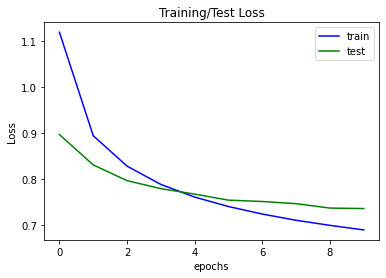

In [87]:
num_epochs = 10
Train_loss = []
Test_loss = []
Train_acc = []
Test_acc = []

for i in range(num_epochs):
    print("Epoch Number: ", i)
    train_loss, train_acc = one_epoch(model, 
                                      train_loader, 
                                      criterion=criterion,
                                      optimizer=optimizer)
    test_loss, test_acc = val_model(model,val_loader,
                                    criterion=criterion)
    torch.save(model,os.path.join(Path,'{}.pt'.format('model_V3_'+ str(i))))
    
    Train_loss.append(train_loss)
    Test_loss.append(test_loss)
    Train_acc.append(train_acc)
    Test_acc.append(test_acc)
    
torch.save(model.state_dict(), os.path.join(Path,'{}.pt'.format('modelDict_V3')))
training_plot(Train_loss,Test_loss)

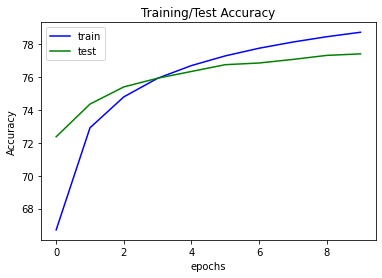

In [88]:
training_plot_acc(Train_acc,Test_acc)

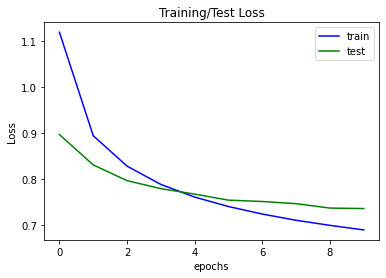

In [89]:
training_plot(Train_loss,Test_loss)

In [90]:
model = torch.load(os.path.join(Path,'{}.pt'.format('model_V2_'+ str(9))))

In [98]:
test_loss, test_acc = val_model(model,val_loader,criterion=criterion)

[0] Valid Loss:  tensor(0.6859, device='cuda:0')
[1] Valid Loss:  tensor(0.8796, device='cuda:0')
[2] Valid Loss:  tensor(0.6652, device='cuda:0')
[3] Valid Loss:  tensor(0.6006, device='cuda:0')
[4] Valid Loss:  tensor(0.7383, device='cuda:0')
[5] Valid Loss:  tensor(0.6930, device='cuda:0')
[6] Valid Loss:  tensor(0.7131, device='cuda:0')
[7] Valid Loss:  tensor(0.8259, device='cuda:0')
[8] Valid Loss:  tensor(0.7578, device='cuda:0')
[9] Valid Loss:  tensor(0.8166, device='cuda:0')
[10] Valid Loss:  tensor(0.6720, device='cuda:0')
[11] Valid Loss:  tensor(0.6669, device='cuda:0')
[12] Valid Loss:  tensor(1.1379, device='cuda:0')
[13] Valid Loss:  tensor(0.9776, device='cuda:0')
[14] Valid Loss:  tensor(0.6125, device='cuda:0')
[15] Valid Loss:  tensor(0.7342, device='cuda:0')
[16] Valid Loss:  tensor(0.6075, device='cuda:0')
[17] Valid Loss:  tensor(0.7500, device='cuda:0')
[18] Valid Loss:  tensor(0.6714, device='cuda:0')
[19] Valid Loss:  tensor(0.6158, device='cuda:0')
[20] Valid

[163] Valid Loss:  tensor(0.6574, device='cuda:0')
[164] Valid Loss:  tensor(0.9269, device='cuda:0')
[165] Valid Loss:  tensor(0.7214, device='cuda:0')
[166] Valid Loss:  tensor(0.7098, device='cuda:0')
[167] Valid Loss:  tensor(0.6009, device='cuda:0')
[168] Valid Loss:  tensor(0.6840, device='cuda:0')
[169] Valid Loss:  tensor(0.6365, device='cuda:0')
[170] Valid Loss:  tensor(0.6687, device='cuda:0')
[171] Valid Loss:  tensor(0.5713, device='cuda:0')
[172] Valid Loss:  tensor(0.7843, device='cuda:0')
[173] Valid Loss:  tensor(0.6243, device='cuda:0')
[174] Valid Loss:  tensor(0.7587, device='cuda:0')
[175] Valid Loss:  tensor(0.6867, device='cuda:0')
[176] Valid Loss:  tensor(0.6014, device='cuda:0')
[177] Valid Loss:  tensor(0.7329, device='cuda:0')
[178] Valid Loss:  tensor(0.7966, device='cuda:0')
[179] Valid Loss:  tensor(0.8119, device='cuda:0')
[180] Valid Loss:  tensor(0.7953, device='cuda:0')
[181] Valid Loss:  tensor(0.7703, device='cuda:0')
[182] Valid Loss:  tensor(0.722

[324] Valid Loss:  tensor(0.7659, device='cuda:0')
[325] Valid Loss:  tensor(0.6269, device='cuda:0')
[326] Valid Loss:  tensor(0.7054, device='cuda:0')
[327] Valid Loss:  tensor(0.4554, device='cuda:0')
[328] Valid Loss:  tensor(0.6469, device='cuda:0')
[329] Valid Loss:  tensor(0.8306, device='cuda:0')
[330] Valid Loss:  tensor(0.6265, device='cuda:0')
[331] Valid Loss:  tensor(0.9424, device='cuda:0')
[332] Valid Loss:  tensor(0.5868, device='cuda:0')
[333] Valid Loss:  tensor(0.5850, device='cuda:0')
[334] Valid Loss:  tensor(0.6086, device='cuda:0')
[335] Valid Loss:  tensor(0.6905, device='cuda:0')
[336] Valid Loss:  tensor(0.7930, device='cuda:0')
[337] Valid Loss:  tensor(0.8768, device='cuda:0')
[338] Valid Loss:  tensor(0.7642, device='cuda:0')
[339] Valid Loss:  tensor(0.6904, device='cuda:0')
[340] Valid Loss:  tensor(0.7531, device='cuda:0')
[341] Valid Loss:  tensor(0.8244, device='cuda:0')
[342] Valid Loss:  tensor(0.9318, device='cuda:0')
[343] Valid Loss:  tensor(0.761